# Burden of Neonatal Sepsis Data Exploration

### Chirag Kumar - 07.12.2021

### This script explores and aggregates Kp neonatal sepsis data across sources.

## Prep Workspace

### Import and Set-up Packages: Python and R

In [1]:
# python packages
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for matplotlib settings
import os # for directories
import glob
from uncertainties import ufloat
import scipy as sp
from scipy.optimize import minimize # for optimization
#import scipy as sp # useful to have the whole library to access
from scipy import stats # for statistics and distributions
import soad
from soad import AsymmetricData as asyd
from pyDOE import *
import statsmodels.formula.api as smf # for GLMs
import statsmodels.api as sm
from tqdm.auto import tqdm # for progress bars
#import pickle # for serializing objects
import pygal # for world maps
from pygal_maps_world.maps import World
from pygal.style import *

In [2]:
# configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]
font = {'family' : 'Nimbus Roman',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

In [3]:
# configure R
%load_ext rpy2.ipython

In [4]:
%%R -r 200
# get necessary R packages
library(ggplot2)
library(ggridges)
library(RColorBrewer)
library(grDevices)
# change ggplot default theme to be black and white
ggplot2::theme_set(theme_bw())

R[write to console]: Keep up to date with changes at https://www.tidyverse.org/blog/



### Define Directories

In [5]:
# define directories

# this is a hack to be able to refer to relative locations
if '__file__' not in globals():
    __file__ = '.'

inp_dir = os.path.abspath(os.path.dirname(__file__))
data_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                        'Data'))
out_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                       'Result Files'))
fig_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                          'Figures'))

### Get Data

#### Read in BARNARDS data

In [6]:
ddf = pd.read_excel(os.path.join(data_dir, 'raw', 'DDF-INITIAL-BARNARDS.xlsx'))

In [7]:
kp = pd.read_csv(os.path.join(data_dir, 'raw', 'sepsis_isolate_kpneumoniae.csv'))

In [8]:
all_files = glob.glob(os.path.join(data_dir, 'raw', 'sepsis_isolate_*.csv'))

In [9]:
all_files

['/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_gnb_others.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_ralstonia.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_ecoli.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_koxmich.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_gnbspecies_mic.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_gpbspecies_mic.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_serratia.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_kpneumoniae.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_enterobacter.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_burkholderia.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_saureus.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_acinetobacter.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_gpb_others.csv',
 '/home/ckk/Projects/KpVaccine/Data/raw/sepsis_isolate_pseudom

In [10]:
li = []

for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

frame = pd.concat(li, axis=0)

In [11]:
ps = pd.read_csv(os.path.join(data_dir, 'raw', 'sepsis_isolate_pseudomonas.csv'))

In [12]:
ac = pd.read_csv(os.path.join(data_dir, 'raw', 'sepsis_isolate_acinetobacter.csv'))

In [13]:
ac = ac[ac.FINALSPECIESID == 'Acinetobacter baumannii']

In [14]:
ec = pd.read_csv(os.path.join(data_dir, 'raw', 'sepsis_isolate_ecoli.csv'))

In [15]:
saureus = pd.read_csv(os.path.join(data_dir, 'raw', 'sepsis_isolate_saureus.csv'))

In [16]:
epi = pd.read_csv(os.path.join(data_dir, 'raw', 'barnards_epi_06102020.csv'))

In [17]:
screening = pd.read_csv(os.path.join(data_dir, 'raw', 'argscreening_env.csv'))

In [18]:
mr = pd.read_csv(os.path.join(data_dir, 'raw', 'arg_rectal_mother_neonate_mr.csv'))

In [19]:
br = pd.read_csv(os.path.join(data_dir, 'raw', 'arg_rectal_mother_neonate_br.csv'))

In [20]:
pathogens = pd.concat([kp, ac, ec, saureus], axis = 0, ignore_index = True)

In [21]:
pathogens.head()

SITE  ANON_MOTHER ANON_BABY         FINALSPECIESID  \
0   BC      30405.0     30405  Klebsiella pneumoniae   
1   BC      12933.0     12933  Klebsiella pneumoniae   
2   BC      17991.0     17991  Klebsiella pneumoniae   
3   BC      16666.0     16666  Klebsiella pneumoniae   
4   BC      27703.0     27703  Klebsiella pneumoniae   

               ENA_ACCESSION ENTEROBACTERIACEAE TYPEOFSEPSIS   ST        O  \
0  ERS5229736 (SAMEA7472041)                  Y          GNB  147      O3b   
1  ERS5229742 (SAMEA7472047)                  Y          GNB   17     O2v2   
2  ERS5229750 (SAMEA7472055)                  Y          GNB   39  O1/O2v1   
3  ERS5229751 (SAMEA7472056)                  Y          GNB  292      O3b   
4  ERS5229755 (SAMEA7472060)                  Y          GNB  340       O4   

       K  ... SFAA SFAB SFAC SFAD SIRA SIRB SIRC SRTB SAK IN_1  
0  KL128  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
1  KL122  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
2    KL2  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
3   KL38  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
4   KL15  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  

[5 rows x 617 columns]

In [22]:
pathogens = pathogens[pathogens.SITE.notna()]

In [23]:
pathogens.SITE = pathogens.SITE.map(lambda x: mr[mr.SITE==x].COUNTRY.unique()[0], na_action = 'ignore')

In [24]:
frame.SITE = frame.SITE.map(lambda x: mr[mr.SITE==x].COUNTRY.unique()[0], na_action = 'ignore')

In [25]:
barnards = pathogens.merge(epi, left_on = 'ANON_BABY', right_on = 'ANON_BABYID')

In [26]:
barnards.head()

SITE_x  ANON_MOTHER ANON_BABY         FINALSPECIESID  \
0  Bangladesh      30405.0     30405  Klebsiella pneumoniae   
1  Bangladesh      12933.0     12933  Klebsiella pneumoniae   
2  Bangladesh      17991.0     17991  Klebsiella pneumoniae   
3  Bangladesh      16666.0     16666  Klebsiella pneumoniae   
4  Bangladesh      27703.0     27703  Klebsiella pneumoniae   

               ENA_ACCESSION ENTEROBACTERIACEAE TYPEOFSEPSIS   ST        O  \
0  ERS5229736 (SAMEA7472041)                  Y          GNB  147      O3b   
1  ERS5229742 (SAMEA7472047)                  Y          GNB   17     O2v2   
2  ERS5229750 (SAMEA7472055)                  Y          GNB   39  O1/O2v1   
3  ERS5229751 (SAMEA7472056)                  Y          GNB  292      O3b   
4  ERS5229755 (SAMEA7472060)                  Y          GNB  340       O4   

       K  ... DATEATINFANTOUTCOME AGEATOUTCOMEDAYS_y NCHILD CLINICASSUM  \
0  KL128  ...          2017-04-12               60.0    1.0         1.0   
1  KL122  ...          2017-06-03               60.0    1.0         1.0   
2    KL2  ...          2017-06-29               60.0    1.0         1.0   
3   KL38  ...          2017-06-24               60.0    1.0         1.0   
4   KL15  ...          2017-07-14               60.0    1.0         1.0   

  NECULTUCFIRM   CLINDATE1    CULTDATE TIMETOCLINSEPSIS RFINBORNOUTBORN_y  \
0          1.0  2017-02-26  2017-02-26             15.0               2.0   
1          1.0  2017-04-05  2017-04-05              1.0               1.0   
2          1.0  2017-05-05  2017-05-05              5.0               2.0   
3          1.0  2017-05-11  2017-05-11             16.0               2.0   
4          1.0  2017-06-03  2017-06-03             19.0               2.0   

  ZBIRTHCOHORT  
0          0.0  
1          1.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 715 columns]

In [27]:
def mapping(x):
    try:
        if x == 'Acinetobacter baumannii':
            return x
#         if x[0:2] == 'Ac':
#             return 'Acinetobacter spp.'
        elif x == 'Klebsiella pneumoniae':
            return x
        elif x == 'Escherichia coli':
            return x
        elif x == 'Staphylococcus aureus':
            return x
        else:
            return 'Other'
    except TypeError as e:
        return np.nan

In [28]:
barnards['pathogen'] = barnards.FINALSPECIESID.map(mapping)

In [29]:
barnards.pathogen.value_counts()

Klebsiella pneumoniae      258
Staphylococcus aureus      100
Escherichia coli            75
Acinetobacter baumannii     38
Name: pathogen, dtype: int64

In [30]:
barnards = barnards[barnards.OUTCOME_x.isin(['alive', 'deceased'])]

In [31]:
frame = frame[frame.OUTCOME.isin(['alive', 'deceased'])]

In [32]:
barnards.OUTCOME_x.value_counts()

alive       293
deceased     99
Name: OUTCOME_x, dtype: int64

#### Read in CHAMPS data

In [33]:
# merge data sets together
demographics = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                        'CHAMPS_deid_basic_demographics.csv'))
decode_results = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                         'CHAMPS_deid_decode_results_long.csv'))
lab = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                        'CHAMPS_deid_lab_results.csv'))
tac = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                         'CHAMPS_deid_tac_assay_results_long.csv'))
va = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                         'CHAMPS_deid_verbal_autopsy.csv'))

In [34]:
vocab = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                         'CHAMPS_vocabulary.csv'))
icd_map = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                         'CHAMPS_ICD_Mappings.csv'))
icd_desc = pd.read_csv(os.path.join(data_dir, 'CHAMPS_de_identified_data',
                                         'CHAMPS_icd10_descriptions.csv'))

In [35]:
champs_total = demographics.merge(decode_results,
                            on = 'champs_deid').merge(lab,
                                                      on = 'champs_deid').merge(va, on = 'champs_deid')

In [36]:
champs_total.champs_group_desc.value_counts()

Perinatal asphyxia/hypoxia                                     2016
Neonatal preterm birth complications                           1713
Lower respiratory infections                                   1101
Neonatal sepsis                                                 942
Sepsis                                                          702
Congenital birth defects                                        603
Other neonatal disorders                                        486
Meningitis/Encephalitis                                         435
Malnutrition                                                    354
Malaria                                                         333
Congenital infection                                            282
Diarrheal Diseases                                              237
Other respiratory disease                                       210
Other infections                                                177
HIV                                             

In [37]:
champs_total.etiol.value_counts()

Klebsiella pneumoniae                           387
Acinetobacter baumannii                         241
Other Etiology/Agent                            163
Streptococcus pneumoniae                        146
Escherichia coli                                123
                                               ... 
Varicella zoster virus                            1
Salmonella enterica  sub-species paratyphi A      1
Acinetobacter spp.                                1
Plasmodium knowlesi                               1
Human coronavirus 4 (HKU1)                        1
Name: etiol, Length: 74, dtype: int64

In [38]:
champs_total[champs_total.etiol == 'Klebsiella pneumoniae'].champs_group_desc.value_counts()

Lower respiratory infections    134
Neonatal sepsis                 108
Sepsis                           93
Meningitis/Encephalitis          43
Congenital infection              5
Other respiratory disease         3
Other infections                  1
Name: champs_group_desc, dtype: int64

In [39]:
# TODO: Come back to this idea

# communicable_etiologies = ['Lower respiratory infections', 'Neonatal sepsis', 'Sepsis',
#                            'Meningitis/Encephalitis', 'Malaria', 'Congenital infection', 'Diarrheal Diseases',
#                           'Other respiratory disease', 'Other infections', 'HIV', '']

In [40]:
cc1 = np.logical_or(np.logical_and(champs_total.champs_deid.duplicated(keep = 'first'),
                     champs_total.etiol.isin(champs_total[champs_total.champs_group_desc == 'Neonatal sepsis'].etiol.unique())),
                   champs_total.etiol.isin(champs_total[champs_total.champs_group_desc == 'Neonatal sepsis'].etiol.unique()))

In [41]:
#champs = champs_total[cc1]
#champs = champs_total[champs_total.champs_group_desc.isin(['Neonatal Sepsis', 'Sepsis'])]

In [42]:
champs_total[cc1]

champs_deid site_iso_code  \
0      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
1      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
2      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
3      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
4      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
...                                     ...           ...   
50665  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50666  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50667  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50668  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50669  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   

                              sex date_of_birth date_of_death  age_years  \
0                            Male    2018-03-14    2018-03-14          0   
1                            Male    2018-03-14    2018-03-14          0   
2                            Male    2018-03-14    2018-03-14          0   
3                            Male    2018-03-14    2018-03-14          0   
4                            Male    2018-03-14    2018-03-14          0   
...                           ...           ...           ...        ...   
50665  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50666  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50667  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50668  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50669  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   

       age_months  age_days  age_hours                  age_group_x  ...  \
0               0       0.0        0.0                   Stillbirth  ...   
1               0       0.0        0.0                   Stillbirth  ...   
2               0       0.0        0.0                   Stillbirth  ...   
3               0       0.0        0.0                   Stillbirth  ...   
4               0       0.0        0.0                   Stillbirth  ...   
...           ...       ...        ...                          ...  ...   
50665           0       0.0        0.0  Death in the first 24 hours  ...   
50666           0       0.0        0.0  Death in the first 24 hours  ...   
50667           0       0.0        0.0  Death in the first 24 hours  ...   
50668           0       0.0        0.0  Death in the first 24 hours  ...   
50669           0       0.0        0.0  Death in the first 24 hours  ...   

      isChild1 isChild2  isChildAgeLessThanOne  isNeonatal  isNeonatal1  \
0          0.0      0.0                    1.0         1.0          1.0   
1          0.0      0.0                    1.0         1.0          1.0   
2          0.0      0.0                    1.0         1.0          1.0   
3          0.0      0.0                    1.0         1.0          1.0   
4          0.0      0.0                    1.0         1.0          1.0   
...        ...      ...                    ...         ...          ...   
50665      0.0      0.0                    1.0         1.0          1.0   
50666      0.0      0.0                    1.0         1.0          1.0   
50667      0.0      0.0                    1.0         1.0          1.0   
50668      0.0      0.0                    1.0         1.0          1.0   
50669      0.0      0.0                    1.0         1.0          1.0   

       isNeonatal2  last_time_moved  mother_death  pain_duration  Version  
0              0.0              NaN           NaN            NaN    v2_04  
1              0.0              NaN           NaN            NaN    v2_04  
2              0.0              NaN           NaN            NaN    v2_04  
3              0.0              NaN           NaN            NaN    v2_04  
4              0.0              NaN           NaN            NaN    v2_04  
...            ...              ...           ...            ...      ...  
50665          0.0              NaN     

In [43]:
champs_total[cc1].age_group_x.value_counts()

Stillbirth                                  14753
Death in the first 24 hours                  9084
Early Neonate (1 to 6 days)                  7913
Infant (28 days to less than 12 months)      7695
Child (12 months to less than 60 Months)     6747
Late Neonate (7 to 27 days)                  4153
Name: age_group_x, dtype: int64

In [44]:
champs_total[cc1].etiol.value_counts() / champs_total[cc1].etiol.value_counts().sum()

Klebsiella pneumoniae                0.252446
Acinetobacter baumannii              0.157208
Other Etiology/Agent                 0.106327
Streptococcus pneumoniae             0.095238
Escherichia coli                     0.080235
Cytomegalovirus (CMV)                0.054795
Staphylococcus aureus                0.044357
Streptococcus agalactiae             0.043705
Haemophilus influenzae               0.036530
Pseudomonas aeruginosa               0.024136
Candida albicans                     0.019569
Enterococcus faecalis                0.018265
Streptococcus pyogenes               0.010437
Enterococcus faecium                 0.007828
Salmonella spp.                      0.007175
Candida glabrata                     0.007175
Candida parapsilosis                 0.005871
Enterobacter cloacae                 0.005871
Escherichia coli/Shigella spp.       0.005219
Streptococcus spp.                   0.005219
Shigella                             0.003914
Candida spp.                      

In [45]:
champs_total[cc1][champs_total[cc1].age_group_x != 'Stillbirth'].etiol.value_counts() / champs_total[cc1][champs_total[cc1].age_group_x != 'Stillbirth'].etiol.value_counts().sum()

Klebsiella pneumoniae                0.262799
Acinetobacter baumannii              0.164505
Other Etiology/Agent                 0.105802
Streptococcus pneumoniae             0.098294
Escherichia coli                     0.074403
Cytomegalovirus (CMV)                0.052560
Staphylococcus aureus                0.046416
Haemophilus influenzae               0.037543
Streptococcus agalactiae             0.034812
Pseudomonas aeruginosa               0.024573
Candida albicans                     0.020478
Enterococcus faecalis                0.012287
Streptococcus pyogenes               0.010922
Enterococcus faecium                 0.008191
Salmonella spp.                      0.007509
Candida glabrata                     0.007509
Candida parapsilosis                 0.006143
Enterobacter cloacae                 0.005461
Escherichia coli/Shigella spp.       0.004778
Shigella                             0.004096
Streptococcus spp.                   0.003413
Candida spp.                      

In [46]:
champs_total[cc1][champs_total[cc1].age_group_x != 'Stillbirth'].site_iso_code.value_counts() / champs_total[cc1][champs_total[cc1].age_group_x != 'Stillbirth'].site_iso_code.value_counts().sum()

ZA    0.403349
KE    0.246825
ML    0.096061
MZ    0.075466
BD    0.069847
SL    0.069032
ET    0.039419
Name: site_iso_code, dtype: float64

In [47]:
champs_total[cc1].site_iso_code.value_counts() / champs_total[cc1].site_iso_code.value_counts().sum()

ZA    0.338703
KE    0.237064
ML    0.110219
BD    0.096415
MZ    0.087894
SL    0.073235
ET    0.056470
Name: site_iso_code, dtype: float64

In [48]:
champs_total[champs_total.etiol.isin(champs_total[champs_total.champs_group_desc.isin(['Neonatal sepsis'])].etiol)]

champs_deid site_iso_code  \
0      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
1      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
2      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
3      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
4      FB153E01-9A73-4E03-8370-A240C71B6ED5            BD   
...                                     ...           ...   
50665  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50666  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50667  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50668  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   
50669  E80277D5-865D-4FA0-A8D4-7D519CF02B99            KE   

                              sex date_of_birth date_of_death  age_years  \
0                            Male    2018-03-14    2018-03-14          0   
1                            Male    2018-03-14    2018-03-14          0   
2                            Male    2018-03-14    2018-03-14          0   
3                            Male    2018-03-14    2018-03-14          0   
4                            Male    2018-03-14    2018-03-14          0   
...                           ...           ...           ...        ...   
50665  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50666  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50667  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50668  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   
50669  Indeterminate or Ambiguous    2018-09-24    2018-09-24          0   

       age_months  age_days  age_hours                  age_group_x  ...  \
0               0       0.0        0.0                   Stillbirth  ...   
1               0       0.0        0.0                   Stillbirth  ...   
2               0       0.0        0.0                   Stillbirth  ...   
3               0       0.0        0.0                   Stillbirth  ...   
4               0       0.0        0.0                   Stillbirth  ...   
...           ...       ...        ...                          ...  ...   
50665           0       0.0        0.0  Death in the first 24 hours  ...   
50666           0       0.0        0.0  Death in the first 24 hours  ...   
50667           0       0.0        0.0  Death in the first 24 hours  ...   
50668           0       0.0        0.0  Death in the first 24 hours  ...   
50669           0       0.0        0.0  Death in the first 24 hours  ...   

      isChild1 isChild2  isChildAgeLessThanOne  isNeonatal  isNeonatal1  \
0          0.0      0.0                    1.0         1.0          1.0   
1          0.0      0.0                    1.0         1.0          1.0   
2          0.0      0.0                    1.0         1.0          1.0   
3          0.0      0.0                    1.0         1.0          1.0   
4          0.0      0.0                    1.0         1.0          1.0   
...        ...      ...                    ...         ...          ...   
50665      0.0      0.0                    1.0         1.0          1.0   
50666      0.0      0.0                    1.0         1.0          1.0   
50667      0.0      0.0                    1.0         1.0          1.0   
50668      0.0      0.0                    1.0         1.0          1.0   
50669      0.0      0.0                    1.0         1.0          1.0   

       isNeonatal2  last_time_moved  mother_death  pain_duration  Version  
0              0.0              NaN           NaN            NaN    v2_04  
1              0.0              NaN           NaN            NaN    v2_04  
2              0.0              NaN           NaN            NaN    v2_04  
3              0.0              NaN           NaN            NaN    v2_04  
4              0.0              NaN           NaN            NaN    v2_04  
...            ...              ...           ...            ...      ...  
50665          0.0              NaN     

In [49]:
champs = champs_total[champs_total.etiol.isin(champs_total[champs_total.champs_group_desc.isin(['Neonatal sepsis'])].etiol)]

In [50]:
champs = champs[champs.age_group_x != 'Stillbirth']

In [51]:
champs = champs[champs.etiol != 'Other Etiology/Agent'] # fair to drop bc only looking at culture sepsis
champs = champs[champs.etiol.notna()]

In [52]:
#champs = champs.drop_duplicates('champs_deid')

In [53]:
champs['site'] = champs.site_iso_code.map({'BD' : 'Bangladesh',
                                        'KE' : 'Kenya',
                                        'ET' : 'Ethiopia',
                                        'ZA' : 'SouthAfrica',
                                        'SL' : 'SierraLeone',
                                        'MZ' : 'Mozambique',
                                        'ML' : 'Mali'})

In [54]:
champs = champs.reset_index()

### Read in GARD-P Data

In [55]:
gardp_cases = pd.read_excel(os.path.join(data_dir, 'NeoObs/Kumar_Organisms_baseline_country.xlsx'))

In [56]:
gardp_cases

Country  KlebsiellaP  AcinetobacterBaum  Ecoli  Saureus  OtherPath  \
0     Bangladesh            4                  1      1        0          5   
1         Brazil            7                  0      0        3         16   
2          China           13                  0     13        6         41   
3         Greece            3                  0      0        0         22   
4          India           32                 21      5        8         58   
5          Italy            0                  0      2        1         11   
6          Kenya            2                  2      1        3          9   
7   South Africa           50                 31      9       19         62   
8        Tailand            6                  5      4        5         40   
9         Uganda            4                  0      3        1         12   
10       Vietnam           11                  4      9        8         13   

    Anypathogen  
0            11  
1            25  
2            71  
3            25  
4           123  
5            14  
6            17  
7           157  
8            56  
9            20  
10           45

In [57]:
gardp_cases_subset = gardp_cases.iloc[:, :-2]

In [58]:
gardp_cases_subset

Country  KlebsiellaP  AcinetobacterBaum  Ecoli  Saureus
0     Bangladesh            4                  1      1        0
1         Brazil            7                  0      0        3
2          China           13                  0     13        6
3         Greece            3                  0      0        0
4          India           32                 21      5        8
5          Italy            0                  0      2        1
6          Kenya            2                  2      1        3
7   South Africa           50                 31      9       19
8        Tailand            6                  5      4        5
9         Uganda            4                  0      3        1
10       Vietnam           11                  4      9        8

In [59]:
gardp_deaths = gardp_cases = pd.read_excel(os.path.join(data_dir,
                                                        'NeoObs/Kumar_Organisms_baseline_country_died.xlsx'))

In [60]:
gardp_deaths

Country  KlebsiellaP  AcinetobacterBaum  Ecoli  Saureus  OtherPath  \
0    Bangladesh            0                  0      0        0          1   
1        Brazil            1                  0      0        1          0   
2         China            0                  0      0        0          3   
3        Greece            0                  0      0        0          1   
4         India           15                  8      2        0         10   
5         Kenya            0                  0      0        1          1   
6  South Africa            9                 12      1        4         15   
7       Tailand            0                  1      0        0          1   
8        Uganda            2                  0      1        0          2   
9       Vietnam            1                  0      2        0          5   

   Anypathogen  
0            1  
1            2  
2            3  
3            1  
4           35  
5            2  
6           40  
7            2  
8            5  
9            8

In [61]:
# so deaths were tracked in italy but no neonates died
italy = pd.DataFrame(['Italy', 0, 0, 0, 0, 0,0]).T
italy.columns = gardp_deaths.columns
gardp_deaths = pd.concat([gardp_deaths, italy], axis = 0)
gardp_deaths = gardp_deaths.sort_values(by = 'Country')
gardp_deaths = gardp_deaths.reset_index(drop = True)

In [62]:
gardp_deaths

Country KlebsiellaP AcinetobacterBaum Ecoli Saureus OtherPath  \
0     Bangladesh           0                 0     0       0         1   
1         Brazil           1                 0     0       1         0   
2          China           0                 0     0       0         3   
3         Greece           0                 0     0       0         1   
4          India          15                 8     2       0        10   
5          Italy           0                 0     0       0         0   
6          Kenya           0                 0     0       1         1   
7   South Africa           9                12     1       4        15   
8        Tailand           0                 1     0       0         1   
9         Uganda           2                 0     1       0         2   
10       Vietnam           1                 0     2       0         5   

   Anypathogen  
0            1  
1            2  
2            3  
3            1  
4           35  
5            0  
6            2  
7           40  
8            2  
9            5  
10           8

In [63]:
gardp_deaths_subset = gardp_deaths.iloc[:, :-2]

In [64]:
gardp_deaths_subset

Country KlebsiellaP AcinetobacterBaum Ecoli Saureus
0     Bangladesh           0                 0     0       0
1         Brazil           1                 0     0       1
2          China           0                 0     0       0
3         Greece           0                 0     0       0
4          India          15                 8     2       0
5          Italy           0                 0     0       0
6          Kenya           0                 0     0       1
7   South Africa           9                12     1       4
8        Tailand           0                 1     0       0
9         Uganda           2                 0     1       0
10       Vietnam           1                 0     2       0

In [65]:
gardp_deaths_subset

Country KlebsiellaP AcinetobacterBaum Ecoli Saureus
0     Bangladesh           0                 0     0       0
1         Brazil           1                 0     0       1
2          China           0                 0     0       0
3         Greece           0                 0     0       0
4          India          15                 8     2       0
5          Italy           0                 0     0       0
6          Kenya           0                 0     0       1
7   South Africa           9                12     1       4
8        Tailand           0                 1     0       0
9         Uganda           2                 0     1       0
10       Vietnam           1                 0     2       0

In [66]:
gardp_deaths_overall = gardp_deaths.iloc[:, 1:].sum(axis = 1).values

In [67]:
gardp_unwrapped = pd.DataFrame()
countries = list(gardp_cases_subset['Country'])
countries.extend(countries * 3) # for the three pathogens
gardp_unwrapped['Country'] = countries
pathogens = ['Klebsiella pneumoniae'] * len(gardp_cases_subset['Country'])
pathogens.extend(['Acinetobacter baumannii'] * len(gardp_cases_subset['Country']))
pathogens.extend(['Escherichia coli'] * len(gardp_cases_subset['Country']))
pathogens.extend(['Staphylococcus aureus'] * len(gardp_cases_subset['Country']))
gardp_unwrapped['pathogen'] = pathogens
gardp_unwrapped['cases'] = gardp_cases_subset.iloc[:, 1:].to_numpy().T.flatten()
gardp_unwrapped['deaths'] = gardp_deaths_subset.iloc[:, 1:].to_numpy().T.flatten()

In [68]:
gardp_unwrapped[['cases', 'deaths']] = gardp_unwrapped[['cases', 'deaths']].astype(np.float64)

In [69]:
gardp_deaths_overall = list(gardp_deaths_overall)

In [70]:
gardp_deaths_overall.extend(gardp_deaths_overall * 3)

In [71]:
gardp_unwrapped['deaths_overall'] = gardp_deaths_overall

In [72]:
gardp_unwrapped['p_death'] = gardp_unwrapped['deaths'] / gardp_unwrapped['deaths_overall']

In [73]:
gardp_unwrapped

Country                 pathogen  cases  deaths  deaths_overall  \
0     Bangladesh    Klebsiella pneumoniae    4.0     0.0             2.0   
1         Brazil    Klebsiella pneumoniae    7.0     1.0             4.0   
2          China    Klebsiella pneumoniae   13.0     0.0             6.0   
3         Greece    Klebsiella pneumoniae    3.0     0.0             2.0   
4          India    Klebsiella pneumoniae   32.0    15.0            70.0   
5          Italy    Klebsiella pneumoniae    0.0     0.0             0.0   
6          Kenya    Klebsiella pneumoniae    2.0     0.0             4.0   
7   South Africa    Klebsiella pneumoniae   50.0     9.0            81.0   
8        Tailand    Klebsiella pneumoniae    6.0     0.0             4.0   
9         Uganda    Klebsiella pneumoniae    4.0     2.0            10.0   
10       Vietnam    Klebsiella pneumoniae   11.0     1.0            16.0   
11    Bangladesh  Acinetobacter baumannii    1.0     0.0             2.0   
12        Brazil  Acinetobacter baumannii    0.0     0.0             4.0   
13         China  Acinetobacter baumannii    0.0     0.0             6.0   
14        Greece  Acinetobacter baumannii    0.0     0.0             2.0   
15         India  Acinetobacter baumannii   21.0     8.0            70.0   
16         Italy  Acinetobacter baumannii    0.0     0.0             0.0   
17         Kenya  Acinetobacter baumannii    2.0     0.0             4.0   
18  South Africa  Acinetobacter baumannii   31.0    12.0            81.0   
19       Tailand  Acinetobacter baumannii    5.0     1.0             4.0   
20        Uganda  Acinetobacter baumannii    0.0     0.0            10.0   
21       Vietnam  Acinetobacter baumannii    4.0     0.0            16.0   
22    Bangladesh         Escherichia coli    1.0     0.0             2.0   
23        Brazil         Escherichia coli    0.0     0.0             4.0   
24         China         Escherichia coli   13.0     0.0             6.0   
25        Greece         Escherichia coli    0.0     0.0             2.0   
26         India         Escherichia coli    5.0     2.0            70.0   
27         Italy         Escherichia coli    2.0     0.0             0.0   
28         Kenya         Escherichia coli    1.0     0.0             4.0   
29  South Africa         Escherichia coli    9.0     1.0            81.0   
30       Tailand         Escherichia coli    4.0     0.0             4.0   
31        Uganda         Escherichia coli    3.0     1.0            10.0   
32       Vietnam         Escherichia coli    9.0     2.0            16.0   
33    Bangladesh    Staphylococcus aureus    0.0     0.0             2.0   
34        Brazil    Staphylococcus aureus    3.0     1.0             4.0   
35         China    Staphylococcus aureus    6.0     0.0             6.0   
36        Greece    Staphylococcus aureus    0.0     0.0             2.0   
37         India    Staphylococcus aureus    8.0     0.0            70.0   
38         Italy    Staphylococcus aureus    1.0     0.0             0.0   
39         Kenya    Staphylococcus aureus    3.0     1.0             4.0   
40  South Africa    Staphylococcus aureus   19.0     4.0            81.0   
41       Tailand    Staphylococcus aureus    5.0     0.0             4.0   
42        Uganda    Staphylococcus aureus    1.0     0.0            10.0   
43       Vietnam    Staphylococcus aureus    8.0     0.0            16.0   

     p_death  
0   0.000000  
1   0.250000  
2   0.000000  
3   0.000000  
4   0.214286  
5        NaN  
6   0.000000  
7   0.111111  
8   0.000000  
9   0.200000  
10  0.062500  
11  0.000000  
12  0.000000  
13  0.000000  
14  0.000000  
15  0.114286  
16       NaN  
17  0.000000  
18  0.148148  
19  0.250000  
20  0.000000  
21  0.000000  
22  0.000000  
23  0.000000  
24  0.000000  
25  0.000000  
26  0.028571  
27       NaN  
28  0.000000  
29  0.012346  
30  0.000000  
31  0.100000  
32  0.125000  
33  0.000000  
34  0.250000  
35  0.000000  
36  0.000000  
37  0.000000  
38 

In [74]:
def country_mapping(x):
    if x == 'South Africa':
        return 'SouthAfrica'
    elif x == 'Tailand':
        return 'Thailand'
    else:
        return x

In [75]:
gardp_unwrapped['Country'] = gardp_unwrapped['Country'].map(country_mapping)

In [76]:
champs.site.unique()

array(['Kenya', 'Mali', 'SouthAfrica', 'Bangladesh', 'SierraLeone',
       'Ethiopia', 'Mozambique'], dtype=object)

In [77]:
barnards.SITE_x.unique()

array(['Bangladesh', 'Ethiopia', 'India', 'Nigeria', 'Pakistan', 'Rwanda',
       'SouthAfrica'], dtype=object)

In [78]:
gardp_unwrapped['Country'].unique()

array(['Bangladesh', 'Brazil', 'China', 'Greece', 'India', 'Italy',
       'Kenya', 'SouthAfrica', 'Thailand', 'Uganda', 'Vietnam'],
      dtype=object)

In [79]:
set(gardp_unwrapped['Country'].unique()) - (set(gardp_unwrapped['Country'].unique()) - set(champs.site.unique()))

{'Bangladesh', 'Kenya', 'SouthAfrica'}

## Comparison

In [80]:
# Ethiopia, Bangladesh, SouthAfrica are in common btwn champs and barnards
# Bangladesh, SouthAfrica, and India common between gardp and barnards
# Bangladesh, Kenya, and SouthAfrica common between gardp and champs
# Bangladesh and SouthAfrica are common between all three

In [81]:
# plot the probability of death by pathogen given that the child has died from sepsis
# across all study locations -- compare across CHAMPS and BARNARDS

In [82]:
# want a bar graph with three panels, one for each pathogen
# want color by location, and linetype by study
# will use NA for places that have data from one study but not the other, and place locations with both in mid
comparison = pd.DataFrame(columns = ['P(Pathogen | Death from Neonatal Sepsis)'])

In [83]:
comparison

Empty DataFrame
Columns: [P(Pathogen | Death from Neonatal Sepsis)]
Index: []

In [84]:
# go from champs to barnards
comparison['location'] = ['Kenya', 'SierraLeone', 'Mozambique', 'Mali',
                           'Ethiopia', 'Bangladesh', 'SouthAfrica',
                           'Nigeria', 'Pakistan', 'Rwanda', 'India'] * 3 * 2 # num pathogens * num studies

In [85]:
pathogens = ['Klebsiella pneumoniae'] * 11 * 2 # num sites * num studies
#pathogens.extend(['Acinetobacter spp.'] * 11 * 2)
pathogens.extend(['Acinetobacter baumannii'] * 11 * 2)
#pathogens.extend(['Escherichia coli'] * 11 * 2)
#pathogens.extend(['Pseudomonas aeruginosa'] * 11 * 2)
pathogens.extend(['Staphylococcus aureus'] * 11 * 2)
comparison['pathogen'] = pathogens

In [86]:
study = ['CHAMPS'] * 11
study.extend(['BARNARDS'] * 11)
study = study * 3 # num pathogens
comparison['study'] = study

In [87]:
comparison

P(Pathogen | Death from Neonatal Sepsis)     location  \
0                                       NaN        Kenya   
1                                       NaN  SierraLeone   
2                                       NaN   Mozambique   
3                                       NaN         Mali   
4                                       NaN     Ethiopia   
..                                      ...          ...   
61                                      NaN  SouthAfrica   
62                                      NaN      Nigeria   
63                                      NaN     Pakistan   
64                                      NaN       Rwanda   
65                                      NaN        India   

                 pathogen     study  
0   Klebsiella pneumoniae    CHAMPS  
1   Klebsiella pneumoniae    CHAMPS  
2   Klebsiella pneumoniae    CHAMPS  
3   Klebsiella pneumoniae    CHAMPS  
4   Klebsiella pneumoniae    CHAMPS  
..                    ...       ...  
61  Staphylococcus aureus  BARNARDS  
62  Staphylococcus aureus  BARNARDS  
63  Staphylococcus aureus  BARNARDS  
64  Staphylococcus aureus  BARNARDS  
65  Staphylococcus aureus  BARNARDS  

[66 rows x 4 columns]

In [88]:
# now let's figure out the death rate given pathogen by study location
# also only considering children who die within the first 30 days of life
champs_ns = champs[champs.age_months < 1][champs.age_years < 1][champs.age_days <= 28]
#champs_ns['year'] = champs_ns.date_of_birth.str.split('-').apply(lambda x: x[0]).astype(float)
#champs_ns = champs_ns[champs_ns['year'] < 2020]
champs_ns = champs_ns[['champs_deid', 'champs_group_desc', 'sex', 'age_days', 'age_hours', 'etiol', 'site']]
champs_ns = champs_ns.reset_index(drop = True)

.:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [89]:
champs_ns.etiol.value_counts() / champs_ns.etiol.value_counts().sum()

Klebsiella pneumoniae                0.327842
Acinetobacter baumannii              0.319605
Escherichia coli                     0.070840
Streptococcus agalactiae             0.052718
Staphylococcus aureus                0.042834
Candida albicans                     0.024712
Streptococcus pneumoniae             0.021417
Enterococcus faecalis                0.021417
Candida glabrata                     0.018122
Enterococcus faecium                 0.018122
Pseudomonas aeruginosa               0.014827
Cytomegalovirus (CMV)                0.013180
Salmonella spp.                      0.008237
Enterobacter cloacae                 0.006590
Haemophilus influenzae               0.006590
Candida parapsilosis                 0.006590
Streptococcus spp.                   0.004942
Streptococcus pyogenes               0.003295
Enterococcus spp.                    0.003295
Proteus mirabilis                    0.003295
Candida spp.                         0.003295
Coagulase negative Staphylococcus 

In [90]:
champs_ns['pathogen'] = champs_ns.etiol.map(mapping)

In [91]:
champs_ns.pathogen.value_counts()

Klebsiella pneumoniae      199
Acinetobacter baumannii    194
Other                      145
Escherichia coli            43
Staphylococcus aureus       26
Name: pathogen, dtype: int64

In [92]:
champs_ns

champs_deid     champs_group_desc     sex  \
0    1C0F738F-2ABF-4D0C-8BCE-E1F1F9DE3DE5       Neonatal sepsis    Male   
1    8BA8A5D6-0E76-4091-AB9C-A591D6E440E2       Neonatal sepsis    Male   
2    F778C831-BA02-4E24-8E2E-45D26C70B558                Sepsis    Male   
3    F778C831-BA02-4E24-8E2E-45D26C70B558                Sepsis    Male   
4    E3869CDC-44DA-49A0-8EBF-9AADD7F1609E       Neonatal sepsis    Male   
..                                    ...                   ...     ...   
602  8376F083-C058-4C2D-B112-5F748BA8767E  Congenital infection  Female   
603  E7AC3C36-16CE-41DB-BF3A-89C98B5621A8  Congenital infection  Female   
604  BAD74D7A-38DE-4A68-AC81-91C5D6F638B5       Neonatal sepsis  Female   
605  BAD74D7A-38DE-4A68-AC81-91C5D6F638B5  Congenital infection  Female   
606  522E0D73-9F58-456E-8257-31D6D20FE4E2  Congenital infection  Female   

     age_days  age_hours                     etiol         site  \
0         7.0       13.0        Acinetobacter spp.        Kenya   
1        10.0        3.0     Klebsiella pneumoniae         Mali   
2        20.0       23.0  Streptococcus agalactiae        Kenya   
3        20.0       23.0     Klebsiella pneumoniae        Kenya   
4         6.0        1.0     Klebsiella pneumoniae  SouthAfrica   
..        ...        ...                       ...          ...   
602       0.0        4.0     Klebsiella pneumoniae     Ethiopia   
603       0.0        3.0     Cytomegalovirus (CMV)   Bangladesh   
604       0.0        2.0  Streptococcus agalactiae   Mozambique   
605       0.0        2.0  Streptococcus agalactiae   Mozambique   
606       1.0       15.0     Cytomegalovirus (CMV)        Kenya   

                  pathogen  
0                    Other  
1    Klebsiella pneumoniae  
2                    Other  
3    Klebsiella pneumoniae  
4    Klebsiella pneumoniae  
..                     ...  
602  Klebsiella pneumoniae  
603                  Other  
604                  Other  
605                  Other  
606                  Other  

[607 rows x 8 columns]

In [93]:
# [~champs_ns.champs_deid.duplicated(keep = 'first')]
champs_ns_pdeath = champs_ns.groupby(['site', 'pathogen'], axis = 0).size().unstack(fill_value=0)

In [94]:
# num pathogens + 1
total_ns_deaths = pd.concat([pd.DataFrame(champs_ns.groupby('site').size())] * (5), axis=1, ignore_index=True)

In [95]:
denominator = (1 / total_ns_deaths)
denominator.columns = champs_ns_pdeath.columns
denominator.index = champs_ns_pdeath.index

In [96]:
champs_ns_pdeath = champs_ns_pdeath * denominator

In [97]:
champs_ns_pdeath

pathogen     Acinetobacter baumannii  Escherichia coli  Klebsiella pneumoniae  \
site                                                                            
Bangladesh                  0.230769          0.038462               0.423077   
Ethiopia                    0.000000          0.051282               0.641026   
Kenya                       0.029412          0.117647               0.441176   
Mali                        0.081633          0.204082               0.448980   
Mozambique                  0.090909          0.272727               0.181818   
SierraLeone                 0.000000          0.210526               0.526316   
SouthAfrica                 0.443902          0.036585               0.253659   

pathogen        Other  Staphylococcus aureus  
site                                          
Bangladesh   0.192308               0.115385  
Ethiopia     0.307692               0.000000  
Kenya        0.323529               0.088235  
Mali         0.265306               0.000000  
Mozambique   0.454545               0.000000  
SierraLeone  0.236842               0.026316  
SouthAfrica  0.219512               0.046341

In [98]:
champs_ns_pdeath = pd.DataFrame(champs_ns_pdeath.unstack()).reset_index()
champs_ns_pdeath.columns = ['pathogen', 'location', 'P(Pathogen | Death from Neonatal Sepsis)']
champs_ns_pdeath['study'] = 'CHAMPS'

In [99]:
rows_to_add = comparison[['location',
                          'pathogen',
                          'study']][comparison.study == 'CHAMPS'].merge(champs_ns_pdeath[['location',
                                                                                          'pathogen',
                                                                                          'study']],
                                                                        how = 'outer',
                                                                        indicator = True).loc[lambda x: x['_merge'] == 'left_only']

In [100]:
rows_to_add = rows_to_add.drop('_merge', axis = 1)
rows_to_add['P(Pathogen | Death from Neonatal Sepsis)'] = np.nan
rows_to_add = rows_to_add[['pathogen', 'location', 'P(Pathogen | Death from Neonatal Sepsis)', 'study']]
champs_ns_pdeath = pd.concat([champs_ns_pdeath, rows_to_add], axis = 0)
champs_ns_pdeath = champs_ns_pdeath[champs_ns_pdeath.pathogen != 'Other']

In [101]:
champs_ns_pdeath = champs_ns_pdeath.reset_index(drop = True)

In [102]:
champs_ns_pdeath

pathogen     location  \
0   Acinetobacter baumannii   Bangladesh   
1   Acinetobacter baumannii     Ethiopia   
2   Acinetobacter baumannii        Kenya   
3   Acinetobacter baumannii         Mali   
4   Acinetobacter baumannii   Mozambique   
5   Acinetobacter baumannii  SierraLeone   
6   Acinetobacter baumannii  SouthAfrica   
7          Escherichia coli   Bangladesh   
8          Escherichia coli     Ethiopia   
9          Escherichia coli        Kenya   
10         Escherichia coli         Mali   
11         Escherichia coli   Mozambique   
12         Escherichia coli  SierraLeone   
13         Escherichia coli  SouthAfrica   
14    Klebsiella pneumoniae   Bangladesh   
15    Klebsiella pneumoniae     Ethiopia   
16    Klebsiella pneumoniae        Kenya   
17    Klebsiella pneumoniae         Mali   
18    Klebsiella pneumoniae   Mozambique   
19    Klebsiella pneumoniae  SierraLeone   
20    Klebsiella pneumoniae  SouthAfrica   
21    Staphylococcus aureus   Bangladesh   
22    Staphylococcus aureus     Ethiopia   
23    Staphylococcus aureus        Kenya   
24    Staphylococcus aureus         Mali   
25    Staphylococcus aureus   Mozambique   
26    Staphylococcus aureus  SierraLeone   
27    Staphylococcus aureus  SouthAfrica   
28    Klebsiella pneumoniae      Nigeria   
29    Klebsiella pneumoniae     Pakistan   
30    Klebsiella pneumoniae       Rwanda   
31    Klebsiella pneumoniae        India   
32  Acinetobacter baumannii      Nigeria   
33  Acinetobacter baumannii     Pakistan   
34  Acinetobacter baumannii       Rwanda   
35  Acinetobacter baumannii        India   
36    Staphylococcus aureus      Nigeria   
37    Staphylococcus aureus     Pakistan   
38    Staphylococcus aureus       Rwanda   
39    Staphylococcus aureus        India   

    P(Pathogen | Death from Neonatal Sepsis)   study  
0                                   0.230769  CHAMPS  
1                                   0.000000  CHAMPS  
2                                   0.029412  CHAMPS  
3                                   0.081633  CHAMPS  
4                                   0.090909  CHAMPS  
5                                   0.000000  CHAMPS  
6                                   0.443902  CHAMPS  
7                                   0.038462  CHAMPS  
8                                   0.051282  CHAMPS  
9                                   0.117647  CHAMPS  
10                                  0.204082  CHAMPS  
11                                  0.272727  CHAMPS  
12                                  0.210526  CHAMPS  
13                                  0.036585  CHAMPS  
14                                  0.423077  CHAMPS  
15                                  0.641026  CHAMPS  
16                                  0.441176  CHAMPS  
17                                  0.448980  CHAMPS  
18                                  0.181818  CHAMPS  
19                                  0.526316  CHAMPS  
20                                  0.253659  CHAMPS  
21                                  0.115385  CHAMPS  
22                                  0.000000  CHAMPS  
23                                  0.088235  CHAMPS  
24                                  0.000000  CHAMPS  
25                                  0.000000  CHAMPS  
26                                  0.026316  CHAMPS  
27                                  0.046341  CHAMPS  
28                                       NaN  CHAMPS  
29                                       NaN  CHAMPS  
30                                       NaN  CHAMPS  
31                                       NaN  CHAMPS  
32                                       NaN  CHAMPS  
33                                       NaN  CHAMPS  
34                                       NaN  CHAMPS  
35                                       NaN  CHAMPS  
36                                       NaN  CHAMPS  
37                                       NaN  CHAMPS  
38                                       NaN  CHAMPS  
39            

In [103]:
# now do the same for barnards
# let's make similar dataframes
# want deaths by pathogen per study
# want deaths by sepsis total per study

In [104]:
barnards

SITE_x  ANON_MOTHER ANON_BABY         FINALSPECIESID  \
0     Bangladesh      30405.0     30405  Klebsiella pneumoniae   
1     Bangladesh      12933.0     12933  Klebsiella pneumoniae   
2     Bangladesh      17991.0     17991  Klebsiella pneumoniae   
3     Bangladesh      16666.0     16666  Klebsiella pneumoniae   
4     Bangladesh      27703.0     27703  Klebsiella pneumoniae   
..           ...          ...       ...                    ...   
460  SouthAfrica      31236.0     31236  Staphylococcus aureus   
462  SouthAfrica      33614.0    33614A  Staphylococcus aureus   
463  SouthAfrica      33614.0    33614B  Staphylococcus aureus   
466  SouthAfrica      24585.0     24585  Staphylococcus aureus   
467  SouthAfrica      20967.0    20967B  Staphylococcus aureus   

                 ENA_ACCESSION ENTEROBACTERIACEAE TYPEOFSEPSIS   ST        O  \
0    ERS5229736 (SAMEA7472041)                  Y          GNB  147      O3b   
1    ERS5229742 (SAMEA7472047)                  Y          GNB   17     O2v2   
2    ERS5229750 (SAMEA7472055)                  Y          GNB   39  O1/O2v1   
3    ERS5229751 (SAMEA7472056)                  Y          GNB  292      O3b   
4    ERS5229755 (SAMEA7472060)                  Y          GNB  340       O4   
..                         ...                ...          ...  ...      ...   
460  ERS5229107 (SAMEA7471411)                  N          NaN    1      NaN   
462  ERS5229109 (SAMEA7471413)                  N          NaN    5      NaN   
463  ERS5229110 (SAMEA7471414)                  N          NaN    5      NaN   
466  ERS5229113 (SAMEA7471417)                  N          NaN  152      NaN   
467  ERS5229115 (SAMEA7471419)                  N          NaN    5      NaN   

         K  ... AGEATOUTCOMEDAYS_y NCHILD CLINICASSUM NECULTUCFIRM  \
0    KL128  ...               60.0    1.0         1.0          1.0   
1    KL122  ...               60.0    1.0         1.0          1.0   
2      KL2  ...               60.0    1.0         1.0          1.0   
3     KL38  ...               60.0    1.0         1.0          1.0   
4     KL15  ...               60.0    1.0         1.0          1.0   
..     ...  ...                ...    ...         ...          ...   
460    NaN  ...               60.0    1.0         1.0          1.0   
462    NaN  ...               43.0    2.0         1.0          1.0   
463    NaN  ...               43.0    NaN         1.0          1.0   
466    NaN  ...                1.0    1.0         1.0          1.0   
467    NaN  ...               60.0    NaN         1.0          1.0   

      CLINDATE1    CULTDATE TIMETOCLINSEPSIS RFINBORNOUTBORN_y ZBIRTHCOHORT  \
0    2017-02-26  2017-02-26             15.0               2.0          0.0   
1    2017-04-05  2017-04-05              1.0               1.0          1.0   
2    2017-05-05  2017-05-05              5.0               2.0          0.0   
3    2017-05-11  2017-05-11             16.0               2.0          0.0   
4    2017-06-03  2017-06-03             19.0               2.0          0.0   
..          ...         ...              ...               ...          ...   
460  2016-06-03  2016-06-03              4.0               1.0          1.0   
462  2017-07-11  2017-07-11             42.0               1.0          1.0   
463  2017-07-11  2017-07-11             42.0               1.0          1.0   
466  2017-07-09  2017-07-09              0.0               1.0          1.0   
467  2016-07-17  2016-07-17              9.0               1.0          1.0   

                  pathogen  
0    Klebsiella pneumoniae  
1    Klebsiella pneumoniae  
2    Klebsiella pneumoniae  
3    Klebsiella pneumoniae  
4    Klebsiella pneumoniae  
..                     ...  
460  Staphylococcus aureus  
462  Staphylococcus aureus  
463  Staphylococcus aureus  
466  Staphylococcus aureus  
467  Staphylococcus aureus  

[392 rows x 716 columns]

In [105]:
barnards.FINALSPECIESID.value_counts()

Klebsiella pneumoniae      215
Staphylococcus aureus       80
Escherichia coli            68
Acinetobacter baumannii     29
Name: FINALSPECIESID, dtype: int64

In [106]:
frame_subset = frame[frame.OUTCOME == 'deceased']
frame_subset = frame_subset[frame_subset.AGEATOUTCOMEDAYS != 'ND']
frame_subset['AGEATOUTCOMEDAYS'] = frame_subset['AGEATOUTCOMEDAYS'].astype(int)

In [107]:
frame_subset.FINALSPECIESID.value_counts()

Klebsiella pneumoniae           50
Klebsiella michiganensis        23
Escherichia coli                15
Serratia marcescens             14
Staphylococcus aureus           13
Enterobacter cloacae             9
Burkholderia cenocepacia         5
Acinetobacter baumannii          5
Pseudomonas aeruginosa           3
Staphylococcus sciuri            2
Ralstonia mannitolilytica        2
Achromobacter insolitus          1
Aeromonas sp.                    1
Burkholderia sp.                 1
Enterobacter ludwigii            1
Pseudomonas stutzeri             1
Achromobacter xylosoxidans       1
Klebsiella variicola             1
Enterobacter xiangfangensis      1
Salmonella enterica              1
Enterobacter cloacae complex     1
Klebsiella quasipneumoniae       1
Klebsiella aerogenes             1
Pseudescherichia vulneris        1
Enterobacter asburiae            1
Stenotrophomonas maltophilia     1
Citrobacter freundii             1
Name: FINALSPECIESID, dtype: int64

In [108]:
total_deaths = frame_subset[frame_subset.AGEATOUTCOMEDAYS <= 28].groupby('SITE').size()

In [109]:
total_deaths

SITE
Bangladesh     10
Ethiopia       16
India           2
Nigeria        44
Pakistan       34
Rwanda          7
SouthAfrica    11
dtype: int64

In [110]:
barnards['AGEATOUTCOMEDAYS_fixed'] = barnards['AGEATOUTCOMEDAYS_x'].map(lambda x: np.nan if x == 'ND' else x)
barnards['AGEATOUTCOMEDAYS_fixed'] = barnards['AGEATOUTCOMEDAYS_fixed'].astype(float)

In [111]:
pdeath = barnards[barnards.OUTCOME_x == 'deceased'][barnards.AGEATOUTCOMEDAYS_fixed <= 28].groupby(['SITE_x',
                                                     'pathogen']).size().unstack(fill_value=0)
# pdeath = barnards[barnards.OUTCOME_x == 'deceased'].groupby(['SITE_x',
#                                                       'pathogen']).size().unstack(fill_value=0)

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [112]:
pdeath

pathogen     Acinetobacter baumannii  Escherichia coli  Klebsiella pneumoniae  \
SITE_x                                                                          
Bangladesh                         0                 0                      1   
Ethiopia                           1                 1                     11   
India                              1                 1                      0   
Nigeria                            1                 9                     20   
Pakistan                           1                 2                      1   
Rwanda                             0                 1                      5   
SouthAfrica                        0                 1                      3   

pathogen     Staphylococcus aureus  
SITE_x                              
Bangladesh                       0  
Ethiopia                         1  
India                            0  
Nigeria                          2  
Pakistan                         2  
Rwanda                           0  
SouthAfrica                      3

In [113]:
# num pathogens ( + 1?)
total_deaths = pd.concat([pd.DataFrame(total_deaths)] * 4, axis = 1, ignore_index = True)

In [114]:
total_deaths

0   1   2   3
SITE                       
Bangladesh   10  10  10  10
Ethiopia     16  16  16  16
India         2   2   2   2
Nigeria      44  44  44  44
Pakistan     34  34  34  34
Rwanda        7   7   7   7
SouthAfrica  11  11  11  11

In [115]:
denominator = 1 / total_deaths
denominator.columns = pdeath.columns
denominator.index = pdeath.index
barnards_ns_pdeath = pdeath * denominator

In [116]:
kp1 = kp[kp.SITE == 'PP'][kp.AGEATOUTCOMEDAYS != 'ND']
kp1[kp1.AGEATOUTCOMEDAYS.astype(int) <= 60].OUTCOME

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


198          alive
199    untraceable
201          alive
202          alive
206          alive
207       deceased
211          alive
213          alive
214          alive
215          alive
217       deceased
Name: OUTCOME, dtype: object

In [117]:
barnards_ns_pdeath

pathogen     Acinetobacter baumannii  Escherichia coli  Klebsiella pneumoniae  \
SITE_x                                                                          
Bangladesh                  0.000000          0.000000               0.100000   
Ethiopia                    0.062500          0.062500               0.687500   
India                       0.500000          0.500000               0.000000   
Nigeria                     0.022727          0.204545               0.454545   
Pakistan                    0.029412          0.058824               0.029412   
Rwanda                      0.000000          0.142857               0.714286   
SouthAfrica                 0.000000          0.090909               0.272727   

pathogen     Staphylococcus aureus  
SITE_x                              
Bangladesh                0.000000  
Ethiopia                  0.062500  
India                     0.000000  
Nigeria                   0.045455  
Pakistan                  0.058824  
Rwanda                    0.000000  
SouthAfrica               0.272727

In [118]:
barnards_ns_pdeath = pd.DataFrame(barnards_ns_pdeath.unstack())

In [119]:
barnards_ns_pdeath = barnards_ns_pdeath.reset_index()

In [120]:
barnards_ns_pdeath.columns = ['pathogen', 'location', 'P(Pathogen | Death from Neonatal Sepsis)']
barnards_ns_pdeath['study'] = 'BARNARDS'

In [121]:
barnards_ns_pdeath

pathogen     location  \
0   Acinetobacter baumannii   Bangladesh   
1   Acinetobacter baumannii     Ethiopia   
2   Acinetobacter baumannii        India   
3   Acinetobacter baumannii      Nigeria   
4   Acinetobacter baumannii     Pakistan   
5   Acinetobacter baumannii       Rwanda   
6   Acinetobacter baumannii  SouthAfrica   
7          Escherichia coli   Bangladesh   
8          Escherichia coli     Ethiopia   
9          Escherichia coli        India   
10         Escherichia coli      Nigeria   
11         Escherichia coli     Pakistan   
12         Escherichia coli       Rwanda   
13         Escherichia coli  SouthAfrica   
14    Klebsiella pneumoniae   Bangladesh   
15    Klebsiella pneumoniae     Ethiopia   
16    Klebsiella pneumoniae        India   
17    Klebsiella pneumoniae      Nigeria   
18    Klebsiella pneumoniae     Pakistan   
19    Klebsiella pneumoniae       Rwanda   
20    Klebsiella pneumoniae  SouthAfrica   
21    Staphylococcus aureus   Bangladesh   
22    Staphylococcus aureus     Ethiopia   
23    Staphylococcus aureus        India   
24    Staphylococcus aureus      Nigeria   
25    Staphylococcus aureus     Pakistan   
26    Staphylococcus aureus       Rwanda   
27    Staphylococcus aureus  SouthAfrica   

    P(Pathogen | Death from Neonatal Sepsis)     study  
0                                   0.000000  BARNARDS  
1                                   0.062500  BARNARDS  
2                                   0.500000  BARNARDS  
3                                   0.022727  BARNARDS  
4                                   0.029412  BARNARDS  
5                                   0.000000  BARNARDS  
6                                   0.000000  BARNARDS  
7                                   0.000000  BARNARDS  
8                                   0.062500  BARNARDS  
9                                   0.500000  BARNARDS  
10                                  0.204545  BARNARDS  
11                                  0.058824  BARNARDS  
12                                  0.142857  BARNARDS  
13                                  0.090909  BARNARDS  
14                                  0.100000  BARNARDS  
15                                  0.687500  BARNARDS  
16                                  0.000000  BARNARDS  
17                                  0.454545  BARNARDS  
18                                  0.029412  BARNARDS  
19                                  0.714286  BARNARDS  
20                                  0.272727  BARNARDS  
21                                  0.000000  BARNARDS  
22                                  0.062500  BARNARDS  
23                                  0.000000  BARNARDS  
24                                  0.045455  BARNARDS  
25                                  0.058824  BARNARDS  
26                                  0.000000  BARNARDS  
27                                  0.272727  BARNARDS

In [122]:
rows_to_add = comparison[['location',
                          'pathogen',
                          'study']][comparison.study == 'BARNARDS'].merge(barnards_ns_pdeath[['location',
                                                                                          'pathogen',
                                                                                          'study']],
                                                                        how = 'outer',
                                                                        indicator = True).loc[lambda x: x['_merge'] == 'left_only']

rows_to_add = rows_to_add.drop('_merge', axis = 1)

rows_to_add['P(Pathogen | Death from Neonatal Sepsis)'] = np.nan

rows_to_add = rows_to_add[['pathogen', 'location', 'P(Pathogen | Death from Neonatal Sepsis)', 'study']]

In [123]:
barnards_ns_pdeath = pd.concat([barnards_ns_pdeath, rows_to_add], axis = 0)

In [124]:
barnards_ns_pdeath = barnards_ns_pdeath.reset_index(drop = True)

In [125]:
comparison_filled = pd.concat([champs_ns_pdeath, barnards_ns_pdeath], axis = 0)

In [126]:
out_path = os.path.join(fig_dir, 'ComparisonPDeath-aug.png')

In [127]:
comparison_filled = comparison_filled[comparison_filled.pathogen != 'Other']

In [128]:
comparison_filled

pathogen     location  \
0   Acinetobacter baumannii   Bangladesh   
1   Acinetobacter baumannii     Ethiopia   
2   Acinetobacter baumannii        Kenya   
3   Acinetobacter baumannii         Mali   
4   Acinetobacter baumannii   Mozambique   
..                      ...          ...   
35  Acinetobacter baumannii         Mali   
36    Staphylococcus aureus        Kenya   
37    Staphylococcus aureus  SierraLeone   
38    Staphylococcus aureus   Mozambique   
39    Staphylococcus aureus         Mali   

    P(Pathogen | Death from Neonatal Sepsis)     study  
0                                   0.230769    CHAMPS  
1                                   0.000000    CHAMPS  
2                                   0.029412    CHAMPS  
3                                   0.081633    CHAMPS  
4                                   0.090909    CHAMPS  
..                                       ...       ...  
35                                       NaN  BARNARDS  
36                                       NaN  BARNARDS  
37                                       NaN  BARNARDS  
38                                       NaN  BARNARDS  
39                                       NaN  BARNARDS  

[80 rows x 4 columns]

In [129]:
comparison_filled.pathogen.unique()

array(['Acinetobacter baumannii', 'Escherichia coli',
       'Klebsiella pneumoniae', 'Staphylococcus aureus'], dtype=object)

In [130]:
gardp_unwrapped.pathogen.unique()

array(['Klebsiella pneumoniae', 'Acinetobacter baumannii',
       'Escherichia coli', 'Staphylococcus aureus'], dtype=object)

In [131]:
gardp_unwrapped_comparison = gardp_unwrapped[['pathogen', 'Country', 'p_death']]

In [132]:
gardp_unwrapped_comparison.columns = ['pathogen', 'location', 'P(Pathogen | Death from Neonatal Sepsis)']

In [133]:
gardp_unwrapped_comparison['study'] = 'NeoObs'

.:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [134]:
comparison_filled_gardp = pd.concat([comparison_filled, gardp_unwrapped_comparison], axis = 0)

In [135]:
comparison_filled_gardp = comparison_filled_gardp.reset_index(drop = True)

In [136]:
comparison_filled_gardp[comparison_filled_gardp['pathogen'] == 'Klebsiella pneumoniae']

pathogen     location  \
14  Klebsiella pneumoniae   Bangladesh   
15  Klebsiella pneumoniae     Ethiopia   
16  Klebsiella pneumoniae        Kenya   
17  Klebsiella pneumoniae         Mali   
18  Klebsiella pneumoniae   Mozambique   
19  Klebsiella pneumoniae  SierraLeone   
20  Klebsiella pneumoniae  SouthAfrica   
28  Klebsiella pneumoniae      Nigeria   
29  Klebsiella pneumoniae     Pakistan   
30  Klebsiella pneumoniae       Rwanda   
31  Klebsiella pneumoniae        India   
54  Klebsiella pneumoniae   Bangladesh   
55  Klebsiella pneumoniae     Ethiopia   
56  Klebsiella pneumoniae        India   
57  Klebsiella pneumoniae      Nigeria   
58  Klebsiella pneumoniae     Pakistan   
59  Klebsiella pneumoniae       Rwanda   
60  Klebsiella pneumoniae  SouthAfrica   
68  Klebsiella pneumoniae        Kenya   
69  Klebsiella pneumoniae  SierraLeone   
70  Klebsiella pneumoniae   Mozambique   
71  Klebsiella pneumoniae         Mali   
80  Klebsiella pneumoniae   Bangladesh   
81  Klebsiella pneumoniae       Brazil   
82  Klebsiella pneumoniae        China   
83  Klebsiella pneumoniae       Greece   
84  Klebsiella pneumoniae        India   
85  Klebsiella pneumoniae        Italy   
86  Klebsiella pneumoniae        Kenya   
87  Klebsiella pneumoniae  SouthAfrica   
88  Klebsiella pneumoniae     Thailand   
89  Klebsiella pneumoniae       Uganda   
90  Klebsiella pneumoniae      Vietnam   

    P(Pathogen | Death from Neonatal Sepsis)     study  
14                                  0.423077    CHAMPS  
15                                  0.641026    CHAMPS  
16                                  0.441176    CHAMPS  
17                                  0.448980    CHAMPS  
18                                  0.181818    CHAMPS  
19                                  0.526316    CHAMPS  
20                                  0.253659    CHAMPS  
28                                       NaN    CHAMPS  
29                                       NaN    CHAMPS  
30                                       NaN    CHAMPS  
31                                       NaN    CHAMPS  
54                                  0.100000  BARNARDS  
55                                  0.687500  BARNARDS  
56                                  0.000000  BARNARDS  
57                                  0.454545  BARNARDS  
58                                  0.029412  BARNARDS  
59                                  0.714286  BARNARDS  
60                                  0.272727  BARNARDS  
68                                       NaN  BARNARDS  
69                                       NaN  BARNARDS  
70                                       NaN  BARNARDS  
71                                       NaN  BARNARDS  
80                                  0.000000    NeoObs  
81                                  0.250000    NeoObs  
82                                  0.000000    NeoObs  
83                                  0.000000    NeoObs  
84                                  0.214286    NeoObs  
85                                       NaN    NeoObs  
86                                  0.000000    NeoObs  
87                                  0.111111    NeoObs  
88                                  0.000000    NeoObs  
89                                  0.200000    NeoObs  
90                                  0.062500    NeoObs

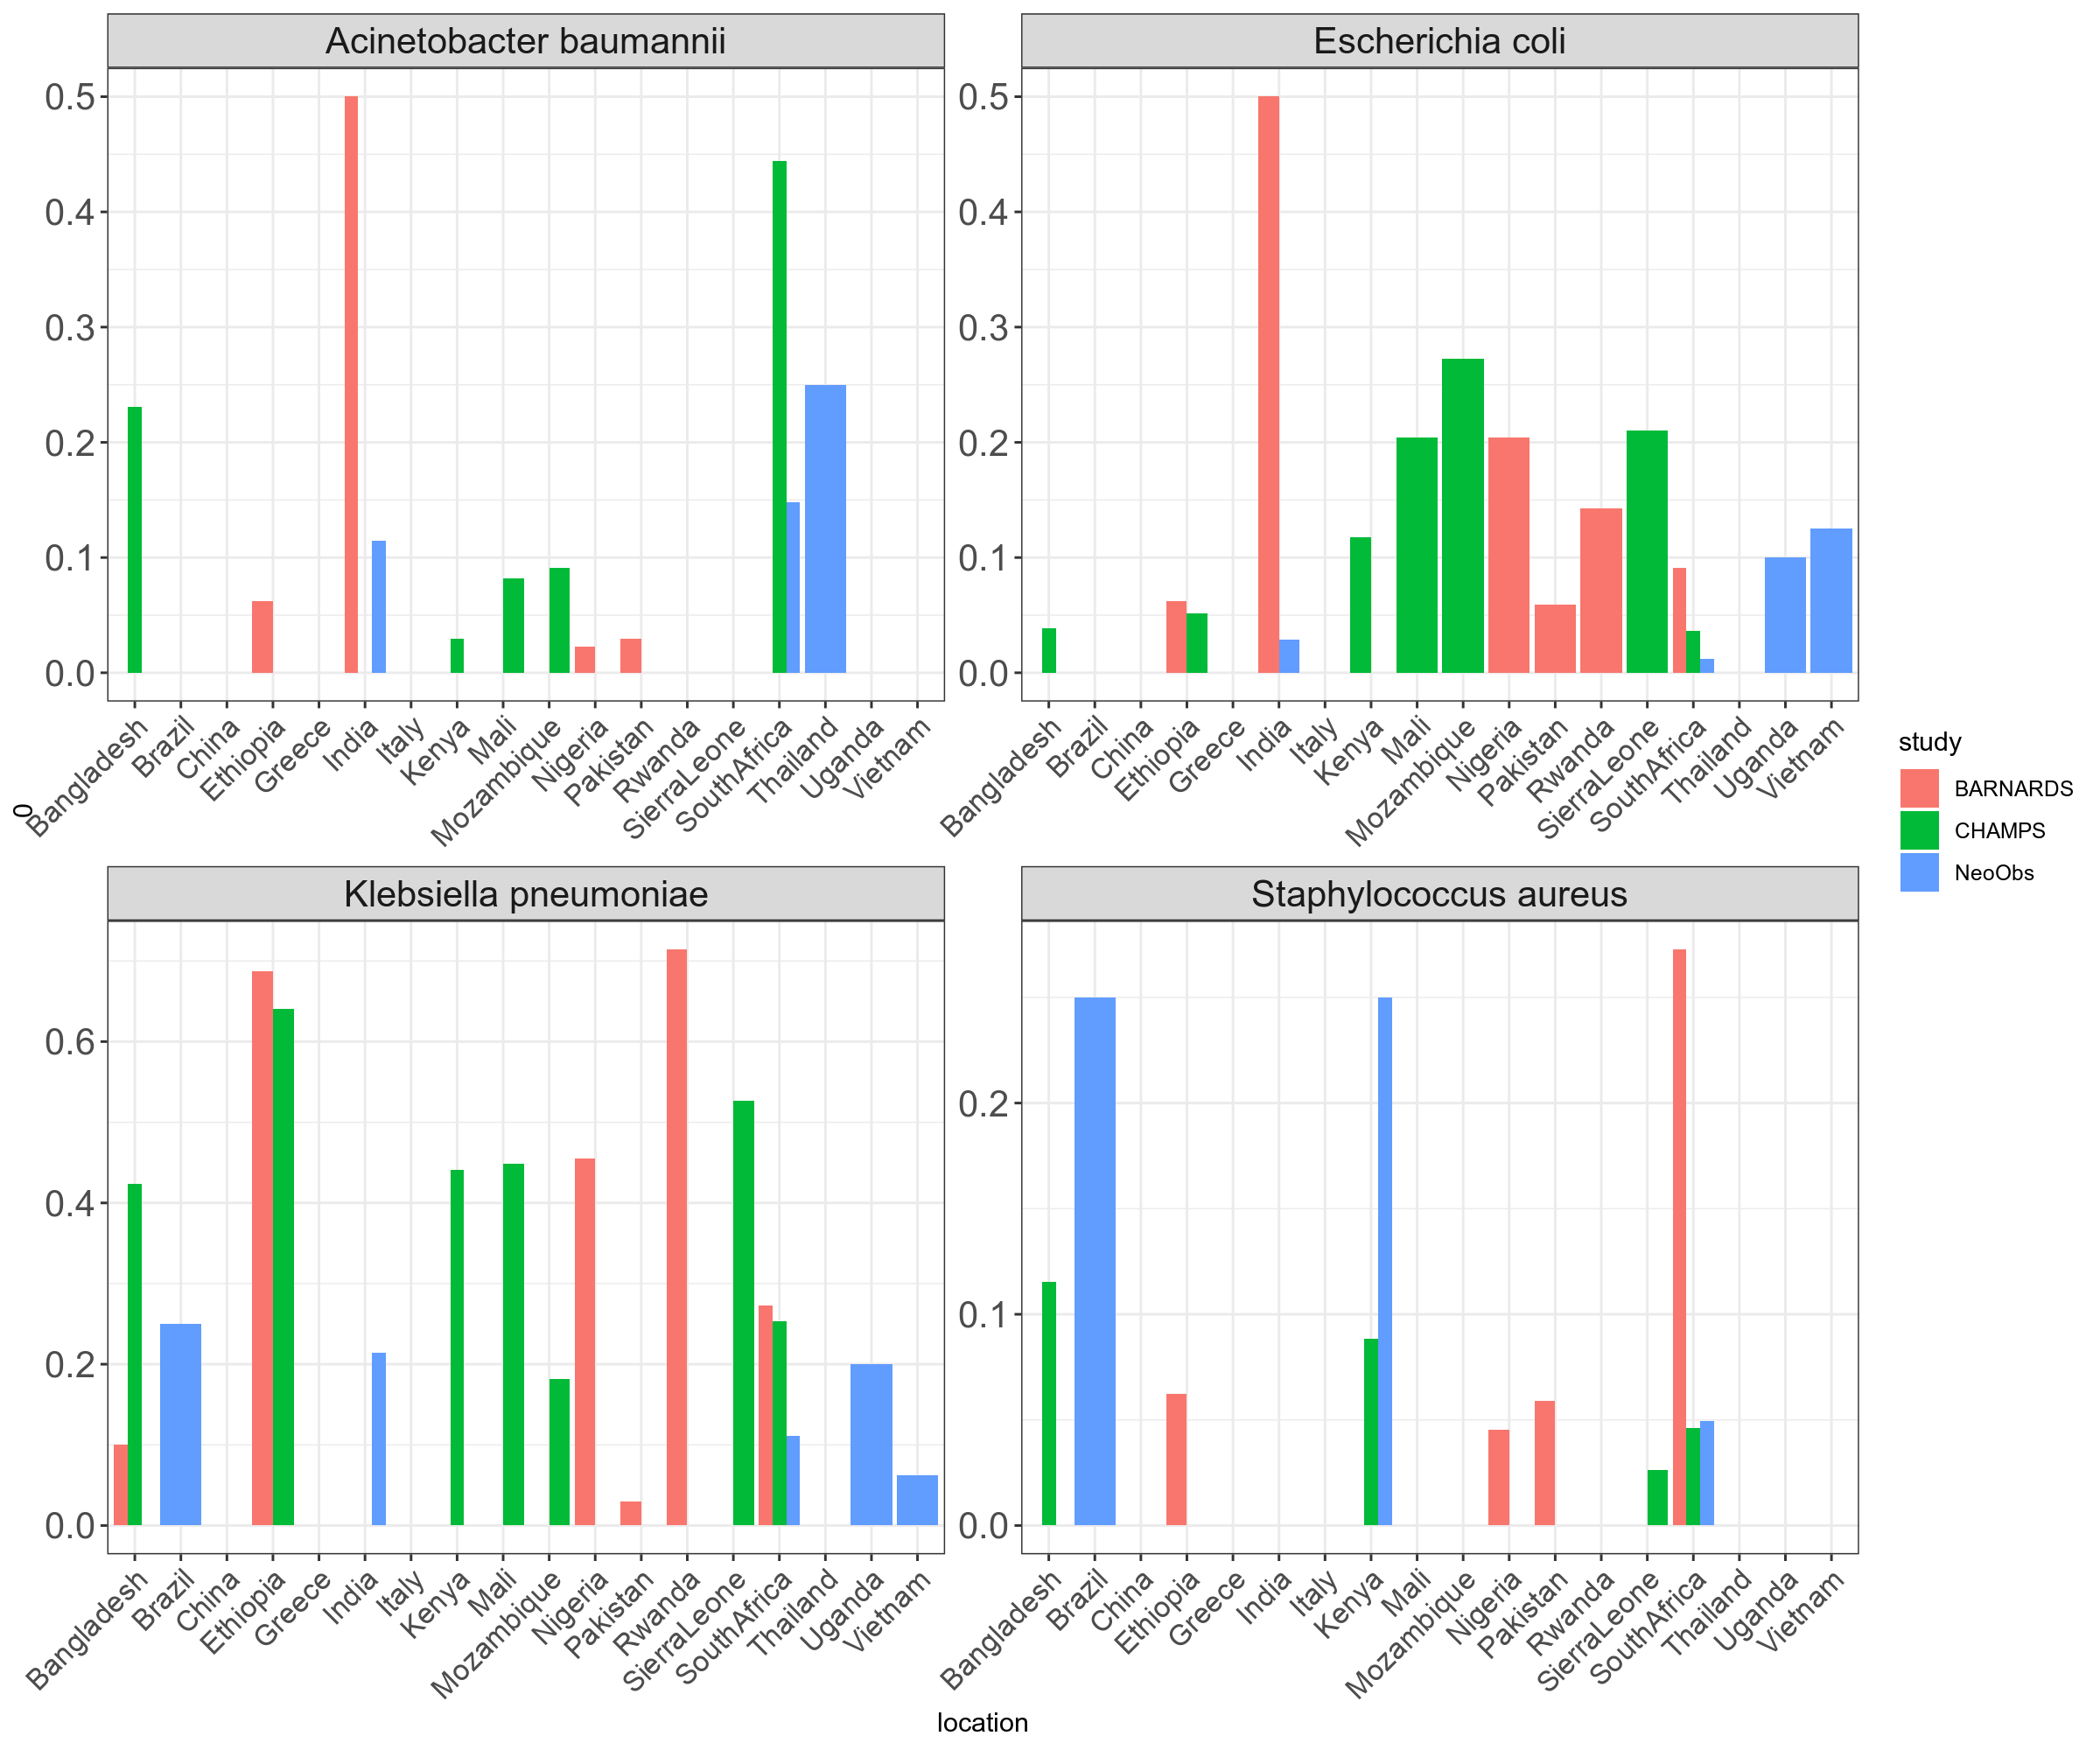

In [137]:
%%R -i comparison_filled_gardp -i out_path -w 12 -h 10 --units in -r 200
positions <- c('Rwanda', 'Nigeria', 'Pakistan', 'India',
               'Bangladesh', 'Ethiopia', 'SouthAfrica',
               'Kenya', 'SierraLeone', 'Mozambique', 'Mali')
ggplot2::ggplot(comparison_filled_gardp) + geom_col(aes(x = location,
                                                  y = `P(Pathogen | Death from Neonatal Sepsis)`,
                                                  fill = study),
                                             position = position_dodge()) + facet_wrap(~pathogen, scales='free') + theme(axis.text.x = element_text(angle = 45,
                                                                                                                                     hjust=1, size = 12),
                                                                                                         axis.text.y = element_text(size = 15),
                                                                                                         strip.text = element_text(size = 15)) + scale_y_continuous(c(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7)) # + geom_vline(xintercept = seq(4.5, 8, by = 3), color="#7CAE00", size=1, alpha=.5)

In [138]:
comparison_filled_aggregate = comparison_filled_gardp.copy(deep = True)

In [139]:
gardp_unwrapped.Country.unique()

array(['Bangladesh', 'Brazil', 'China', 'Greece', 'India', 'Italy',
       'Kenya', 'SouthAfrica', 'Thailand', 'Uganda', 'Vietnam'],
      dtype=object)

In [140]:
comparison_filled_aggregate['WHO region'] = comparison_filled_gardp['location'].map({'India' : 'SEAR',
                                                                               'Bangladesh' : 'SEAR',
                                                                              'Nigeria' : 'AFR',
                                                                              'Ethiopia' : 'AFR',
                                                                              'Rwanda' : 'AFR',
                                                                              'SouthAfrica' : 'AFR',
                                                                              'Kenya' : 'AFR',
                                                                              'Mozambique' : 'AFR',
                                                                              'Mali' : 'AFR',
                                                                              'Pakistan' : 'EMR',
                                                                              'Brazil' : 'AMR',
                                                                              'China' : 'WPR',
                                                                              'Italy' : 'EUR',
                                                                              'Greece' : 'EUR',
                                                                              'Thailand' : 'SEAR',
                                                                              'Uganda' : 'AFR',
                                                                              'Vietnam' : 'WPR'})

In [141]:
comparison_filled_aggregate = comparison_filled_aggregate[['pathogen',
                             'P(Pathogen | Death from Neonatal Sepsis)',
                            'study',
                            'WHO region']].groupby(['pathogen',
                                                    'WHO region',
                                                    'study']).mean().reset_index()

In [142]:
gardp_cases

Country  KlebsiellaP  AcinetobacterBaum  Ecoli  Saureus  OtherPath  \
0    Bangladesh            0                  0      0        0          1   
1        Brazil            1                  0      0        1          0   
2         China            0                  0      0        0          3   
3        Greece            0                  0      0        0          1   
4         India           15                  8      2        0         10   
5         Kenya            0                  0      0        1          1   
6  South Africa            9                 12      1        4         15   
7       Tailand            0                  1      0        0          1   
8        Uganda            2                  0      1        0          2   
9       Vietnam            1                  0      2        0          5   

   Anypathogen  
0            1  
1            2  
2            3  
3            1  
4           35  
5            2  
6           40  
7            2  
8            5  
9            8

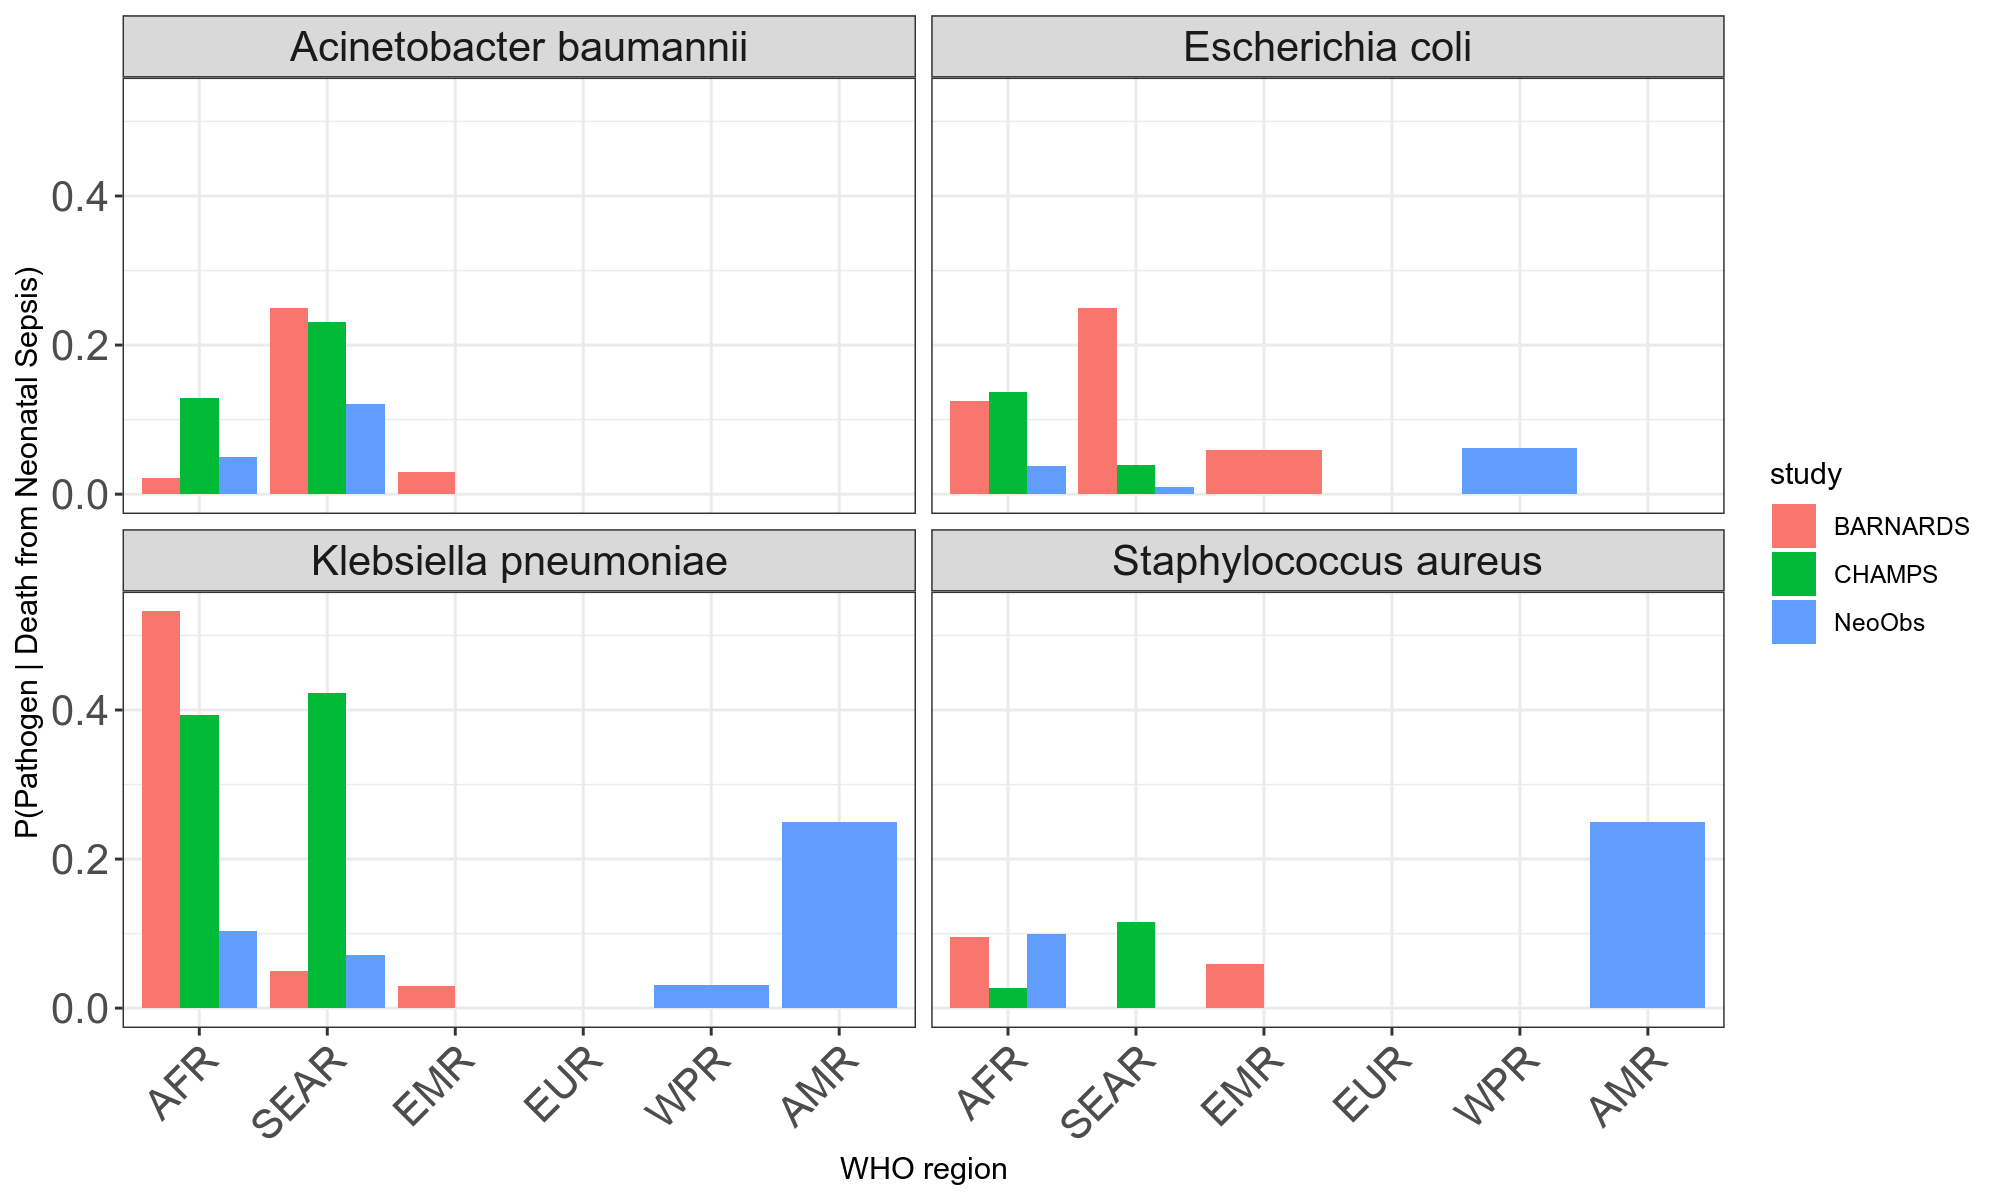

In [143]:
%%R -i comparison_filled_aggregate -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(comparison_filled_aggregate) + geom_col(aes(x = `WHO region`,
                                                  y = `P(Pathogen | Death from Neonatal Sepsis)`,
                                                  fill = study),
                                             position = position_dodge()) + facet_wrap(~pathogen) + theme(axis.text.x = element_text(angle = 45,
                                                                                                                                     hjust=1, size = 15),
                                                                                                          strip.text = element_text(size=15),
                                                                                                         axis.text.y = element_text(size = 15)) + scale_x_discrete(limits = positions) #+ geom_vline(xintercept = seq(4.5, 8, by = 3), color="#7CAE00", size=1, alpha=.5)

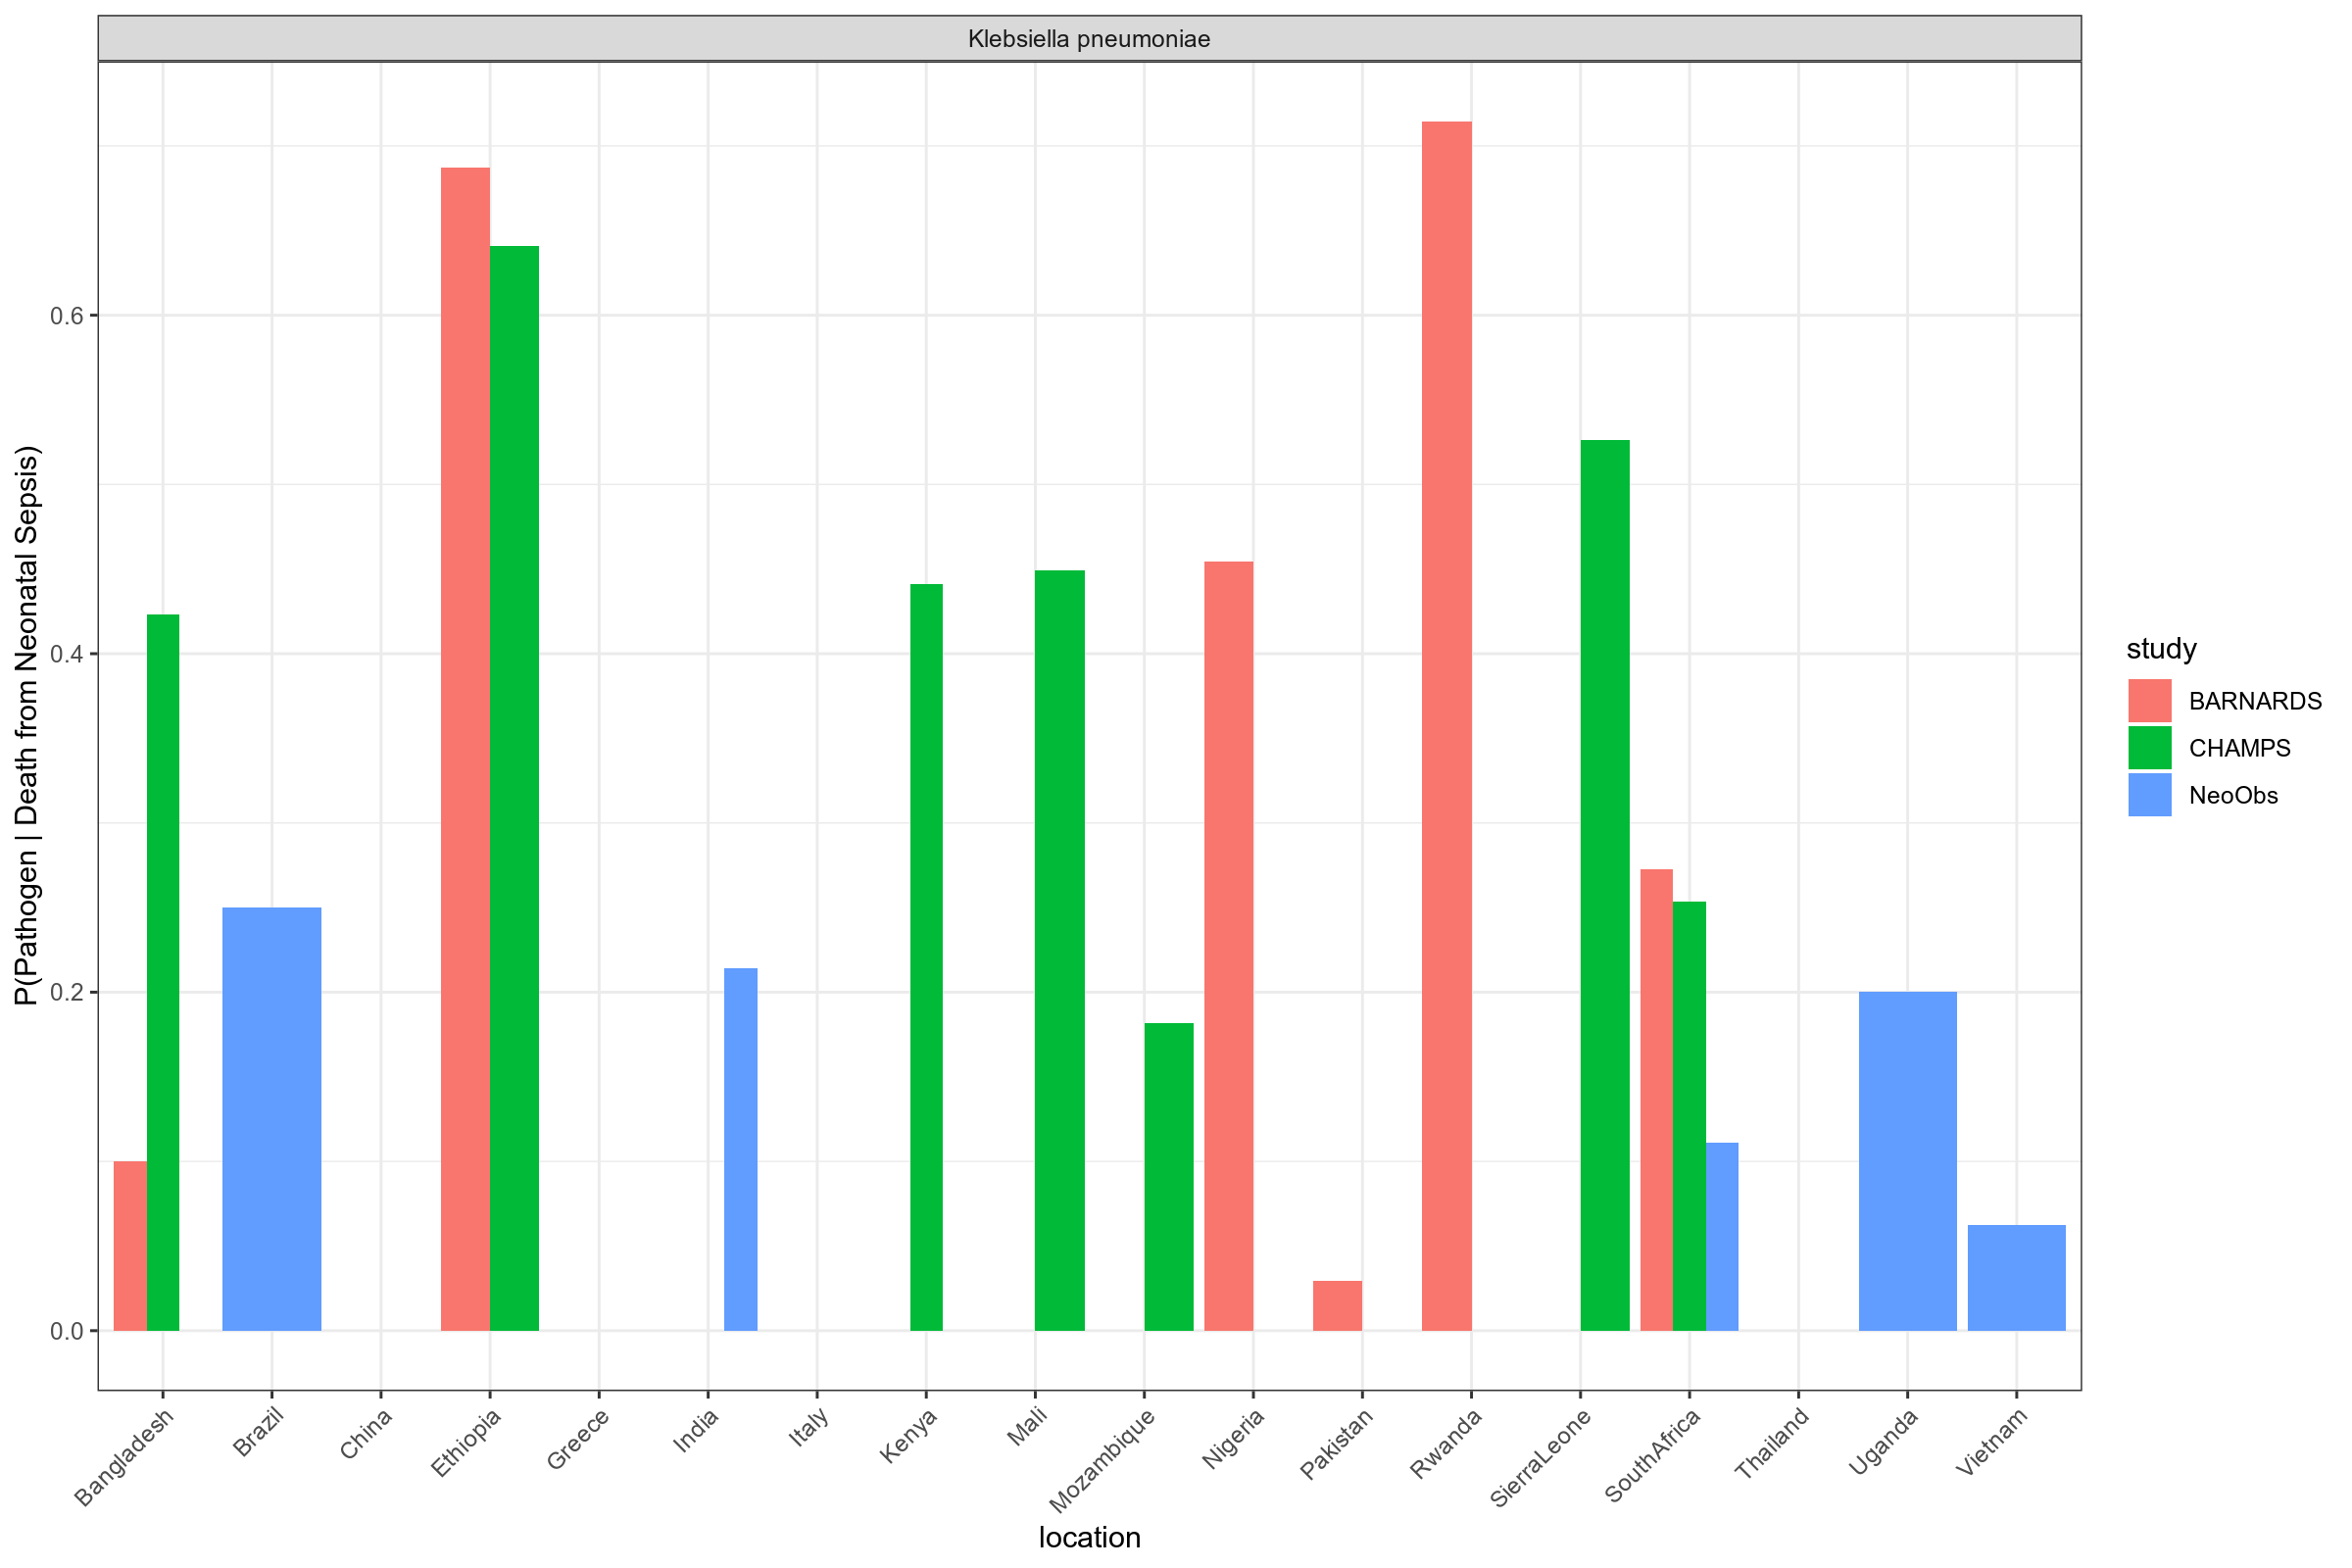

In [144]:
%%R -i comparison_filled_gardp -i out_path -w 12 -h 8 --units in -r 200
comparison_filled = comparison_filled_gardp[comparison_filled_gardp$pathogen == 'Klebsiella pneumoniae', ]

positions <- c('Rwanda', 'Nigeria', 'India', 'Pakistan',
               'Bangladesh', 'Ethiopia', 'SouthAfrica',
               'Kenya', 'SierraLeone', 'Mozambique', 'Mali')
ggplot2::ggplot(comparison_filled) + geom_col(aes(x = location,
                                                  y = `P(Pathogen | Death from Neonatal Sepsis)`,
                                                  fill = study),
                                             position = position_dodge()) + facet_wrap(~pathogen) + theme(axis.text.x = element_text(angle = 45,
                                                                                                                                     hjust=1))# + scale_x_discrete(limits = positions) # + geom_vline(xintercept = seq(4.5, 8, by = 3), color="#7CAE00", size=1, alpha=.5)

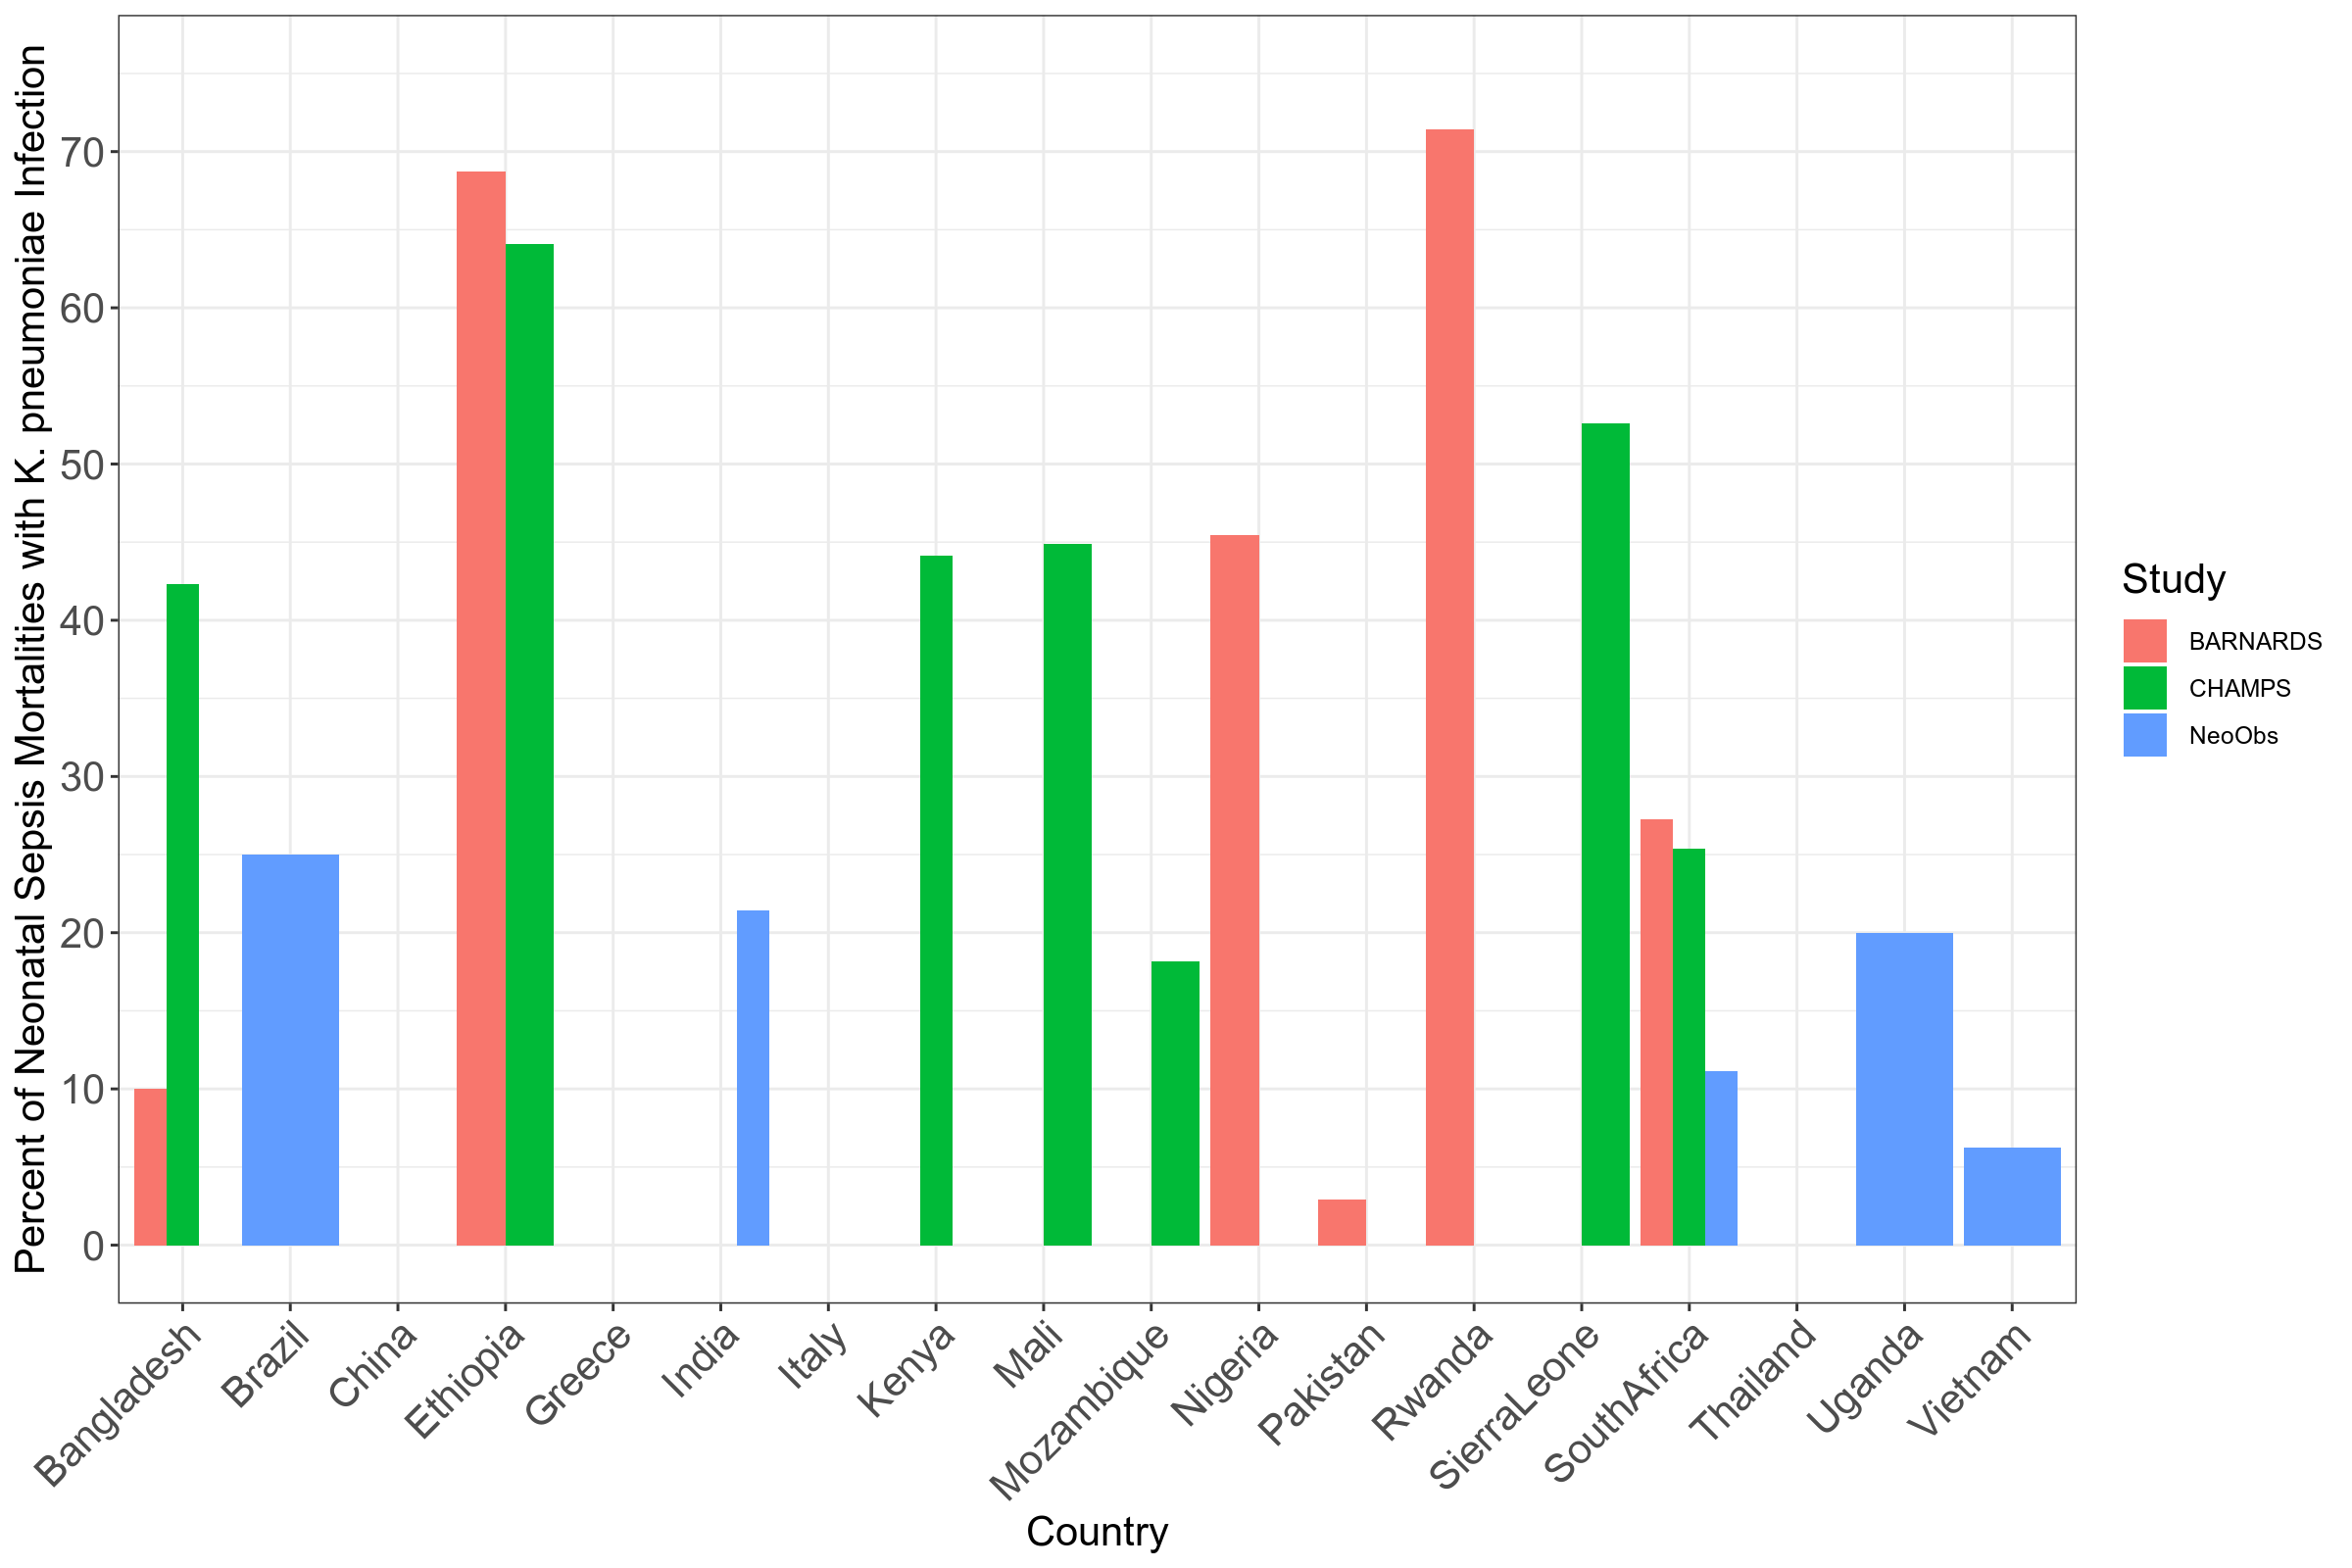

In [145]:
%%R -i comparison_filled_gardp -i out_path -w 12 -h 8 --units in -r 200
comparison_filled = comparison_filled_gardp[comparison_filled_gardp$pathogen == 'Klebsiella pneumoniae', ]

positions <- c('Rwanda', 'Nigeria', 'India', 'Pakistan',
               'Bangladesh', 'Ethiopia', 'SouthAfrica',
               'Kenya', 'SierraLeone', 'Mozambique', 'Mali')
ggplot2::ggplot(comparison_filled) + geom_col(aes(x = location,
                                                  y = `P(Pathogen | Death from Neonatal Sepsis)` * 100,
                                                  fill = study),
                                             position = position_dodge()) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) + xlab('Country') +
                scale_fill_discrete(name = "Study") +
                scale_y_continuous('Percent of Neonatal Sepsis Mortalities with K. pneumoniae Infection',
                                   breaks = seq(0, 80.0, 10.0), label = seq(0, 80.0, 10), limits = c(0, 75.0))

In [146]:
countries = ['Bangladesh', 'Ethiopia', 'India', 'Kenya', 'SierraLeone',
                                            'Mali', 'Mozambique', 'Nigeria', 'Pakistan', 'Rwanda', 'SouthAfrica',
                                             'Brazil', 'China', 'Greece', 'Italy', 'Thailand', 'Uganda', 'Vietnam']

In [147]:
# read IHME data
ihme_whole = pd.read_csv(os.path.join(data_dir, 'IHME-GBD_2019_DATA-bf3658f0-1.csv'))

In [148]:
# let's also read in the CHERG data
cherg_whole = pd.read_excel(os.path.join(data_dir, 'Uncertainty range_cause_country_2000-2015.xlsx'))

In [149]:
cherg_whole

ISO3      Country Region    Year   Age group  \
0      NaN          NaN    NaN     NaN         NaN   
1      AFG  Afghanistan    Emr  2000.0    Neonatal   
2      AFG  Afghanistan    Emr  2000.0    Neonatal   
3      AFG  Afghanistan    Emr  2000.0    Neonatal   
4      AFG  Afghanistan    Emr  2000.0    Neonatal   
...    ...          ...    ...     ...         ...   
83804  ZWE     Zimbabwe    Afr  2015.0  Under five   
83805  ZWE     Zimbabwe    Afr  2015.0  Under five   
83806  ZWE     Zimbabwe    Afr  2015.0  Under five   
83807  ZWE     Zimbabwe    Afr  2015.0  Under five   
83808  ZWE     Zimbabwe    Afr  2015.0  Under five   

                    Cause of death Number of deaths         Unnamed: 7  \
0                              NaN   Point estimate  95%UR Lower bound   
1      Preterm birth complications            12839               4491   
2       Intrapartum-related events            12081               4212   
3         Congenital abnormalities             2024                744   
4                        Diarrhoea              866                208   
...                            ...              ...                ...   
83804     Congenital abnormalities             2914               2016   
83805                    Diarrhoea             3677               1895   
83806            Sepsis/Meningitis             2323               1451   
83807                    Pneumonia             5582               3291   
83808                        Other            14046              10018   

              Unnamed: 8 Mortality rate (per 1,000 livebirths)  \
0      95%UR Upper bound                        Point estimate   
1                  23189                                13.659   
2                  18292                                12.852   
3                   3488                                 2.153   
4                  21035                                 0.921   
...                  ...                                   ...   
83804               5091                                 5.335   
83805               7724                                 6.731   
83806               3703                                 4.254   
83807              10611                                10.219   
83808              24309                                25.715   

             Unnamed: 10        Unnamed: 11  Number of deaths - 1-59 months  \
0      95%UR Lower bound  95%UR Upper bound                             NaN   
1                  4.778              24.67                         89034.0   
2                  4.481              19.46                         89034.0   
3                  0.792               3.71                         89034.0   
4                  0.222             22.378                         89034.0   
...                  ...                ...                             ...   
83804              3.691              9.321                         25251.0   
83805              3.469             14.141                         25251.0   
83806              2.657              6.779                         25251.0   
83807              6.025             19.426                         25251.0   
83808             18.341             44.503                         25251.0   

       Number of deaths - neonatal  Number of livebirths  
0                              NaN                   NaN  
1                          42488.0              939997.0  
2                          42488.0              939997.0  
3                          42488.0              939997.0  
4                          42488.0              939997.0  
...                            ...                   ...  
83804                      12836.0              546217.0  
83805                      12836.0              546217.0  
83806                      12836.0              546217.0  
83807                      12836.0              546217.0  
83808                      12836.0              546217.0  

[83809 rows x 15 

In [150]:
cherg_whole = cherg_whole[cherg_whole['Age group'] == 'Neonatal']

In [151]:
# let's isolate just the variables of interest from cherg
cherg_whole.columns = ['ISO3', 'Country', 'Region', 'Year', 'Age', 'COD',
                       'num_val', 'num_lower', 'num_upper', '-', '-', '-', '-', 'deaths_overall', '-']

In [152]:
cherg_whole = cherg_whole[['ISO3', 'Country', 'Year', 'Age', 'COD', 'num_val', 'num_lower', 'num_upper',
                          'deaths_overall']]

In [153]:
cherg_whole = cherg_whole[cherg_whole.Age == 'Neonatal'][cherg_whole.Year >= 2012]

In [154]:
cherg_whole['num_val'] = cherg_whole['num_val'].astype(np.float64)
cherg_whole['num_lower'] = cherg_whole['num_lower'].astype(np.float64)
cherg_whole['num_upper'] = cherg_whole['num_upper'].astype(np.float64)

In [155]:
cherg_whole = cherg_whole.groupby(['ISO3', 'Country', 'COD']).mean().reset_index()

In [156]:
cherg_whole.COD.unique()

array(['Congenital abnormalities', 'Diarrhoea',
       'Intrapartum-related events', 'Other', 'Pneumonia',
       'Preterm birth complications', 'Sepsis/Meningitis', 'Tetanus'],
      dtype=object)

In [157]:
cherg_whole = cherg_whole[cherg_whole.COD.isin(['Sepsis/Meningitis', 'Pneumonia'])]

In [158]:
cherg_whole = cherg_whole.groupby(['Country']).sum().reset_index()[['Country', 'num_val', 'num_lower', 'num_upper',
                                                      'deaths_overall']]

In [159]:
cherg_whole.columns = ['Country', 'cherg_val', 'cherg_lower', 'cherg_upper', 'cherg_deaths_overall']

In [160]:
def country_ihme_mapping(x):
    if x == 'Viet Nam':
        return 'Vietnam'
    elif x == 'Sierra Leone':
        return 'SierraLeone'
    elif x == 'South Africa':
        return 'SouthAfrica'
    else:
        return x

In [161]:
ihme_whole.location = ihme_whole.location.map(country_ihme_mapping)

In [162]:
cherg_whole.Country = cherg_whole.Country.map(country_ihme_mapping)

In [163]:
# need to get the country names here to match the country names in IHME
cherg_whole.loc[cherg_whole.Country == "Cote d'Ivoire", 'Country'] = "Côte d'Ivoire"
cherg_whole.loc[cherg_whole.Country == "The former Yugoslav Republic of Macedonia", 'Country'] = "North Macedonia"
cherg_whole.loc[cherg_whole.Country == "Czech Republic", 'Country'] = "Czechia"
cherg_whole.loc[cherg_whole.Country == "Swaziland", 'Country'] = "Eswatini"

In [164]:
cherg_whole[cherg_whole.Country == "Swaziland"].Country

Series([], Name: Country, dtype: object)

In [165]:
cherg_whole[cherg_whole.Country == "Eswatini"].Country

165    Eswatini
Name: Country, dtype: object

In [166]:
ihme_whole = cherg_whole.merge(ihme_whole, left_on = 'Country', right_on = 'location', how = 'left')

In [167]:
ihme_whole

Country  cherg_val  cherg_lower  cherg_upper  cherg_deaths_overall  \
0      Afghanistan    9396.50      3581.75      16675.5               75565.5   
1      Afghanistan    9396.50      3581.75      16675.5               75565.5   
2      Afghanistan    9396.50      3581.75      16675.5               75565.5   
3      Afghanistan    9396.50      3581.75      16675.5               75565.5   
4      Afghanistan    9396.50      3581.75      16675.5               75565.5   
...            ...        ...          ...          ...                   ...   
11695     Zimbabwe    2717.75      1524.25       4454.0               25925.0   
11696     Zimbabwe    2717.75      1524.25       4454.0               25925.0   
11697     Zimbabwe    2717.75      1524.25       4454.0               25925.0   
11698     Zimbabwe    2717.75      1524.25       4454.0               25925.0   
11699     Zimbabwe    2717.75      1524.25       4454.0               25925.0   

          measure     location   sex       age  \
0          Deaths  Afghanistan  Both  Neonatal   
1          Deaths  Afghanistan  Both  Neonatal   
2          Deaths  Afghanistan  Both  Neonatal   
3          Deaths  Afghanistan  Both  Neonatal   
4          Deaths  Afghanistan  Both  Neonatal   
...           ...          ...   ...       ...   
11695  Prevalence     Zimbabwe  Both  Neonatal   
11696  Prevalence     Zimbabwe  Both  Neonatal   
11697  Prevalence     Zimbabwe  Both  Neonatal   
11698  Prevalence     Zimbabwe  Both  Neonatal   
11699  Prevalence     Zimbabwe  Both  Neonatal   

                                               cause  metric  year  \
0                                         All causes  Number  2010   
1      Neonatal sepsis and other neonatal infections  Number  2010   
2      Neonatal sepsis and other neonatal infections  Number  2011   
3                                         All causes  Number  2013   
4                                         All causes  Number  2012   
...                                              ...     ...   ...   
11695  Neonatal sepsis and other neonatal infections  Number  2017   
11696                                     All causes  Number  2018   
11697                                     All causes  Number  2019   
11698  Neonatal sepsis and other neonatal infections  Number  2018   
11699  Neonatal sepsis and other neonatal infections  Number  2019   

                val         upper         lower  
0      35577.618043  40596.687653  31178.194641  
1        857.605706   1506.861394    430.751490  
2        884.502148   1523.648262    446.792386  
3      35441.046644  41774.243109  29989.176099  
4      35512.378001  41837.290961  30138.666947  
...             ...           ...           ...  
11695    238.697572    287.271000    193.664665  
11696  26641.168136  27300.636524  26012.810281  
11697  26755.914184  27431.595700  26110.536648  
11698    240.175119    291.405820    195.712487  
11699    247.800758    302.794109    200.073310  

[11700 rows x 15 columns]

In [168]:
ihme = ihme_whole[ihme_whole.location.isin(countries)]

In [169]:
# let's think about this...
ihme = ihme[ihme.year.isin([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

In [170]:
ihme = ihme[ihme.measure.isin(['Deaths', 'Prevalence'])]

In [171]:
ihme

Country  cherg_val  cherg_lower  cherg_upper  cherg_deaths_overall  \
782    Bangladesh   20599.75     13518.00     29689.25              157111.0   
785    Bangladesh   20599.75     13518.00     29689.25              157111.0   
786    Bangladesh   20599.75     13518.00     29689.25              157111.0   
787    Bangladesh   20599.75     13518.00     29689.25              157111.0   
788    Bangladesh   20599.75     13518.00     29689.25              157111.0   
...           ...        ...          ...          ...                   ...   
11515     Vietnam    3077.50      1939.75      4522.75               37398.0   
11516     Vietnam    3077.50      1939.75      4522.75               37398.0   
11517     Vietnam    3077.50      1939.75      4522.75               37398.0   
11518     Vietnam    3077.50      1939.75      4522.75               37398.0   
11519     Vietnam    3077.50      1939.75      4522.75               37398.0   

          measure    location   sex       age  \
782        Deaths  Bangladesh  Both  Neonatal   
785        Deaths  Bangladesh  Both  Neonatal   
786        Deaths  Bangladesh  Both  Neonatal   
787        Deaths  Bangladesh  Both  Neonatal   
788        Deaths  Bangladesh  Both  Neonatal   
...           ...         ...   ...       ...   
11515  Prevalence     Vietnam  Both  Neonatal   
11516  Prevalence     Vietnam  Both  Neonatal   
11517  Prevalence     Vietnam  Both  Neonatal   
11518  Prevalence     Vietnam  Both  Neonatal   
11519  Prevalence     Vietnam  Both  Neonatal   

                                               cause  metric  year  \
782                                       All causes  Number  2012   
785    Neonatal sepsis and other neonatal infections  Number  2014   
786    Neonatal sepsis and other neonatal infections  Number  2012   
787                                       All causes  Number  2013   
788    Neonatal sepsis and other neonatal infections  Number  2013   
...                                              ...     ...   ...   
11515  Neonatal sepsis and other neonatal infections  Number  2017   
11516                                     All causes  Number  2018   
11517  Neonatal sepsis and other neonatal infections  Number  2018   
11518                                     All causes  Number  2019   
11519  Neonatal sepsis and other neonatal infections  Number  2019   

                val          upper         lower  
782    84618.464965  102337.268817  67823.060735  
785     7721.242502   11730.081596   4539.059505  
786     8513.314933   13308.305405   4936.518423  
787    79475.253528   96277.668160  62975.880748  
788     8138.190160   12645.419777   4701.309100  
...             ...            ...           ...  
11515   1802.940870    2165.869119   1454.697030  
11516  77485.195625   79756.788267  74591.798093  
11517   1746.063427    2103.194363   1405.957852  
11518  75614.163266   77886.965147  72739.043778  
11519   1715.107608    2088.771201   1376.650451  

[576 rows x 15 columns]

In [172]:
ihme = ihme[['measure', 'location', 'cause', 'year', 'val', 'upper', 'lower',
             'cherg_val', 'cherg_lower', 'cherg_upper', 'cherg_deaths_overall']]

In [173]:
ihme

measure    location                                          cause  \
782        Deaths  Bangladesh                                     All causes   
785        Deaths  Bangladesh  Neonatal sepsis and other neonatal infections   
786        Deaths  Bangladesh  Neonatal sepsis and other neonatal infections   
787        Deaths  Bangladesh                                     All causes   
788        Deaths  Bangladesh  Neonatal sepsis and other neonatal infections   
...           ...         ...                                            ...   
11515  Prevalence     Vietnam  Neonatal sepsis and other neonatal infections   
11516  Prevalence     Vietnam                                     All causes   
11517  Prevalence     Vietnam  Neonatal sepsis and other neonatal infections   
11518  Prevalence     Vietnam                                     All causes   
11519  Prevalence     Vietnam  Neonatal sepsis and other neonatal infections   

       year           val          upper         lower  cherg_val  \
782    2012  84618.464965  102337.268817  67823.060735   20599.75   
785    2014   7721.242502   11730.081596   4539.059505   20599.75   
786    2012   8513.314933   13308.305405   4936.518423   20599.75   
787    2013  79475.253528   96277.668160  62975.880748   20599.75   
788    2013   8138.190160   12645.419777   4701.309100   20599.75   
...     ...           ...            ...           ...        ...   
11515  2017   1802.940870    2165.869119   1454.697030    3077.50   
11516  2018  77485.195625   79756.788267  74591.798093    3077.50   
11517  2018   1746.063427    2103.194363   1405.957852    3077.50   
11518  2019  75614.163266   77886.965147  72739.043778    3077.50   
11519  2019   1715.107608    2088.771201   1376.650451    3077.50   

       cherg_lower  cherg_upper  cherg_deaths_overall  
782       13518.00     29689.25              157111.0  
785       13518.00     29689.25              157111.0  
786       13518.00     29689.25              157111.0  
787       13518.00     29689.25              157111.0  
788       13518.00     29689.25              157111.0  
...            ...          ...                   ...  
11515      1939.75      4522.75               37398.0  
11516      1939.75      4522.75               37398.0  
11517      1939.75      4522.75               37398.0  
11518      1939.75      4522.75               37398.0  
11519      1939.75      4522.75               37398.0  

[576 rows x 11 columns]

In [174]:
ihme['cherg_val'] = ihme['cherg_val'].astype(np.float64)
ihme['cherg_lower'] = ihme['cherg_lower'].astype(np.float64)
ihme['cherg_upper'] = ihme['cherg_upper'].astype(np.float64)
ihme['cherg_deaths_overall'] = ihme['cherg_deaths_overall'].astype(np.float64)

.:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
.:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
.:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
.:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [175]:
ihme = ihme.groupby(['measure', 'location', 'cause']).mean().reset_index()

In [176]:
ihme

measure    location                                          cause  \
0       Deaths  Bangladesh                                     All causes   
1       Deaths  Bangladesh  Neonatal sepsis and other neonatal infections   
2       Deaths      Brazil                                     All causes   
3       Deaths      Brazil  Neonatal sepsis and other neonatal infections   
4       Deaths       China                                     All causes   
..         ...         ...                                            ...   
67  Prevalence    Thailand  Neonatal sepsis and other neonatal infections   
68  Prevalence      Uganda                                     All causes   
69  Prevalence      Uganda  Neonatal sepsis and other neonatal infections   
70  Prevalence     Vietnam                                     All causes   
71  Prevalence     Vietnam  Neonatal sepsis and other neonatal infections   

      year           val         upper         lower  cherg_val  cherg_lower  \
0   2015.5  68118.887832  84425.312947  53129.083791   20599.75     13518.00   
1   2015.5   7185.894090  11104.533795   4200.493159   20599.75     13518.00   
2   2015.5  38230.143670  45903.437978  31250.552373    4989.25      4694.75   
3   2015.5   4545.737926   5506.653513   3697.011383    4989.25      4694.75   
4   2015.5  76603.941889  85614.500367  68476.534233    9347.75      8889.50   
..     ...           ...           ...           ...        ...          ...   
67  2015.5   1221.263277   1432.545073   1042.121925     578.50       247.25   
68  2015.5  93274.860702  95247.777960  91212.288339    7406.75      4308.00   
69  2015.5   1341.101964   1628.565804   1095.157335    7406.75      4308.00   
70  2015.5  84026.911842  86369.561400  81238.231226    3077.50      1939.75   
71  2015.5   1904.560688   2304.600409   1550.754624    3077.50      1939.75   

    cherg_upper  cherg_deaths_overall  
0      29689.25              157111.0  
1      29689.25              157111.0  
2       5354.25               61154.5  
3       5354.25               61154.5  
4      11359.50              205993.0  
..          ...                   ...  
67      1190.00               10789.5  
68     12181.25               59952.5  
69     12181.25               59952.5  
70      4522.75               37398.0  
71      4522.75               37398.0  

[72 rows x 11 columns]

In [177]:
deaths_overall = ihme[ihme['measure'] == 'Deaths'][ihme['cause'] == 'All causes']

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [178]:
deaths_overall

measure     location       cause    year            val          upper  \
0   Deaths   Bangladesh  All causes  2015.5   68118.887832   84425.312947   
2   Deaths       Brazil  All causes  2015.5   38230.143670   45903.437978   
4   Deaths        China  All causes  2015.5   76603.941889   85614.500367   
6   Deaths     Ethiopia  All causes  2015.5  108611.744340  133670.682977   
8   Deaths       Greece  All causes  2015.5     222.831982     251.125021   
10  Deaths        India  All causes  2015.5  682772.748920  806456.465041   
12  Deaths        Italy  All causes  2015.5     948.202153    1027.576563   
14  Deaths        Kenya  All causes  2015.5   27969.405356   33783.901808   
16  Deaths         Mali  All causes  2015.5   36444.737929   44419.525997   
18  Deaths   Mozambique  All causes  2015.5   30194.876987   36120.805885   
20  Deaths      Nigeria  All causes  2015.5  289385.597715  348488.780231   
22  Deaths     Pakistan  All causes  2015.5  300846.221464  363552.253900   
24  Deaths       Rwanda  All causes  2015.5    7566.012912    9130.617466   
26  Deaths  SierraLeone  All causes  2015.5    8386.663211   10352.430820   
28  Deaths  SouthAfrica  All causes  2015.5   23931.398307   30310.958854   
30  Deaths     Thailand  All causes  2015.5    2679.920945    3167.652265   
32  Deaths       Uganda  All causes  2015.5   43075.536579   50870.309185   
34  Deaths      Vietnam  All causes  2015.5   11906.932416   14959.767460   

            lower  cherg_val  cherg_lower  cherg_upper  cherg_deaths_overall  
0    53129.083791   20599.75     13518.00     29689.25              157111.0  
2    31250.552373    4989.25      4694.75      5354.25               61154.5  
4    68476.534233    9347.75      8889.50     11359.50              205993.0  
6    87308.671522   24445.00     13315.50     38257.25              179263.0  
8      196.935100       3.50         0.00         7.25                 660.0  
10  572507.664385  143741.00     93639.75    207884.50             1481443.0  
12     869.579293      67.25        49.50        86.25                2159.5  
14   22650.392219    7959.25      4449.50     12083.25               69515.0  
16   29608.713726    8087.00      3895.50     14018.50               55532.5  
18   25224.324264    7960.00      4755.75     11901.50               58136.0  
20  241151.351088   55905.00     34039.25     84029.50              481716.0  
22  244512.262272   59351.75     37239.50     93694.50              506320.5  
24    6165.150644    1705.00       969.75      2688.75               13954.5  
26    6792.520811    2266.50      1342.75      3428.75               15934.0  
28   18825.728460    2459.25      1707.50      3418.00               24184.5  
30    2230.245665     578.50       247.25      1190.00               10789.5  
32   36498.692481    7406.75      4308.00     12181.25               59952.5  
34    9516.228026    3077.50      1939.75      4522.75               37398.0

In [179]:
neonatal_sepsis = pd.DataFrame(deaths_overall.location)

In [180]:
neonatal_sepsis['deaths_overall_val'] = deaths_overall.val
neonatal_sepsis['deaths_overall_upper'] = deaths_overall.upper
neonatal_sepsis['deaths_overall_lower'] = deaths_overall.lower
neonatal_sepsis['deaths_overall_cherg'] = deaths_overall.cherg_deaths_overall

In [181]:
neonatal_sepsis

location  deaths_overall_val  deaths_overall_upper  \
0    Bangladesh        68118.887832          84425.312947   
2        Brazil        38230.143670          45903.437978   
4         China        76603.941889          85614.500367   
6      Ethiopia       108611.744340         133670.682977   
8        Greece          222.831982            251.125021   
10        India       682772.748920         806456.465041   
12        Italy          948.202153           1027.576563   
14        Kenya        27969.405356          33783.901808   
16         Mali        36444.737929          44419.525997   
18   Mozambique        30194.876987          36120.805885   
20      Nigeria       289385.597715         348488.780231   
22     Pakistan       300846.221464         363552.253900   
24       Rwanda         7566.012912           9130.617466   
26  SierraLeone         8386.663211          10352.430820   
28  SouthAfrica        23931.398307          30310.958854   
30     Thailand         2679.920945           3167.652265   
32       Uganda        43075.536579          50870.309185   
34      Vietnam        11906.932416          14959.767460   

    deaths_overall_lower  deaths_overall_cherg  
0           53129.083791              157111.0  
2           31250.552373               61154.5  
4           68476.534233              205993.0  
6           87308.671522              179263.0  
8             196.935100                 660.0  
10         572507.664385             1481443.0  
12            869.579293                2159.5  
14          22650.392219               69515.0  
16          29608.713726               55532.5  
18          25224.324264               58136.0  
20         241151.351088              481716.0  
22         244512.262272              506320.5  
24           6165.150644               13954.5  
26           6792.520811               15934.0  
28          18825.728460               24184.5  
30           2230.245665               10789.5  
32          36498.692481               59952.5  
34           9516.228026               37398.0

In [182]:
# neonatal sepsis deaths
neonatal_sepsis['deaths_ns_val'] = ihme[ihme['measure'] == 'Deaths'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].val.values
neonatal_sepsis['deaths_ns_upper'] = ihme[ihme['measure'] == 'Deaths'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].upper.values
neonatal_sepsis['deaths_ns_lower'] = ihme[ihme['measure'] == 'Deaths'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].lower.values

.:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [183]:
neonatal_sepsis['deaths_ns_cherg_val'] = ihme[ihme['measure'] == 'Deaths'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].cherg_val.values
neonatal_sepsis['deaths_ns_cherg_upper'] = ihme[ihme['measure'] == 'Deaths'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].cherg_upper.values
neonatal_sepsis['deaths_ns_cherg_lower'] = ihme[ihme['measure'] == 'Deaths'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].cherg_lower.values

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [184]:
champs_frame = champs_total[champs_total.age_months < 1][champs_total.age_years < 1][champs_total.age_days <= 28]

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [185]:
# neonatal sepsis cases
# and, by some poor naming, it turns out that prevalence as a number is the number of cases
neonatal_sepsis['cases_ns_val'] = ihme[ihme['measure'] == 'Prevalence'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].val.values
neonatal_sepsis['cases_ns_upper'] = ihme[ihme['measure'] == 'Prevalence'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].upper.values
neonatal_sepsis['cases_ns_lower'] = ihme[ihme['measure'] == 'Prevalence'][ihme['cause'] == 'Neonatal sepsis and other neonatal infections'].lower.values

.:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [186]:
neonatal_sepsis

location  deaths_overall_val  deaths_overall_upper  \
0    Bangladesh        68118.887832          84425.312947   
2        Brazil        38230.143670          45903.437978   
4         China        76603.941889          85614.500367   
6      Ethiopia       108611.744340         133670.682977   
8        Greece          222.831982            251.125021   
10        India       682772.748920         806456.465041   
12        Italy          948.202153           1027.576563   
14        Kenya        27969.405356          33783.901808   
16         Mali        36444.737929          44419.525997   
18   Mozambique        30194.876987          36120.805885   
20      Nigeria       289385.597715         348488.780231   
22     Pakistan       300846.221464         363552.253900   
24       Rwanda         7566.012912           9130.617466   
26  SierraLeone         8386.663211          10352.430820   
28  SouthAfrica        23931.398307          30310.958854   
30     Thailand         2679.920945           3167.652265   
32       Uganda        43075.536579          50870.309185   
34      Vietnam        11906.932416          14959.767460   

    deaths_overall_lower  deaths_overall_cherg  deaths_ns_val  \
0           53129.083791              157111.0    7185.894090   
2           31250.552373               61154.5    4545.737926   
4           68476.534233              205993.0    1540.636872   
6           87308.671522              179263.0   14078.420355   
8             196.935100                 660.0       1.761596   
10         572507.664385             1481443.0   38551.254439   
12            869.579293                2159.5      57.296058   
14          22650.392219               69515.0    3309.024724   
16          29608.713726               55532.5    5660.528189   
18          25224.324264               58136.0    4581.387013   
20         241151.351088              481716.0   26782.007024   
22         244512.262272              506320.5   10779.854630   
24           6165.150644               13954.5     979.696828   
26           6792.520811               15934.0    1088.041915   
28          18825.728460               24184.5    1932.619622   
30           2230.245665               10789.5     494.805834   
32          36498.692481               59952.5    4394.091810   
34           9516.228026               37398.0    2036.818226   

    deaths_ns_upper  deaths_ns_lower  deaths_ns_cherg_val  \
0      11104.533795      4200.493159             20599.75   
2       5506.653513      3697.011383              4989.25   
4       1773.846326      1331.847507              9347.75   
6      19669.453109      9063.113498             24445.00   
8          2.407179         1.267975                 3.50   
10     48749.195587     30577.810811            143741.00   
12        64.589837        49.044521                67.25   
14      4202.483637      2564.588529              7959.25   
16      8485.495682      3633.961917              8087.00   
18      6696.712521      3013.241112              7960.00   
20     36255.505256     19497.179148             55905.00   
22     14600.870345      7822.606162             59351.75   
24      1482.257708       615.549816              1705.00   
26      1677.680288       671.758897              2266.50   
28      2527.108291      1466.932258              2459.25   
30       631.221989       381.869219               578.50   
32      6588.457556      2771.995242              7406.75   
34      3119.178369      1246.600290              3077.50   

    deaths_ns_cherg_upper  deaths_ns_cherg_lower  cases_ns_val  \
0                29689.25               13518.00   5482.093945   
2                 5354.25                4694.75   3202.757699   
4                11359.50                8889.50  22476.814151   
6                38257.25               13315.50   3372.982249   
8                    7.25                   0.00      9.546221   
10              207884.50               93639.75  11103

In [187]:
# finally let's add the vaccination coverage rates
neonatal_sepsis['maternal_vaccine_who'] = 0.70 # WHO estimate is for vaccine to have 70% coverage
# i get this estimate from the percent of newborns who are protected at birth

# https://www.cdc.gov/mmwr/volumes/71/wr/pdfs/mm7111a2-H.pdf

# tdap vaccine coverage in brazil
# Pertussis epidemiological pattern and disease burden in Brazil: an analysis of national public health surveillance data
# Impact of maternal dTpa vaccination on the incidence of pertussis in young infants
# something on the order of 50%

# china -- oh boy this is a tough story
# seems to be on the order of ~38.5%?!?!?!?!
# The maternal antibody against diphtheria, tetanus and pertussis showed distinct regional difference in China
# Review of the status and challenges associated with increasing influenza vaccination coverage among pregnant women in China

# greece -- 100%: https://www.who.int/immunization/monitoring_surveillance/data/grc.pdf

# italy: https://www.who.int/immunization/monitoring_surveillance/data/ita.pdf

# thailand: https://www.who.int/immunization/monitoring_surveillance/data/tha.pdf
# Maternal immunization: trends in South and Southeast Asian countries

neonatal_sepsis['maternal_vaccine_tetanus_ss'] = [0.98, 0.50, 0.385, 0.9, 1.0, 0.90, 0.98, 0.88, 0.87, 0.86,
                                                 0.65, 0.85, 0.97, 0.93, 0.90, 0.96, 0.83, 0.96]

In [188]:
cherg_whole[cherg_whole.Country == 'SouthAfrica']

Country  cherg_val  cherg_lower  cherg_upper  cherg_deaths_overall
159  SouthAfrica    2459.25       1707.5       3418.0               24184.5

In [189]:
neonatal_sepsis

location  deaths_overall_val  deaths_overall_upper  \
0    Bangladesh        68118.887832          84425.312947   
2        Brazil        38230.143670          45903.437978   
4         China        76603.941889          85614.500367   
6      Ethiopia       108611.744340         133670.682977   
8        Greece          222.831982            251.125021   
10        India       682772.748920         806456.465041   
12        Italy          948.202153           1027.576563   
14        Kenya        27969.405356          33783.901808   
16         Mali        36444.737929          44419.525997   
18   Mozambique        30194.876987          36120.805885   
20      Nigeria       289385.597715         348488.780231   
22     Pakistan       300846.221464         363552.253900   
24       Rwanda         7566.012912           9130.617466   
26  SierraLeone         8386.663211          10352.430820   
28  SouthAfrica        23931.398307          30310.958854   
30     Thailand         2679.920945           3167.652265   
32       Uganda        43075.536579          50870.309185   
34      Vietnam        11906.932416          14959.767460   

    deaths_overall_lower  deaths_overall_cherg  deaths_ns_val  \
0           53129.083791              157111.0    7185.894090   
2           31250.552373               61154.5    4545.737926   
4           68476.534233              205993.0    1540.636872   
6           87308.671522              179263.0   14078.420355   
8             196.935100                 660.0       1.761596   
10         572507.664385             1481443.0   38551.254439   
12            869.579293                2159.5      57.296058   
14          22650.392219               69515.0    3309.024724   
16          29608.713726               55532.5    5660.528189   
18          25224.324264               58136.0    4581.387013   
20         241151.351088              481716.0   26782.007024   
22         244512.262272              506320.5   10779.854630   
24           6165.150644               13954.5     979.696828   
26           6792.520811               15934.0    1088.041915   
28          18825.728460               24184.5    1932.619622   
30           2230.245665               10789.5     494.805834   
32          36498.692481               59952.5    4394.091810   
34           9516.228026               37398.0    2036.818226   

    deaths_ns_upper  deaths_ns_lower  deaths_ns_cherg_val  \
0      11104.533795      4200.493159             20599.75   
2       5506.653513      3697.011383              4989.25   
4       1773.846326      1331.847507              9347.75   
6      19669.453109      9063.113498             24445.00   
8          2.407179         1.267975                 3.50   
10     48749.195587     30577.810811            143741.00   
12        64.589837        49.044521                67.25   
14      4202.483637      2564.588529              7959.25   
16      8485.495682      3633.961917              8087.00   
18      6696.712521      3013.241112              7960.00   
20     36255.505256     19497.179148             55905.00   
22     14600.870345      7822.606162             59351.75   
24      1482.257708       615.549816              1705.00   
26      1677.680288       671.758897              2266.50   
28      2527.108291      1466.932258              2459.25   
30       631.221989       381.869219               578.50   
32      6588.457556      2771.995242              7406.75   
34      3119.178369      1246.600290              3077.50   

    deaths_ns_cherg_upper  deaths_ns_cherg_lower  cases_ns_val  \
0                29689.25               13518.00   5482.093945   
2                 5354.25                4694.75   3202.757699   
4                11359.50                8889.50  22476.814151   
6                38257.25               13315.50   3372.982249   
8                    7.25                   0.00      9.546221   
10              207884.50               93639.75  11103

In [190]:
cases_weighting_b = pd.DataFrame(total_deaths.iloc[:, 0].values,
                               columns = ['deaths'])
cases_weighting_b['location'] = total_deaths.index
cases_weighting_b['study'] = 'BARNARDS'
cases_weighting_c = pd.DataFrame(total_ns_deaths.iloc[:, 0].values,
                               columns = ['deaths'])
cases_weighting_c['location'] = total_ns_deaths.index
cases_weighting_c['study'] = 'CHAMPS'

In [191]:
cases_weighting_g = pd.DataFrame(gardp_deaths.iloc[:, 1:].sum(axis = 1).values,
                                 columns = ['deaths'])
cases_weighting_g['location'] = gardp_unwrapped[gardp_unwrapped.pathogen == 'Klebsiella pneumoniae'].Country.values
cases_weighting_g['study'] = 'NeoObs'

In [192]:
cases_weighting = pd.concat([cases_weighting_b, cases_weighting_c, cases_weighting_g], axis = 0)

In [193]:
meta_estimates = comparison_filled_gardp.fillna(0)
meta_estimates = meta_estimates.merge(cases_weighting, on = ['location', 'study'])

In [194]:
meta_estimates['weighted_deaths'] = meta_estimates['deaths'] * meta_estimates['P(Pathogen | Death from Neonatal Sepsis)']

In [195]:
meta_estimates.location.unique()

array(['Bangladesh', 'Ethiopia', 'Kenya', 'Mali', 'Mozambique',
       'SierraLeone', 'SouthAfrica', 'India', 'Nigeria', 'Pakistan',
       'Rwanda', 'Brazil', 'China', 'Greece', 'Italy', 'Thailand',
       'Uganda', 'Vietnam'], dtype=object)

In [196]:
meta_estimates

pathogen    location  \
0   Acinetobacter baumannii  Bangladesh   
1          Escherichia coli  Bangladesh   
2     Klebsiella pneumoniae  Bangladesh   
3     Staphylococcus aureus  Bangladesh   
4   Acinetobacter baumannii    Ethiopia   
..                      ...         ...   
95    Staphylococcus aureus      Uganda   
96    Klebsiella pneumoniae     Vietnam   
97  Acinetobacter baumannii     Vietnam   
98         Escherichia coli     Vietnam   
99    Staphylococcus aureus     Vietnam   

    P(Pathogen | Death from Neonatal Sepsis)   study  deaths  weighted_deaths  
0                                   0.230769  CHAMPS    26.0              6.0  
1                                   0.038462  CHAMPS    26.0              1.0  
2                                   0.423077  CHAMPS    26.0             11.0  
3                                   0.115385  CHAMPS    26.0              3.0  
4                                   0.000000  CHAMPS    39.0              0.0  
..                                       ...     ...     ...              ...  
95                                  0.000000  NeoObs    10.0              0.0  
96                                  0.062500  NeoObs    16.0              1.0  
97                                  0.000000  NeoObs    16.0              0.0  
98                                  0.125000  NeoObs    16.0              2.0  
99                                  0.000000  NeoObs    16.0              0.0  

[100 rows x 6 columns]

In [197]:
# revising this modeling
# i believe we should be modeling P(Pathogen | Death from Neonatal Sepsis) as a beta distribution

# the idea is that we have some samples that specify the probability distribution of possible values of p
# note that this implicitly considers scaling by N which is nifty

# where the + 1 adjusts for the uniform prior over the space initially

meta_estimates['2_5th'] = stats.beta(meta_estimates['weighted_deaths'] + 1,
                                     meta_estimates['deaths'] - meta_estimates['weighted_deaths'] + 1).ppf(0.025)

meta_estimates['97_5th'] = stats.beta(meta_estimates['weighted_deaths'] + 1,
                                     meta_estimates['deaths'] - meta_estimates['weighted_deaths'] + 1).ppf(0.975)

# replace nan with 0
meta_estimates = meta_estimates.fillna(0)

In [198]:
meta_estimates

pathogen    location  \
0   Acinetobacter baumannii  Bangladesh   
1          Escherichia coli  Bangladesh   
2     Klebsiella pneumoniae  Bangladesh   
3     Staphylococcus aureus  Bangladesh   
4   Acinetobacter baumannii    Ethiopia   
..                      ...         ...   
95    Staphylococcus aureus      Uganda   
96    Klebsiella pneumoniae     Vietnam   
97  Acinetobacter baumannii     Vietnam   
98         Escherichia coli     Vietnam   
99    Staphylococcus aureus     Vietnam   

    P(Pathogen | Death from Neonatal Sepsis)   study  deaths  weighted_deaths  \
0                                   0.230769  CHAMPS    26.0              6.0   
1                                   0.038462  CHAMPS    26.0              1.0   
2                                   0.423077  CHAMPS    26.0             11.0   
3                                   0.115385  CHAMPS    26.0              3.0   
4                                   0.000000  CHAMPS    39.0              0.0   
..                                       ...     ...     ...              ...   
95                                  0.000000  NeoObs    10.0              0.0   
96                                  0.062500  NeoObs    16.0              1.0   
97                                  0.000000  NeoObs    16.0              0.0   
98                                  0.125000  NeoObs    16.0              2.0   
99                                  0.000000  NeoObs    16.0              0.0   

       2_5th    97_5th  
0   0.111145  0.422583  
1   0.009100  0.189706  
2   0.254799  0.612016  
3   0.041887  0.291587  
4   0.000633  0.088097  
..       ...       ...  
95  0.002299  0.284914  
96  0.014579  0.286889  
97  0.001488  0.195064  
98  0.037985  0.364409  
99  0.001488  0.195064  

[100 rows x 8 columns]

In [199]:
# i will generate samples using lhs
# https://pythonhosted.org/pyDOE/randomized.html

def adjusted_beta(alpha, beta, N):
    # now that we've done a + 1 prior correction in the beta parameters, the if statements just serve as safety
    if alpha == 0: # so, no deaths reported for this pathogen, either because none there or no deaths
        return np.zeros(N)
    elif beta == 0: # this means all reported deaths were from this one pathogen
        return np.ones(N)
    else: # lhs from beta distribution
        return stats.beta.ppf(q = lhs(1, samples = N).flatten(), a = alpha, b = beta)

In [200]:
N = 10000

meta_estimates = pd.concat([meta_estimates, pd.DataFrame(np.array([adjusted_beta(meta_estimates.loc[i, 'weighted_deaths'] + 1,
               meta_estimates.loc[i, 'deaths'] - meta_estimates.loc[i, 'weighted_deaths'] + 1,
               N = N) for i in tqdm(range(len(meta_estimates)))]), columns = ['beta_samples'] * N)], axis = 1)

In [201]:
# want to create a weights matrix that is indexed based on combos of location and study
# the weight gives the fraction of deaths observed by that study at that location
total_deaths_study = cases_weighting.groupby('location').sum().reset_index()
total_deaths_study.columns = ['location', 'total_deaths']
total_deaths_study = total_deaths_study.merge(cases_weighting, on = 'location')
total_deaths_study['study_weight'] = total_deaths_study.deaths / total_deaths_study.total_deaths
total_deaths_study = total_deaths_study.fillna(1.0) # ok, ok, ok....

In [202]:
total_deaths_study = total_deaths_study[['location', 'study', 'study_weight']]

In [203]:
meta_estimates = meta_estimates.merge(total_deaths_study, on = ['location', 'study'])

In [204]:
meta_estimates['beta_samples'] = meta_estimates['beta_samples'] * meta_estimates['study_weight'].values.reshape((-1, 1))

In [205]:
meta_estimates = meta_estimates.groupby(['pathogen', 'location']).sum().reset_index()

In [206]:
meta_estimates = meta_estimates.merge(neonatal_sepsis, on = 'location')

In [207]:
meta_estimates

pathogen    location  \
0   Acinetobacter baumannii  Bangladesh   
1          Escherichia coli  Bangladesh   
2     Klebsiella pneumoniae  Bangladesh   
3     Staphylococcus aureus  Bangladesh   
4   Acinetobacter baumannii      Brazil   
..                      ...         ...   
67    Staphylococcus aureus      Uganda   
68  Acinetobacter baumannii     Vietnam   
69         Escherichia coli     Vietnam   
70    Klebsiella pneumoniae     Vietnam   
71    Staphylococcus aureus     Vietnam   

    P(Pathogen | Death from Neonatal Sepsis)  deaths  weighted_deaths  \
0                                   0.230769    38.0              6.0   
1                                   0.038462    38.0              1.0   
2                                   0.523077    38.0             12.0   
3                                   0.115385    38.0              3.0   
4                                   0.000000     4.0              0.0   
..                                       ...     ...              ...   
67                                  0.000000    10.0              0.0   
68                                  0.000000    16.0              0.0   
69                                  0.125000    16.0              2.0   
70                                  0.062500    16.0              1.0   
71                                  0.000000    16.0              0.0   

       2_5th    97_5th  beta_samples  beta_samples  beta_samples  ...  \
0   0.121847  1.415095      0.307933      0.223267      0.231848  ...   
1   0.019803  1.182218      0.044403      0.112484      0.046038  ...   
2   0.286034  1.732394      0.408555      0.319385      0.314379  ...   
3   0.052590  1.284099      0.106233      0.097353      0.179410  ...   
4   0.005051  0.521824      0.584857      0.323248      0.363684  ...   
..       ...       ...           ...           ...           ...  ...   
67  0.002299  0.284914      0.024515      0.091365      0.107623  ...   
68  0.001488  0.195064      0.049970      0.017296      0.034698  ...   
69  0.037985  0.364409      0.102474      0.158151      0.200390  ...   
70  0.014579  0.286889      0.241567      0.149477      0.028212  ...   
71  0.001488  0.195064      0.130871      0.024751      0.001509  ...   

    deaths_ns_upper  deaths_ns_lower  deaths_ns_cherg_val  \
0      11104.533795      4200.493159             20599.75   
1      11104.533795      4200.493159             20599.75   
2      11104.533795      4200.493159             20599.75   
3      11104.533795      4200.493159             20599.75   
4       5506.653513      3697.011383              4989.25   
..              ...              ...                  ...   
67      6588.457556      2771.995242              7406.75   
68      3119.178369      1246.600290              3077.50   
69      3119.178369      1246.600290              3077.50   
70      3119.178369      1246.600290              3077.50   
71      3119.178369      1246.600290              3077.50   

    deaths_ns_cherg_upper  deaths_ns_cherg_lower  cases_ns_val  \
0                29689.25               13518.00   5482.093945   
1                29689.25               13518.00   5482.093945   
2                29689.25               13518.00   5482.093945   
3                29689.25               13518.00   5482.093945   
4                 5354.25                4694.75   3202.757699   
..                    ...                    ...           ...   
67               12181.25                4308.00   1341.101964   
68                4522.75                1939.75   1904.560688   
69                4522.75                1939.75   1904.560688   
70                4522.75                1939.75   1904.560688   
71                4522.75                1939.75   1904.560688   

    cases_ns_upper  cases_ns_lower  maternal_vaccine_who  \
0      6723.410862     4496.522900                   0.7   
1      6723.410862     4496.522900                   0.7   
2      6723.410862     4496.522900        

In [208]:
# well, turns out the asyd package is atrociously slow and painfully limited
# so, i'll just assume that the ihme values can specify a skew normal distribution with given 2.5th and 97.5th CIs
# and, I'll multiply those distributions against each other
# well, it turns out these are awful distribution fits
# natural problem of assuming ihme values follow a uniform distribution is that we don't have symmetry
# so, i will use the handwavy method of just multiplying and assuming local smoothness ugh....
meta_estimates['%avertabledeaths'] = np.percentile(100 * meta_estimates['beta_samples'].values * meta_estimates['deaths_ns_val'].values.reshape((-1, 1)) / meta_estimates['deaths_overall_val'].values.reshape((-1, 1)),
                                                    q = 50, axis = 1)

meta_estimates['%avertabledeaths_lower'] = np.percentile(100 * meta_estimates['beta_samples'].values * meta_estimates['deaths_ns_lower'].values.reshape((-1, 1)) / meta_estimates['deaths_overall_lower'].values.reshape((-1, 1)),
                                                    q = 2.5, axis = 1)

meta_estimates['%avertabledeaths_upper'] = np.percentile(100 * meta_estimates['beta_samples'].values * meta_estimates['deaths_ns_upper'].values.reshape((-1, 1)) / meta_estimates['deaths_overall_upper'].values.reshape((-1, 1)),
                                                    q = 97.5, axis = 1)

In [209]:
meta_estimates.columns.unique()

Index(['pathogen', 'location', 'P(Pathogen | Death from Neonatal Sepsis)',
       'deaths', 'weighted_deaths', '2_5th', '97_5th', 'beta_samples',
       'study_weight', 'deaths_overall_val', 'deaths_overall_upper',
       'deaths_overall_lower', 'deaths_overall_cherg', 'deaths_ns_val',
       'deaths_ns_upper', 'deaths_ns_lower', 'deaths_ns_cherg_val',
       'deaths_ns_cherg_upper', 'deaths_ns_cherg_lower', 'cases_ns_val',
       'cases_ns_upper', 'cases_ns_lower', 'maternal_vaccine_who',
       'maternal_vaccine_tetanus_ss', '%avertabledeaths',
       '%avertabledeaths_lower', '%avertabledeaths_upper'],
      dtype='object')

In [210]:
meta_estimates['%avertabledeaths_c'] = np.percentile(100 * meta_estimates['beta_samples'].values * meta_estimates['deaths_ns_cherg_val'].values.reshape((-1, 1)) / meta_estimates['deaths_overall_cherg'].values.reshape((-1, 1)),
                                                    q = 50, axis = 1)

meta_estimates['%avertabledeaths_c_lower'] = np.percentile(100 * meta_estimates['beta_samples'].values * meta_estimates['deaths_ns_cherg_lower'].values.reshape((-1, 1)) / meta_estimates['deaths_overall_cherg'].values.reshape((-1, 1)),
                                                    q = 2.5, axis = 1)

meta_estimates['%avertabledeaths_c_upper'] = np.percentile(100 * meta_estimates['beta_samples'].values * meta_estimates['deaths_ns_cherg_upper'].values.reshape((-1, 1)) / meta_estimates['deaths_overall_cherg'].values.reshape((-1, 1)),
                                                    q = 97.5, axis = 1)

In [211]:
# account for vaccine distribution and efficacy
efficacy = 0.70 # 70% efficacy
meta_estimates['%avertabledeaths_who'] = meta_estimates['%avertabledeaths'] * efficacy * meta_estimates['maternal_vaccine_who']
meta_estimates['%avertabledeaths_ss'] = meta_estimates['%avertabledeaths'] * efficacy * meta_estimates['maternal_vaccine_tetanus_ss']

meta_estimates['%avertabledeaths_who_upper'] = meta_estimates['%avertabledeaths_upper'] * efficacy * meta_estimates['maternal_vaccine_who']
meta_estimates['%avertabledeaths_ss_upper'] = meta_estimates['%avertabledeaths_upper'] * efficacy * meta_estimates['maternal_vaccine_tetanus_ss']

meta_estimates['%avertabledeaths_who_lower'] = meta_estimates['%avertabledeaths_lower'] * efficacy * meta_estimates['maternal_vaccine_who']
meta_estimates['%avertabledeaths_ss_lower'] = meta_estimates['%avertabledeaths_lower'] * efficacy * meta_estimates['maternal_vaccine_tetanus_ss']

In [212]:
meta_estimates['%avertabledeaths_who_c'] = meta_estimates['%avertabledeaths_c'] * efficacy * meta_estimates['maternal_vaccine_who']
meta_estimates['%avertabledeaths_ss_c'] = meta_estimates['%avertabledeaths_c'] * efficacy * meta_estimates['maternal_vaccine_tetanus_ss']

meta_estimates['%avertabledeaths_who_upper_c'] = meta_estimates['%avertabledeaths_c_upper'] * efficacy * meta_estimates['maternal_vaccine_who']
meta_estimates['%avertabledeaths_ss_upper_c'] = meta_estimates['%avertabledeaths_c_upper'] * efficacy * meta_estimates['maternal_vaccine_tetanus_ss']

meta_estimates['%avertabledeaths_who_lower_c'] = meta_estimates['%avertabledeaths_c_lower'] * efficacy * meta_estimates['maternal_vaccine_who']
meta_estimates['%avertabledeaths_ss_lower_c'] = meta_estimates['%avertabledeaths_c_lower'] * efficacy * meta_estimates['maternal_vaccine_tetanus_ss']

In [213]:
meta_estimates[meta_estimates.location == 'SouthAfrica'][['pathogen', 'deaths_ns_cherg_val', 'deaths_overall_cherg', 'deaths_ns_val', 'deaths_overall_val']]

pathogen  deaths_ns_cherg_val  deaths_overall_cherg  \
56  Acinetobacter baumannii              2459.25               24184.5   
57         Escherichia coli              2459.25               24184.5   
58    Klebsiella pneumoniae              2459.25               24184.5   
59    Staphylococcus aureus              2459.25               24184.5   

    deaths_ns_val  deaths_overall_val  
56    1932.619622        23931.398307  
57    1932.619622        23931.398307  
58    1932.619622        23931.398307  
59    1932.619622        23931.398307

In [214]:
# number of avertable deaths
meta_estimates['N_avertabledeaths_who'] = meta_estimates['%avertabledeaths_who'] * meta_estimates['deaths_overall_val'] / 100
meta_estimates['N_avertabledeaths_ss'] = meta_estimates['%avertabledeaths_ss'] * meta_estimates['deaths_overall_val'] / 100

meta_estimates['N_avertabledeaths_who_upper'] = meta_estimates['%avertabledeaths_who_upper'] * meta_estimates['deaths_overall_upper'] / 100
meta_estimates['N_avertabledeaths_ss_upper'] = meta_estimates['%avertabledeaths_ss_upper'] * meta_estimates['deaths_overall_upper'] / 100

meta_estimates['N_avertabledeaths_who_lower'] = meta_estimates['%avertabledeaths_who_lower'] * meta_estimates['deaths_overall_lower'] / 100
meta_estimates['N_avertabledeaths_ss_lower'] = meta_estimates['%avertabledeaths_ss_lower'] * meta_estimates['deaths_overall_lower'] / 100

In [215]:
# number of avertable deaths
meta_estimates['N_avertabledeaths_who_c'] = meta_estimates['%avertabledeaths_who_c'] * meta_estimates['deaths_overall_cherg'] / 100
meta_estimates['N_avertabledeaths_ss_c'] = meta_estimates['%avertabledeaths_ss_c'] * meta_estimates['deaths_overall_cherg'] / 100

meta_estimates['N_avertabledeaths_who_upper_c'] = meta_estimates['%avertabledeaths_who_upper_c'] * meta_estimates['deaths_overall_cherg'] / 100
meta_estimates['N_avertabledeaths_ss_upper_c'] = meta_estimates['%avertabledeaths_ss_upper_c'] * meta_estimates['deaths_overall_cherg'] / 100

meta_estimates['N_avertabledeaths_who_lower_c'] = meta_estimates['%avertabledeaths_who_lower_c'] * meta_estimates['deaths_overall_cherg'] / 100
meta_estimates['N_avertabledeaths_ss_lower_c'] = meta_estimates['%avertabledeaths_ss_lower_c'] * meta_estimates['deaths_overall_cherg'] / 100

In [216]:
meta_estimates[['pathogen', 'location',
                '%avertabledeaths_ss', '%avertabledeaths_ss_c',
               'N_avertabledeaths_ss', 'N_avertabledeaths_ss_c']][meta_estimates[['pathogen', 'location', '%avertabledeaths_ss']].pathogen == 'Klebsiella pneumoniae']

pathogen     location  %avertabledeaths_ss  \
2   Klebsiella pneumoniae   Bangladesh             2.524467   
6   Klebsiella pneumoniae       Brazil             1.305958   
10  Klebsiella pneumoniae        China             0.051098   
14  Klebsiella pneumoniae     Ethiopia             5.273331   
18  Klebsiella pneumoniae       Greece             0.114163   
22  Klebsiella pneumoniae        India             0.784431   
26  Klebsiella pneumoniae        Italy             2.072529   
30  Klebsiella pneumoniae        Kenya             3.016651   
34  Klebsiella pneumoniae         Mali             4.259681   
38  Klebsiella pneumoniae   Mozambique             1.979202   
42  Klebsiella pneumoniae      Nigeria             1.919715   
46  Klebsiella pneumoniae     Pakistan             0.101249   
50  Klebsiella pneumoniae       Rwanda             5.974145   
54  Klebsiella pneumoniae  SierraLeone             4.437531   
58  Klebsiella pneumoniae  SouthAfrica             1.190054   
62  Klebsiella pneumoniae     Thailand             1.606024   
66  Klebsiella pneumoniae       Uganda             1.397408   
70  Klebsiella pneumoniae      Vietnam             1.112557   

    %avertabledeaths_ss_c  N_avertabledeaths_ss  N_avertabledeaths_ss_c  
2                3.137703           1719.638942             4929.676369  
6                0.896061            499.269657              547.981687  
10               0.115294             39.142789              237.497239  
14               5.547627           5727.456346             9944.842308  
18               0.076581              0.254391                0.505434  
22               1.347995           5355.883137            19969.778137  
26               1.068110             19.651761               23.065827  
30               2.919456            843.739355             2029.459741  
34               3.993882           1552.429644             2217.902307  
38               1.786053            597.617627             1038.339764  
42               2.407299           5555.377513            11596.344501  
46               0.331231            304.604506             1677.092232  
50               5.637172            452.004609              786.639127  
54               4.865370            372.160742              775.248002  
58               1.498491            284.796681              362.402529  
62               0.466381             43.040166               50.320215  
66               1.692409            601.941074             1014.641305  
70               0.535204            132.471428              200.155720

In [217]:
meta_estimates[['pathogen', 'location', '%avertabledeaths_ss', 'N_avertabledeaths_ss', 'deaths_overall_val']][meta_estimates.pathogen == 'Klebsiella pneumoniae']

pathogen     location  %avertabledeaths_ss  \
2   Klebsiella pneumoniae   Bangladesh             2.524467   
6   Klebsiella pneumoniae       Brazil             1.305958   
10  Klebsiella pneumoniae        China             0.051098   
14  Klebsiella pneumoniae     Ethiopia             5.273331   
18  Klebsiella pneumoniae       Greece             0.114163   
22  Klebsiella pneumoniae        India             0.784431   
26  Klebsiella pneumoniae        Italy             2.072529   
30  Klebsiella pneumoniae        Kenya             3.016651   
34  Klebsiella pneumoniae         Mali             4.259681   
38  Klebsiella pneumoniae   Mozambique             1.979202   
42  Klebsiella pneumoniae      Nigeria             1.919715   
46  Klebsiella pneumoniae     Pakistan             0.101249   
50  Klebsiella pneumoniae       Rwanda             5.974145   
54  Klebsiella pneumoniae  SierraLeone             4.437531   
58  Klebsiella pneumoniae  SouthAfrica             1.190054   
62  Klebsiella pneumoniae     Thailand             1.606024   
66  Klebsiella pneumoniae       Uganda             1.397408   
70  Klebsiella pneumoniae      Vietnam             1.112557   

    N_avertabledeaths_ss  deaths_overall_val  
2            1719.638942        68118.887832  
6             499.269657        38230.143670  
10             39.142789        76603.941889  
14           5727.456346       108611.744340  
18              0.254391          222.831982  
22           5355.883137       682772.748920  
26             19.651761          948.202153  
30            843.739355        27969.405356  
34           1552.429644        36444.737929  
38            597.617627        30194.876987  
42           5555.377513       289385.597715  
46            304.604506       300846.221464  
50            452.004609         7566.012912  
54            372.160742         8386.663211  
58            284.796681        23931.398307  
62             43.040166         2679.920945  
66            601.941074        43075.536579  
70            132.471428        11906.932416

In [218]:
# we need CFRs.... let's see if CFRs tend to be relatively robust across regions...
# it would seem that way, though they do differ between studies?!?!
# so, let's compute CFRs as beta distributions once again based on BARNARDS because it has many more data points

In [219]:
CFRs = barnards[['FINALSPECIESID', 'OUTCOME_x']].groupby(['FINALSPECIESID', 'OUTCOME_x']).size().reset_index()

In [220]:
CFRs_cases = CFRs[CFRs['OUTCOME_x'] == 'alive']
CFRs_deaths = CFRs[CFRs['OUTCOME_x'] == 'deceased']

In [221]:
CFRs = pd.DataFrame(np.array([stats.beta.ppf(q = lhs(1, samples = N).flatten(),
                                             a = CFRs_deaths[0].values[i] + 1,
                                             b = CFRs_cases[0].values[i] + CFRs_deaths[0].values[i] + 1) for i in range(len(CFRs_deaths))]),
                   index = CFRs.FINALSPECIESID.drop_duplicates().values)

In [222]:
CFRs *= ((CFRs_cases[0].values + CFRs_deaths[0].values) / (CFRs_cases[0].values + CFRs_deaths[0].values + gardp_unwrapped.groupby(['pathogen']).sum()['cases'].values)).reshape((-1, 1))

In [223]:
CFRs += pd.DataFrame(np.array([stats.beta.ppf(q = lhs(1, samples = N).flatten(),  # turns out index has the same ordering
                         a = gardp_unwrapped.groupby(['pathogen']).sum()['deaths'].values[i] + 1,
                         b = gardp_unwrapped.groupby(['pathogen']).sum()['cases'].values[i] + 1) for i in range(len(gardp_unwrapped.groupby(['pathogen']).sum()))]), # cases include deaths for gardp
        index = CFRs.index) * ((gardp_unwrapped.groupby(['pathogen']).sum()['cases'].values / (CFRs_cases[0].values + CFRs_deaths[0].values + gardp_unwrapped.groupby(['pathogen']).sum()['cases'].values)).reshape((-1, 1)))

In [224]:
CFRs

0         1         2         3         4     \
Acinetobacter baumannii  0.276861  0.216179  0.220495  0.163812  0.282369   
Escherichia coli         0.165029  0.173562  0.213387  0.179657  0.144337   
Klebsiella pneumoniae    0.197058  0.206681  0.218715  0.192890  0.204868   
Staphylococcus aureus    0.219459  0.157948  0.164538  0.134176  0.192404   

                             5         6         7         8         9     \
Acinetobacter baumannii  0.274880  0.250366  0.140547  0.224456  0.215047   
Escherichia coli         0.125569  0.195193  0.156705  0.184102  0.152190   
Klebsiella pneumoniae    0.217779  0.206497  0.157635  0.214768  0.200314   
Staphylococcus aureus    0.164301  0.159945  0.164412  0.201589  0.166367   

                         ...      9990      9991      9992      9993  \
Acinetobacter baumannii  ...  0.272794  0.218302  0.227510  0.196628   
Escherichia coli         ...  0.185763  0.175151  0.178609  0.216790   
Klebsiella pneumoniae    ...  0.205025  0.200460  0.213669  0.224331   
Staphylococcus aureus    ...  0.148552  0.189659  0.120201  0.136774   

                             9994      9995      9996      9997      9998  \
Acinetobacter baumannii  0.173063  0.195431  0.235491  0.181421  0.161802   
Escherichia coli         0.184578  0.230828  0.196554  0.155526  0.182219   
Klebsiella pneumoniae    0.201231  0.166948  0.186291  0.191175  0.197038   
Staphylococcus aureus    0.150815  0.144596  0.134068  0.139498  0.137954   

                             9999  
Acinetobacter baumannii  0.238796  
Escherichia coli         0.183183  
Klebsiella pneumoniae    0.186889  
Staphylococcus aureus    0.098724  

[4 rows x 10000 columns]

In [225]:
iCFRs = 1 / CFRs

In [226]:
iCFRs = iCFRs.reset_index()

In [227]:
iCFRs.columns = ['pathogen', *['iCFRs'] * N]

In [228]:
meta_estimates = meta_estimates.merge(iCFRs, on = 'pathogen')

In [229]:
# now let's estimate avertable cases
# we'll do this using number of avertable deaths and multiplying by the inverse case fatality ratio
meta_estimates['N_avertablecases_who'] = np.percentile(meta_estimates['N_avertabledeaths_who'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 50, axis = 1)
meta_estimates['N_avertablecases_ss'] = np.percentile(meta_estimates['N_avertabledeaths_ss'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 50, axis = 1)

meta_estimates['N_avertablecases_who_upper'] = np.percentile(meta_estimates['N_avertabledeaths_who'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 97.5, axis = 1)
meta_estimates['N_avertablecases_ss_upper'] = np.percentile(meta_estimates['N_avertabledeaths_ss'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 97.5, axis = 1)

meta_estimates['N_avertablecases_who_lower'] = np.percentile(meta_estimates['N_avertabledeaths_who'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 2.5, axis = 1)
meta_estimates['N_avertablecases_ss_lower'] = np.percentile(meta_estimates['N_avertabledeaths_ss'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 2.5, axis = 1)

In [230]:
# now let's estimate avertable cases
# we'll do this using number of avertable deaths and multiplying by the inverse case fatality ratio
meta_estimates['N_avertablecases_who_c'] = np.percentile(meta_estimates['N_avertabledeaths_who_c'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 50, axis = 1)
meta_estimates['N_avertablecases_ss_c'] = np.percentile(meta_estimates['N_avertabledeaths_ss_c'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 50, axis = 1)

meta_estimates['N_avertablecases_who_upper_c'] = np.percentile(meta_estimates['N_avertabledeaths_who_c'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 97.5, axis = 1)
meta_estimates['N_avertablecases_ss_upper_c'] = np.percentile(meta_estimates['N_avertabledeaths_ss_c'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 97.5, axis = 1)

meta_estimates['N_avertablecases_who_lower_c'] = np.percentile(meta_estimates['N_avertabledeaths_who_c'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 2.5, axis = 1)
meta_estimates['N_avertablecases_ss_lower_c'] = np.percentile(meta_estimates['N_avertabledeaths_ss_c'].values.reshape((-1, 1)) * meta_estimates['iCFRs'].values,
                                                       q = 2.5, axis = 1)

In [231]:
meta_estimates_aggregate = meta_estimates.copy(deep = True)

In [232]:
meta_estimates_aggregate['WHO region'] = meta_estimates_aggregate.location.map({'India' : 'SEAR',
                                                                               'Bangladesh' : 'SEAR',
                                                                              'Nigeria' : 'AFR',
                                                                              'Ethiopia' : 'AFR',
                                                                              'Rwanda' : 'AFR',
                                                                              'SouthAfrica' : 'AFR',
                                                                              'Kenya' : 'AFR',
                                                                              'Mozambique' : 'AFR',
                                                                              'Mali' : 'AFR',
                                                                              'Pakistan' : 'EMR',
                                                                              'Brazil' : 'AMR',
                                                                              'China' : 'WPR',
                                                                              'Italy' : 'EUR',
                                                                              'Greece' : 'EUR',
                                                                              'Thailand' : 'SEAR',
                                                                              'Uganda' : 'AFR',
                                                                              'Vietnam' : 'WPR'})

In [233]:
meta_estimates_aggregate = meta_estimates_aggregate[['pathogen', 'WHO region',
                          '%avertabledeaths_ss', '%avertabledeaths_ss_lower', '%avertabledeaths_ss_upper',
                          'N_avertabledeaths_ss', 'N_avertabledeaths_ss_lower', 'N_avertabledeaths_ss_upper',
                          'N_avertablecases_ss', 'N_avertablecases_ss_lower', 'N_avertablecases_ss_upper',
                          '%avertabledeaths_who', '%avertabledeaths_who_lower', '%avertabledeaths_who_upper',
                          'N_avertabledeaths_who', 'N_avertabledeaths_who_lower', 'N_avertabledeaths_who_upper',
                          'N_avertablecases_who', 'N_avertablecases_who_lower', 'N_avertablecases_who_upper',
                          #
                          '%avertabledeaths_ss_c', '%avertabledeaths_ss_lower_c', '%avertabledeaths_ss_upper_c',
                          'N_avertabledeaths_ss_c', 'N_avertabledeaths_ss_lower_c', 'N_avertabledeaths_ss_upper_c',
                          'N_avertablecases_ss_c', 'N_avertablecases_ss_lower_c', 'N_avertablecases_ss_upper_c',
                          '%avertabledeaths_who_c', '%avertabledeaths_who_lower_c', '%avertabledeaths_who_upper_c',
                          'N_avertabledeaths_who_c', 'N_avertabledeaths_who_lower_c', 'N_avertabledeaths_who_upper_c',
                          'N_avertablecases_who_c', 'N_avertablecases_who_lower_c', 'N_avertablecases_who_upper_c']].groupby(['pathogen', 'WHO region']).mean().reset_index()

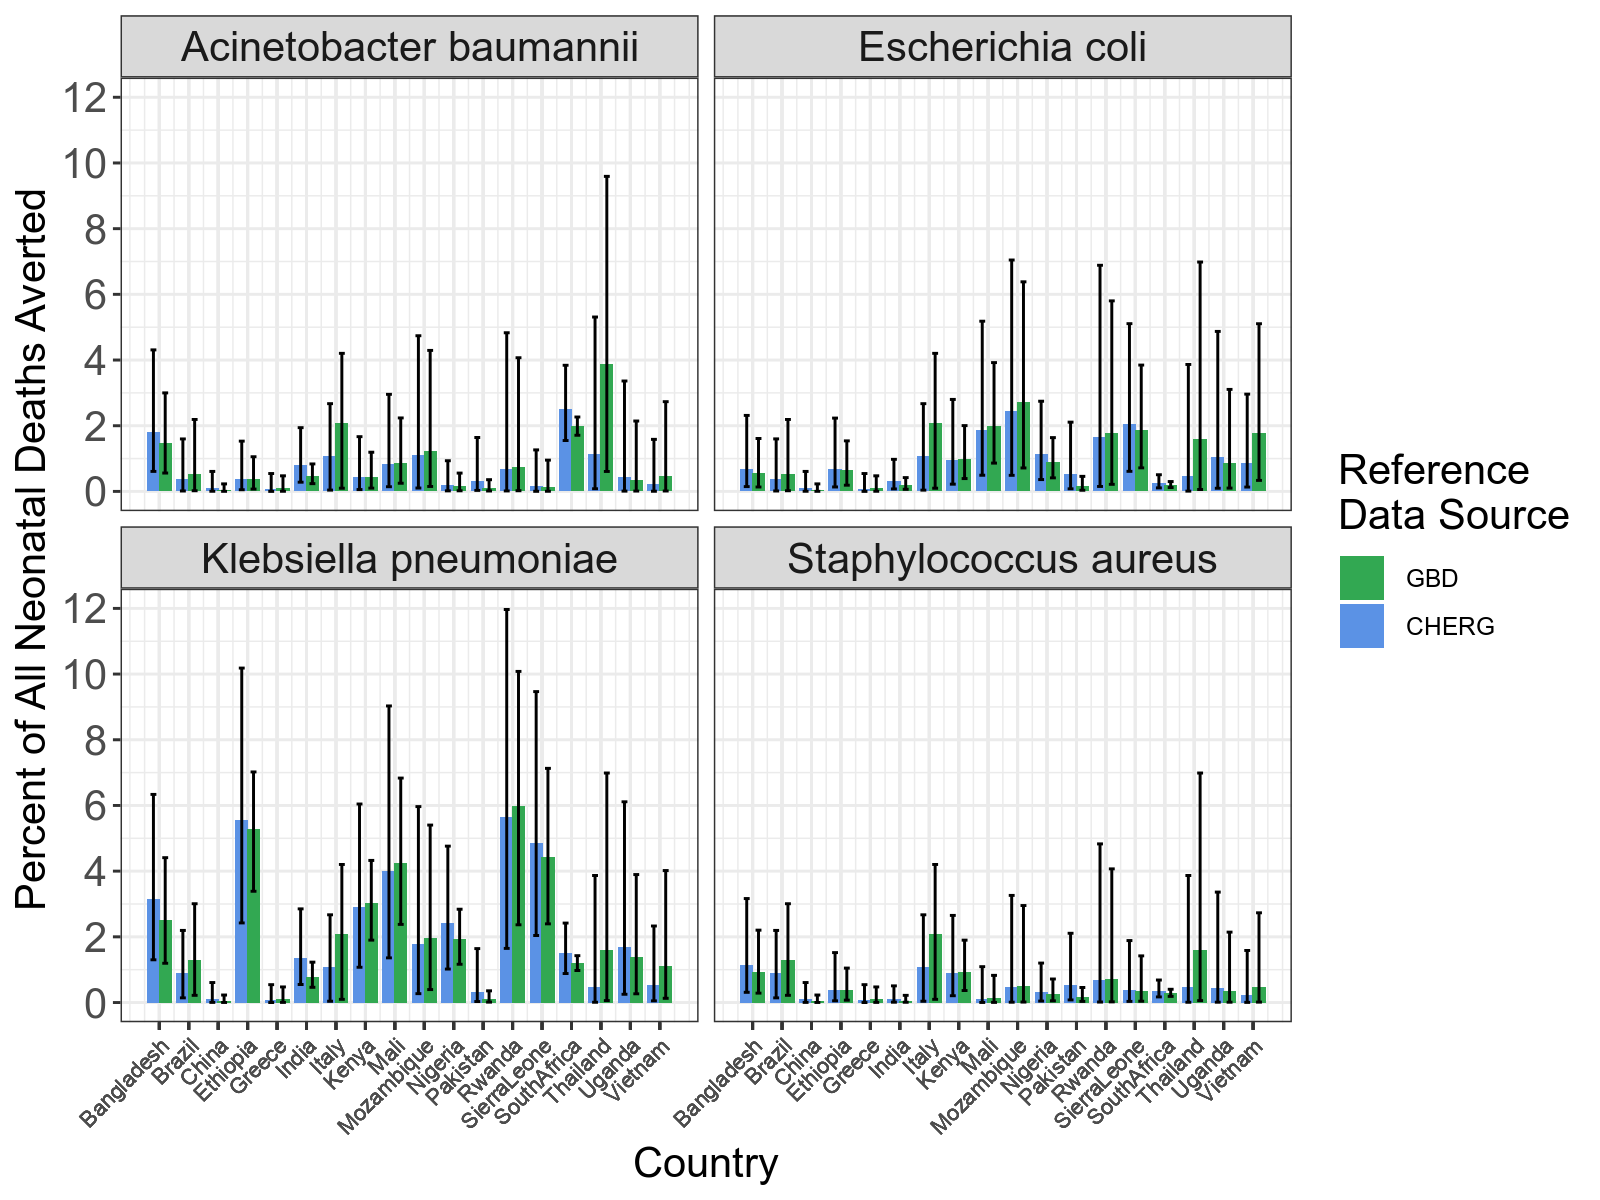

In [234]:
%%R -i meta_estimates -w 8 -h 6 --units in -r 200
#meta_estimates <- meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(meta_estimates) + geom_col(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) - 0.2, 4),
                                               y = `%avertabledeaths_ss_c`, fill = '#5b92e5'), # UN blue!
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) - 0.2, 4),
                              ymin = `%avertabledeaths_ss_lower_c`,
                              ymax = `%avertabledeaths_ss_upper_c`),
                          width=0.2) +
            geom_col(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) + 0.2, 4), y = `%avertabledeaths_ss`, fill = '#32a852'),
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) + 0.2, 4),
                              ymin = `%avertabledeaths_ss_lower`,
                              ymax = `%avertabledeaths_ss_upper`),
                          width=0.2) +
            theme(axis.text.x = element_text(angle = 45, hjust=1, size = 8),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) + facet_wrap(~pathogen) +
                scale_y_continuous('Percent of All Neonatal Deaths Averted',
                                   breaks = seq(0, 15.0, 2.0), label = seq(0, 15.0, 2), limits = c(0, 12.0)) +
                scale_x_continuous('Country',
                                   breaks = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])), 4),
                                   label = rep(unique(meta_estimates$location), 4)) +
                scale_fill_identity(name = 'Reference\nData Source', guide = 'legend',labels = c('GBD', 'CHERG'))

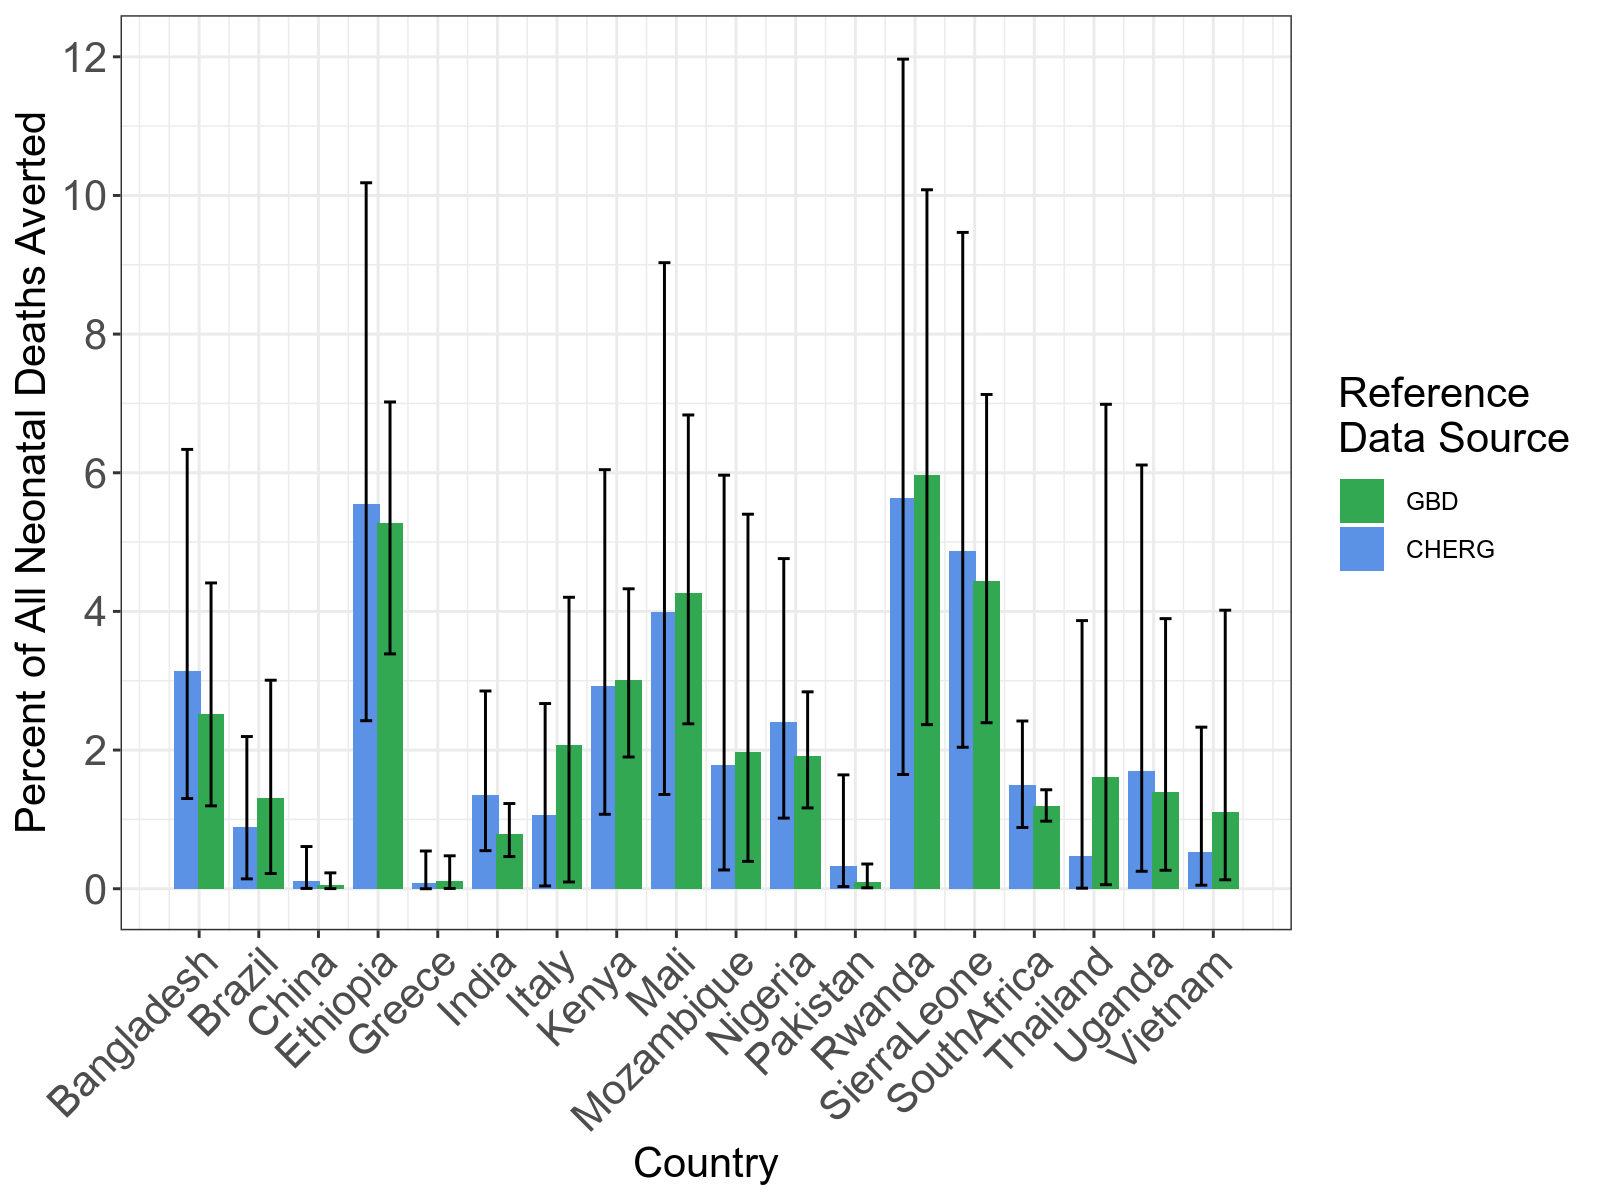

In [235]:
%%R -i meta_estimates -w 8 -h 6 --units in -r 200
meta_estimates <- meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(meta_estimates) + geom_col(aes(x = seq.int(1, nrow(meta_estimates)) - 0.2,
                                               y = `%avertabledeaths_ss_c`, fill = '#5b92e5'), # UN blue!
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = seq.int(1, nrow(meta_estimates)) - 0.2,
                              ymin = `%avertabledeaths_ss_lower_c`,
                              ymax = `%avertabledeaths_ss_upper_c`),
                          width=0.2) +
            geom_col(aes(x = seq.int(1, nrow(meta_estimates)) + 0.2, y = `%avertabledeaths_ss`, fill = '#32a852'),
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = seq.int(1, nrow(meta_estimates)) + 0.2,
                              ymin = `%avertabledeaths_ss_lower`,
                              ymax = `%avertabledeaths_ss_upper`),
                          width=0.2) +
            theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_y_continuous('Percent of All Neonatal Deaths Averted',
                                   breaks = seq(0, 15.0, 2.0), label = seq(0, 15.0, 2), limits = c(0, 12.0)) +
                scale_x_continuous('Country',
                                   breaks = seq(1, nrow(meta_estimates)), label = unique(meta_estimates$location)) +
                scale_fill_identity(name = 'Reference\nData Source', guide = 'legend',labels = c('GBD', 'CHERG'))

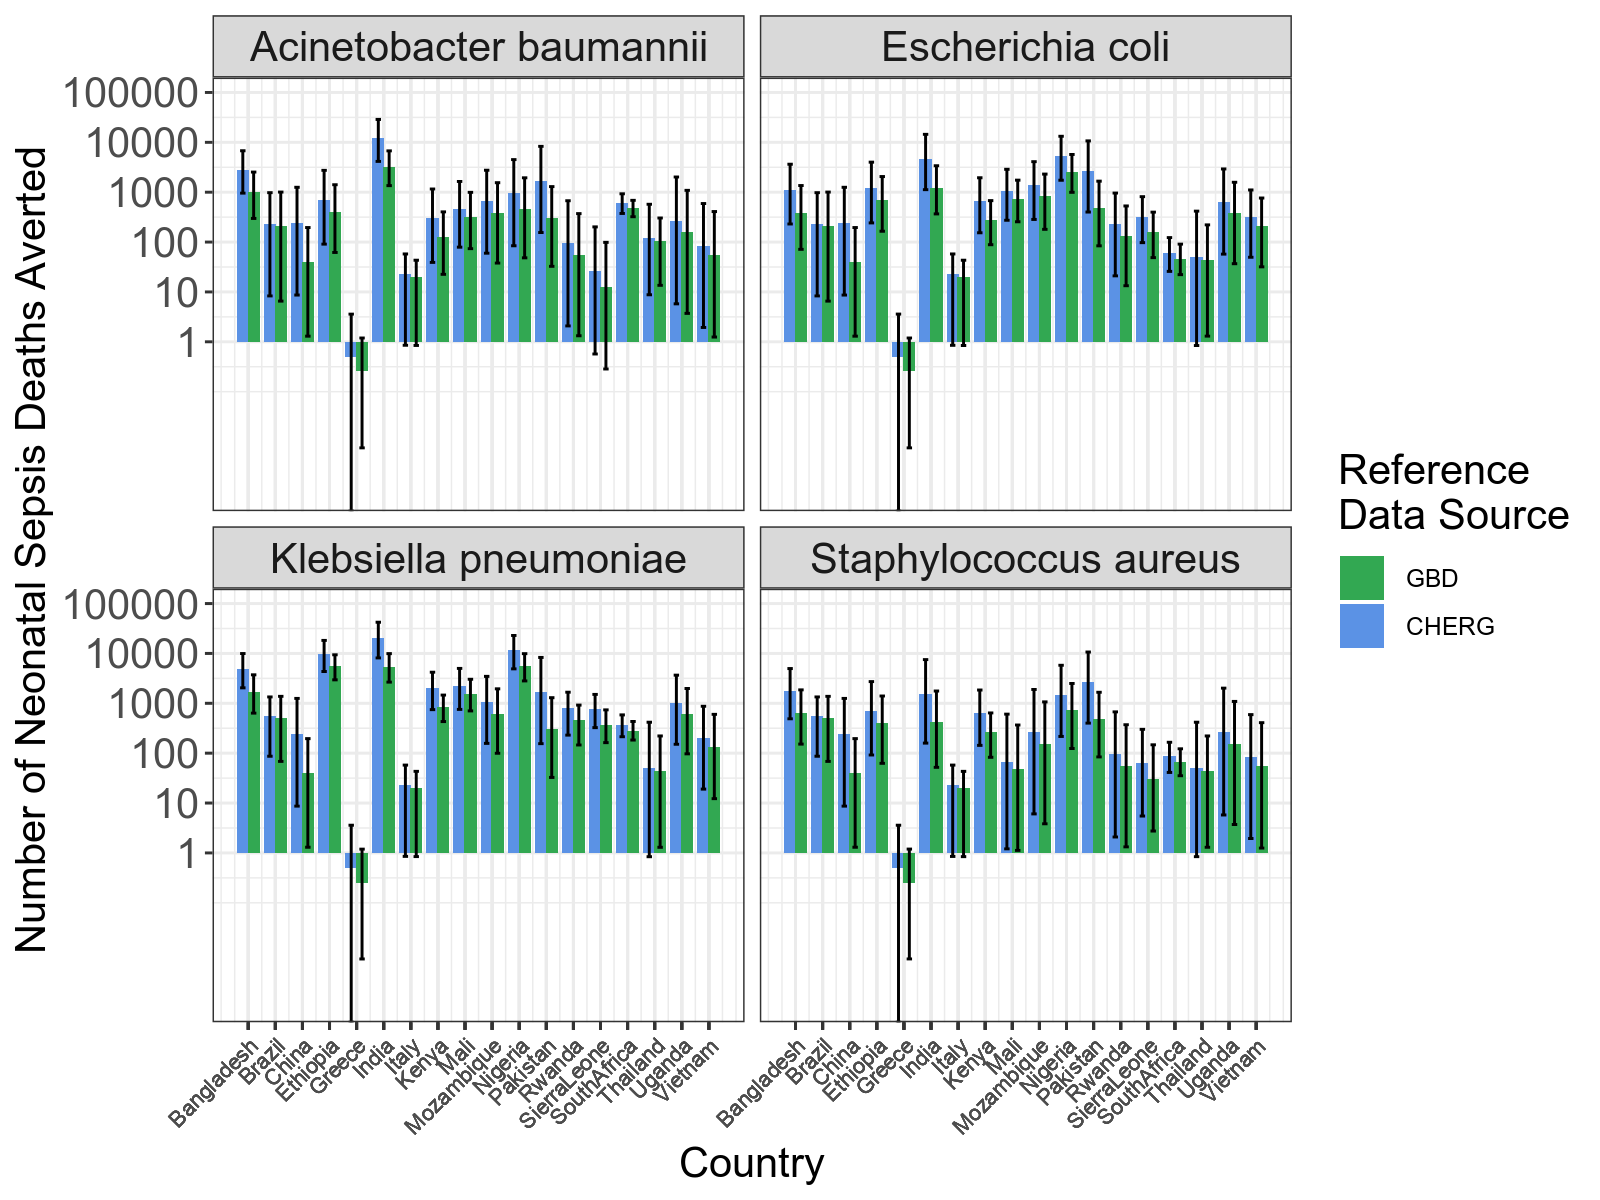

In [236]:
%%R -i meta_estimates -w 8 -h 6 --units in -r 200
#meta_estimates <- meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(meta_estimates) + geom_col(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) - 0.2, 4),
                                               y = `N_avertabledeaths_ss_c`, fill = '#5b92e5'), # UN blue!
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) - 0.2, 4),
                              ymin = `N_avertabledeaths_ss_lower_c`,
                              ymax = `N_avertabledeaths_ss_upper_c`),
                          width=0.2) +
            geom_col(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) + 0.2, 4), y = `N_avertabledeaths_ss`, fill = '#32a852'),
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) + 0.2, 4),
                              ymin = `N_avertabledeaths_ss_lower`,
                              ymax = `N_avertabledeaths_ss_upper`),
                          width=0.2) +
            theme(axis.text.x = element_text(angle = 45, hjust=1, size = 8),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) + facet_wrap(~pathogen) +
            scale_x_continuous('Country',
                                   breaks = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])), 4),
                                   label = rep(unique(meta_estimates$location), 4)) +
            scale_fill_identity(name = 'Reference\nData Source', guide = 'legend',labels = c('GBD', 'CHERG')) +
            scale_y_continuous('Number of Neonatal Sepsis Deaths Averted', trans = 'log10',
                                   breaks = c(1, 10, 100, 1000, 10000, 100000),
                                   labels = c("1", "10", "100", "1000", "10000", "100000"),
                                   limits = c(0.001, 80000))

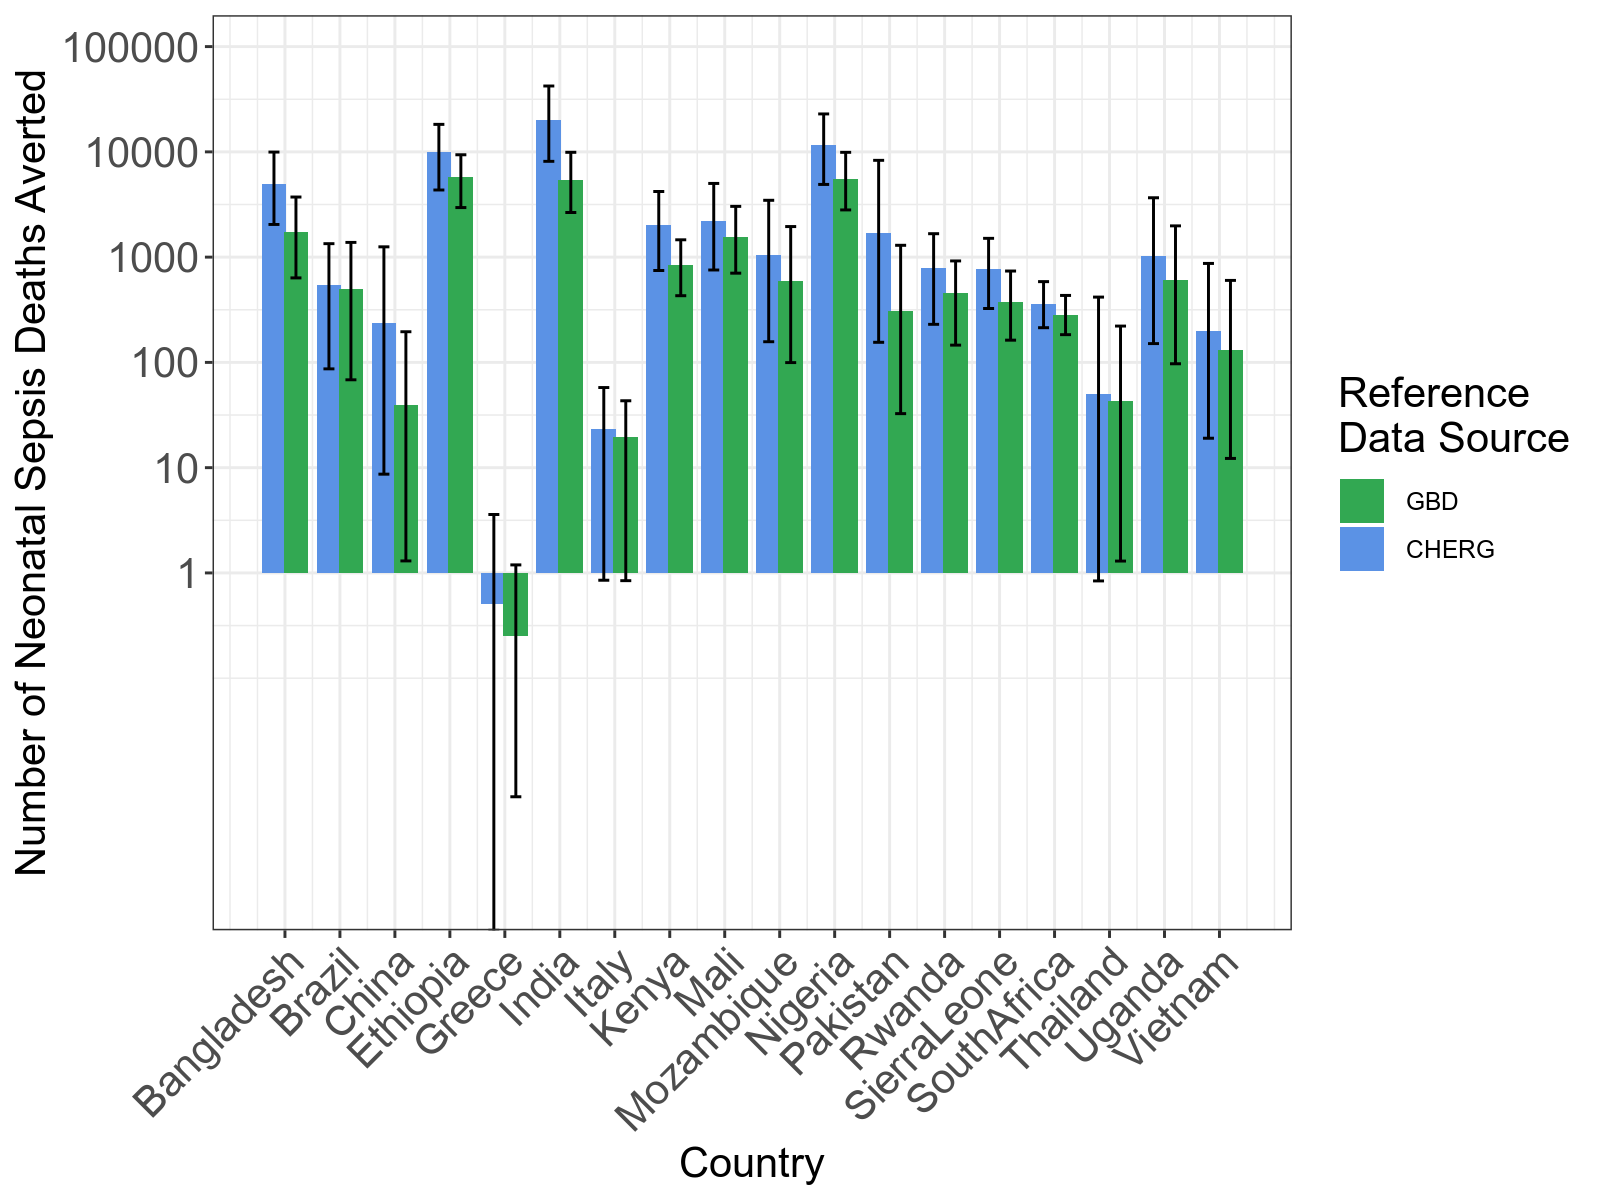

In [237]:
%%R -i meta_estimates -w 8 -h 6 --units in -r 200
meta_estimates <- meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(meta_estimates) + geom_col(aes(x = seq.int(1, nrow(meta_estimates)) - 0.2,
                                               y = `N_avertabledeaths_ss_c`, fill = '#5b92e5'), # UN blue!
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = seq.int(1, nrow(meta_estimates)) - 0.2,
                              ymin = `N_avertabledeaths_ss_lower_c`,
                              ymax = `N_avertabledeaths_ss_upper_c`),
                          width=0.2) +
            geom_col(aes(x = seq.int(1, nrow(meta_estimates)) + 0.2, y = `N_avertabledeaths_ss`, fill = '#32a852'),
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = seq.int(1, nrow(meta_estimates)) + 0.2,
                              ymin = `N_avertabledeaths_ss_lower`,
                              ymax = `N_avertabledeaths_ss_upper`),
                          width=0.2) +
            theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
            scale_y_continuous('Number of Neonatal Sepsis Deaths Averted', trans = 'log10',
                                   breaks = c(1, 10, 100, 1000, 10000, 100000),
                                   labels = c("1", "10", "100", "1000", "10000", "100000"),
                                   limits = c(0.001, 80000)) + 
            scale_x_continuous('Country',
                                   breaks = seq(1, nrow(meta_estimates)), label = unique(meta_estimates$location)) +
            scale_fill_identity(name = 'Reference\nData Source', guide = 'legend',labels = c('GBD', 'CHERG'))

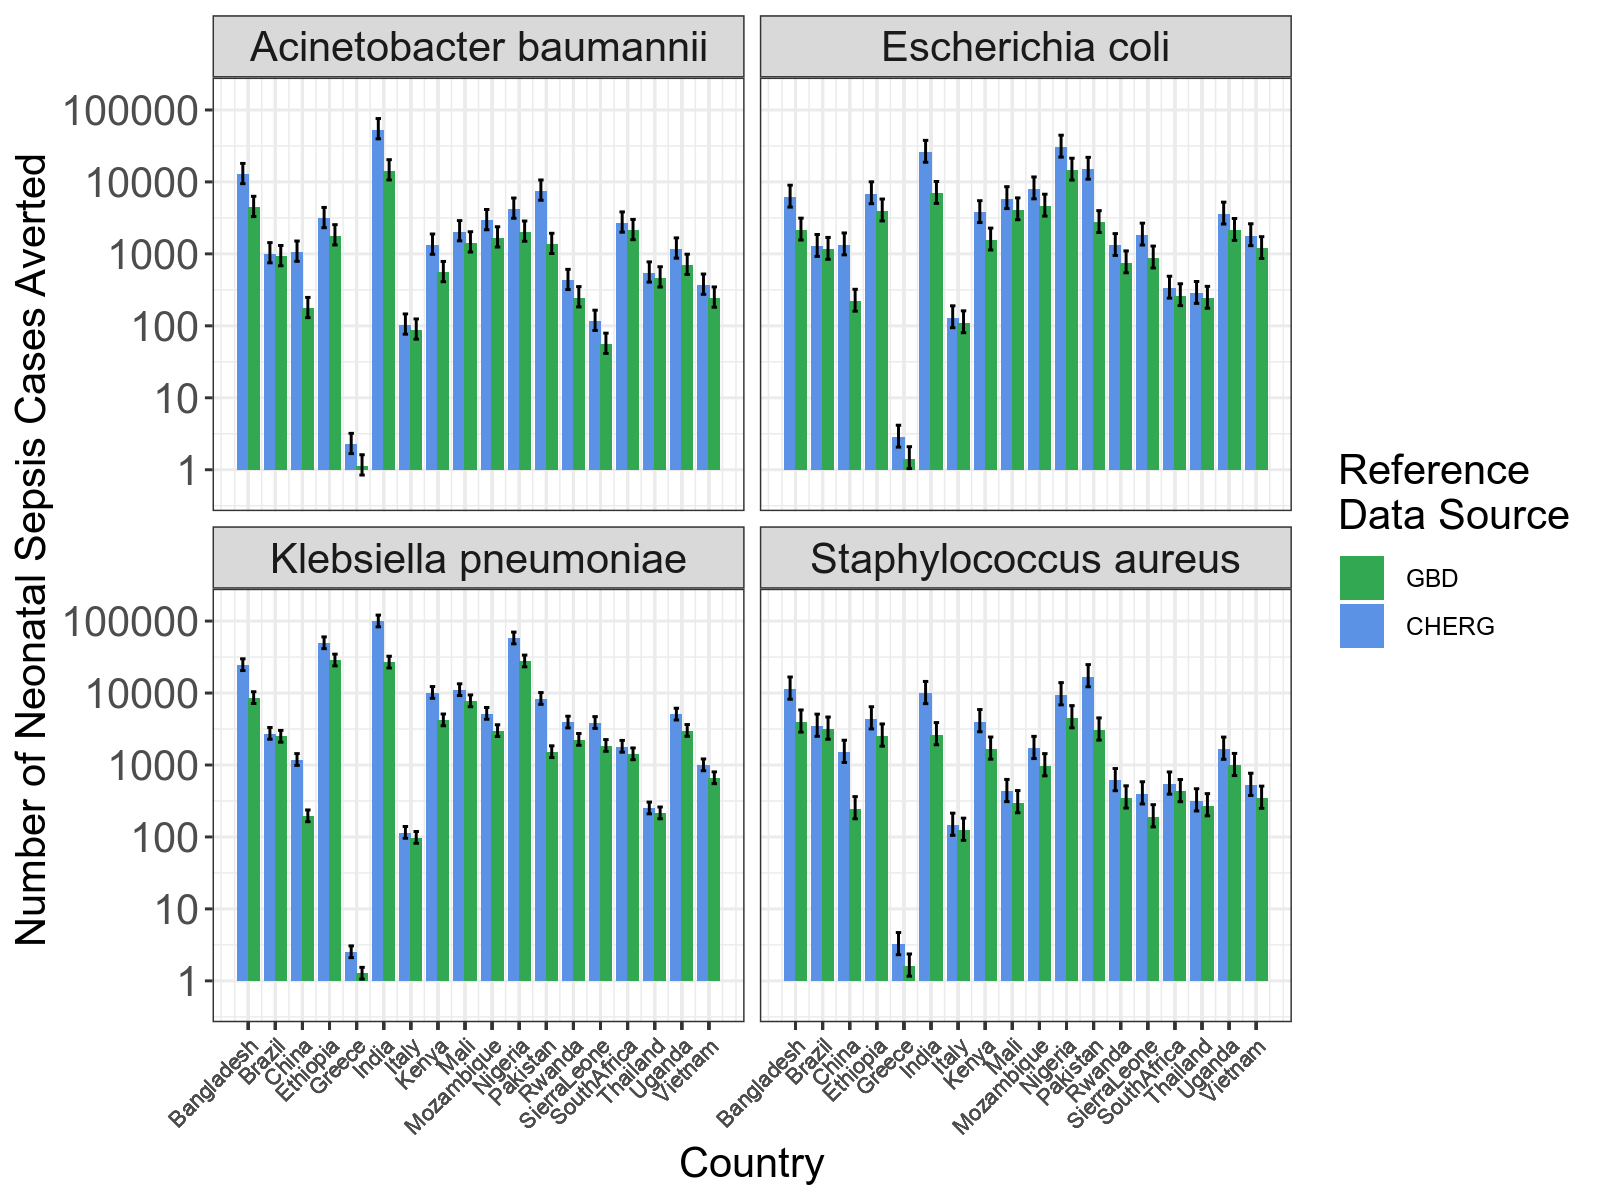

In [238]:
%%R -i meta_estimates -w 8 -h 6 --units in -r 200
#meta_estimates <- meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(meta_estimates) + geom_col(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) - 0.2, 4),
                                               y = `N_avertablecases_ss_c`, fill = '#5b92e5'), # UN blue!
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) - 0.2, 4),
                              ymin = `N_avertablecases_ss_lower_c`,
                              ymax = `N_avertablecases_ss_upper_c`),
                          width=0.2) +
            geom_col(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) + 0.2, 4), y = `N_avertablecases_ss`, fill = '#32a852'),
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])) + 0.2, 4),
                              ymin = `N_avertablecases_ss_lower`,
                              ymax = `N_avertablecases_ss_upper`),
                          width=0.2) +
            theme(axis.text.x = element_text(angle = 45, hjust=1, size = 8),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) + facet_wrap(~pathogen) +
            scale_x_continuous('Country',
                                   breaks = rep(seq.int(1, nrow(meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ])), 4),
                                   label = rep(unique(meta_estimates$location), 4)) +
            scale_fill_identity(name = 'Reference\nData Source', guide = 'legend',labels = c('GBD', 'CHERG')) +
            scale_y_continuous('Number of Neonatal Sepsis Cases Averted', trans = 'log10',
                                   breaks = c(1, 10, 100, 1000, 10000, 100000),
                                   labels = c("1", "10", "100", "1000", "10000", "100000"),
                                   limits = c(0.5, 150000))

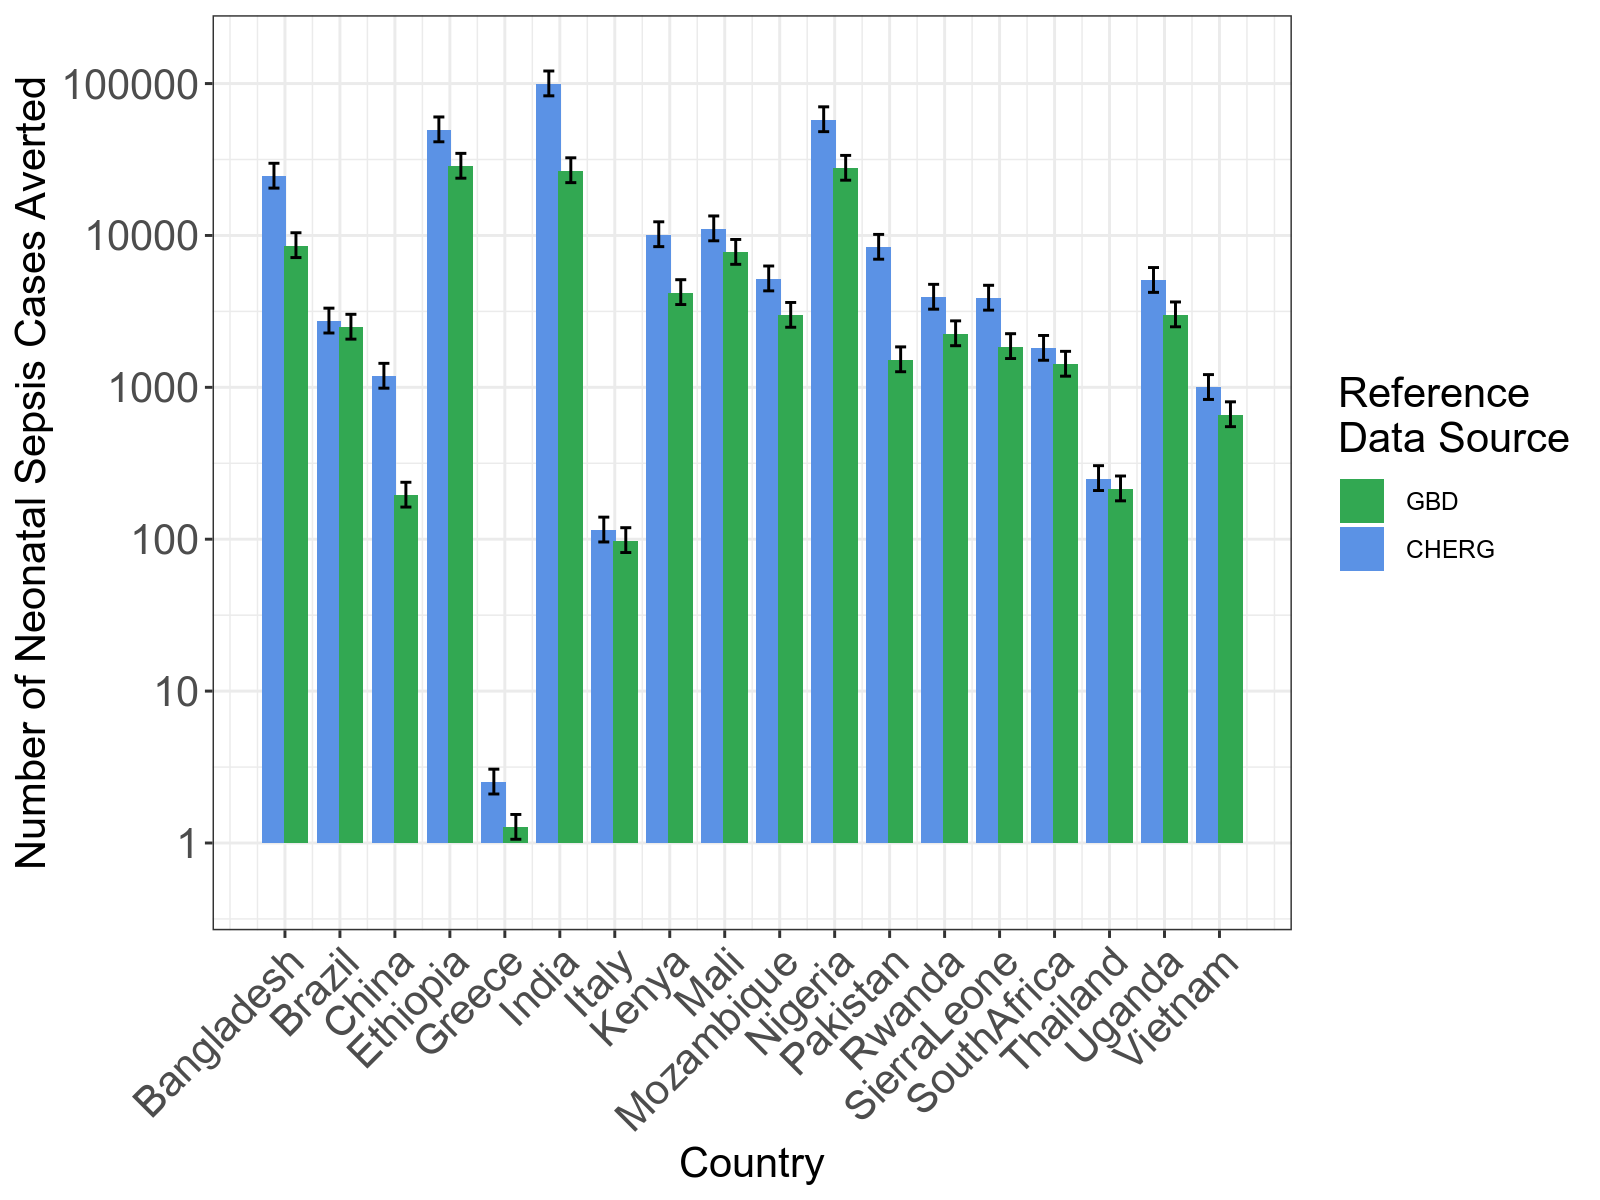

In [239]:
%%R -i meta_estimates -w 8 -h 6 --units in -r 200
meta_estimates <- meta_estimates[meta_estimates$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(meta_estimates) + geom_col(aes(x = seq.int(1, nrow(meta_estimates)) - 0.2,
                                               y = `N_avertablecases_ss_c`, fill = '#5b92e5'), # UN blue!
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = seq.int(1, nrow(meta_estimates)) - 0.2,
                              ymin = `N_avertablecases_ss_lower_c`,
                              ymax = `N_avertablecases_ss_upper_c`),
                          width=0.2) +
            geom_col(aes(x = seq.int(1, nrow(meta_estimates)) + 0.2, y = `N_avertablecases_ss`, fill = '#32a852'),
                                             position = position_dodge(width = 0.5), alpha = 1, width = 0.45) +
            geom_errorbar(aes(x = seq.int(1, nrow(meta_estimates)) + 0.2,
                              ymin = `N_avertablecases_ss_lower`,
                              ymax = `N_avertablecases_ss_upper`),
                          width=0.2) +
            theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
            scale_y_continuous('Number of Neonatal Sepsis Cases Averted', trans = 'log10',
                                   breaks = c(1, 10, 100, 1000, 10000, 100000),
                                   labels = c("1", "10", "100", "1000", "10000", "100000"),
                                   limits = c(0.5, 150000)) +
            scale_x_continuous('Country',
                                   breaks = seq(1, nrow(meta_estimates)), label = unique(meta_estimates$location)) +
            scale_fill_identity(name = 'Reference\nData Source', guide = 'legend',labels = c('GBD', 'CHERG'))

In [240]:
comparison_filled_gardp[comparison_filled_gardp.pathogen == 'Klebsiella pneumoniae'].dropna()['P(Pathogen | Death from Neonatal Sepsis)'].sum() / 25

0.2404967266426366

In [241]:
meta_estimates[meta_estimates.pathogen == 'Klebsiella pneumoniae'][['location', '%avertabledeaths_ss_c',
                                                                   '%avertabledeaths_ss_lower_c',
                                                                   '%avertabledeaths_ss_upper_c',
                                                                   '%avertabledeaths_ss',
                                                                   '%avertabledeaths_ss_lower',
                                                                   '%avertabledeaths_ss_upper',
                                                                   'N_avertabledeaths_ss_c',
                                                                   'N_avertabledeaths_ss_lower_c',
                                                                   'N_avertabledeaths_ss_upper_c',
                                                                   'N_avertabledeaths_ss',
                                                                   'N_avertabledeaths_ss_lower',
                                                                   'N_avertabledeaths_ss_upper',
                                                                   'N_avertablecases_ss_c',
                                                                   'N_avertablecases_ss_lower_c',
                                                                   'N_avertablecases_ss_upper_c',
                                                                   'N_avertablecases_ss',
                                                                   'N_avertablecases_ss_lower',
                                                                   'N_avertablecases_ss_upper']]

location  %avertabledeaths_ss_c  %avertabledeaths_ss_lower_c  \
36   Bangladesh               3.137703                     1.300687   
37       Brazil               0.896061                     0.141934   
38        China               0.115294                     0.004211   
39     Ethiopia               5.547627                     2.423758   
40       Greece               0.076581                     0.000000   
41        India               1.347995                     0.548930   
42        Italy               1.068110                     0.039460   
43        Kenya               2.919456                     1.074019   
44         Mali               3.993882                     1.359564   
45   Mozambique               1.786053                     0.270359   
46      Nigeria               2.407299                     1.018236   
47     Pakistan               0.331231                     0.030663   
48       Rwanda               5.637172                     1.647494   
49  SierraLeone               4.865370                     2.040413   
50  SouthAfrica               1.498491                     0.883177   
51     Thailand               0.466381                     0.007779   
52       Uganda               1.692409                     0.251599   
53      Vietnam               0.535204                     0.050906   

    %avertabledeaths_ss_upper_c  %avertabledeaths_ss  \
36                     6.337172             2.524467   
37                     2.195029             1.305958   
38                     0.608289             0.051098   
39                    10.183298             5.273331   
40                     0.543826             0.114163   
41                     2.852125             0.784431   
42                     2.671318             2.072529   
43                     6.044921             3.016651   
44                     9.030390             4.259681   
45                     5.965487             1.979202   
46                     4.762125             1.919715   
47                     1.641968             0.101249   
48                    11.966497             5.974145   
49                     9.466987             4.437531   
50                     2.419417             1.190054   
51                     3.867394             1.606024   
52                     6.111792             1.397408   
53                     2.330329             1.112557   

    %avertabledeaths_ss_lower  %avertabledeaths_ss_upper  \
36                   1.195184                   4.410934   
37                   0.218723                   3.007548   
38                   0.001898                   0.228545   
39                   3.387213                   7.021364   
40                   0.003795                   0.474553   
41                   0.463838                   1.228621   
42                   0.097093                   4.204067   
43                   1.899858                   4.325951   
44                   2.378727                   6.833693   
45                   0.394804                   5.402485   
46                   1.165043                   2.840176   
47                   0.013338                   0.356359   
48                   2.366997                  10.082181   
49                   2.394584                   7.129640   
50                   0.974726                   1.427250   
51                   0.058127                   6.987429   
52                   0.265922                   3.895861   
53                   0.128568                   4.017708   

    N_avertabledeaths_ss_c  N_avertabledeaths_ss_lower_c  \
36             4929.676369                   2043.522387   
37              547.981687                     86.798782   
38              237.497239                      8.673493   
39             9944.842308                   4344.901962   
40                0.505434                      0.000000   
41            19969.778137                   8132.081103   
42               23.065827     

In [242]:
meta_estimates[meta_estimates.pathogen == 'Klebsiella pneumoniae'][['location', '%avertabledeaths_ss_c',
                                                                   '%avertabledeaths_ss_lower_c',
                                                                   '%avertabledeaths_ss_upper_c',
                                                                   '%avertabledeaths_ss',
                                                                   '%avertabledeaths_ss_lower',
                                                                   '%avertabledeaths_ss_upper',
                                                                   'N_avertabledeaths_ss_c',
                                                                   'N_avertabledeaths_ss_lower_c',
                                                                   'N_avertabledeaths_ss_upper_c',
                                                                   'N_avertabledeaths_ss',
                                                                   'N_avertabledeaths_ss_lower',
                                                                   'N_avertabledeaths_ss_upper',
                                                                   'N_avertablecases_ss_c',
                                                                   'N_avertablecases_ss_lower_c',
                                                                   'N_avertablecases_ss_upper_c',
                                                                   'N_avertablecases_ss',
                                                                   'N_avertablecases_ss_lower',
                                                                   'N_avertablecases_ss_upper']].sum()

location                        BangladeshBrazilChinaEthiopiaGreeceIndiaItalyK...
%avertabledeaths_ss_c                                                     38.3223
%avertabledeaths_ss_lower_c                                               13.0932
%avertabledeaths_ss_upper_c                                               88.9984
%avertabledeaths_ss                                                       39.1202
%avertabledeaths_ss_lower                                                 17.4084
%avertabledeaths_ss_upper                                                 73.8744
N_avertabledeaths_ss_c                                                    57401.9
N_avertabledeaths_ss_lower_c                                              22275.2
N_avertabledeaths_ss_upper_c                                               125776
N_avertabledeaths_ss                                                      24101.5
N_avertabledeaths_ss_lower                                                10997.4
N_avertabledeath

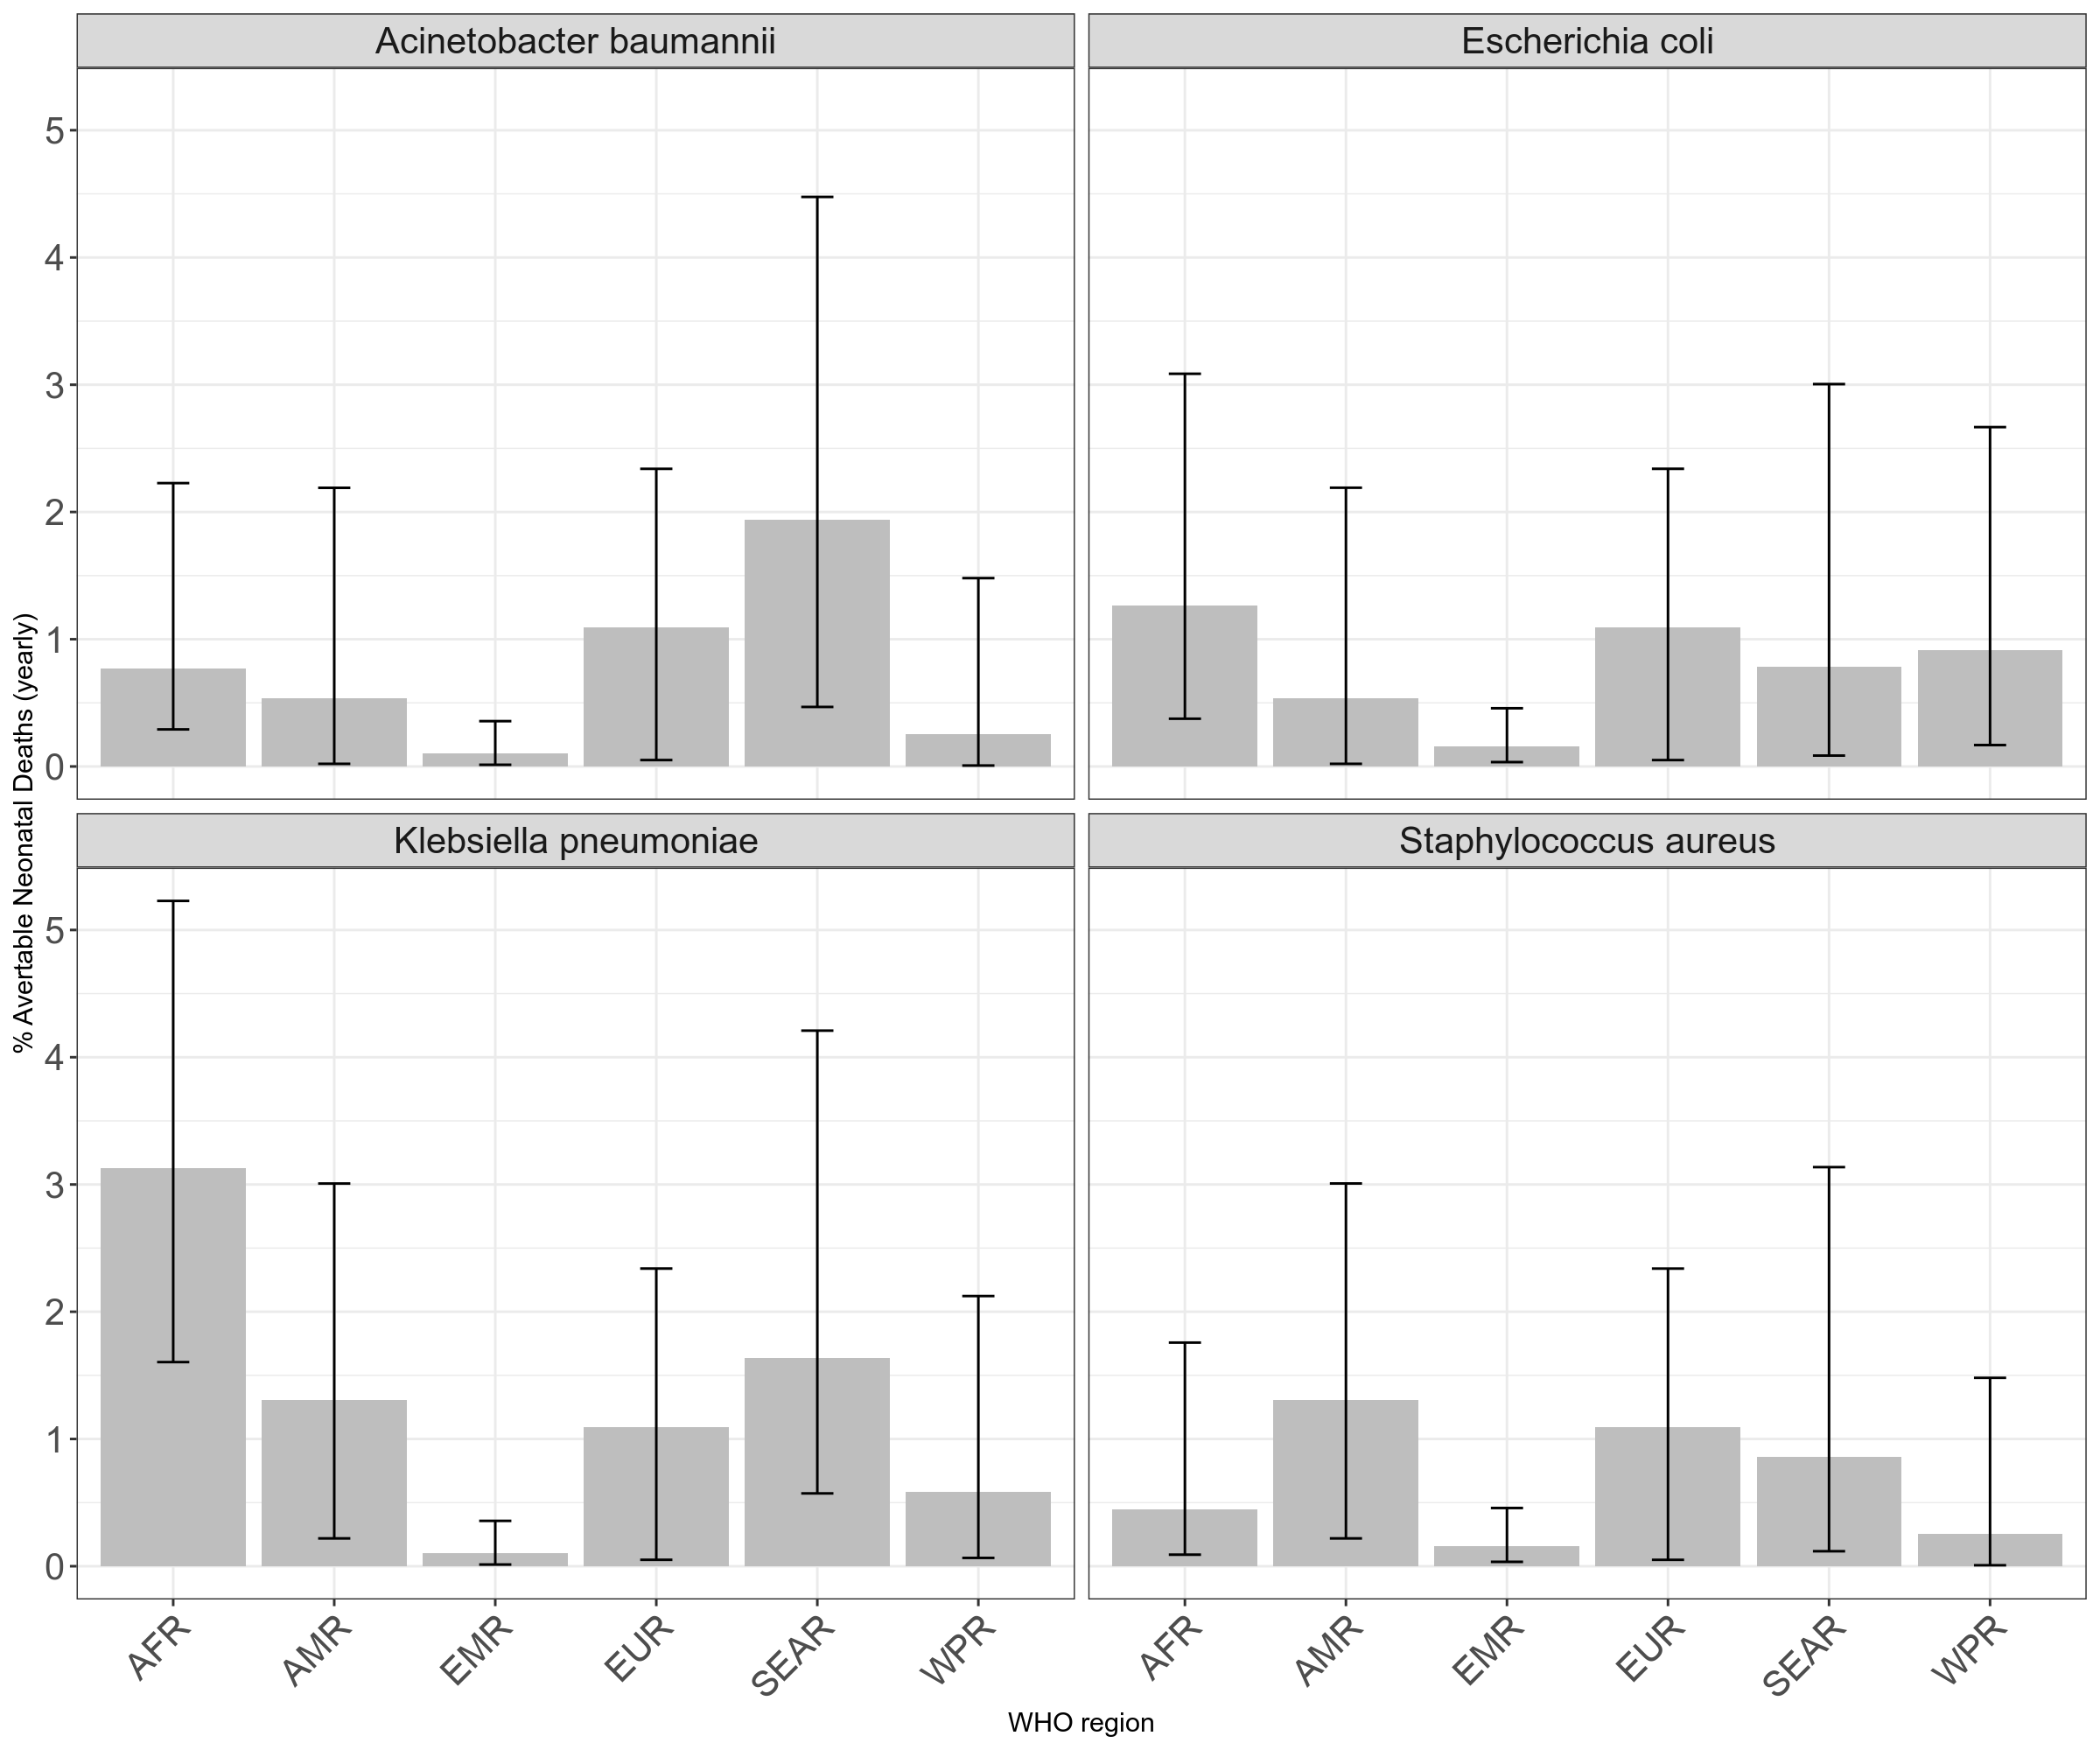

In [243]:
%%R -i meta_estimates_aggregate -w 12 -h 10 --units in -r 200
#positions <- c('AFR', 'SEAR')
ggplot2::ggplot(meta_estimates_aggregate) + geom_col(aes(x = `WHO region`,
                                                  y = `%avertabledeaths_ss`), fill = 'grey',
                                             position = position_dodge(), size = 3, alpha = 1) + geom_errorbar(aes(x = `WHO region`, ymin = `%avertabledeaths_ss_lower`, ymax = `%avertabledeaths_ss_upper`), width=0.2) + theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                                             axis.text.y = element_text(size = 15), strip.text = element_text(size = 15)) + xlab('WHO region') + ylab('% Avertable Neonatal Deaths (yearly)') + facet_wrap(~pathogen) # + scale_x_discrete(limits = positions) # + geom_vline(xintercept = seq(4.5, 8, by = 3), color="#7CAE00", size=1, alpha=0.7)

In [244]:
meta_estimates_aggregate[meta_estimates_aggregate['WHO region'] == 'EUR']

pathogen WHO region  %avertabledeaths_ss  \
3   Acinetobacter baumannii        EUR             1.093427   
9          Escherichia coli        EUR             1.093425   
15    Klebsiella pneumoniae        EUR             1.093346   
21    Staphylococcus aureus        EUR             1.093372   

    %avertabledeaths_ss_lower  %avertabledeaths_ss_upper  \
3                    0.050425                   2.339219   
9                    0.050370                   2.339347   
15                   0.050444                   2.339310   
21                   0.050322                   2.339259   

    N_avertabledeaths_ss  N_avertabledeaths_ss_lower  \
3               9.953835                    0.425733   
9               9.953864                    0.425263   
15              9.953076                    0.425887   
21              9.953329                    0.424806   

    N_avertabledeaths_ss_upper  N_avertablecases_ss  \
3                    22.194634            44.455729   
9                    22.195777            56.064817   
15                   22.195866            49.614708   
21                   22.195222            63.065247   

    N_avertablecases_ss_lower  ...  N_avertablecases_ss_upper_c  \
3                   33.013019  ...                    74.803894   
9                   40.598831  ...                    96.873872   
15                  41.388668  ...                    71.411793   
21                  45.439057  ...                   109.525301   

    %avertabledeaths_who_c  %avertabledeaths_who_lower_c  \
3                 0.408301                      0.014088   
9                 0.408300                      0.014072   
15                0.408271                      0.014093   
21                0.408280                      0.014057   

    %avertabledeaths_who_upper_c  N_avertabledeaths_who_c  \
3                       1.144353                 8.415335   
9                       1.144419                 8.415351   
15                      1.144381                 8.414697   
21                      1.144363                 8.414908   

    N_avertabledeaths_who_lower_c  N_avertabledeaths_who_upper_c  \
3                        0.304228                      21.857713   
9                        0.303891                      21.858869   
15                       0.304336                      21.858777   
21                       0.303554                      21.858207   

    N_avertablecases_who_c  N_avertablecases_who_lower_c  \
3                37.584497                     27.910412   
9                47.399191                     34.323696   
15               41.946100                     34.991503   
21               53.317660                     38.415837   

    N_avertablecases_who_upper_c  
3                      53.408439  
9                      69.165953  
15                     50.986548  
21                     78.198809  

[4 rows x 38 columns]

### Resistance

In [245]:
# abxs for neonatal sepsis
# Rational development of guidelines for management of neonatal sepsis in developing countries
# Reviewing the WHO guidelines for antibiotic use for sepsis in neonates and children
# Antibiotic regimens for neonatal sepsis - a protocol for a systematic review with meta-analysis ***
# Evaluation of the Coverage of 3 Antibiotic Regimens for Neonatal Sepsis in the Hospital Setting Across Asian Countries


In [246]:
# let's use the barnards and gardp data to estimate the distribution of resistance
# here it makes sense to use dirichlet distribution sampling to ensure that our estimates of each drug resistance
# are self consistent


# so i want four sub plots
# 2 for deaths, 2 for cases
# the first chart is the fraction of avertable deaths (cases) that would be resistant to:
# beta-lactams, agly, cyc, fof1, quinolones, polymixins.
# the second is the fraction of avertable deaths (cases) that are resistant to no drug classes, 1 drug class, 2, etc.

In [247]:
# read in barnards resistance data
gnb_resistances = pd.read_csv(os.path.join(data_dir, 'raw', 'sepsis_isolate_gnbspecies_mic.csv'))
gpb_resistances = pd.read_csv(os.path.join(data_dir, 'raw', 'sepsis_isolate_gpbspecies_mic.csv'))

In [248]:
gnb_resistances.SITE = gnb_resistances.SITE.map(lambda x: mr[mr.SITE==x].COUNTRY.unique()[0],
                                                na_action = 'ignore')

In [249]:
gpb_resistances.SITE = gpb_resistances.SITE.map(lambda x: mr[mr.SITE==x].COUNTRY.unique()[0],
                                                na_action = 'ignore')

In [250]:
gnb_resistances.columns

Index(['SITE', 'ANON_MOTHER', 'ANON_BABY', 'ANON_ISOLATE', 'FINALSPECIESID',
       'ENTEROBACTERIACEAE', 'AMPICILINMIC', 'AMP',
       'AMOXICILLIN_CLAVULANICACIDMIC', 'AMC', 'PIPERACILIN_TAZOBACTAMMIC',
       'TZP', 'CEFTRIAXONEMIC', 'CRO', 'CEFOTAXIMEMIC', 'CTX',
       'CEFTAZIDIMEMIC', 'CAZ', 'CEFEPIMEMIC', 'FEP', 'IMIPENEMMIC', 'IPM',
       'MEROPENEMMIC', 'MEM', 'ERTAPENEMMIC', 'ETP', 'AZTREONAMMIC', 'ATM',
       'GENTAMICINMIC', 'GEN', 'AMIKACINMIC', 'AMK', 'TOBRAMYCINMIC', 'TOB',
       'TIGECYCLINEMIC', 'TGC', 'MINOCYCLINE', 'MIN', 'FOSFOMYCINMIC', 'FOF',
       'LEVOFLOXACINMIC', 'LVX', 'CIPROFLOXACINMIC', 'CIP', 'COLISTINMIC',
       'CST', 'BETA_LACTAMS', 'AMINOGLYCOSIDES', 'CYCLINES', 'FOF_1',
       'QUINOLONES', 'POLYMIXIN'],
      dtype='object')

In [251]:
gnb_resistances = gnb_resistances[gnb_resistances.FINALSPECIESID.isin(comparison_filled_gardp.pathogen.unique())]

In [252]:
gpb_resistances = gpb_resistances[gpb_resistances.FINALSPECIESID.isin(comparison_filled_gardp.pathogen.unique())]

In [253]:
gpb_resistances.columns

Index(['SITE', 'ANON_MOTHER', 'ANON_BABY', 'ANON_ISOLATE', 'FINALSPECIESID',
       'AMPICILLIN2', 'AMP2', 'OXACILLIN2', 'OXA2', 'METHICILLIN2',
       'FLUCLOXACILLIN2', 'FLUCLOX2', 'LEVOFLOXACIN2', 'LVX2',
       'CIPROFLOXACIN2', 'CIP2', 'GENTAMICIN2', 'GEN2', 'AMIKACIN2', 'AMK2',
       'TOBRAMYCIN2', 'TOB2', 'TIGECYCLINE2', 'TGC2', 'MINOCYCLINE2', 'MIN2',
       'RIFAMPICIN2', 'RIF2', 'VANCOMYCIN2', 'VAN2', 'AZITHROMYCIN2', 'AZM2',
       'LINEZOLIDE2', 'LZD2', 'BETA_LACTAMS2', 'METHICILLIN2_1', 'QUINOLONES2',
       'AMINOGLYCOSIDES2', 'CYCLINES2', 'RIFAMPICIN2_1', 'GLYCOPEPTIDE2',
       'MACROLIDE2', 'OXAZOLIDINONES2'],
      dtype='object')

In [254]:
gnb_resistances = gnb_resistances[~gnb_resistances.ANON_BABY.duplicated(keep = False)]
gpb_resistances = gpb_resistances[~gpb_resistances.ANON_BABY.duplicated(keep = False)]

In [255]:
gnb_resistances = gnb_resistances[['ANON_MOTHER', 'ANON_BABY', 'SITE', 'AMP','AMC', 'TZP', 'CRO', 'CTX', 'CAZ', 'FEP', 'IPM',
                                  'MEM', 'ETP', 'ATM', 'GEN', 'AMK', 'TOB', 'TGC', 'MIN', 'FOF', 'LVX',
                                  'CIP', 'CST']]

In [256]:
gnb_resistances.columns = ['ANON_MOTHER', 'ANON_BABY', 'SITE', 'Penicillins: Ampicillin',
                           'Penicillins: Amoxicillin-Clavulanic Acid',
                           'Penicillins: Piperacillin-Tazobactam',
                           'Cephalosporins: Ceftriaxone', 'Cephalosporins: Cefotaxime', # these two should not be in main - safety
                           'Cephalosporins: Ceftazidime', 'Cephalosporins: Cefepime', # not in main -- overcrowded
                           'Carbapenems: Imipenem', 'Carbapenems: Meropenem', 'Carbapenems: Ertapenem', # not in main -- overcrowded
                           'Monobactams: Aztreonam', # not in main -- overcrowded
                           'Aminoglycosides: Gentamicin', 'Aminoglycosides: Amikacin',
                           'Aminoglycosides: Tobramycin', 'Tetracyclines: Tigecycline', # not in main -- overcrowded
                           'Tetracyclines: Minocycline', # not in main figure - Safety
                           'Phosphonics: Fosfomycin', 'Fluoroquinolones: Levofloxacin', # not in main -- overcrowded
                           'Fluoroquinolines: Ciprofloxacin', 'Polymyxins: Colistin'] # not in main -- overcrowded

In [257]:
gpb_resistances = gpb_resistances[['ANON_BABY', 'METHICILLIN2_1', 'AMP2', 'OXA2', 'FLUCLOX2', 'LVX2', 'CIP2',
                                   'GEN2', 'AMK2', 'TOB2', 'TGC2', 'MIN2', 'RIF2', 'VAN2', 'AZM2', 'LZD2']]

In [258]:
gpb_resistances.columns = ['ANON_BABY', 'Penicillins: Methicillin', 'Penicillins: Ampicillin',
                          'Penicillins: Oxacillin', 'Penicillins: Flucloxacillin',
                           'Fluoroquinolones: Levofloxacin', 'Fluoroquinolines: Ciprofloxacin',
                          'Aminoglycosides: Gentamicin', 'Aminoglycosides: Amikacin',
                          'Aminoglycosides: Tobramycin', 'Tetracyclines: Tigecycline',
                          'Tetracyclines: Minocycline', 'Macrolides: Rifampicin',
                          'Glycopeptides: Vancomycin', 'Macrolides: Azithromycin', 'Oxazolidinones: Linezolid']

In [259]:
resistances = pd.concat([gnb_resistances, gpb_resistances], axis = 0).reset_index(drop = True)

In [260]:
barnards_AMR = barnards.merge(resistances, on = 'ANON_BABY')

In [261]:
barnards_AMR

SITE_x  ANON_MOTHER_x ANON_BABY         FINALSPECIESID  \
0     Bangladesh        30405.0     30405  Klebsiella pneumoniae   
1     Bangladesh        12933.0     12933  Klebsiella pneumoniae   
2     Bangladesh        17991.0     17991  Klebsiella pneumoniae   
3     Bangladesh        16666.0     16666  Klebsiella pneumoniae   
4     Bangladesh        27703.0     27703  Klebsiella pneumoniae   
..           ...            ...       ...                    ...   
388  SouthAfrica        31236.0     31236  Staphylococcus aureus   
389  SouthAfrica        33614.0    33614A  Staphylococcus aureus   
390  SouthAfrica        33614.0    33614B  Staphylococcus aureus   
391  SouthAfrica        24585.0     24585  Staphylococcus aureus   
392  SouthAfrica        20967.0    20967B  Staphylococcus aureus   

                 ENA_ACCESSION ENTEROBACTERIACEAE TYPEOFSEPSIS   ST        O  \
0    ERS5229736 (SAMEA7472041)                  Y          GNB  147      O3b   
1    ERS5229742 (SAMEA7472047)                  Y          GNB   17     O2v2   
2    ERS5229750 (SAMEA7472055)                  Y          GNB   39  O1/O2v1   
3    ERS5229751 (SAMEA7472056)                  Y          GNB  292      O3b   
4    ERS5229755 (SAMEA7472060)                  Y          GNB  340       O4   
..                         ...                ...          ...  ...      ...   
388  ERS5229107 (SAMEA7471411)                  N          NaN    1      NaN   
389  ERS5229109 (SAMEA7471413)                  N          NaN    5      NaN   
390  ERS5229110 (SAMEA7471414)                  N          NaN    5      NaN   
391  ERS5229113 (SAMEA7471417)                  N          NaN  152      NaN   
392  ERS5229115 (SAMEA7471419)                  N          NaN    5      NaN   

         K  ... Fluoroquinolones: Levofloxacin  \
0    KL128  ...                              R   
1    KL122  ...                              S   
2      KL2  ...                              S   
3     KL38  ...                              S   
4     KL15  ...                              R   
..     ...  ...                            ...   
388    NaN  ...                              S   
389    NaN  ...                              S   
390    NaN  ...                              S   
391    NaN  ...                              S   
392    NaN  ...                              S   

    Fluoroquinolines: Ciprofloxacin Polymyxins: Colistin  \
0                                 R                    S   
1                                 S                    S   
2                                 S                    S   
3                                 S                    S   
4                                 R                    S   
..                              ...                  ...   
388                               S                  NaN   
389                               S                  NaN   
390                               S                  NaN   
391                               S                  NaN   
392                               S                  NaN   

    Penicillins: Methicillin Penicillins: Oxacillin  \
0                        NaN                    NaN   
1                        NaN                    NaN   
2                        NaN                    NaN   
3                        NaN                    NaN   
4                        NaN                    NaN   
..                       ...                    ...   
388                        N                    NaN   
389                        Y                    NaN   
390                        Y                    NaN   
391                        N                    NaN   
392                        Y                    NaN   

    Penicillins: Flucloxacillin Macrolides: Rifampicin  \
0                           NaN                    NaN   
1                           NaN                    NaN   
2                           NaN                    NaN   
3                

In [262]:
barnards_AMR = barnards_AMR[barnards_AMR.AGEATOUTCOMEDAYS_y <= 28]

In [263]:
barnards_AMR_supp = barnards_AMR.copy(deep = True)

In [264]:
barnards_AMR = barnards_AMR[['SITE_x', 'OUTCOME_x', 'ANON_MOTHER_x', 'ANON_BABY', 'FINALSPECIESID',
                            'Penicillins: Ampicillin',
                           'Penicillins: Amoxicillin-Clavulanic Acid',
                           'Penicillins: Piperacillin-Tazobactam',
                           #'Cephalosporins: Ceftriaxone', 'Cephalosporins: Cefotaxime', # these two should not be in main - safety
                           'Cephalosporins: Ceftazidime',
                             #'Cephalosporins: Cefepime', # not in main -- overcrowded
                           #'Carbapenems: Imipenem',
                             'Carbapenems: Meropenem',
                             #'Carbapenems: Ertapenem', # not in main -- overcrowded
                           #'Monobactams: Aztreonam', # not in main -- overcrowded
                           'Aminoglycosides: Gentamicin', 'Aminoglycosides: Amikacin',
                           #'Aminoglycosides: Tobramycin', 'Tetracyclines: Tigecycline', # not in main -- overcrowded
                           #'Tetracyclines: Minocycline', # not in main figure - Safety
                           #'Phosphonics: Fosfomycin', 'Fluoroquinolones: Levofloxacin', # not in main -- overcrowded
                           #'Fluoroquinolines: Ciprofloxacin', 'Polymyxins: Colistin',
                            'Penicillins: Methicillin', 
                          #'Penicillins: Oxacillin', 'Penicillins: Flucloxacillin', # these aren't actually used
                             'Macrolides: Rifampicin',
                          'Glycopeptides: Vancomycin', 'Macrolides: Azithromycin']]
                             #'Oxazolidinones: Linezolid']]

In [265]:
barnards_AMR['WHO_region'] = barnards_AMR.SITE_x.map({'India' : 'SEAR',
                                                                               'Bangladesh' : 'SEAR',
                                                                              'Nigeria' : 'AFR',
                                                                              'Ethiopia' : 'AFR',
                                                                              'Rwanda' : 'AFR',
                                                                              'SouthAfrica' : 'AFR',
                                                                              'Kenya' : 'AFR',
                                                                              'Mozambique' : 'AFR',
                                                                              'Mali' : 'AFR',
                                                                              'Pakistan' : 'EMR',
                                                                              'Brazil' : 'AMR',
                                                                              'China' : 'WPR',
                                                                              'Italy' : 'EUR',
                                                                              'Greece' : 'EUR',
                                                                              'Thailand' : 'SEAR',
                                                                              'Uganda' : 'AFR',
                                                                              'Vietnam' : 'WPR'})

In [266]:
# deaths amr distribution
barnards_AMR_deaths = barnards_AMR[barnards_AMR.OUTCOME_x == 'deceased']

In [267]:
barnards_AMR_deaths = barnards_AMR_deaths.replace({'R' : 1.0, 'S' : 0.0, 'I' : 0.0, 'Y' : 1.0, 'N' : 0.0, 'ND' : np.nan})
barnards_AMR = barnards_AMR.replace({'R' : 1.0, 'S' : 0.0, 'I' : 0.0, 'Y' : 1.0, 'N' : 0.0, 'ND' : np.nan})
barnards_AMR_deaths = barnards_AMR_deaths.replace({'R' : 1.0, 'S' : 0.0, 'I' : 0.0, 'Y' : 1.0, 'N' : 0.0, 'ND' : np.nan})
barnards_AMR = barnards_AMR.replace({'R' : 1.0, 'S' : 0.0, 'I' : 0.0, 'Y' : 1.0, 'N' : 0.0, 'ND' : np.nan})

In [268]:
barnards_AMR_resistant = barnards_AMR.groupby(['WHO_region', 'FINALSPECIESID']).sum().reset_index()
barnards_AMR_overall = barnards_AMR.groupby(['WHO_region', 'FINALSPECIESID']).count().reset_index()

In [269]:
barnards_AMR_resistant_deaths = barnards_AMR_deaths.groupby(['WHO_region', 'FINALSPECIESID']).sum().reset_index()
barnards_AMR_overall_deaths = barnards_AMR_deaths.groupby(['WHO_region', 'FINALSPECIESID']).count().reset_index()

In [270]:
barnards_AMR_resistant_deaths[barnards_AMR_resistant_deaths.WHO_region == 'SEAR'].shape

(3, 14)

In [271]:
barnards_AMR_overall_deaths[barnards_AMR_overall_deaths.WHO_region == 'SEAR'].shape

(3, 17)

In [272]:
# because somehow india never observed a staph infection...
barnards_AMR_resistant_deaths = pd.concat([barnards_AMR_resistant_deaths,
                                           pd.DataFrame(['SEAR', 'Staphylococcus aureus',
                                                         *[0] * 12],
             index = barnards_AMR_resistant_deaths.columns).T], axis = 0).reset_index(drop = True)

In [273]:
# because somehow india never observed a staph infection...
barnards_AMR_resistant = pd.concat([barnards_AMR_resistant,
                                           pd.DataFrame(['SEAR', 'Staphylococcus aureus',
                                                         *[0] * 12],
             index = barnards_AMR_resistant.columns).T], axis = 0).reset_index(drop = True)

In [274]:
barnards_AMR_overall_deaths = pd.concat([barnards_AMR_overall_deaths,
                                           pd.DataFrame(['SEAR', 'Staphylococcus aureus',
                                                         *[0] * 15],
             index = barnards_AMR_overall_deaths.columns).T], axis = 0).reset_index(drop = True)

In [275]:
barnards_AMR_overall = pd.concat([barnards_AMR_overall,
                                           pd.DataFrame(['SEAR', 'Staphylococcus aureus',
                                                         *[0] * 15],
             index = barnards_AMR_overall.columns).T], axis = 0).reset_index(drop = True)

In [276]:
set(barnards_AMR_overall.iloc[:, 6:].columns) - set(barnards_AMR_resistant.iloc[:, 3:].columns)

set()

In [277]:
# 

n_pathogens = 4
n_regions = 3

barnards_AMR_distribution = pd.DataFrame([*['AFR'] * (barnards_AMR_resistant.iloc[:, 3:].shape[1] * n_pathogens),
                                          *['SEAR'] * (barnards_AMR_resistant.iloc[:, 3:].shape[1] * n_pathogens),
                                          *['EMR'] * (barnards_AMR_resistant.iloc[:, 3:].shape[1] * n_pathogens)],
                                        columns = ['WHO Region'])

barnards_AMR_distribution['pathogen'] = [*['Acinetobacter baumannii'] * barnards_AMR_resistant.iloc[:, 3:].shape[1],
                                         *['Escherichia coli'] * barnards_AMR_resistant.iloc[:, 3:].shape[1],
                                         *['Klebsiella pneumoniae'] * barnards_AMR_resistant.iloc[:, 3:].shape[1],
                                         *['Staphylococcus aureus'] * barnards_AMR_resistant.iloc[:, 3:].shape[1]] * n_regions

barnards_AMR_distribution['drug'] = list(barnards_AMR_resistant.columns[3:]) * n_pathogens * 3

barnards_AMR_distribution['resistant_cases'] = barnards_AMR_resistant.iloc[:, 3:].values.flatten()
barnards_AMR_distribution['overall_cases'] = barnards_AMR_overall.iloc[:, 6:].values.flatten()
barnards_AMR_distribution['resistant_deaths'] = barnards_AMR_resistant_deaths.iloc[:, 3:].values.flatten()
barnards_AMR_distribution['overall_deaths'] = barnards_AMR_overall_deaths.iloc[:, 6:].values.flatten()

In [278]:
barnards_AMR_distribution = pd.concat([barnards_AMR_distribution,
                                       pd.DataFrame(np.array([adjusted_beta(barnards_AMR_distribution.loc[i, 'resistant_deaths'] + 1,
               barnards_AMR_distribution.loc[i, 'overall_deaths'] - barnards_AMR_distribution.loc[i, 'resistant_deaths'] + 1,
               N = N) for i in tqdm(range(len(barnards_AMR_distribution)))]), columns = ['beta_samples_barnards_deaths'] * N)], axis = 1)

In [279]:
barnards_AMR_distribution = pd.concat([barnards_AMR_distribution,
                                       pd.DataFrame(np.array([adjusted_beta(barnards_AMR_distribution.loc[i, 'resistant_cases'] + 1,
               barnards_AMR_distribution.loc[i, 'overall_cases'] - barnards_AMR_distribution.loc[i, 'resistant_cases'] + 1,
               N = N) for i in tqdm(range(len(barnards_AMR_distribution)))]), columns = ['beta_samples_barnards_cases'] * N)], axis = 1)

In [280]:
barnards_AMR

SITE_x OUTCOME_x  ANON_MOTHER_x ANON_BABY         FINALSPECIESID  \
12    Bangladesh  deceased        29774.0     29774  Klebsiella pneumoniae   
16      Ethiopia     alive        29558.0    29558A  Klebsiella pneumoniae   
18      Ethiopia     alive         9987.0      9987  Klebsiella pneumoniae   
19      Ethiopia     alive         9942.0      9942  Klebsiella pneumoniae   
22      Ethiopia     alive         8422.0      8422  Klebsiella pneumoniae   
..           ...       ...            ...       ...                    ...   
362     Pakistan     alive        10770.0     10770  Staphylococcus aureus   
383     Pakistan  deceased        20759.0     20759  Staphylococcus aureus   
385       Rwanda     alive        18580.0     18580  Staphylococcus aureus   
386  SouthAfrica  deceased        15619.0     15619  Staphylococcus aureus   
391  SouthAfrica  deceased        24585.0     24585  Staphylococcus aureus   

     Penicillins: Ampicillin  Penicillins: Amoxicillin-Clavulanic Acid  \
12                       1.0                                       1.0   
16                       1.0                                       1.0   
18                       1.0                                       1.0   
19                       1.0                                       1.0   
22                       1.0                                       1.0   
..                       ...                                       ...   
362                      NaN                                       NaN   
383                      NaN                                       NaN   
385                      NaN                                       NaN   
386                      NaN                                       NaN   
391                      NaN                                       NaN   

     Penicillins: Piperacillin-Tazobactam  Cephalosporins: Ceftazidime  \
12                                    1.0                          0.0   
16                                    0.0                          1.0   
18                                    1.0                          1.0   
19                                    1.0                          1.0   
22                                    0.0                          1.0   
..                                    ...                          ...   
362                                   NaN                          NaN   
383                                   NaN                          NaN   
385                                   NaN                          NaN   
386                                   NaN                          NaN   
391                                   NaN                          NaN   

     Carbapenems: Meropenem  Aminoglycosides: Gentamicin  \
12                      1.0                          1.0   
16                      0.0                          1.0   
18                      0.0                          1.0   
19                      0.0                          1.0   
22                      0.0                          1.0   
..                      ...                          ...   
362                     NaN                          0.0   
383                     NaN                          0.0   
385                     NaN                          0.0   
386                     NaN                          0.0   
391                     NaN                          0.0   

     Aminoglycosides: Amikacin  Penicillins: Methicillin  \
12                         1.0                       NaN   
16                         0.0                       NaN   
18                         0.0                       NaN   
19                         0.0                       NaN   
22                         0.0                       NaN   
..                         ...                       ...   
362                        0.0                       0.0   
383                        0.0                       1.0   
385                        0.0    

In [281]:
barnards_AMR.columns

Index(['SITE_x', 'OUTCOME_x', 'ANON_MOTHER_x', 'ANON_BABY', 'FINALSPECIESID',
       'Penicillins: Ampicillin', 'Penicillins: Amoxicillin-Clavulanic Acid',
       'Penicillins: Piperacillin-Tazobactam', 'Cephalosporins: Ceftazidime',
       'Carbapenems: Meropenem', 'Aminoglycosides: Gentamicin',
       'Aminoglycosides: Amikacin', 'Penicillins: Methicillin',
       'Macrolides: Rifampicin', 'Glycopeptides: Vancomycin',
       'Macrolides: Azithromycin', 'WHO_region'],
      dtype='object')

In [282]:
barnards_AMR['MDR'] = barnards_AMR.iloc[:, 5:].sum(axis = 1) # only abx of interest
barnards_AMR_deaths['MDR'] = barnards_AMR_deaths.iloc[:, 5:].sum(axis = 1)
barnards_AMR['MDR_main'] = barnards_AMR.iloc[:, [5, 8, 9, 10, 11]].sum(axis = 1)
barnards_AMR_deaths['MDR_main'] = barnards_AMR_deaths.iloc[:, [5, 8, 9, 10, 11]].sum(axis = 1)

In [283]:
barnards_AMR['cases'] = 1
barnards_AMR_deaths['deaths'] = 1

In [284]:
MDR_max = int(barnards_AMR[['WHO_region',
                                   'FINALSPECIESID',
                                   'MDR',
                                   'cases']].groupby(['WHO_region',
                                                  'FINALSPECIESID',
                                                  'MDR']).sum().reset_index().MDR.max())

In [285]:
MDR_max_main = int(barnards_AMR[['WHO_region',
                                   'FINALSPECIESID',
                                   'MDR_main',
                                   'cases']].groupby(['WHO_region',
                                                  'FINALSPECIESID',
                                                  'MDR_main']).sum().reset_index().MDR_main.max())

In [286]:
MDR_max_main

5

In [287]:
MDR_max

7

In [288]:
# make the MDR distribution df 
barnards_MDR_distribution = pd.DataFrame([*['AFR'] * ((MDR_max + 1) * 4),
                                          *['SEAR'] * ((MDR_max + 1) * 4),
                                         *['EMR'] * ((MDR_max + 1) * 4)],
                                        columns = ['WHO Region'])

barnards_MDR_distribution['pathogen'] = [*['Acinetobacter baumannii'] * (MDR_max + 1),
                                         *['Escherichia coli'] * (MDR_max + 1),
                                         *['Klebsiella pneumoniae'] * (MDR_max + 1),
                                         *['Staphylococcus aureus'] * (MDR_max + 1)] * 3

barnards_MDR_distribution['MDR'] = list(range(0, MDR_max + 1)) * 4 * 3

tt1 = barnards_AMR[['WHO_region', 'FINALSPECIESID', 'MDR', 'cases']].groupby(['WHO_region',
                                                                              'FINALSPECIESID',
                                                                              'MDR']).sum().reset_index()

tt1.columns = ['WHO Region', 'pathogen', 'MDR', 'cases']

barnards_MDR_distribution = barnards_MDR_distribution.merge(tt1,
                                                            on = ['WHO Region', 'pathogen', 'MDR'],
                                                           how = 'left')

tt1 = barnards_AMR_deaths[['WHO_region', 'FINALSPECIESID', 'MDR', 'deaths']].groupby(['WHO_region',
                                                                              'FINALSPECIESID',
                                                                              'MDR']).sum().reset_index()

tt1.columns = ['WHO Region', 'pathogen', 'MDR', 'deaths']

barnards_MDR_distribution = barnards_MDR_distribution.merge(tt1,
                                                            on = ['WHO Region', 'pathogen', 'MDR'],
                                                           how = 'left')

In [289]:
barnards_MDR_distribution = barnards_MDR_distribution.fillna(0.0)

In [290]:
# make the MDR distribution df 
barnards_MDR_distribution_main = pd.DataFrame([*['AFR'] * ((MDR_max_main + 1) * 4),
                                          *['SEAR'] * ((MDR_max_main + 1) * 4),
                                         *['EMR'] * ((MDR_max_main + 1) * 4)],
                                        columns = ['WHO Region'])

barnards_MDR_distribution_main['pathogen'] = [*['Acinetobacter baumannii'] * (MDR_max_main + 1),
                                         *['Escherichia coli'] * (MDR_max_main + 1),
                                         *['Klebsiella pneumoniae'] * (MDR_max_main + 1),
                                         *['Staphylococcus aureus'] * (MDR_max_main + 1)] * 3

barnards_MDR_distribution_main['MDR'] = list(range(0, MDR_max_main + 1)) * 4 * 3

tt1 = barnards_AMR[['WHO_region', 'FINALSPECIESID', 'MDR_main', 'cases']].groupby(['WHO_region',
                                                                              'FINALSPECIESID',
                                                                              'MDR_main']).sum().reset_index()

tt1.columns = ['WHO Region', 'pathogen', 'MDR', 'cases']

barnards_MDR_distribution_main = barnards_MDR_distribution_main.merge(tt1,
                                                            on = ['WHO Region', 'pathogen', 'MDR'],
                                                           how = 'left')

tt1 = barnards_AMR_deaths[['WHO_region', 'FINALSPECIESID', 'MDR_main', 'deaths']].groupby(['WHO_region',
                                                                              'FINALSPECIESID',
                                                                              'MDR_main']).sum().reset_index()

tt1.columns = ['WHO Region', 'pathogen', 'MDR', 'deaths']

barnards_MDR_distribution_main = barnards_MDR_distribution_main.merge(tt1,
                                                            on = ['WHO Region', 'pathogen', 'MDR'],
                                                           how = 'left')

In [291]:
barnards_MDR_distribution

WHO Region                 pathogen  MDR  cases  deaths
0         AFR  Acinetobacter baumannii    0    0.0     0.0
1         AFR  Acinetobacter baumannii    1    0.0     0.0
2         AFR  Acinetobacter baumannii    2    2.0     1.0
3         AFR  Acinetobacter baumannii    3    1.0     0.0
4         AFR  Acinetobacter baumannii    4    0.0     0.0
..        ...                      ...  ...    ...     ...
91        EMR    Staphylococcus aureus    3    2.0     2.0
92        EMR    Staphylococcus aureus    4    0.0     0.0
93        EMR    Staphylococcus aureus    5    0.0     0.0
94        EMR    Staphylococcus aureus    6    0.0     0.0
95        EMR    Staphylococcus aureus    7    0.0     0.0

[96 rows x 5 columns]

In [292]:
barnards_MDR_distribution_main = barnards_MDR_distribution_main.fillna(0.0)

In [293]:
overall = barnards_MDR_distribution.groupby(['WHO Region', 'pathogen']).sum().reset_index()
overall.columns = ['WHO Region', 'pathogen', 'MDR', 'Overall Cases', 'Overall Deaths']
overall = overall[['WHO Region', 'pathogen', 'Overall Cases', 'Overall Deaths']]

In [294]:
overall_main = barnards_MDR_distribution_main.groupby(['WHO Region', 'pathogen']).sum().reset_index()
overall_main.columns = ['WHO Region', 'pathogen', 'MDR_main', 'Overall Cases', 'Overall Deaths']
overall_main = overall_main[['WHO Region', 'pathogen', 'Overall Cases', 'Overall Deaths']]

In [295]:
barnards_MDR_distribution = barnards_MDR_distribution.merge(overall, on = ['WHO Region', 'pathogen'])

In [296]:
barnards_MDR_distribution_main = barnards_MDR_distribution_main.merge(overall, on = ['WHO Region', 'pathogen'])

In [297]:
barnards_MDR_distribution = pd.concat([barnards_MDR_distribution,
                                       pd.DataFrame(np.array([adjusted_beta(barnards_MDR_distribution.loc[i, 'deaths'] + (1 / (MDR_max + 2) if barnards_MDR_distribution.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max + 1)),
               barnards_MDR_distribution.loc[i, 'Overall Deaths'] - barnards_MDR_distribution.loc[i, 'deaths'] + (1 / (MDR_max + 2) if barnards_MDR_distribution.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max + 1)),
               N = N) for i in tqdm(range(len(barnards_MDR_distribution)))]), columns = ['beta_samples_deaths'] * N)], axis = 1)

In [298]:
barnards_MDR_distribution_main = pd.concat([barnards_MDR_distribution_main,
                                       pd.DataFrame(np.array([adjusted_beta(barnards_MDR_distribution_main.loc[i, 'deaths'] + (1 / (MDR_max_main + 2) if barnards_MDR_distribution_main.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max_main + 1)),
               barnards_MDR_distribution_main.loc[i, 'Overall Deaths'] - barnards_MDR_distribution_main.loc[i, 'deaths'] + (1 / (MDR_max_main + 2) if barnards_MDR_distribution_main.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max_main + 1)),
               N = N) for i in tqdm(range(len(barnards_MDR_distribution_main)))]), columns = ['beta_samples_deaths'] * N)], axis = 1)

In [299]:
barnards_MDR_distribution = pd.concat([barnards_MDR_distribution,
                                       pd.DataFrame(np.array([adjusted_beta(barnards_MDR_distribution.loc[i, 'cases'] + (1 / (MDR_max + 2) if barnards_MDR_distribution.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max + 1)),
               barnards_MDR_distribution.loc[i, 'Overall Cases'] - barnards_MDR_distribution.loc[i, 'cases'] + (1 / (MDR_max + 2) if barnards_MDR_distribution.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max + 1)),
               N = N) for i in tqdm(range(len(barnards_MDR_distribution)))]), columns = ['beta_samples_cases'] * N)], axis = 1)

In [300]:
barnards_MDR_distribution_main = pd.concat([barnards_MDR_distribution_main,
                                       pd.DataFrame(np.array([adjusted_beta(barnards_MDR_distribution_main.loc[i, 'cases'] + (1 / (MDR_max_main + 2) if barnards_MDR_distribution_main.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max_main + 1)),
               barnards_MDR_distribution_main.loc[i, 'Overall Cases'] - barnards_MDR_distribution_main.loc[i, 'cases'] + (1 / (MDR_max_main + 2) if barnards_MDR_distribution_main.loc[0, 'pathogen'][0] == 'S' else 1 / (MDR_max_main + 1)),
               N = N) for i in tqdm(range(len(barnards_MDR_distribution_main)))]), columns = ['beta_samples_cases'] * N)], axis = 1)

In [301]:
# now we need to compute the same sort of matrix for gardp data
# weighted average over the two to get the final estimates

In [302]:
all_files = glob.glob(os.path.join(data_dir, 'NeoObs', 'Kumar_Susceptibility_baseline_country_*_died.xlsx'))

In [303]:
pathogen_order = ['Klebsiella pneumoniae', 'Escherichia coli', 'Acinetobacter baumannii',
                  'Staphylococcus aureus']

In [304]:
li = []

for idx, filename in enumerate(all_files):
    df = pd.read_excel(filename)
    df['pathogen'] = pathogen_order[idx]
    li.append(df)

gardp_AMR_deaths = pd.concat(li, axis=0)

In [305]:
all_files = glob.glob(os.path.join(data_dir, 'NeoObs', 'Kumar_Susceptibility_baseline_country_*_all.xlsx'))

pathogen_order = ['Staphylococcus aureus', 'Escherichia coli', 'Klebsiella pneumoniae',
                  'Acinetobacter baumannii']

li = []

for idx, filename in enumerate(all_files):
    df = pd.read_excel(filename)
    df['pathogen'] = pathogen_order[idx]
    li.append(df)

gardp_AMR = pd.concat(li, axis=0)

In [306]:
gardp_AMR.ABX.unique()

array(['ampicillin', 'gentamicin', 'ceftriaxone', 'cefotaxime',
       'ceftazidime', 'ciprofloxacin', 'levofloxacin', 'pip_taz',
       'amikacin', 'meropenem', 'vancomycin', 'colistin', 'methicillin'],
      dtype=object)

In [307]:
gardp_AMR['drug'] = gardp_AMR.ABX.map({'ampicillin' : 'Penicillins: Ampicillin',
                                      'gentamicin' : 'Aminoglycosides: Gentamicin',
                                      'ceftriaxone' : 'Cephalosporins: Ceftriaxone',
                                      'cefotaxime' : 'Cephalosporins: Cefotaxime',
                                      'ceftazidime' : 'Cephalosporins: Ceftazidime',
                                      'ciprofloxacin' : 'Fluoroquinolines: Ciprofloxacin',
                                      'levofloxacin' : 'Fluoroquinolines: Levofloxacin',
                                      'pip_taz' : 'Penicillins: Piperacillin-Tazobactam',
                                      'amikacin' : 'Aminoglycosides: Amikacin',
                                      'meropenem' : 'Carbapenems: Meropenem',
                                      'vancomycin' : 'Glycopeptides: Vancomycin',
                                      'colistin' : 'Polymyxins: Colistin',
                                      'methicillin' : 'Penicillins: Methicillin'})

In [308]:
gardp_AMR = gardp_AMR.groupby(['country', 'pathogen', 'drug']).max().reset_index()

In [309]:
gardp_AMR_supp = gardp_AMR.copy(deep = True)

In [310]:
gardp_AMR = gardp_AMR[~gardp_AMR.drug.isin(['Cephalosporins: Ceftriaxone', 'Cephalosporins: Cefotaxime',
                                           'Fluoroquinolines: Ciprofloxacin',
                                            'Fluoroquinolines: Levoflaxacin',
                                           'Polymyxins: Colistin'])]

In [311]:
gardp_AMR['WHO Region'] = gardp_AMR.country.map({'India' : 'SEAR',
                                                                               'Bangladesh' : 'SEAR',
                                                                              'Nigeria' : 'AFR',
                                                                              'Ethiopia' : 'AFR',
                                                                              'Rwanda' : 'AFR',
                                                                              'SouthAfrica' : 'AFR',
                                                                              'Kenya' : 'AFR',
                                                                              'Mozambique' : 'AFR',
                                                                              'Mali' : 'AFR',
                                                                              'Pakistan' : 'EMR',
                                                                              'Brazil' : 'AMR',
                                                                              'Italy' : 'EUR',
                                                                              'China' : 'WPR',
                                                                              'Greece' : 'EUR',
                                                                              'Thailand' : 'SEAR',
                                                                              'Uganda' : 'AFR',
                                                                              'Vietnam' : 'WPR'})

In [312]:
gardp_AMR.country.unique()

array(['Bangladesh', 'Brazil', 'China', 'Greece', 'India', 'Italy',
       'Kenya', 'South Africa', 'Tailand', 'Total', 'Uganda', 'Vietnam'],
      dtype=object)

In [313]:
gardp_AMR = gardp_AMR.groupby(['WHO Region', 'pathogen', 'drug']).sum().reset_index()

In [314]:
gardp_AMR = pd.concat([gardp_AMR,
                                       pd.DataFrame(np.array([adjusted_beta(gardp_AMR.loc[i, 'Resistant'] + 1,
               gardp_AMR.loc[i, 'Total'] - gardp_AMR.loc[i, 'Resistant'] + 1,
               N = N) for i in tqdm(range(len(gardp_AMR)))]), columns = ['beta_samples_gardp_cases'] * N)], axis = 1)

In [315]:
gardp_AMR_deaths['drug'] = gardp_AMR_deaths.ABX.map({'ampicillin' : 'Penicillins: Ampicillin',
                                      'gentamicin' : 'Aminoglycosides: Gentamicin',
                                      'ceftriaxone' : 'Cephalosporins: Ceftriaxone',
                                      'cefotaxime' : 'Cephalosporins: Cefotaxime',
                                      'ceftazidime' : 'Cephalosporins: Ceftazidime',
                                      'ciprofloxacin' : 'Fluoroquinolines: Ciprofloxacin',
                                      'levofloxacin' : 'Fluoroquinolines: Levofloxacin',
                                      'pip_taz' : 'Penicillins: Piperacillin-Tazobactam',
                                      'amikacin' : 'Aminoglycosides: Amikacin',
                                      'meropenem' : 'Carbapenems: Meropenem',
                                      'vancomycin' : 'Glycopeptides: Vancomycin',
                                      'colistin' : 'Polymyxins: Colistin',
                                      'methicillin' : 'Penicillins: Methicillin'})

gardp_AMR_deaths = gardp_AMR_deaths.groupby(['country', 'pathogen', 'drug']).max().reset_index()

gardp_AMR = gardp_AMR[~gardp_AMR.drug.isin(['Cephalosporins: Ceftriaxone', 'Cephalosporins: Cefotaxime',
                                           'Fluoroquinolines: Ciprofloxacin',
                                            'Fluoroquinolines: Levoflaxacin',
                                           'Polymyxins: Colistin'])]

gardp_AMR_deaths['WHO Region'] = gardp_AMR_deaths.country.map({'India' : 'SEAR',
                                                                               'Bangladesh' : 'SEAR',
                                                                              'Nigeria' : 'AFR',
                                                                              'Ethiopia' : 'AFR',
                                                                              'Rwanda' : 'AFR',
                                                                              'SouthAfrica' : 'AFR',
                                                                              'Kenya' : 'AFR',
                                                                              'Mozambique' : 'AFR',
                                                                              'Mali' : 'AFR',
                                                                              'Pakistan' : 'EMR',
                                                                              'Brazil' : 'AMR',
                                                                              'China' : 'WPR',
                                                                              'Italy' : 'EUR',
                                                                              'Greece' : 'EUR',
                                                                              'Thailand' : 'SEAR',
                                                                              'Uganda' : 'AFR',
                                                                              'Vietnam' : 'WPR'})

gardp_AMR_deaths = gardp_AMR_deaths.groupby(['WHO Region', 'pathogen', 'drug']).sum().reset_index()

gardp_AMR_deaths = pd.concat([gardp_AMR_deaths,
                              pd.DataFrame(np.array([adjusted_beta(gardp_AMR_deaths.loc[i, 'Resistant'] + 1,
               gardp_AMR_deaths.loc[i, 'Total'] - gardp_AMR_deaths.loc[i, 'Resistant'] + 1,
               N = N) for i in tqdm(range(len(gardp_AMR_deaths)))]), columns = ['beta_samples_gardp_deaths'] * N)], axis = 1)

In [316]:
# now let's join up the drug resistance distribution datasets
# first step is to multiply each data frame by their weight values
barnards_weights = barnards_AMR_distribution.groupby(['WHO Region',
                                                      'pathogen']).max().reset_index()[['WHO Region',
                                                                                        'pathogen',
                                                                                        'overall_cases']]

gardp_weights = gardp_AMR.groupby(['WHO Region',
                                   'pathogen']).max().reset_index()[['WHO Region', 'pathogen', 'Total']]

In [317]:
weights = gardp_weights.merge(barnards_weights, on = ['WHO Region', 'pathogen'], how = 'outer').fillna(0)

In [318]:
weights

WHO Region                 pathogen  Total  overall_cases
0         AFR  Acinetobacter baumannii    2.0            9.0
1         AFR         Escherichia coli    4.0           37.0
2         AFR    Klebsiella pneumoniae    6.0          100.0
3         AFR    Staphylococcus aureus    4.0           23.0
4         AMR    Klebsiella pneumoniae    7.0            0.0
5         AMR    Staphylococcus aureus    3.0            0.0
6         EUR         Escherichia coli    2.0            0.0
7         EUR    Klebsiella pneumoniae    3.0            0.0
8         EUR    Staphylococcus aureus    1.0            0.0
9        SEAR  Acinetobacter baumannii   22.0            3.0
10       SEAR         Escherichia coli    6.0            7.0
11       SEAR    Klebsiella pneumoniae   36.0            7.0
12       SEAR    Staphylococcus aureus    8.0            8.0
13        WPR  Acinetobacter baumannii    4.0            0.0
14        WPR         Escherichia coli   22.0            0.0
15        WPR    Klebsiella pneumoniae   24.0            0.0
16        WPR    Staphylococcus aureus   14.0            0.0
17        EMR  Acinetobacter baumannii    0.0            1.0
18        EMR         Escherichia coli    0.0            1.0
19        EMR    Klebsiella pneumoniae    0.0            1.0
20        EMR    Staphylococcus aureus    0.0            0.0

In [319]:
weights['gardp_weight_cases'] = weights.Total / (weights.Total + weights.overall_cases)
weights['barnards_weight_cases'] = weights.overall_cases / (weights.Total + weights.overall_cases)

In [320]:
# now let's join up the drug resistance distribution datasets
# first step is to multiply each data frame by their weight values
barnards_weights = barnards_AMR_distribution.groupby(['WHO Region',
                                                      'pathogen']).max().reset_index()[['WHO Region',
                                                                                        'pathogen',
                                                                                        'overall_deaths']]

gardp_weights = gardp_AMR_deaths.groupby(['WHO Region',
                                   'pathogen']).max().reset_index()[['WHO Region', 'pathogen', 'Total']]

In [321]:
tt1 = gardp_weights.merge(barnards_weights, on = ['WHO Region', 'pathogen'], how = 'outer').fillna(0)

In [322]:
weights = weights.merge(tt1, on = ['WHO Region', 'pathogen'], how = 'outer').fillna(0.0)

In [323]:
weights

WHO Region                 pathogen  Total_x  overall_cases  \
0         AFR  Acinetobacter baumannii      2.0            9.0   
1         AFR         Escherichia coli      4.0           37.0   
2         AFR    Klebsiella pneumoniae      6.0          100.0   
3         AFR    Staphylococcus aureus      4.0           23.0   
4         AMR    Klebsiella pneumoniae      7.0            0.0   
5         AMR    Staphylococcus aureus      3.0            0.0   
6         EUR         Escherichia coli      2.0            0.0   
7         EUR    Klebsiella pneumoniae      3.0            0.0   
8         EUR    Staphylococcus aureus      1.0            0.0   
9        SEAR  Acinetobacter baumannii     22.0            3.0   
10       SEAR         Escherichia coli      6.0            7.0   
11       SEAR    Klebsiella pneumoniae     36.0            7.0   
12       SEAR    Staphylococcus aureus      8.0            8.0   
13        WPR  Acinetobacter baumannii      4.0            0.0   
14        WPR         Escherichia coli     22.0            0.0   
15        WPR    Klebsiella pneumoniae     24.0            0.0   
16        WPR    Staphylococcus aureus     14.0            0.0   
17        EMR  Acinetobacter baumannii      0.0            1.0   
18        EMR         Escherichia coli      0.0            1.0   
19        EMR    Klebsiella pneumoniae      0.0            1.0   
20        EMR    Staphylococcus aureus      0.0            0.0   

    gardp_weight_cases  barnards_weight_cases  Total_y  overall_deaths  
0             0.181818               0.818182      0.0             2.0  
1             0.097561               0.902439      1.0            13.0  
2             0.056604               0.943396      2.0            38.0  
3             0.148148               0.851852      1.0             7.0  
4             1.000000               0.000000      1.0             0.0  
5             1.000000               0.000000      1.0             0.0  
6             1.000000               0.000000      0.0             0.0  
7             1.000000               0.000000      0.0             0.0  
8             1.000000               0.000000      0.0             0.0  
9             0.880000               0.120000      8.0             1.0  
10            0.461538               0.538462      2.0             4.0  
11            0.837209               0.162791     15.0             3.0  
12            0.500000               0.500000      0.0             6.0  
13            1.000000               0.000000      0.0             0.0  
14            1.000000               0.000000      2.0             0.0  
15            1.000000               0.000000      1.0             0.0  
16            1.000000               0.000000      0.0             0.0  
17            0.000000               1.000000      0.0             1.0  
18            0.000000               1.000000      0.0             1.0  
19            0.000000               1.000000      0.0             1.0  
20            0.000000               0.000000      0.0             0.0

In [324]:
weights['gardp_weight_deaths'] = weights.Total_y / (weights.Total_y + weights.overall_deaths)
weights['barnards_weight_deaths'] = weights.overall_deaths / (weights.Total_y + weights.overall_deaths)

In [325]:
weights

WHO Region                 pathogen  Total_x  overall_cases  \
0         AFR  Acinetobacter baumannii      2.0            9.0   
1         AFR         Escherichia coli      4.0           37.0   
2         AFR    Klebsiella pneumoniae      6.0          100.0   
3         AFR    Staphylococcus aureus      4.0           23.0   
4         AMR    Klebsiella pneumoniae      7.0            0.0   
5         AMR    Staphylococcus aureus      3.0            0.0   
6         EUR         Escherichia coli      2.0            0.0   
7         EUR    Klebsiella pneumoniae      3.0            0.0   
8         EUR    Staphylococcus aureus      1.0            0.0   
9        SEAR  Acinetobacter baumannii     22.0            3.0   
10       SEAR         Escherichia coli      6.0            7.0   
11       SEAR    Klebsiella pneumoniae     36.0            7.0   
12       SEAR    Staphylococcus aureus      8.0            8.0   
13        WPR  Acinetobacter baumannii      4.0            0.0   
14        WPR         Escherichia coli     22.0            0.0   
15        WPR    Klebsiella pneumoniae     24.0            0.0   
16        WPR    Staphylococcus aureus     14.0            0.0   
17        EMR  Acinetobacter baumannii      0.0            1.0   
18        EMR         Escherichia coli      0.0            1.0   
19        EMR    Klebsiella pneumoniae      0.0            1.0   
20        EMR    Staphylococcus aureus      0.0            0.0   

    gardp_weight_cases  barnards_weight_cases  Total_y  overall_deaths  \
0             0.181818               0.818182      0.0             2.0   
1             0.097561               0.902439      1.0            13.0   
2             0.056604               0.943396      2.0            38.0   
3             0.148148               0.851852      1.0             7.0   
4             1.000000               0.000000      1.0             0.0   
5             1.000000               0.000000      1.0             0.0   
6             1.000000               0.000000      0.0             0.0   
7             1.000000               0.000000      0.0             0.0   
8             1.000000               0.000000      0.0             0.0   
9             0.880000               0.120000      8.0             1.0   
10            0.461538               0.538462      2.0             4.0   
11            0.837209               0.162791     15.0             3.0   
12            0.500000               0.500000      0.0             6.0   
13            1.000000               0.000000      0.0             0.0   
14            1.000000               0.000000      2.0             0.0   
15            1.000000               0.000000      1.0             0.0   
16            1.000000               0.000000      0.0             0.0   
17            0.000000               1.000000      0.0             1.0   
18            0.000000               1.000000      0.0             1.0   
19            0.000000               1.000000      0.0             1.0   
20            0.000000               0.000000      0.0             0.0   

    gardp_weight_deaths  barnards_weight_deaths  
0              0.000000                1.000000  
1              0.071429                0.928571  
2              0.050000                0.950000  
3              0.125000                0.875000  
4              1.000000                0.000000  
5              1.000000                0.000000  
6                   NaN                     NaN  
7                   NaN                     NaN  
8                   NaN                     NaN  
9              0.888889                0.111111  
10             0.333333                0.666667  
11             0.833333                0.166667  
12             0.000000                1.000000  
13                  NaN                     NaN  
14             1.000000                0.000000  
15             1.000000                0.000000  
16                  NaN                     NaN  
17             0.0000

In [326]:
# now let's join up the drug resistance distribution datasets
# first step is to multiply each data frame by their weight values
overall_AMR_distribution = barnards_AMR_distribution.copy(deep = True)

In [327]:
gardp_AMR_all = pd.concat([gardp_AMR, gardp_AMR_deaths['beta_samples_gardp_deaths']], axis = 1)

In [328]:
gardp_AMR_all.drug.unique()

array(['Aminoglycosides: Amikacin', 'Aminoglycosides: Gentamicin',
       'Carbapenems: Meropenem', 'Cephalosporins: Ceftazidime',
       'Fluoroquinolines: Levofloxacin', 'Glycopeptides: Vancomycin',
       'Penicillins: Ampicillin', 'Penicillins: Piperacillin-Tazobactam',
       'Penicillins: Methicillin'], dtype=object)

In [329]:
overall_AMR_distribution = overall_AMR_distribution.merge(gardp_AMR_all,
                                                          on = ['WHO Region', 'pathogen', 'drug'],
                                                          how = 'outer')

In [330]:
overall_AMR_distribution

WHO Region                 pathogen  \
0          AFR  Acinetobacter baumannii   
1          AFR  Acinetobacter baumannii   
2          AFR  Acinetobacter baumannii   
3          AFR  Acinetobacter baumannii   
4          AFR  Acinetobacter baumannii   
..         ...                      ...   
210        WPR    Staphylococcus aureus   
211        WPR    Staphylococcus aureus   
212        WPR    Staphylococcus aureus   
213        WPR    Staphylococcus aureus   
214        WPR    Staphylococcus aureus   

                                         drug resistant_cases overall_cases  \
0                     Penicillins: Ampicillin               8             8   
1    Penicillins: Amoxicillin-Clavulanic Acid               8             8   
2        Penicillins: Piperacillin-Tazobactam               6             8   
3                 Cephalosporins: Ceftazidime               6             8   
4                      Carbapenems: Meropenem               2             8   
..                                        ...             ...           ...   
210            Fluoroquinolines: Levofloxacin             NaN           NaN   
211                 Glycopeptides: Vancomycin             NaN           NaN   
212                   Penicillins: Ampicillin             NaN           NaN   
213                  Penicillins: Methicillin             NaN           NaN   
214      Penicillins: Piperacillin-Tazobactam             NaN           NaN   

    resistant_deaths overall_deaths  beta_samples_barnards_deaths  \
0                  2              2                      0.807965   
1                  2              2                      0.538451   
2                  1              2                      0.224092   
3                  1              2                      0.717549   
4                  0              2                      0.542310   
..               ...            ...                           ...   
210              NaN            NaN                           NaN   
211              NaN            NaN                           NaN   
212              NaN            NaN                           NaN   
213              NaN            NaN                           NaN   
214              NaN            NaN                           NaN   

     beta_samples_barnards_deaths  beta_samples_barnards_deaths  ...  \
0                        0.916251                      0.748433  ...   
1                        0.845494                      0.815365  ...   
2                        0.165746                      0.814046  ...   
3                        0.382211                      0.974565  ...   
4                        0.209569                      0.024629  ...   
..                            ...                           ...  ...   
210                           NaN                           NaN  ...   
211                           NaN                           NaN  ...   
212                           NaN                           NaN  ...   
213                           NaN                           NaN  ...   
214                           NaN                           NaN  ...   

     beta_samples_gardp_deaths  beta_samples_gardp_deaths  \
0                     0.244743                   0.269766   
1                          NaN                        NaN   
2                     0.169749                   0.418784   
3                     0.807384                   0.900936   
4                     0.071084                   0.442850   
..                         ...                        ...   
210                        NaN                        NaN   
211                        NaN                        NaN   
212                        NaN                        NaN   
213                        NaN                        NaN   
214                        NaN                        NaN   

     beta_samples_gardp_deaths  beta_samples_gardp_deaths  \
0                     0.086415                   0

In [331]:
overall_AMR_distribution = overall_AMR_distribution.fillna(0.0)

In [332]:
overall_AMR_distribution = overall_AMR_distribution.merge(weights,
                                                          on = ['WHO Region', 'pathogen'], how = 'outer')
overall_AMR_distribution['beta_samples_barnards_cases'] *= overall_AMR_distribution['barnards_weight_cases'].values.reshape((-1, 1))
overall_AMR_distribution['beta_samples_barnards_deaths'] *= overall_AMR_distribution['barnards_weight_deaths'].values.reshape((-1, 1))

In [333]:
overall_AMR_distribution['beta_samples_gardp_cases'] *= overall_AMR_distribution['gardp_weight_cases'].values.reshape((-1, 1))
overall_AMR_distribution['beta_samples_gardp_deaths'] *= overall_AMR_distribution['gardp_weight_deaths'].values.reshape((-1, 1))

In [334]:
overall_AMR_distribution = overall_AMR_distribution.fillna(0.0)

In [335]:
overall_AMR_distribution = pd.concat([overall_AMR_distribution,
                                      pd.DataFrame(overall_AMR_distribution['beta_samples_barnards_cases'].values + overall_AMR_distribution['beta_samples_gardp_cases'].values,
                                                   columns = ['beta_samples_overall_cases'] * N)], axis = 1)

overall_AMR_distribution = pd.concat([overall_AMR_distribution,
                                      pd.DataFrame(overall_AMR_distribution['beta_samples_barnards_deaths'].values + overall_AMR_distribution['beta_samples_gardp_deaths'].values,
                                                   columns = ['beta_samples_overall_deaths'] * N)], axis = 1)

In [336]:
overall_AMR_distribution['resistance_cases'] = np.percentile(overall_AMR_distribution['beta_samples_overall_cases'],
                                                            q = 50, axis = 1)

overall_AMR_distribution['resistance_deaths'] = np.percentile(overall_AMR_distribution['beta_samples_overall_deaths'],
                                                            q = 50, axis = 1)

overall_AMR_distribution['resistance_cases_lower'] = np.percentile(overall_AMR_distribution['beta_samples_overall_cases'],
                                                            q = 2.5, axis = 1)

overall_AMR_distribution['resistance_deaths_lower'] = np.percentile(overall_AMR_distribution['beta_samples_overall_deaths'],
                                                            q = 2.5, axis = 1)

overall_AMR_distribution['resistance_cases_upper'] = np.percentile(overall_AMR_distribution['beta_samples_overall_cases'],
                                                            q = 97.5, axis = 1)

overall_AMR_distribution['resistance_deaths_upper'] = np.percentile(overall_AMR_distribution['beta_samples_overall_deaths'],
                                                            q = 97.5, axis = 1)

In [337]:
# MDR
barnards_MDR_distribution['resistance_cases'] = np.percentile(barnards_MDR_distribution['beta_samples_cases'],
                                                            q = 50, axis = 1)

barnards_MDR_distribution['resistance_deaths'] = np.percentile(barnards_MDR_distribution['beta_samples_deaths'],
                                                            q = 50, axis = 1)

barnards_MDR_distribution['resistance_cases_lower'] = np.percentile(barnards_MDR_distribution['beta_samples_cases'],
                                                            q = 2.5, axis = 1)

barnards_MDR_distribution['resistance_deaths_lower'] = np.percentile(barnards_MDR_distribution['beta_samples_deaths'],
                                                            q = 2.5, axis = 1)

barnards_MDR_distribution['resistance_cases_upper'] = np.percentile(barnards_MDR_distribution['beta_samples_cases'],
                                                            q = 97.5, axis = 1)

barnards_MDR_distribution['resistance_deaths_upper'] = np.percentile(barnards_MDR_distribution['beta_samples_deaths'],
                                                            q = 97.5, axis = 1)

In [338]:
# MDR
barnards_MDR_distribution_main['resistance_cases'] = np.percentile(barnards_MDR_distribution_main['beta_samples_cases'],
                                                            q = 50, axis = 1)

barnards_MDR_distribution_main['resistance_deaths'] = np.percentile(barnards_MDR_distribution_main['beta_samples_deaths'],
                                                            q = 50, axis = 1)

barnards_MDR_distribution_main['resistance_cases_lower'] = np.percentile(barnards_MDR_distribution_main['beta_samples_cases'],
                                                            q = 2.5, axis = 1)

barnards_MDR_distribution_main['resistance_deaths_lower'] = np.percentile(barnards_MDR_distribution_main['beta_samples_deaths'],
                                                            q = 2.5, axis = 1)

barnards_MDR_distribution_main['resistance_cases_upper'] = np.percentile(barnards_MDR_distribution_main['beta_samples_cases'],
                                                            q = 97.5, axis = 1)

barnards_MDR_distribution_main['resistance_deaths_upper'] = np.percentile(barnards_MDR_distribution_main['beta_samples_deaths'],
                                                            q = 97.5, axis = 1)

In [339]:
# now time to plot!

In [340]:
# extra supplemental plot requested by tim

In [341]:
barnards_AMR_supp

SITE_x  ANON_MOTHER_x ANON_BABY         FINALSPECIESID  \
12    Bangladesh        29774.0     29774  Klebsiella pneumoniae   
16      Ethiopia        29558.0    29558A  Klebsiella pneumoniae   
18      Ethiopia         9987.0      9987  Klebsiella pneumoniae   
19      Ethiopia         9942.0      9942  Klebsiella pneumoniae   
22      Ethiopia         8422.0      8422  Klebsiella pneumoniae   
..           ...            ...       ...                    ...   
362     Pakistan        10770.0     10770  Staphylococcus aureus   
383     Pakistan        20759.0     20759  Staphylococcus aureus   
385       Rwanda        18580.0     18580  Staphylococcus aureus   
386  SouthAfrica        15619.0     15619  Staphylococcus aureus   
391  SouthAfrica        24585.0     24585  Staphylococcus aureus   

                 ENA_ACCESSION ENTEROBACTERIACEAE TYPEOFSEPSIS    ST        O  \
12   ERS5229876 (SAMEA7472181)                  Y          GNB    14  O1/O2v1   
16   ERS5229912 (SAMEA7472217)                  Y          GNB   711     O1v2   
18   ERS5229914 (SAMEA7472219)                  Y          GNB    39     O1v2   
19   ERS5229915 (SAMEA7472220)                  Y          GNB    37       O4   
22   ERS5229922 (SAMEA7472227)                  Y          GNB   985     O1v2   
..                         ...                ...          ...   ...      ...   
362  ERS5229075 (SAMEA7471379)                  N          NaN  5495      NaN   
383  ERS5229100 (SAMEA7471404)                  N          NaN     8      NaN   
385  ERS5229102 (SAMEA7471406)                  N          NaN    22      NaN   
386  ERS5229104 (SAMEA7471408)                  N          NaN   650      NaN   
391  ERS5229113 (SAMEA7471417)                  N          NaN   152      NaN   

        K  ... Fluoroquinolones: Levofloxacin Fluoroquinolines: Ciprofloxacin  \
12   KL64  ...                              R                               R   
16   KL54  ...                              I                               R   
18   KL62  ...                              S                               S   
19   KL15  ...                              I                               R   
22   KL39  ...                              I                               R   
..    ...  ...                            ...                             ...   
362   NaN  ...                              S                               S   
383   NaN  ...                              R                               R   
385   NaN  ...                              S                               S   
386   NaN  ...                              S                               S   
391   NaN  ...                              S                               S   

    Polymyxins: Colistin Penicillins: Methicillin Penicillins: Oxacillin  \
12                     S                      NaN                    NaN   
16                     S                      NaN                    NaN   
18                     S                      NaN                    NaN   
19                     S                      NaN                    NaN   
22                     S                      NaN                    NaN   
..                   ...                      ...                    ...   
362                  NaN                        N                    NaN   
383                  NaN                        Y                    NaN   
385                  NaN                        Y                    NaN   
386                  NaN                        N                    NaN   
391                  NaN                        N                    NaN   

    Penicillins: Flucloxacillin Macrolides: Rifampicin  \
12                          NaN                    NaN   
16                          NaN                    NaN   
18                          NaN                    NaN   
19                          NaN                    NaN   
22                          NaN             

In [342]:
gardp_AMR_supp

country                 pathogen  \
0    Bangladesh  Acinetobacter baumannii   
1    Bangladesh  Acinetobacter baumannii   
2    Bangladesh  Acinetobacter baumannii   
3    Bangladesh  Acinetobacter baumannii   
4    Bangladesh  Acinetobacter baumannii   
..          ...                      ...   
461     Vietnam    Staphylococcus aureus   
462     Vietnam    Staphylococcus aureus   
463     Vietnam    Staphylococcus aureus   
464     Vietnam    Staphylococcus aureus   
465     Vietnam    Staphylococcus aureus   

                                     drug          ABX  Susceptible  \
0               Aminoglycosides: Amikacin     amikacin            1   
1             Aminoglycosides: Gentamicin   gentamicin            1   
2                  Carbapenems: Meropenem    meropenem            1   
3              Cephalosporins: Cefotaxime   cefotaxime            0   
4             Cephalosporins: Ceftazidime  ceftazidime            0   
..                                    ...          ...          ...   
461             Glycopeptides: Vancomycin   vancomycin            8   
462               Penicillins: Ampicillin   ampicillin            1   
463              Penicillins: Methicillin  methicillin            1   
464  Penicillins: Piperacillin-Tazobactam      pip_taz            1   
465                  Polymyxins: Colistin     colistin            0   

     Intermediate  Resistant  Unknown  Total  
0               0          0        0      1  
1               0          0        0      1  
2               0          0        0      1  
3               0          1        0      1  
4               0          1        0      1  
..            ...        ...      ...    ...  
461             0          0        0      8  
462             0          7        0      8  
463             0          7        0      8  
464             0          7        0      8  
465             0          8        0      8  

[466 rows x 9 columns]

In [343]:
barnards_AMR_supp.columns.unique()

Index(['SITE_x', 'ANON_MOTHER_x', 'ANON_BABY', 'FINALSPECIESID',
       'ENA_ACCESSION', 'ENTEROBACTERIACEAE', 'TYPEOFSEPSIS', 'ST', 'O', 'K',
       ...
       'Fluoroquinolones: Levofloxacin', 'Fluoroquinolines: Ciprofloxacin',
       'Polymyxins: Colistin', 'Penicillins: Methicillin',
       'Penicillins: Oxacillin', 'Penicillins: Flucloxacillin',
       'Macrolides: Rifampicin', 'Glycopeptides: Vancomycin',
       'Macrolides: Azithromycin', 'Oxazolidinones: Linezolid'],
      dtype='object', length=746)

In [344]:
gardp_AMR_supp.drug.unique()

array(['Aminoglycosides: Amikacin', 'Aminoglycosides: Gentamicin',
       'Carbapenems: Meropenem', 'Cephalosporins: Cefotaxime',
       'Cephalosporins: Ceftazidime', 'Cephalosporins: Ceftriaxone',
       'Fluoroquinolines: Ciprofloxacin',
       'Fluoroquinolines: Levofloxacin', 'Glycopeptides: Vancomycin',
       'Penicillins: Ampicillin', 'Penicillins: Piperacillin-Tazobactam',
       'Polymyxins: Colistin', 'Penicillins: Methicillin'], dtype=object)

In [345]:
barnards_AMR_s = barnards_AMR_supp[['SITE_x', 'OUTCOME_x', 'ANON_MOTHER_x', 'ANON_BABY', 'FINALSPECIESID',
                                       *np.delete(gardp_AMR_supp.drug.unique(), 7)]]
# barnards doens't have levofloxacin

In [346]:
barnards_AMR_s['WHO_region'] = barnards_AMR_s.SITE_x.map({'India' : 'Asia',
                                                                               'Bangladesh' : 'Asia',
                                                                              'Nigeria' : 'Africa',
                                                                              'Ethiopia' : 'Africa',
                                                                              'Rwanda' : 'Africa',
                                                                              'SouthAfrica' : 'Africa',
                                                                              'Kenya' : 'Africa',
                                                                              'Mozambique' : 'Africa',
                                                                              'Mali' : 'Africa',
                                                                              'Pakistan' : 'Asia',
                                                                              'Brazil' : 'AMR',
                                                                              'China' : 'WPR',
                                                                              'Italy' : 'EUR',
                                                                              'Greece' : 'EUR',
                                                                              'Thailand' : 'Asia',
                                                                              'Uganda' : 'Africa',
                                                                              'Vietnam' : 'WPR'})

.:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [347]:
barnards_AMR_s = barnards_AMR_s.replace({'R' : 1.0,
                                               'S' : 0.0,
                                               'I' : 0.0,
                                               'Y' : 1.0,
                                               'N' : 0.0,
                                               'ND' : np.nan})

In [348]:
barnards_AMR_s['count'] = 1

In [349]:
barnards_AMR_s = barnards_AMR_s[barnards_AMR_s['FINALSPECIESID'] == 'Klebsiella pneumoniae']

In [350]:
barnards_AMR_s = barnards_AMR_s.groupby(['WHO_region', 'FINALSPECIESID']).sum().reset_index()

In [351]:
barnards_AMR_s

WHO_region         FINALSPECIESID  ANON_MOTHER_x  Aminoglycosides: Amikacin  \
0     Africa  Klebsiella pneumoniae      1674649.0                       10.0   
1       Asia  Klebsiella pneumoniae       109247.0                        7.0   

   Aminoglycosides: Gentamicin  Carbapenems: Meropenem  \
0                         87.0                     6.0   
1                          7.0                     5.0   

   Cephalosporins: Cefotaxime  Cephalosporins: Ceftazidime  \
0                        92.0                         91.0   
1                         8.0                          7.0   

   Cephalosporins: Ceftriaxone  Fluoroquinolines: Ciprofloxacin  \
0                         91.0                             45.0   
1                          8.0                              8.0   

   Glycopeptides: Vancomycin  Penicillins: Ampicillin  \
0                        0.0                     99.0   
1                        0.0                      8.0   

   Penicillins: Piperacillin-Tazobactam  Polymyxins: Colistin  \
0                                  43.0                   0.0   
1                                   7.0                   0.0   

   Penicillins: Methicillin  count  
0                       1.0    100  
1                       0.0      8

In [352]:
barnards_AMR_s = barnards_AMR_s[barnards_AMR_s.columns[np.delete(range(barnards_AMR_s.shape[1]), [1, 2])]]

In [353]:
barnards_AMR_s.iloc[0, 1:-1] = barnards_AMR_s.iloc[0, 1:-1] / 100 # africa had 100 samples

/home/ckk/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [354]:
barnards_AMR_s.iloc[1, 1:-1] = barnards_AMR_s.iloc[1, 1:-1] / 8 # asia had 8 samples

In [355]:
barnards_AMR_s_unwrapped = barnards_AMR_s.iloc[:, 1:-1]

In [356]:
barnards_AMR_s_unwrapped_africa = barnards_AMR_s_unwrapped.T[0]

In [357]:
barnards_AMR_s_unwrapped_africa = pd.DataFrame(barnards_AMR_s_unwrapped_africa).reset_index()

In [358]:
barnards_AMR_s_unwrapped_asia = barnards_AMR_s_unwrapped.T[1]
barnards_AMR_s_unwrapped_asia = pd.DataFrame(barnards_AMR_s_unwrapped_asia).reset_index()

In [359]:
barnards_AMR_s_unwrapped_asia['Source'] = 'BARNARDS'
barnards_AMR_s_unwrapped_africa['Source'] = 'BARNARDS'

In [360]:
gardp_AMR_supp = gardp_AMR_supp[gardp_AMR_supp.pathogen == 'Klebsiella pneumoniae']

In [361]:
gardp_AMR_supp['WHO_region'] = gardp_AMR_supp.country.map({'India' : 'Asia',
                                                                               'Bangladesh' : 'Asia',
                                                                              'Nigeria' : 'Africa',
                                                                              'Ethiopia' : 'Africa',
                                                                              'Rwanda' : 'Africa',
                                                                              'SouthAfrica' : 'Africa',
                                                                              'Kenya' : 'Africa',
                                                                              'Mozambique' : 'Africa',
                                                                              'Mali' : 'Africa',
                                                                              'Pakistan' : 'Asia',
                                                                              'Brazil' : 'AMR',
                                                                              'China' : 'WPR',
                                                                              'Italy' : 'EUR',
                                                                              'Greece' : 'EUR',
                                                                              'Thailand' : 'Asia',
                                                                              'Uganda' : 'Africa',
                                                                              'Vietnam' : 'WPR'})

.:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [362]:
gardp_AMR_supp

country               pathogen                                  drug  \
24   Bangladesh  Klebsiella pneumoniae             Aminoglycosides: Amikacin   
25   Bangladesh  Klebsiella pneumoniae           Aminoglycosides: Gentamicin   
26   Bangladesh  Klebsiella pneumoniae                Carbapenems: Meropenem   
27   Bangladesh  Klebsiella pneumoniae            Cephalosporins: Cefotaxime   
28   Bangladesh  Klebsiella pneumoniae           Cephalosporins: Ceftazidime   
..          ...                    ...                                   ...   
448     Vietnam  Klebsiella pneumoniae        Fluoroquinolines: Levofloxacin   
449     Vietnam  Klebsiella pneumoniae             Glycopeptides: Vancomycin   
450     Vietnam  Klebsiella pneumoniae               Penicillins: Ampicillin   
451     Vietnam  Klebsiella pneumoniae  Penicillins: Piperacillin-Tazobactam   
452     Vietnam  Klebsiella pneumoniae                  Polymyxins: Colistin   

              ABX  Susceptible  Intermediate  Resistant  Unknown  Total  \
24       amikacin            1             0          3        0      4   
25     gentamicin            1             0          3        0      4   
26      meropenem            1             0          3        0      4   
27     cefotaxime            0             0          4        0      4   
28    ceftazidime            0             0          4        0      4   
..            ...          ...           ...        ...      ...    ...   
448  levofloxacin            8             0          3        0     11   
449    vancomycin            0             0         11        0     11   
450    ampicillin            0             0         11        0     11   
451       pip_taz            3             1          7        0     11   
452      colistin            2             0          0        9     11   

    WHO_region  
24        Asia  
25        Asia  
26        Asia  
27        Asia  
28        Asia  
..         ...  
448        WPR  
449        WPR  
450        WPR  
451        WPR  
452        WPR  

[132 rows x 10 columns]

In [363]:
gardp_AMR_supp = gardp_AMR_supp.groupby(['WHO_region', 'drug']).sum()

In [364]:
gardp_AMR_supp = gardp_AMR_supp.reset_index()

In [365]:
gardp_AMR_supp['frac_resistant'] = gardp_AMR_supp['Resistant'] / gardp_AMR_supp['Total']

In [366]:
gardp_AMR_supp = gardp_AMR_supp[gardp_AMR_supp['WHO_region'].isin(['Africa', 'Asia'])]

In [367]:
gardp_AMR_supp = gardp_AMR_supp[['WHO_region', 'drug', 'frac_resistant']]

In [368]:
gardp_AMR_supp['Source'] = 'NeoObs'

In [369]:
gardp_AMR_supp

WHO_region                                  drug  frac_resistant  Source
12     Africa             Aminoglycosides: Amikacin        0.166667  NeoObs
13     Africa           Aminoglycosides: Gentamicin        0.500000  NeoObs
14     Africa                Carbapenems: Meropenem        0.000000  NeoObs
15     Africa            Cephalosporins: Cefotaxime        0.666667  NeoObs
16     Africa           Cephalosporins: Ceftazidime        0.500000  NeoObs
17     Africa           Cephalosporins: Ceftriaxone        0.666667  NeoObs
18     Africa       Fluoroquinolines: Ciprofloxacin        0.500000  NeoObs
19     Africa        Fluoroquinolines: Levofloxacin        0.000000  NeoObs
20     Africa             Glycopeptides: Vancomycin        1.000000  NeoObs
21     Africa               Penicillins: Ampicillin        1.000000  NeoObs
22     Africa  Penicillins: Piperacillin-Tazobactam        0.166667  NeoObs
23     Africa                  Polymyxins: Colistin        0.000000  NeoObs
24       Asia             Aminoglycosides: Amikacin        0.611111  NeoObs
25       Asia           Aminoglycosides: Gentamicin        0.611111  NeoObs
26       Asia                Carbapenems: Meropenem        0.694444  NeoObs
27       Asia            Cephalosporins: Cefotaxime        0.916667  NeoObs
28       Asia           Cephalosporins: Ceftazidime        0.194444  NeoObs
29       Asia           Cephalosporins: Ceftriaxone        0.916667  NeoObs
30       Asia       Fluoroquinolines: Ciprofloxacin        0.777778  NeoObs
31       Asia        Fluoroquinolines: Levofloxacin        0.166667  NeoObs
32       Asia             Glycopeptides: Vancomycin        1.000000  NeoObs
33       Asia               Penicillins: Ampicillin        1.000000  NeoObs
34       Asia  Penicillins: Piperacillin-Tazobactam        0.750000  NeoObs
35       Asia                  Polymyxins: Colistin        0.000000  NeoObs

In [370]:
barnards_AMR_s_unwrapped_africa['WHO_region'] = 'Africa'

In [371]:
barnards_AMR_s_unwrapped_africa.columns = ['drug', 'frac_resistant', 'Source', 'WHO_region']

In [372]:
barnards_AMR_s_unwrapped_asia['WHO_region'] = 'Asia'
barnards_AMR_s_unwrapped_asia.columns = ['drug', 'frac_resistant', 'Source', 'WHO_region']

In [373]:
supp_AMR = pd.concat([gardp_AMR_supp, barnards_AMR_s_unwrapped_africa, barnards_AMR_s_unwrapped_asia], axis = 0)

In [374]:
supp_AMR

WHO_region                                  drug  frac_resistant    Source
12     Africa             Aminoglycosides: Amikacin        0.166667    NeoObs
13     Africa           Aminoglycosides: Gentamicin        0.500000    NeoObs
14     Africa                Carbapenems: Meropenem        0.000000    NeoObs
15     Africa            Cephalosporins: Cefotaxime        0.666667    NeoObs
16     Africa           Cephalosporins: Ceftazidime        0.500000    NeoObs
17     Africa           Cephalosporins: Ceftriaxone        0.666667    NeoObs
18     Africa       Fluoroquinolines: Ciprofloxacin        0.500000    NeoObs
19     Africa        Fluoroquinolines: Levofloxacin        0.000000    NeoObs
20     Africa             Glycopeptides: Vancomycin        1.000000    NeoObs
21     Africa               Penicillins: Ampicillin        1.000000    NeoObs
22     Africa  Penicillins: Piperacillin-Tazobactam        0.166667    NeoObs
23     Africa                  Polymyxins: Colistin        0.000000    NeoObs
24       Asia             Aminoglycosides: Amikacin        0.611111    NeoObs
25       Asia           Aminoglycosides: Gentamicin        0.611111    NeoObs
26       Asia                Carbapenems: Meropenem        0.694444    NeoObs
27       Asia            Cephalosporins: Cefotaxime        0.916667    NeoObs
28       Asia           Cephalosporins: Ceftazidime        0.194444    NeoObs
29       Asia           Cephalosporins: Ceftriaxone        0.916667    NeoObs
30       Asia       Fluoroquinolines: Ciprofloxacin        0.777778    NeoObs
31       Asia        Fluoroquinolines: Levofloxacin        0.166667    NeoObs
32       Asia             Glycopeptides: Vancomycin        1.000000    NeoObs
33       Asia               Penicillins: Ampicillin        1.000000    NeoObs
34       Asia  Penicillins: Piperacillin-Tazobactam        0.750000    NeoObs
35       Asia                  Polymyxins: Colistin        0.000000    NeoObs
0      Africa             Aminoglycosides: Amikacin        0.100000  BARNARDS
1      Africa           Aminoglycosides: Gentamicin        0.870000  BARNARDS
2      Africa                Carbapenems: Meropenem        0.060000  BARNARDS
3      Africa            Cephalosporins: Cefotaxime        0.920000  BARNARDS
4      Africa           Cephalosporins: Ceftazidime        0.910000  BARNARDS
5      Africa           Cephalosporins: Ceftriaxone        0.910000  BARNARDS
6      Africa       Fluoroquinolines: Ciprofloxacin        0.450000  BARNARDS
7      Africa             Glycopeptides: Vancomycin        0.000000  BARNARDS
8      Africa               Penicillins: Ampicillin        0.990000  BARNARDS
9      Africa  Penicillins: Piperacillin-Tazobactam        0.430000  BARNARDS
10     Africa                  Polymyxins: Colistin        0.000000  BARNARDS
11     Africa              Penicillins: Methicillin        0.010000  BARNARDS
0        Asia             Aminoglycosides: Amikacin        0.875000  BARNARDS
1        Asia           Aminoglycosides: Gentamicin        0.875000  BARNARDS
2        Asia                Carbapenems: Meropenem        0.625000  BARNARDS
3        Asia            Cephalosporins: Cefotaxime        1.000000  BARNARDS
4        Asia           Cephalosporins: Ceftazidime        0.875000  BARNARDS
5        Asia           Cephalosporins: Ceftriaxone        1.000000  BARNARDS
6        Asia       Fluoroquinolines: Ciprofloxacin        1.000000  BARNARDS
7        Asia             Glycopeptides: Vancomycin        0.000000  BARNARDS
8        Asia               Penicillins: Ampicillin        1.000000  BARNARDS
9        Asia  Penicillins: Piperacillin-Tazobactam        0.875000  BARNARDS
10       Asia                  Polymyxins: Colistin        0.000000  BARNARDS
11       Asia              Penicillins: Methicillin        0.000000  BARNARDS

In [375]:
supp_AMR = supp_AMR[~supp_AMR.drug.isin(['Penicillins: Methicillin', 'Glycopeptides: Vancomycin'])]

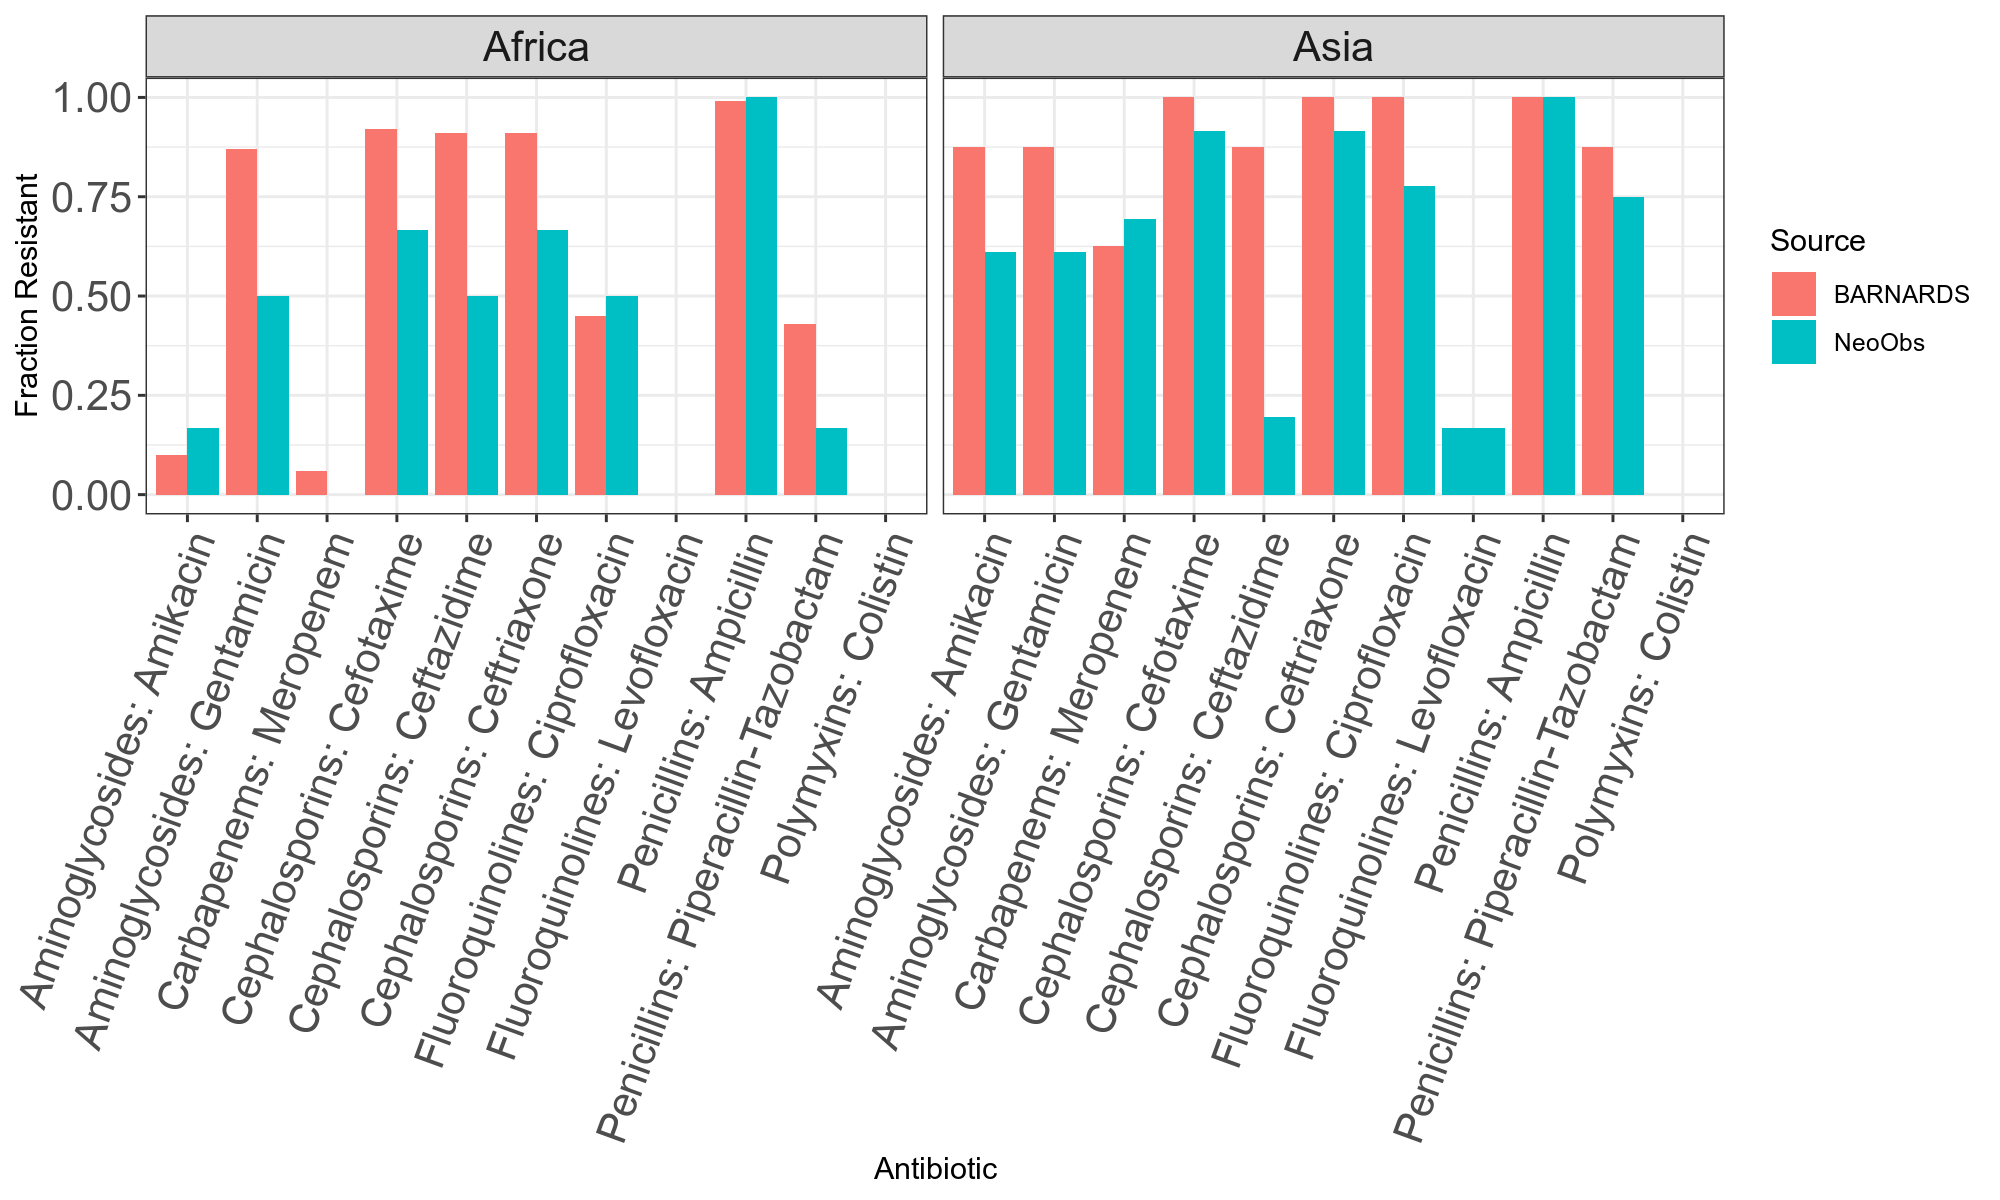

In [376]:
%%R -i supp_AMR -i out_path -w 10 -h 6 --units in -r 200
#positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(supp_AMR) + geom_col(aes(x = `drug`,
                                                  y = `frac_resistant`,
                                                  fill = Source),
                                             position = position_dodge()) + facet_wrap(~WHO_region) + theme(axis.text.x = element_text(angle = 70,
                                                                                                                                     hjust=1, size = 15),
                                                                                                          strip.text = element_text(size=15),
                                                                                                         axis.text.y = element_text(size = 15)) + ylab('Fraction Resistant') + xlab('Antibiotic')#+ scale_x_discrete(limits = positions) #+ geom_vline(xintercept = seq(4.5, 8, by = 3), color="#7CAE00", size=1, alpha=.5)

In [377]:
# other plots

In [378]:
overall_AMR_distribution = overall_AMR_distribution[~overall_AMR_distribution.drug.isin(['FOF1-ATPase INHIBITORS',
                                                                                        'OXAZOLIDINONES',
                                                                                        'POLYMIXINS',
                                                                                        'MACROLIDES'])]

In [379]:
overall_AMR_distribution.loc[np.logical_and(overall_AMR_distribution['pathogen'] != 'Staphylococcus aureus',
                                        overall_AMR_distribution.drug.isin(['Macrolides: Rifampicin',
                                                                            'Glycopeptides: Vancomycin',
                                                                            'Penicillins: Methicillin',
                                                                           'Oxazolidinones: Linezolid'])), ['resistance_cases', 'resistance_cases_lower', 'resistance_cases_upper']] = 0.0

In [380]:
overall_AMR_distribution.loc[np.logical_and(overall_AMR_distribution['pathogen'] != 'Staphylococcus aureus',
                                        overall_AMR_distribution.drug.isin(['Macrolides: Rifampicin',
                                                                            'Glycopeptides: Vancomycin',
                                                                            'Penicillins: Methicillin',
                                                                           'Oxazolidinones: Linezolid'])), ['resistance_deaths', 'resistance_deaths_lower', 'resistance_deaths_upper']] = 0.0

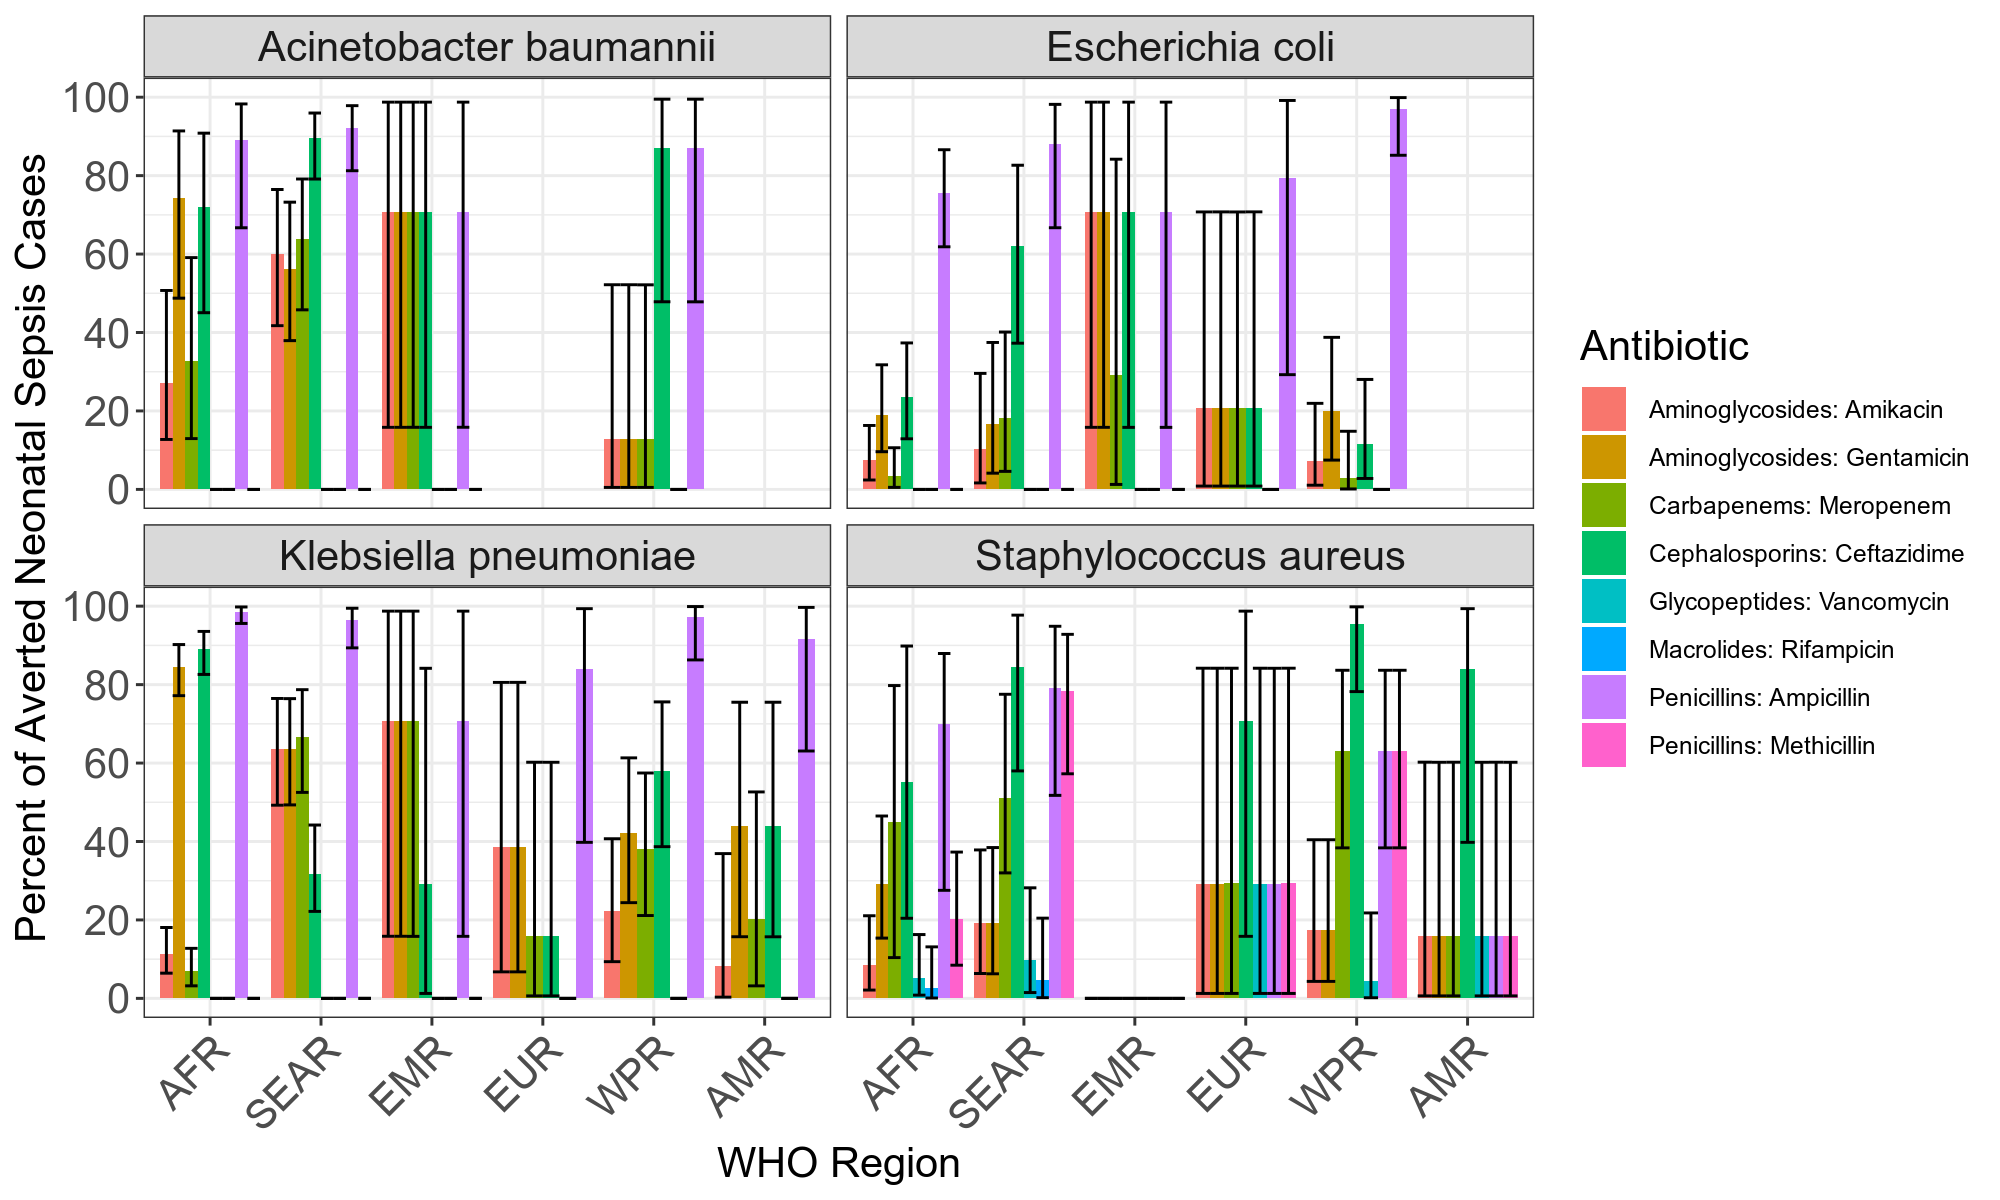

In [381]:
%%R -i overall_AMR_distribution -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
overall_AMR_distribution <- overall_AMR_distribution[overall_AMR_distribution$drug %in% c('Aminoglycosides: Amikacin',
                                                                                         'Aminoglycosides: Gentamicin',
                                                                                         'Carbapenems: Meropenem',
                                                                                         'Cephalosporins: Ceftazidime',
                                                                                         #'Penicillins: Amoxicillin-Clavulanic Acid',
                                                                                         'Penicillins: Ampicillin',
                                                                                         #'Penicillins: Piperacillin-Tazobactam',
                                                                                         'Penicillins: Methicillin',
                                                                                         'Glycopeptides: Vancomycin',
                                                                                         'Macrolides: Rifampicin'), ]
ggplot2::ggplot(overall_AMR_distribution,
                aes(x = `WHO Region`,
                   y = resistance_cases * 100,
                   fill = drug,
                   ymin = resistance_cases_lower * 100,
                   ymax = resistance_cases_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                facet_wrap(~pathogen) + theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                                              strip.text = element_text(size=15),
                                              axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_x_discrete(limits = positions) +
                scale_fill_discrete(name = "Antibiotic") +
                scale_y_continuous(name = 'Percent of Averted Neonatal Sepsis Cases',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

In [382]:
overall_AMR_distribution[overall_AMR_distribution['pathogen'] == 'Klebsiella pneumoniae'][overall_AMR_distribution['drug'] == 'Aminoglycosides: Amikacin'][['resistance_cases',
                                                                                                                                              'resistance_cases_upper',
                                                                                                                                              'resistance_cases_lower']].mean()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


resistance_cases          0.357999
resistance_cases_upper    0.585765
resistance_cases_lower    0.146606
dtype: float64

In [383]:
overall_AMR_distribution[overall_AMR_distribution['pathogen'] == 'Klebsiella pneumoniae'][overall_AMR_distribution['drug'] == 'Penicillins: Ampicillin'][['resistance_cases',
                                                                                                                                              'resistance_cases_upper',
                                                                                                                                              'resistance_cases_lower']].mean()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


resistance_cases          0.898223
resistance_cases_upper    0.994941
resistance_cases_lower    0.649921
dtype: float64

In [384]:
overall_AMR_distribution[overall_AMR_distribution['pathogen'] == 'Klebsiella pneumoniae'][overall_AMR_distribution['drug'] == 'Aminoglycosides: Gentamicin'][['resistance_cases',
                                                                                                                                              'resistance_cases_upper',
                                                                                                                                              'resistance_cases_lower']].mean()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


resistance_cases          0.572213
resistance_cases_upper    0.804639
resistance_cases_lower    0.315402
dtype: float64

In [385]:
overall_AMR_distribution[overall_AMR_distribution['pathogen'] == 'Klebsiella pneumoniae'][overall_AMR_distribution['drug'] == 'Aminoglycosides: Amikacin'][['resistance_cases',
                                                                                                                                              'resistance_cases_upper',
                                                                                                                                              'resistance_cases_lower']].mean()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


resistance_cases          0.357999
resistance_cases_upper    0.585765
resistance_cases_lower    0.146606
dtype: float64

In [386]:
overall_AMR_distribution[overall_AMR_distribution['pathogen'] == 'Klebsiella pneumoniae'][overall_AMR_distribution['drug'] == 'Cephalosporins: Ceftazidime'][['resistance_cases',
                                                                                                                                              'resistance_cases_upper',
                                                                                                                                              'resistance_cases_lower']].mean()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


resistance_cases          0.446326
resistance_cases_upper    0.722048
resistance_cases_lower    0.268413
dtype: float64

In [387]:
overall_AMR_distribution[overall_AMR_distribution['pathogen'] == 'Klebsiella pneumoniae'][overall_AMR_distribution['WHO Region'] == 'SEAR'][overall_AMR_distribution['drug'] == 'Carbapenems: Meropenem'][['resistance_cases',
                                                                                                                                              'resistance_cases_upper',
                                                                                                                                              'resistance_cases_lower']]

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


resistance_cases  resistance_cases_upper  resistance_cases_lower
76          0.665854                0.787172                0.525179

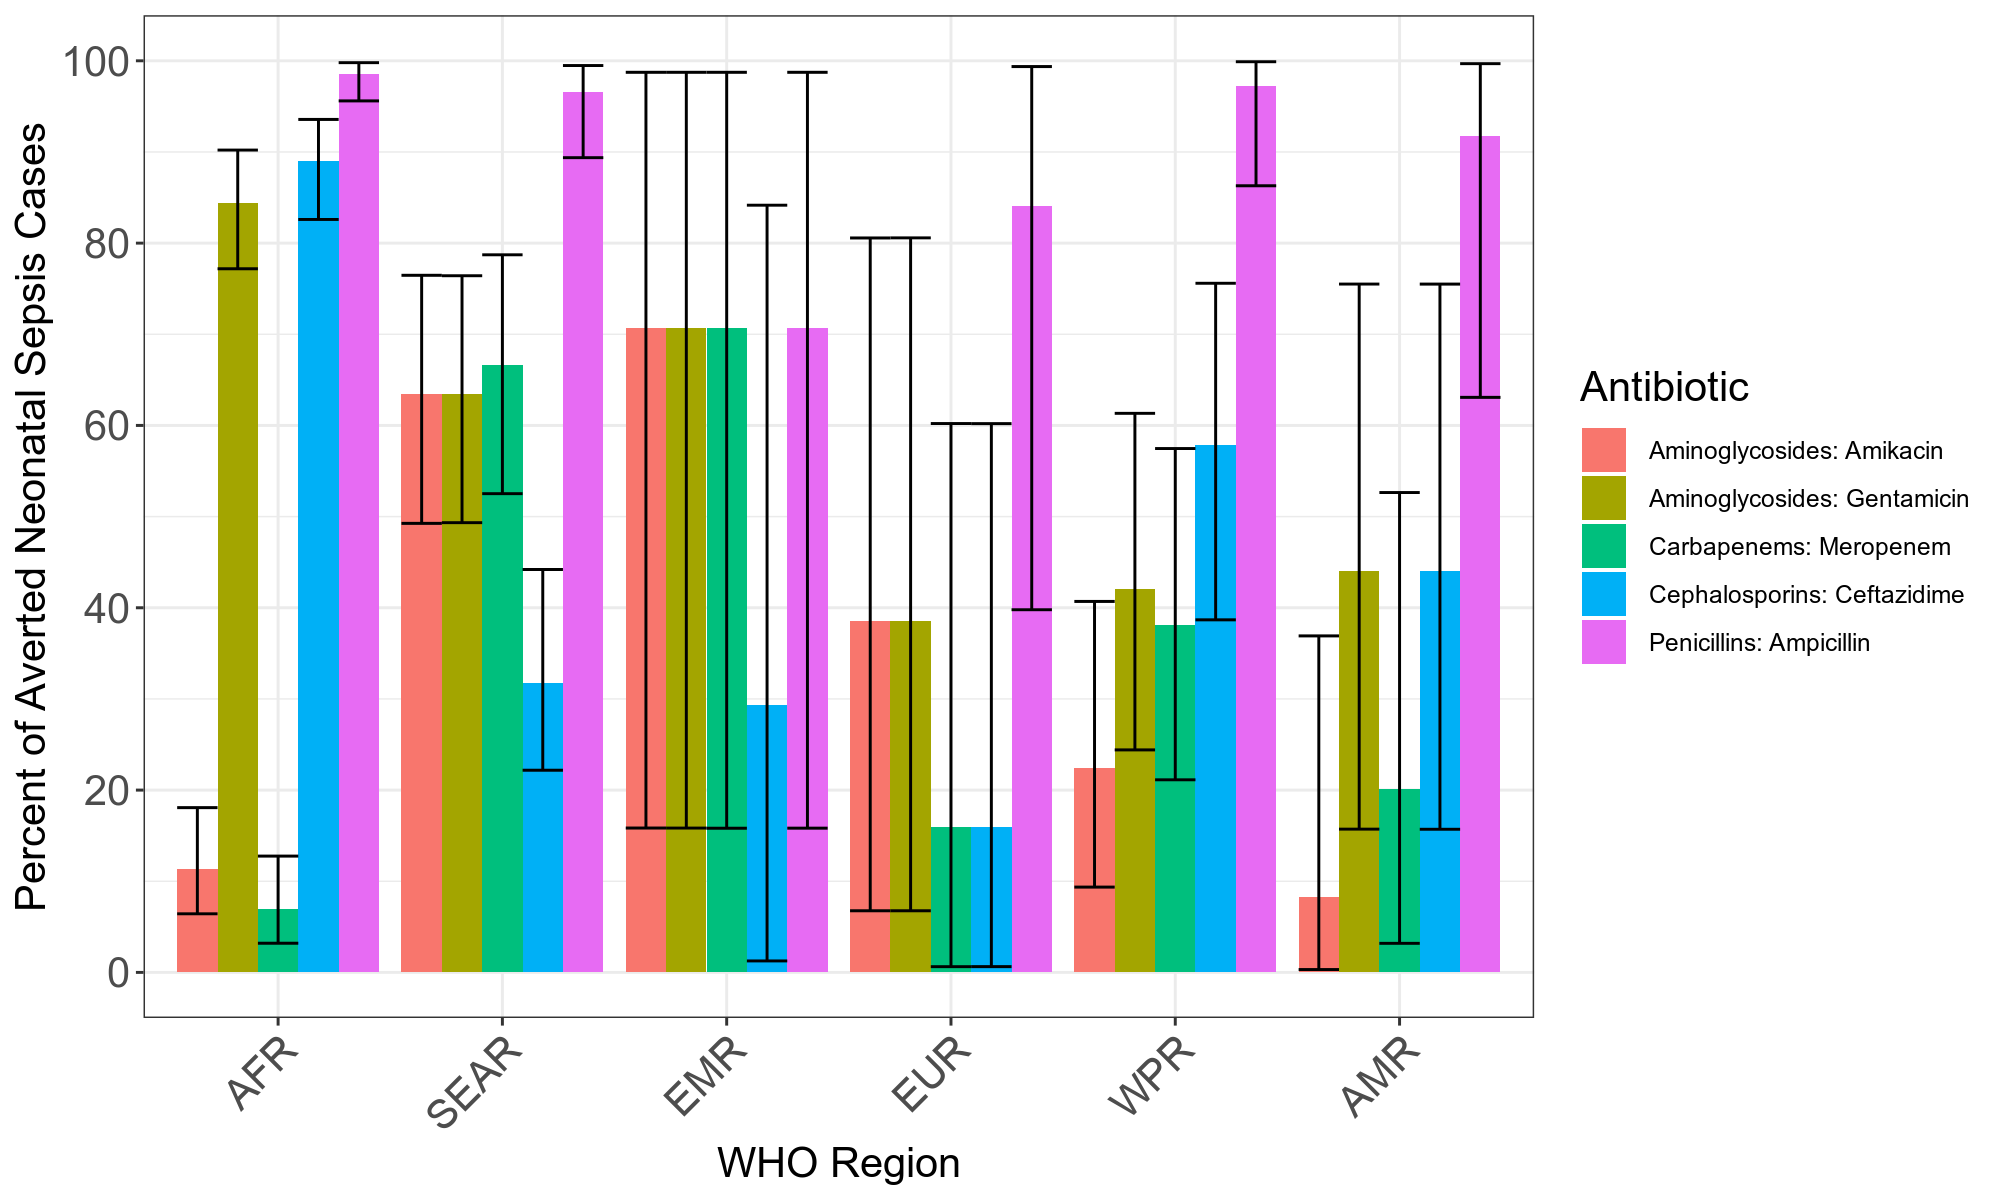

In [388]:
%%R -i overall_AMR_distribution -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
overall_AMR_distribution <- overall_AMR_distribution[overall_AMR_distribution$pathogen == 'Klebsiella pneumoniae', ]
overall_AMR_distribution <- overall_AMR_distribution[overall_AMR_distribution$drug %in% c('Aminoglycosides: Amikacin',
                                                                                         'Aminoglycosides: Gentamicin',
                                                                                         'Carbapenems: Meropenem',
                                                                                         'Cephalosporins: Ceftazidime',
                                                                                         #'Penicillins: Amoxicillin-Clavulanic Acid',
                                                                                         'Penicillins: Ampicillin'), ]
                                                                                         #'Penicillins: Piperacillin-Tazobactam'), ]
ggplot2::ggplot(overall_AMR_distribution,
                aes(x = `WHO Region`,
                   y = resistance_cases * 100,
                   fill = drug,
                   ymin = resistance_cases_lower * 100,
                   ymax = resistance_cases_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                                              strip.text = element_text(size=15),
                                              axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_x_discrete(limits = positions) +
                scale_fill_discrete(name = "Antibiotic") +
                scale_y_continuous(name = 'Percent of Averted Neonatal Sepsis Cases',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

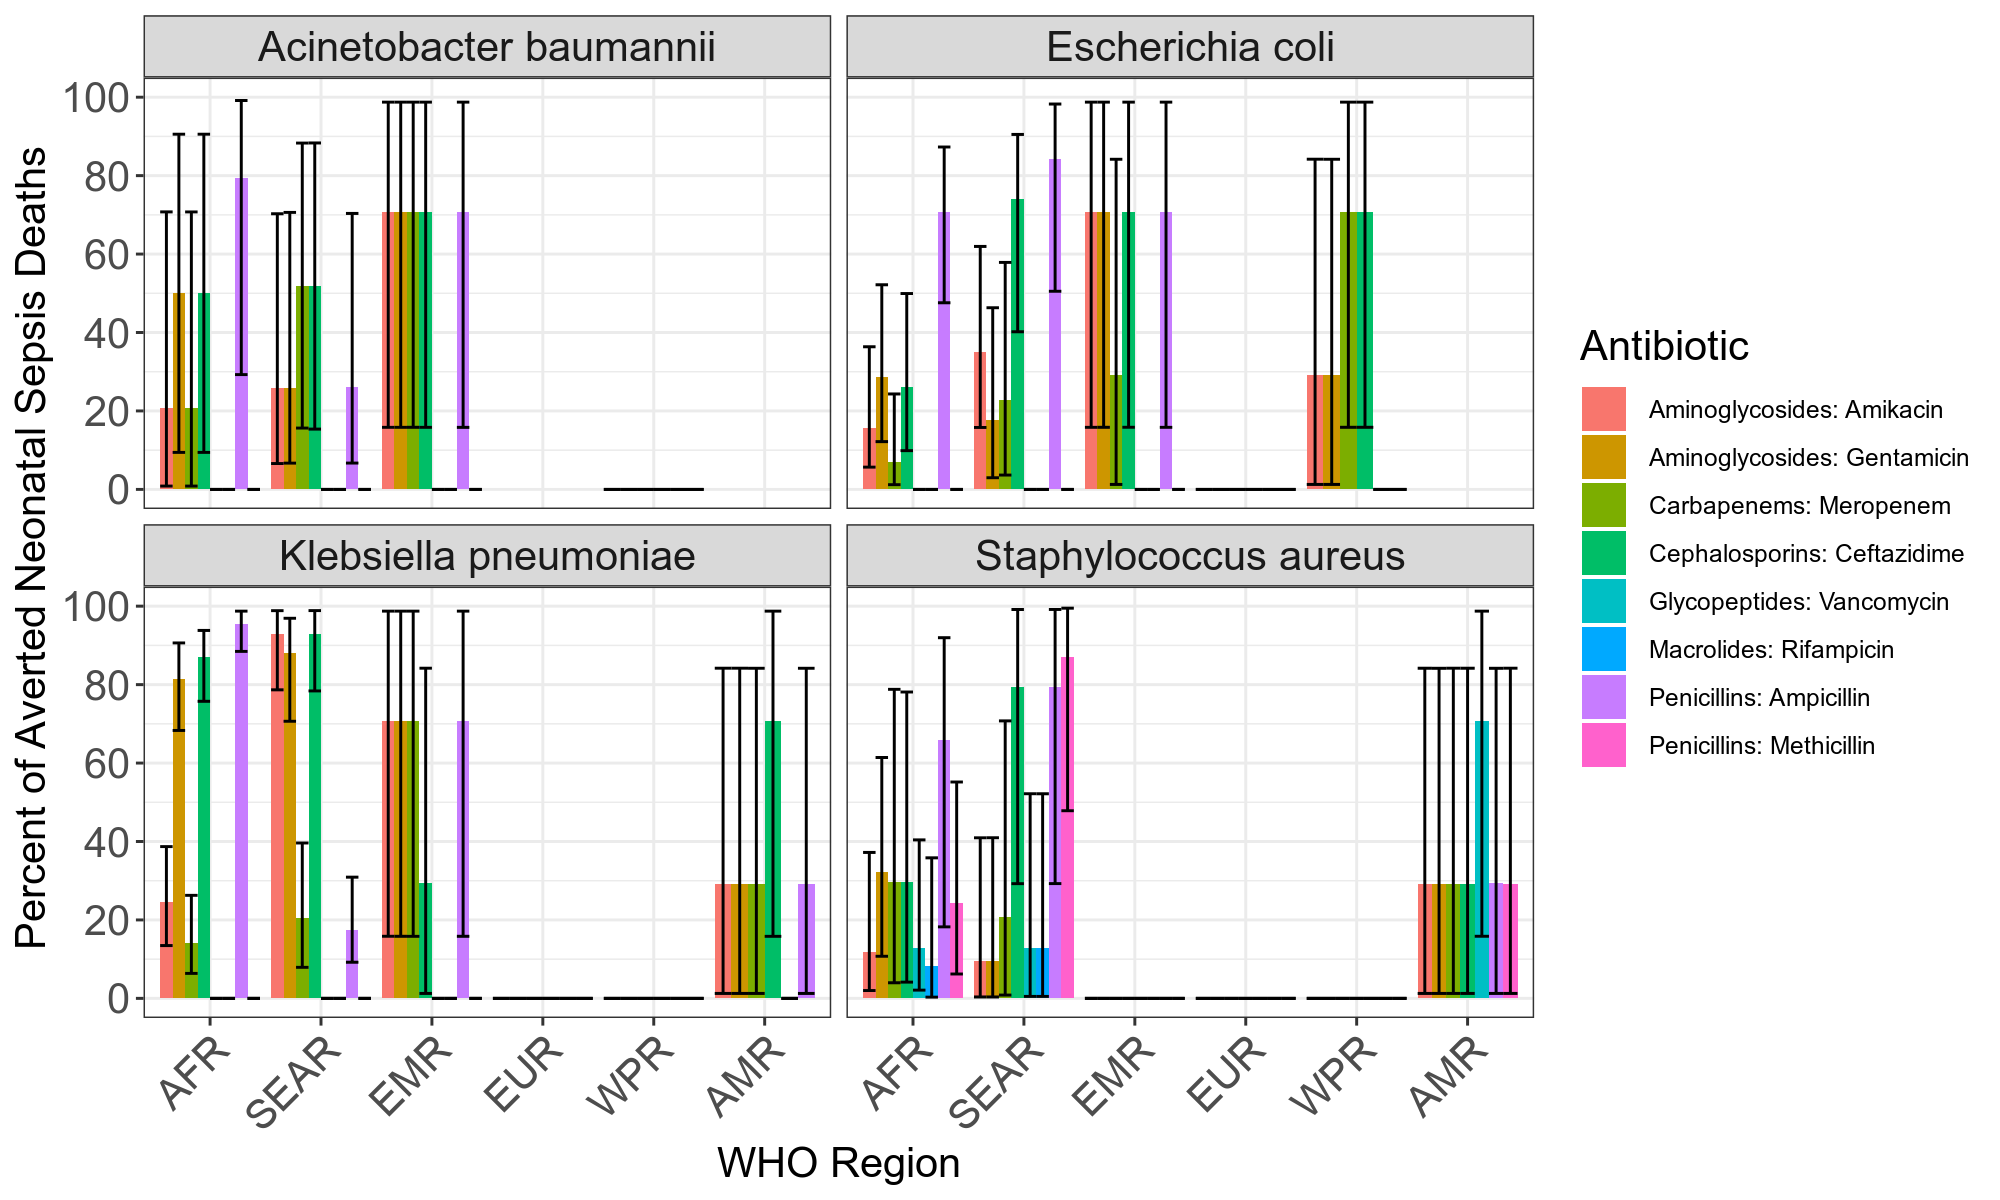

In [389]:
%%R -i overall_AMR_distribution -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
overall_AMR_distribution <- overall_AMR_distribution[overall_AMR_distribution$drug %in% c('Aminoglycosides: Amikacin',
                                                                                         'Aminoglycosides: Gentamicin',
                                                                                         'Carbapenems: Meropenem',
                                                                                         'Cephalosporins: Ceftazidime',
                                                                                         #'Penicillins: Amoxicillin-Clavulanic Acid',
                                                                                         'Penicillins: Ampicillin',
                                                                                         #'Penicillins: Piperacillin-Tazobactam',
                                                                                         'Penicillins: Methicillin',
                                                                                         'Glycopeptides: Vancomycin',
                                                                                         'Macrolides: Rifampicin'), ]
ggplot2::ggplot(overall_AMR_distribution,
                aes(x = `WHO Region`,
                   y = resistance_deaths * 100,
                   fill = drug,
                   ymin = resistance_deaths_lower * 100,
                   ymax = resistance_deaths_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                facet_wrap(~pathogen) + theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                                              strip.text = element_text(size=15),
                                              axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_x_discrete(limits = positions) +
                scale_fill_discrete(name = "Antibiotic") +
                scale_y_continuous(name = 'Percent of Averted Neonatal Sepsis Deaths',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

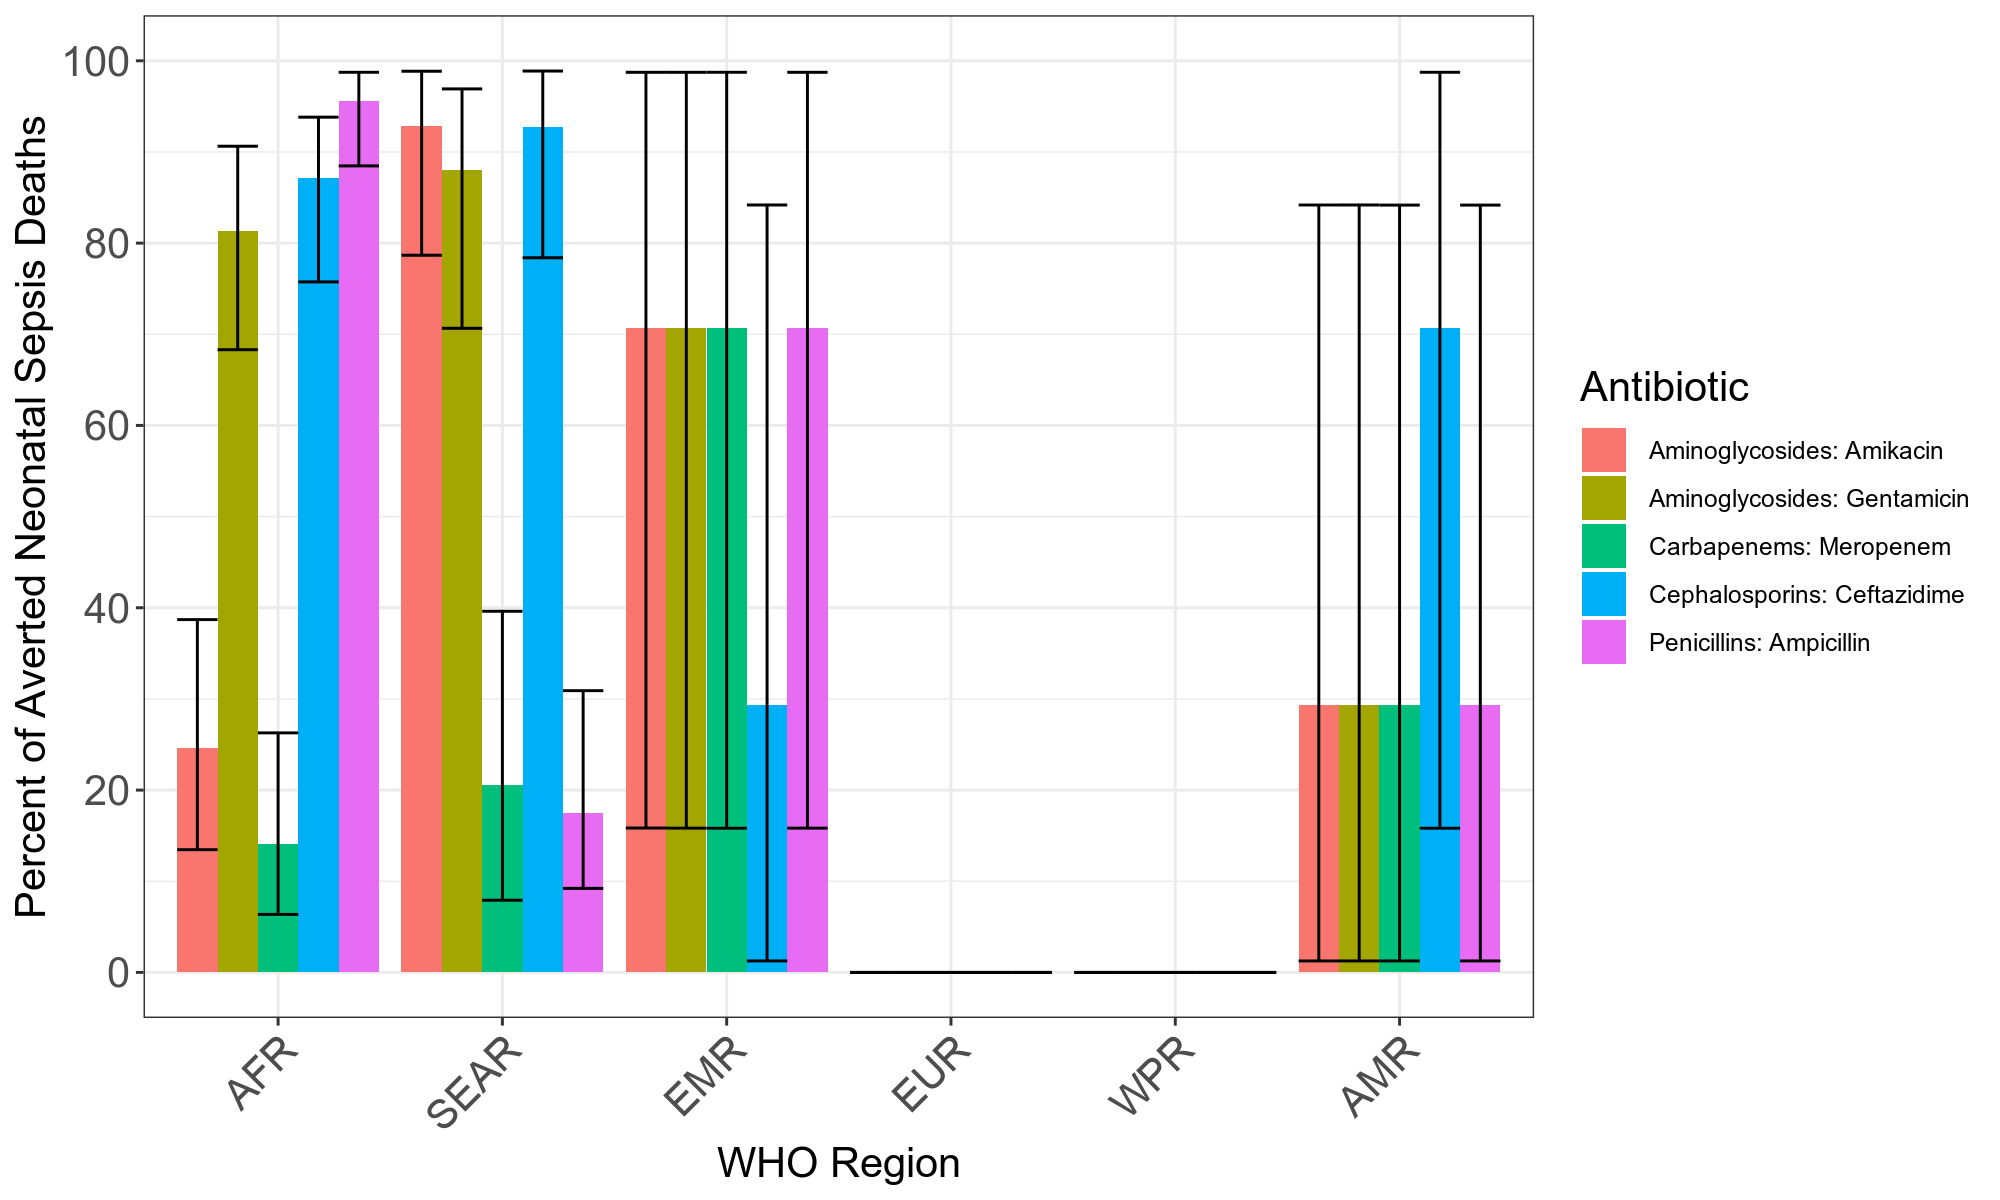

In [390]:
%%R -i overall_AMR_distribution -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
overall_AMR_distribution = overall_AMR_distribution[overall_AMR_distribution$pathogen == 'Klebsiella pneumoniae', ]
overall_AMR_distribution <- overall_AMR_distribution[overall_AMR_distribution$drug %in% c('Aminoglycosides: Amikacin',
                                                                                         'Aminoglycosides: Gentamicin',
                                                                                         'Carbapenems: Meropenem',
                                                                                         'Cephalosporins: Ceftazidime',
                                                                                         #'Penicillins: Amoxicillin-Clavulanic Acid',
                                                                                         'Penicillins: Ampicillin'), ]
                                                                                         #'Penicillins: Piperacillin-Tazobactam'), ]

ggplot2::ggplot(overall_AMR_distribution,
                aes(x = `WHO Region`,
                   y = resistance_deaths * 100,
                   fill = drug,
                   ymin = resistance_deaths_lower * 100,
                   ymax = resistance_deaths_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                                              strip.text = element_text(size=15),
                                              axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_x_discrete(limits = positions) +
                scale_fill_discrete(name = "Antibiotic") +
                scale_y_continuous(name = 'Percent of Averted Neonatal Sepsis Deaths',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

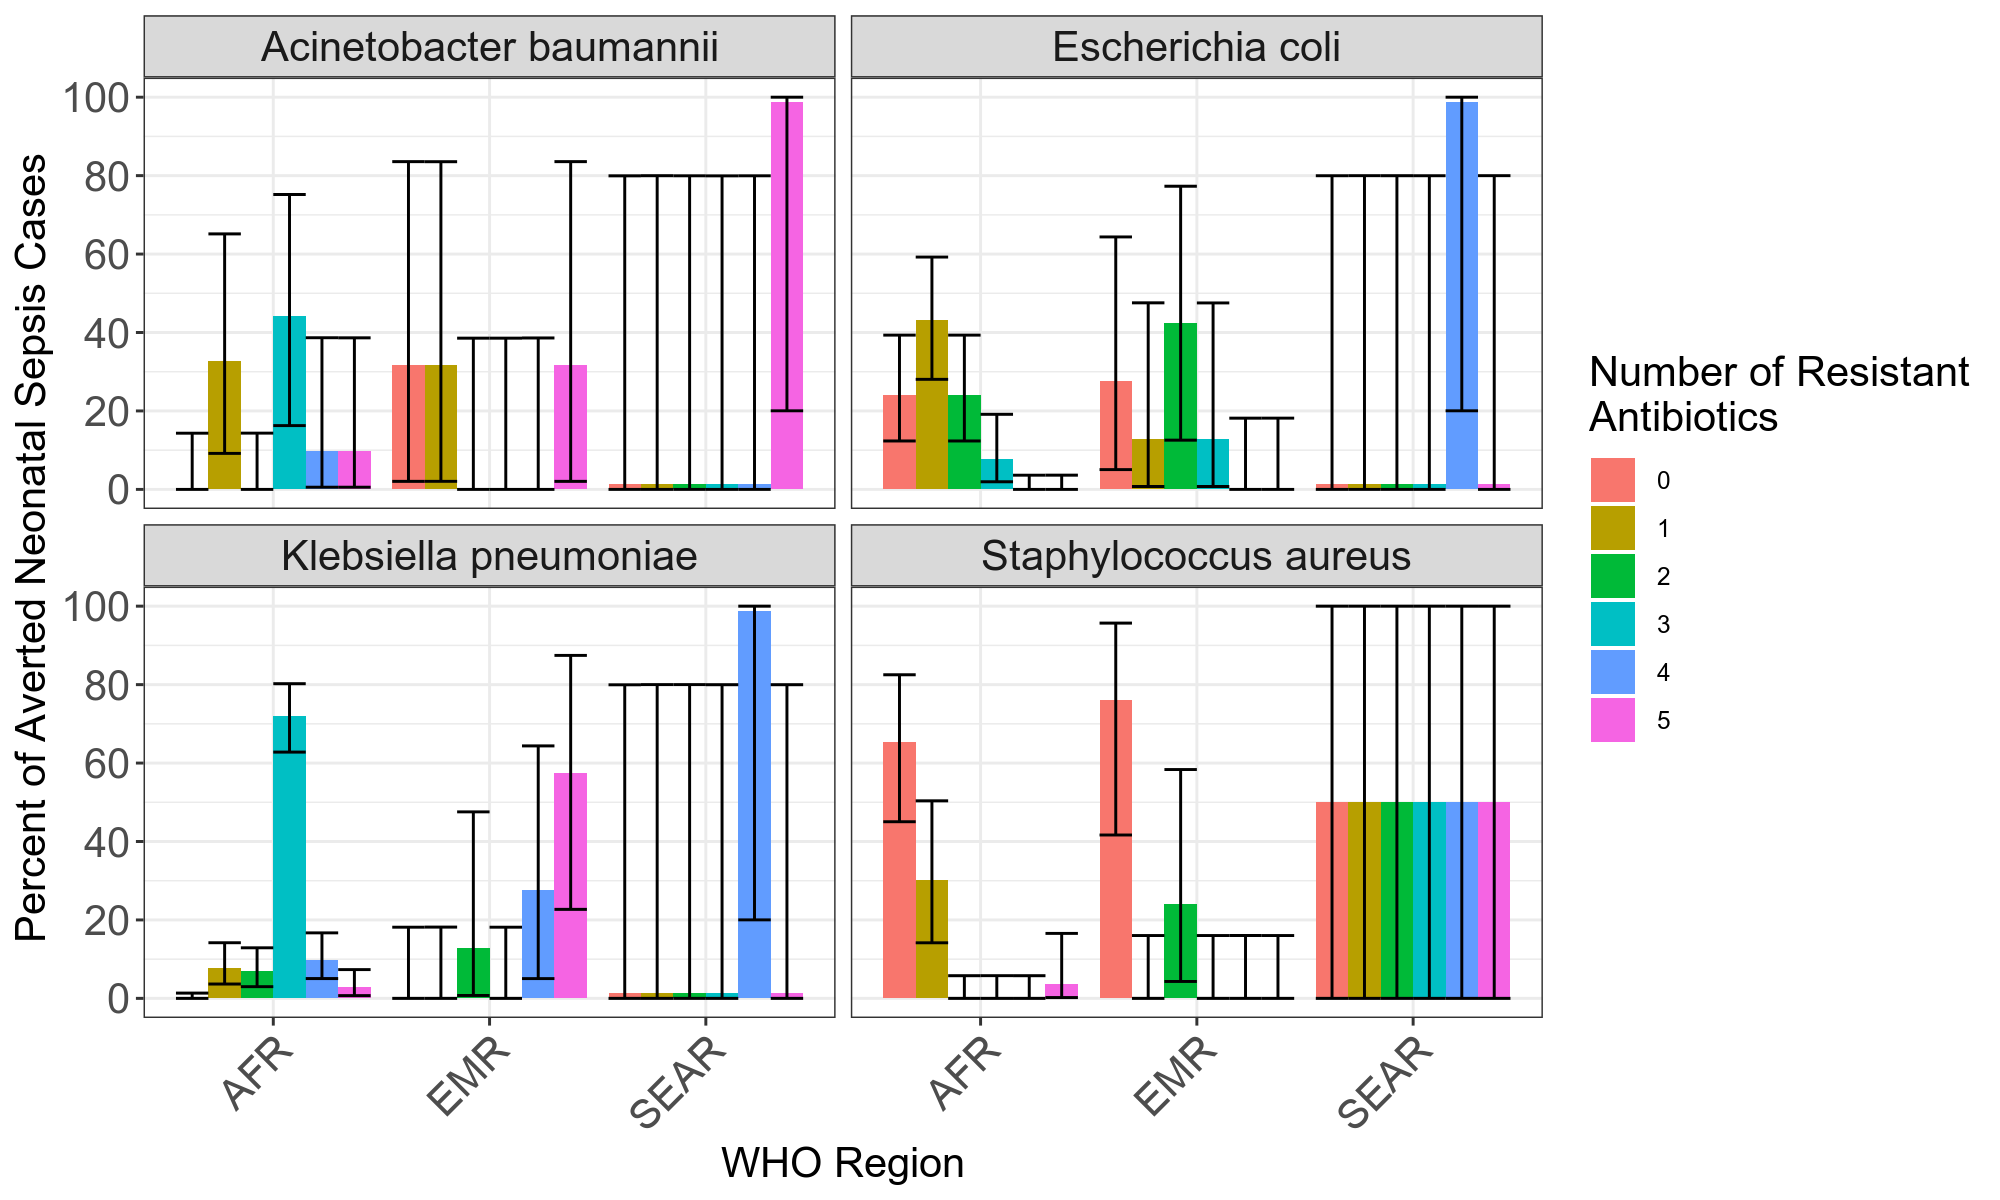

In [391]:
%%R -i barnards_MDR_distribution_main -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(barnards_MDR_distribution_main,
                aes(x = `WHO Region`,
                   y = resistance_cases * 100,
                   fill = as.factor(MDR),
                   ymin = resistance_cases_lower * 100,
                   ymax = resistance_cases_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                facet_wrap(~pathogen) + theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                                              strip.text = element_text(size=15),
                                              axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Number of Resistant\nAntibiotics") +
                scale_y_continuous(name = 'Percent of Averted Neonatal Sepsis Cases',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

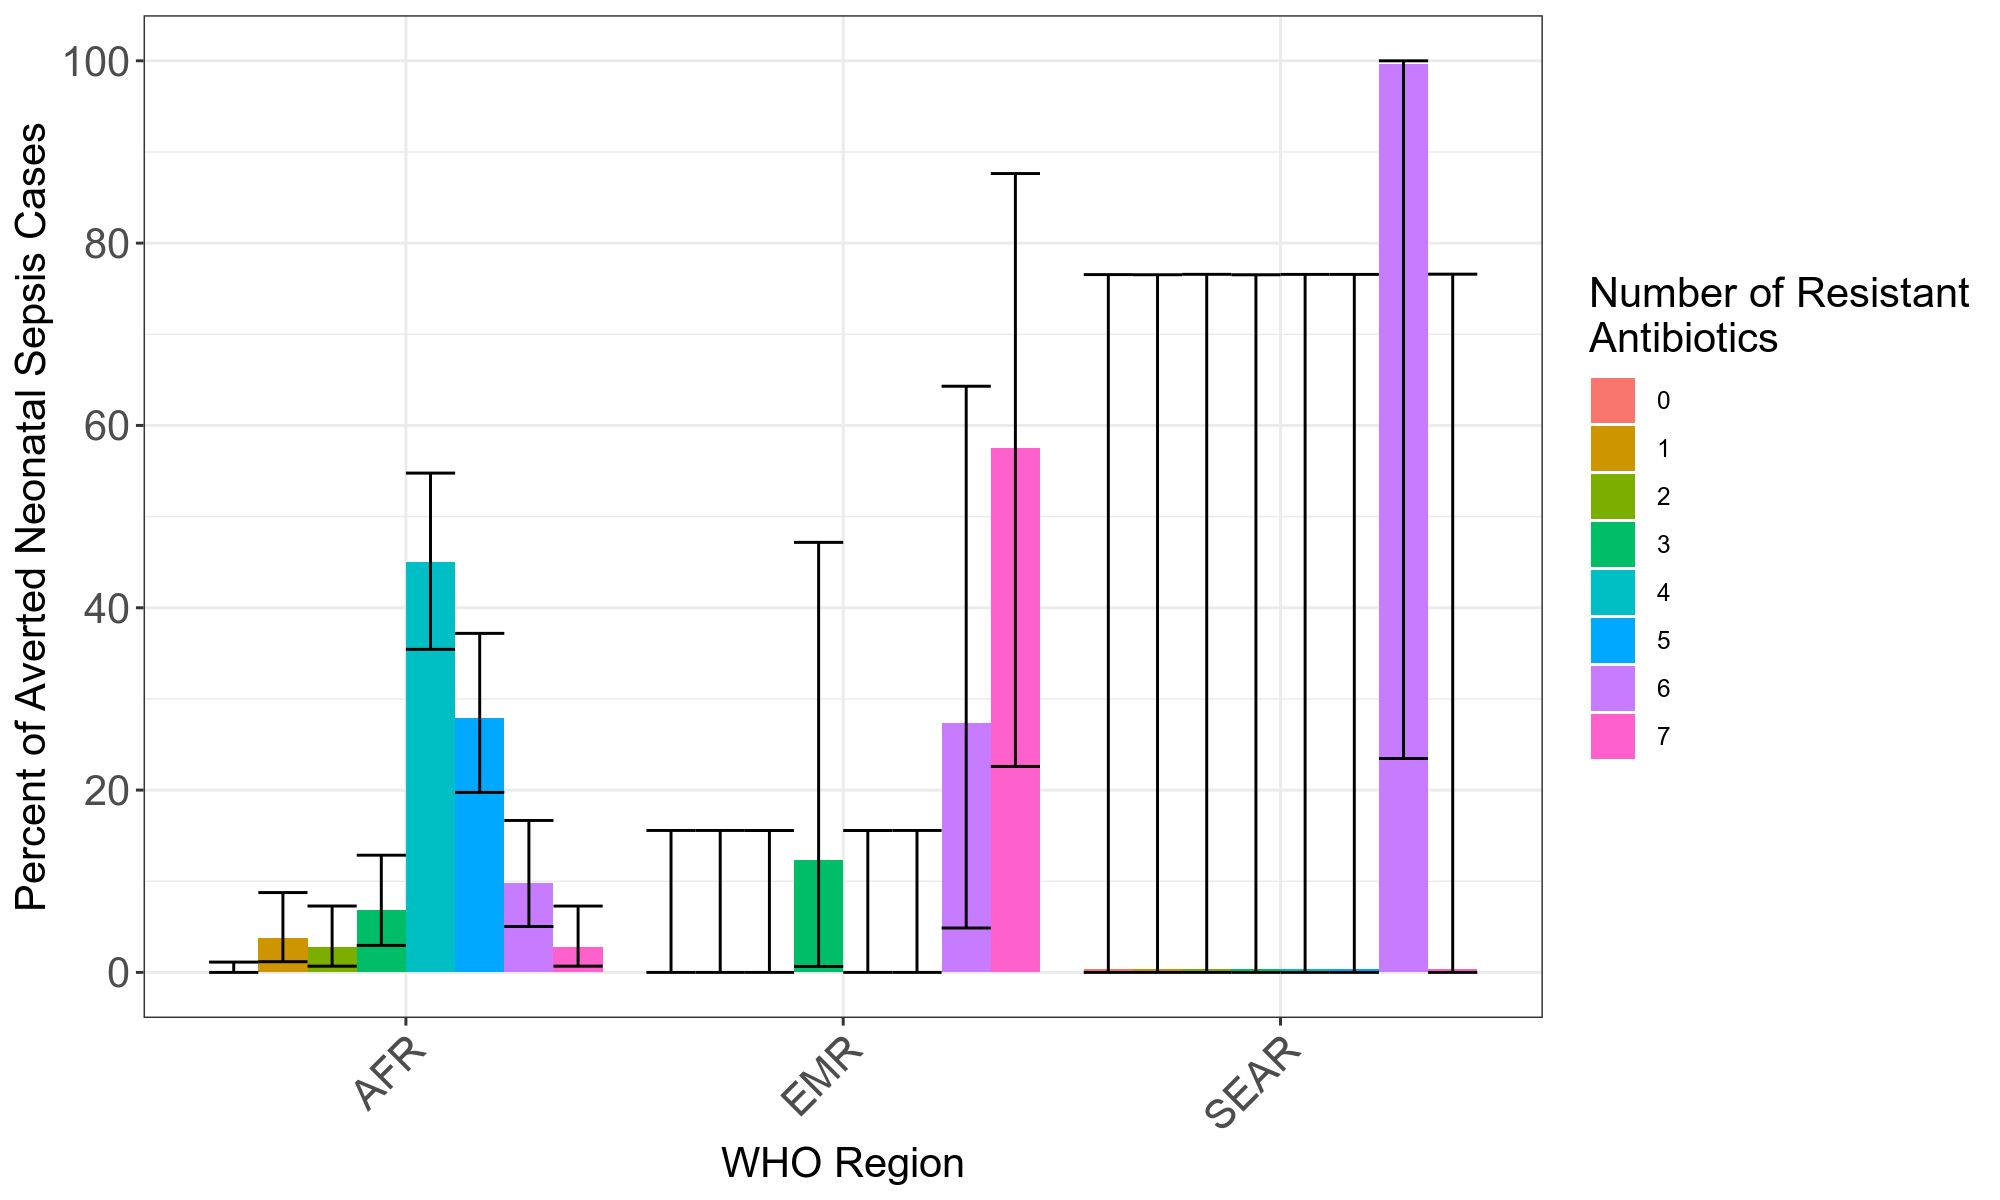

In [392]:
%%R -i barnards_MDR_distribution -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
barnards_MDR_distribution = barnards_MDR_distribution[barnards_MDR_distribution$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(barnards_MDR_distribution,
                aes(x = `WHO Region`,
                   y = resistance_cases * 100,
                   fill = as.factor(MDR),
                   ymin = resistance_cases_lower * 100,
                   ymax = resistance_cases_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Number of Resistant\nAntibiotics") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Cases',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

In [393]:
1 - barnards_MDR_distribution_main[barnards_MDR_distribution_main.pathogen == 'Klebsiella pneumoniae'][barnards_MDR_distribution_main.MDR == 0]['resistance_deaths'].mean()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.9945181358067768

In [394]:
barnards_MDR_distribution_main[barnards_MDR_distribution_main.pathogen == 'Klebsiella pneumoniae'][barnards_MDR_distribution_main.MDR == 0]['resistance_cases'].median()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.0014867474683282807

In [395]:
barnards_MDR_distribution_main[barnards_MDR_distribution_main.pathogen == 'Klebsiella pneumoniae'][barnards_MDR_distribution_main.MDR == 0]['resistance_cases_lower'].median()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2.3328536254427383e-11

In [396]:
barnards_MDR_distribution_main[barnards_MDR_distribution_main.pathogen == 'Klebsiella pneumoniae'][barnards_MDR_distribution_main.MDR == 0]['resistance_cases_upper'].median()

.:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.18150333529500343

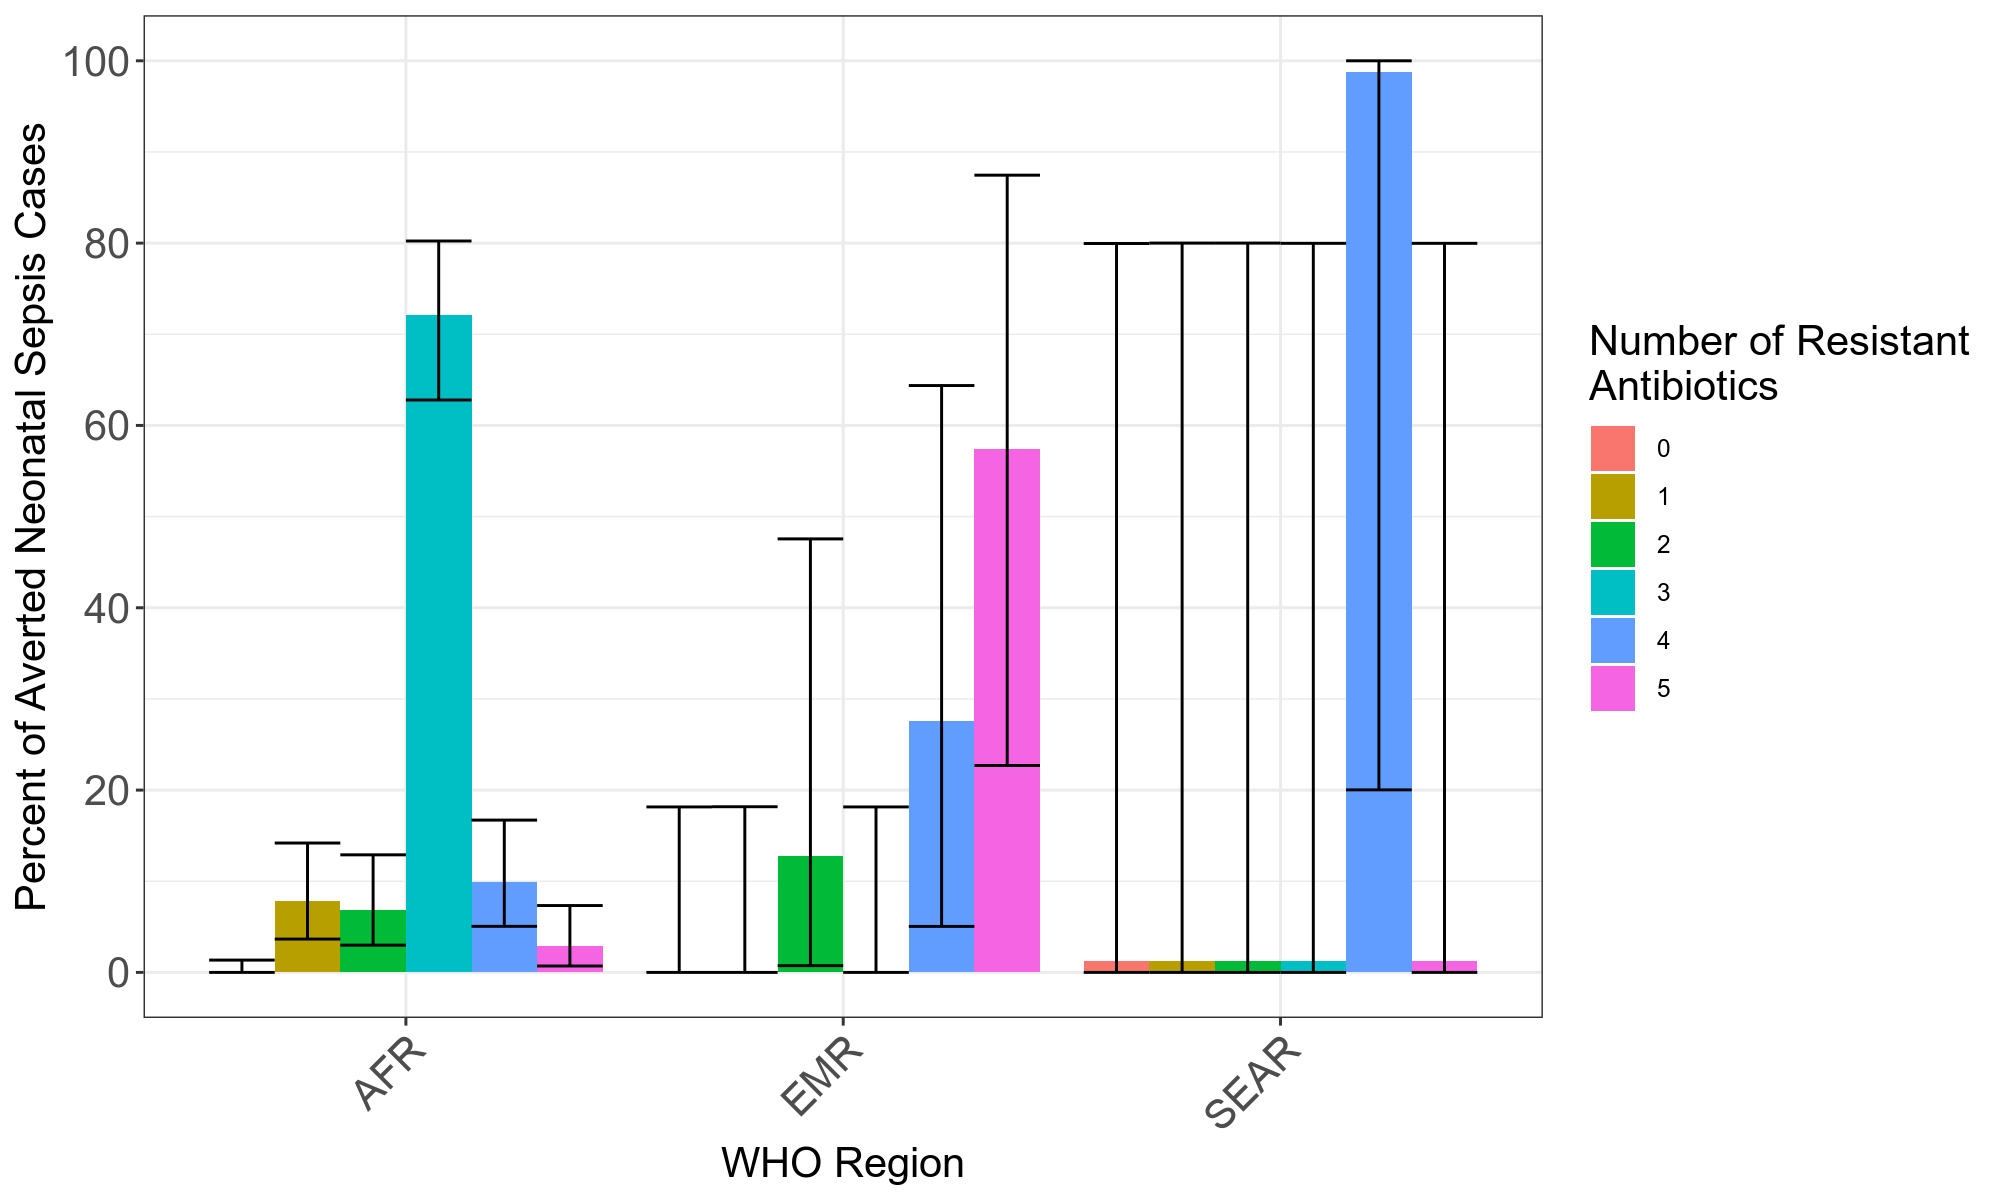

In [397]:
%%R -i barnards_MDR_distribution_main -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
barnards_MDR_distribution_main = barnards_MDR_distribution_main[barnards_MDR_distribution_main$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(barnards_MDR_distribution_main,
                aes(x = `WHO Region`,
                   y = resistance_cases * 100,
                   fill = as.factor(MDR),
                   ymin = resistance_cases_lower * 100,
                   ymax = resistance_cases_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Number of Resistant\nAntibiotics") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Cases',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

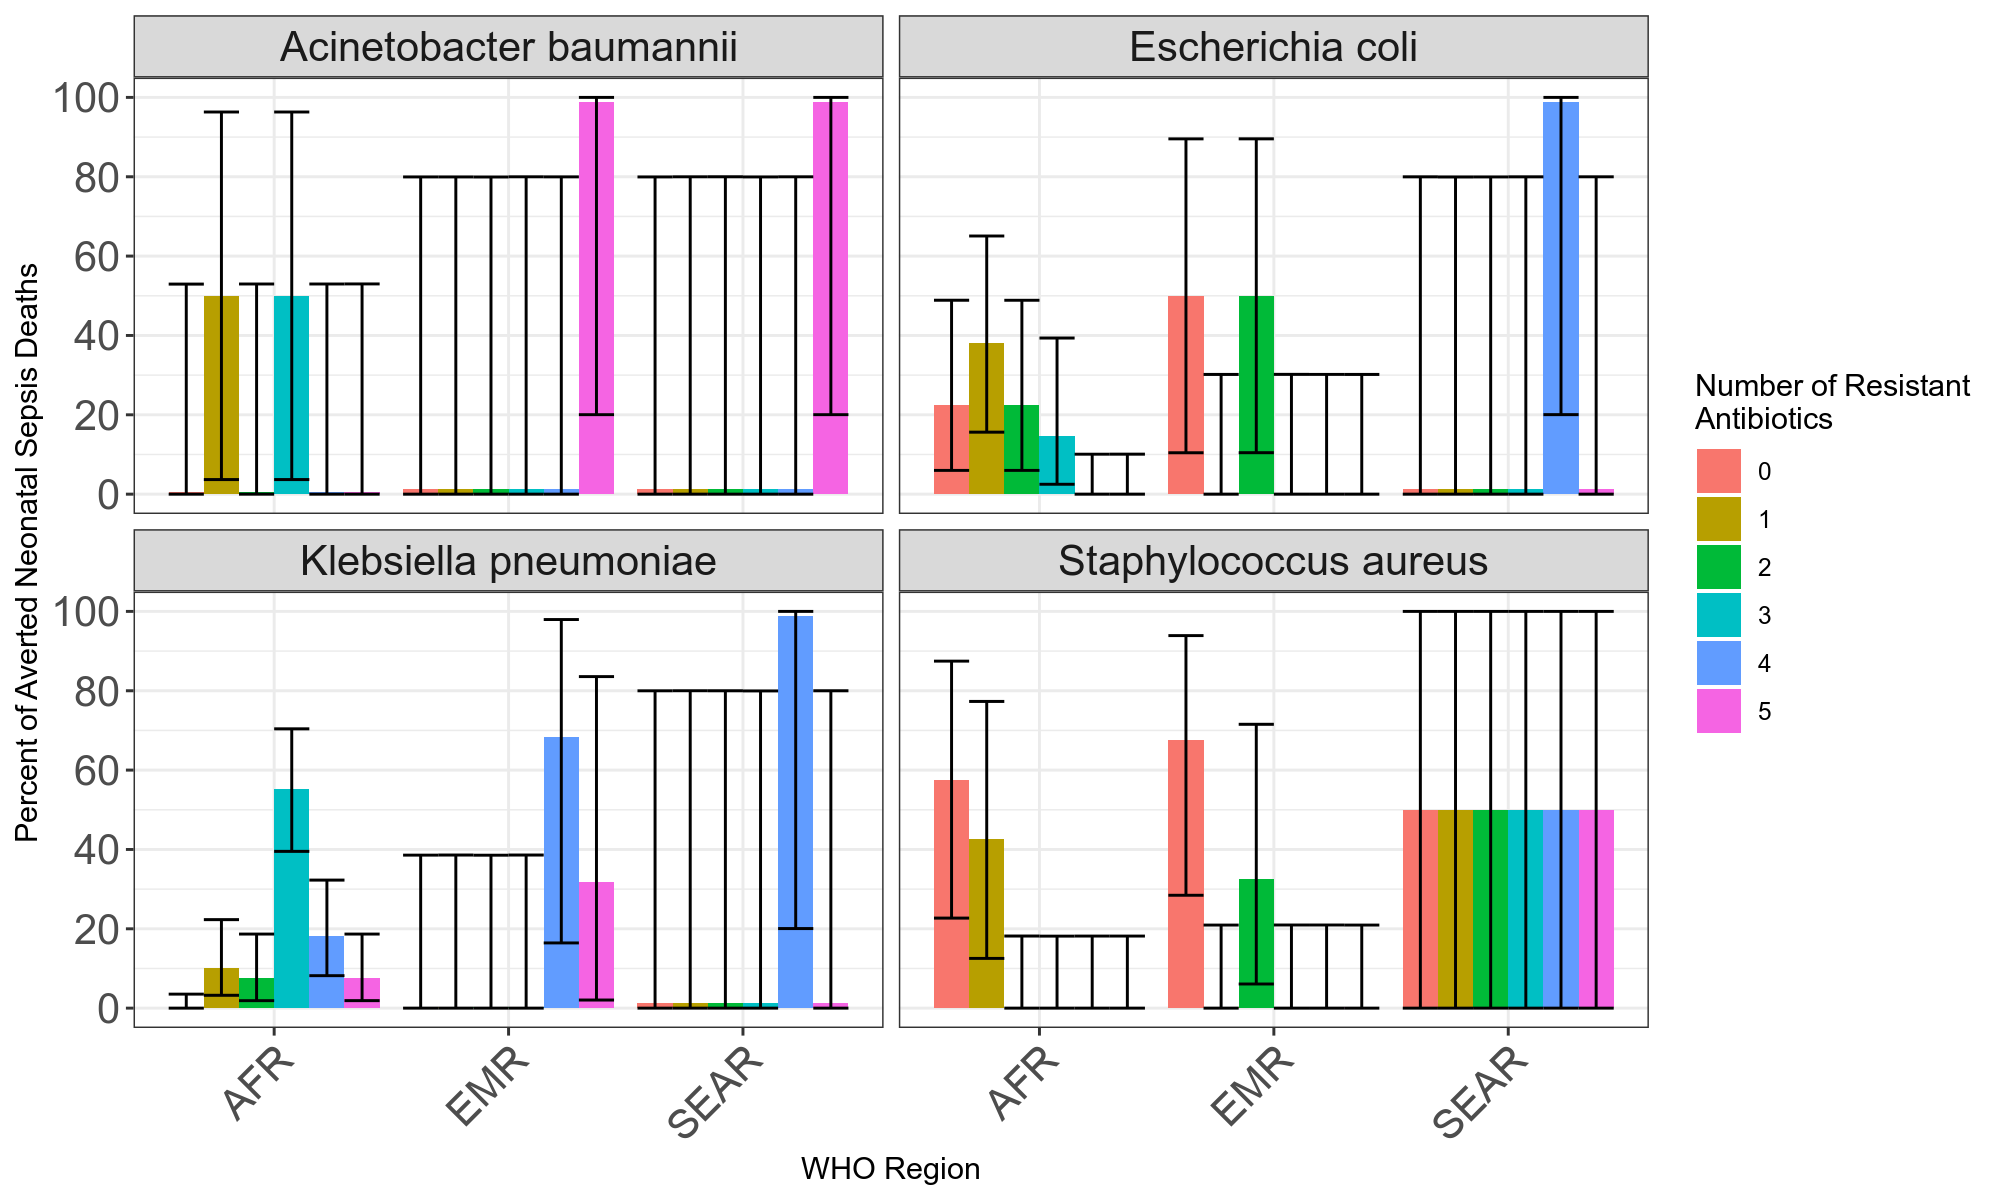

In [398]:
%%R -i barnards_MDR_distribution_main -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(barnards_MDR_distribution_main,
                aes(x = `WHO Region`,
                   y = resistance_deaths * 100,
                   fill = as.factor(MDR),
                   ymin = resistance_deaths_lower * 100,
                   ymax = resistance_deaths_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                facet_wrap(~pathogen) + theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                                              strip.text = element_text(size=15),
                                              axis.text.y = element_text(size = 15)) +
                scale_fill_discrete(name = "Number of Resistant\nAntibiotics") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Deaths',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

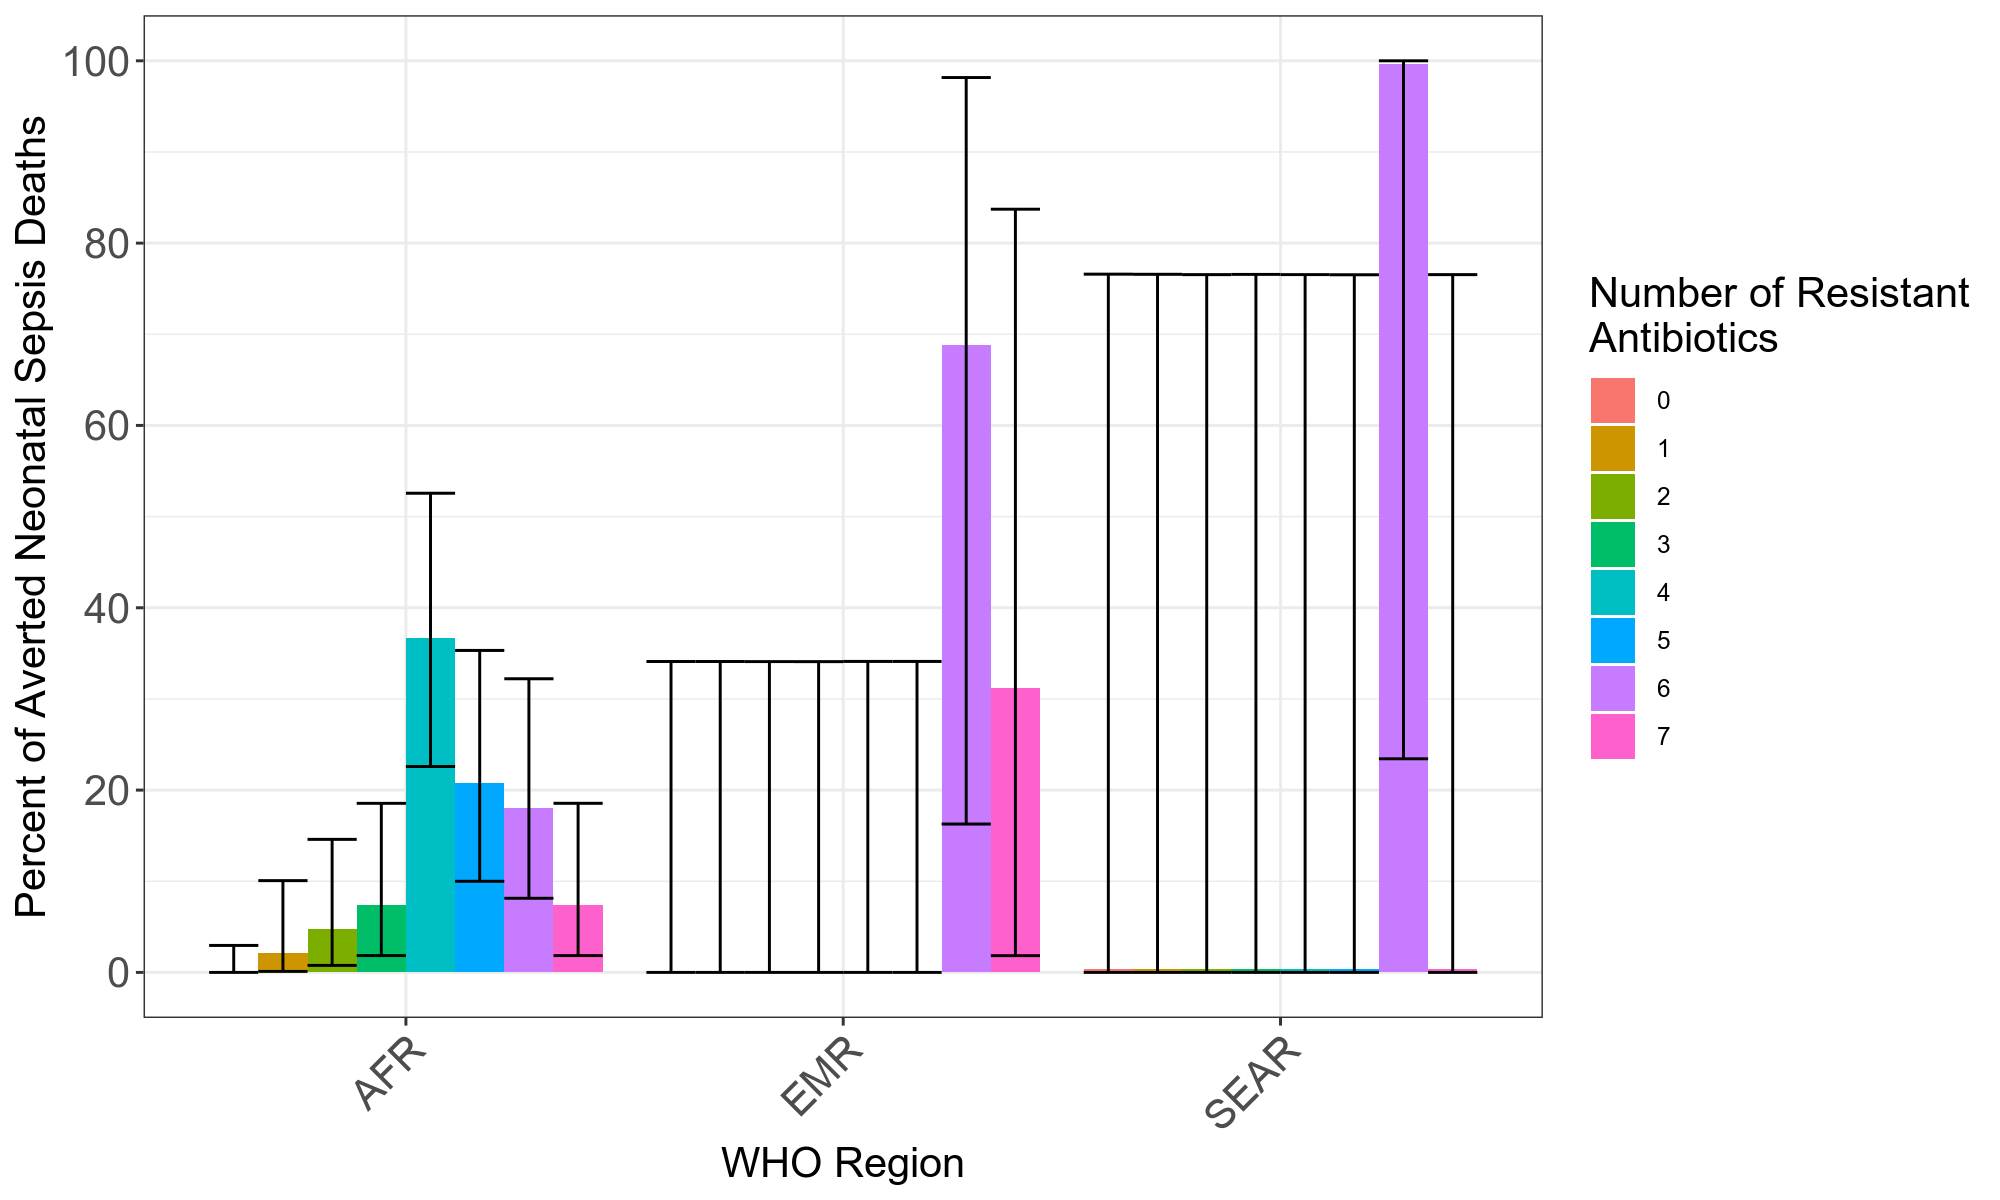

In [399]:
%%R -i barnards_MDR_distribution -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
barnards_MDR_distribution = barnards_MDR_distribution[barnards_MDR_distribution$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(barnards_MDR_distribution,
                aes(x = `WHO Region`,
                   y = resistance_deaths * 100,
                   fill = as.factor(MDR),
                   ymin = resistance_deaths_lower * 100,
                   ymax = resistance_deaths_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Number of Resistant\nAntibiotics") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Deaths',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

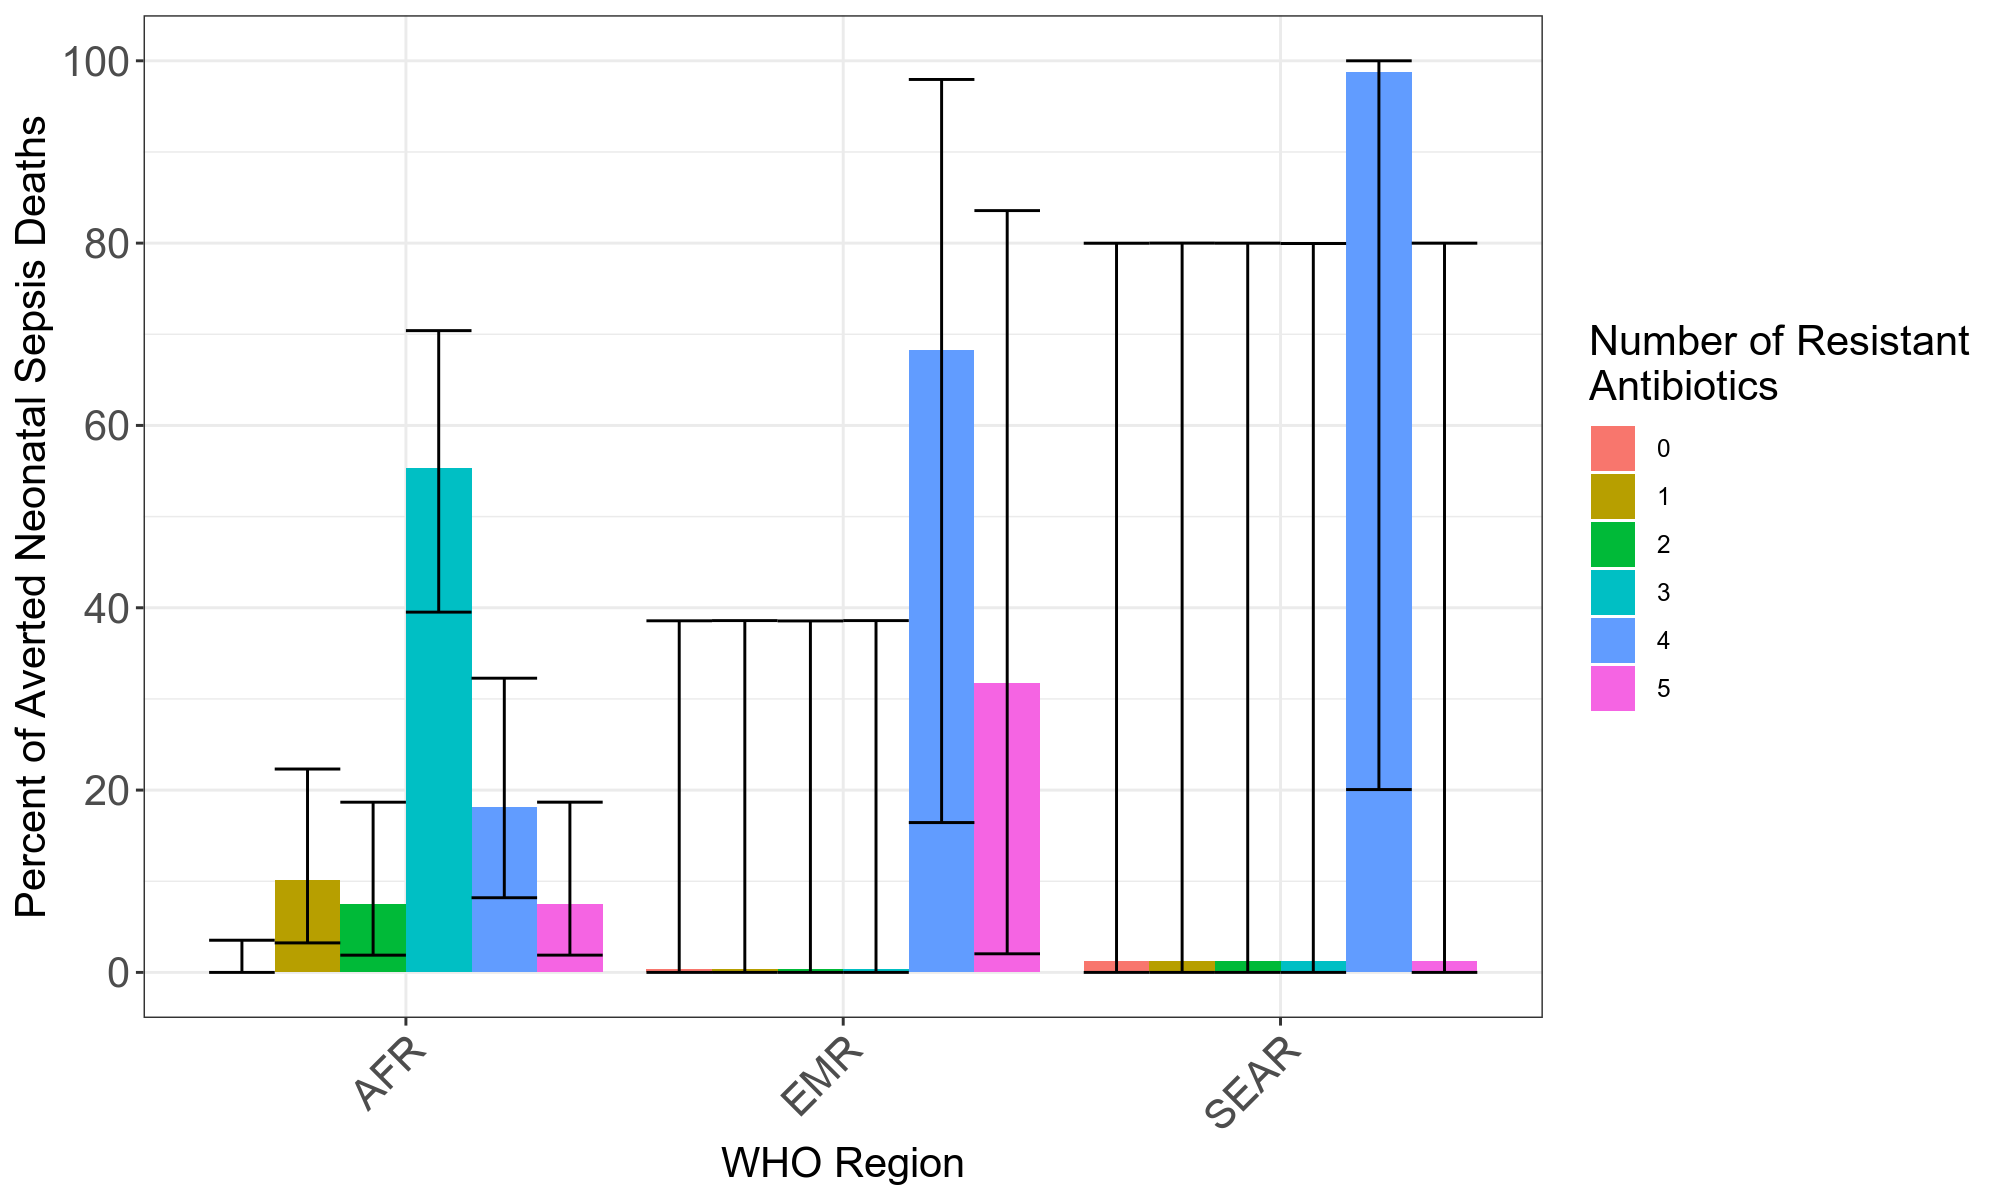

In [400]:
%%R -i barnards_MDR_distribution_main -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
barnards_MDR_distribution_main = barnards_MDR_distribution_main[barnards_MDR_distribution_main$pathogen == 'Klebsiella pneumoniae', ]
ggplot2::ggplot(barnards_MDR_distribution_main,
                aes(x = `WHO Region`,
                   y = resistance_deaths * 100,
                   fill = as.factor(MDR),
                   ymin = resistance_deaths_lower * 100,
                   ymax = resistance_deaths_upper * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Number of Resistant\nAntibiotics") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Deaths',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100))

In [401]:
# joint distributions from amikacin ceftazidime

In [402]:
joint = barnards_AMR[barnards_AMR.FINALSPECIESID == 'Klebsiella pneumoniae'][['OUTCOME_x', 'Aminoglycosides: Amikacin', 'Cephalosporins: Ceftazidime',
                                                                     'WHO_region', 'cases']]

In [403]:
joint['Resistance'] = ['2 Both' if joint['Cephalosporins: Ceftazidime'].iloc[i] == 1 and joint['Aminoglycosides: Amikacin'].iloc[i] == 1 else '1 Amikacin Only' if joint['Cephalosporins: Ceftazidime'].iloc[i] == 0 and joint['Aminoglycosides: Amikacin'].iloc[i] == 1 else '1 Ceftazidime Only' if joint['Aminoglycosides: Amikacin'].iloc[i] == 0 and joint['Cephalosporins: Ceftazidime'].iloc[i] == 1 else '0 Neither' for i in range(len(joint))]

In [404]:
joint['cases'] = joint['cases'].astype(np.float64)

In [405]:
joint_counts = joint[['WHO_region', 'Resistance', 'OUTCOME_x',
       'cases']].groupby(['WHO_region', 'Resistance', 'OUTCOME_x']).sum().reset_index()

In [406]:
joint_counts

WHO_region          Resistance OUTCOME_x  cases
0        AFR           0 Neither     alive    5.0
1        AFR           0 Neither  deceased    4.0
2        AFR  1 Ceftazidime Only     alive   56.0
3        AFR  1 Ceftazidime Only  deceased   25.0
4        AFR              2 Both     alive    1.0
5        AFR              2 Both  deceased    9.0
6        EMR  1 Ceftazidime Only     alive    1.0
7        EMR              2 Both     alive    3.0
8        EMR              2 Both  deceased    3.0
9       SEAR     1 Amikacin Only  deceased    1.0

In [407]:
# add the missing entries
joint_counts = pd.concat([joint_counts, pd.DataFrame([['AFR', '1 Amikacin Only', 'alive', 0],
             ['AFR', '1 Amikacin Only', 'deceased', 0],
             ['EMR', '0 Neither', 'deceased', 0],
             ['EMR', '0 Neither', 'alive', 0],
             ['EMR', '1 Ceftazidime Only', 'alive', 0],
             ['EMR', '1 Amikacin Only', 'alive', 0],
             ['EMR', '1 Amikacin Only', 'deceased', 0],
             ['SEAR', '0 Neither', 'alive', 0],
             ['SEAR', '0 Neither', 'deceased', 0],
             ['SEAR', '1 Ceftazidime Only', 'alive', 0],
             ['SEAR', '1 Ceftazidime Only', 'deceased', 0],
             ['SEAR', '1 Amikacin Only', 'alive', 0],
             ['SEAR', '2 Both', 'alive', 0],
             ['SEAR', '2 Both', 'deceased', 0]],
            columns = joint_counts.columns)], axis = 0).sort_values(by = ['WHO_region',
                                                                          'Resistance',
                                                                          'OUTCOME_x']).reset_index(drop = True)

In [408]:
joint_counts_deaths = joint_counts[joint_counts.OUTCOME_x == 'deceased']

In [409]:
joint_counts_deaths

WHO_region          Resistance OUTCOME_x  cases
1         AFR           0 Neither  deceased    4.0
3         AFR     1 Amikacin Only  deceased    0.0
5         AFR  1 Ceftazidime Only  deceased   25.0
7         AFR              2 Both  deceased    9.0
9         EMR           0 Neither  deceased    0.0
11        EMR     1 Amikacin Only  deceased    0.0
15        EMR              2 Both  deceased    3.0
17       SEAR           0 Neither  deceased    0.0
19       SEAR     1 Amikacin Only  deceased    1.0
21       SEAR  1 Ceftazidime Only  deceased    0.0
23       SEAR              2 Both  deceased    0.0

In [410]:
joint_counts = joint_counts.groupby(['WHO_region', 'Resistance']).sum().reset_index()

In [411]:
joint_counts = joint_counts.merge(joint_counts[['WHO_region',
                                 'Resistance',
                                 'cases']].groupby(['WHO_region']).sum().reset_index(),
                   on = ['WHO_region'])

In [412]:
joint_counts.columns = ['WHO Region', 'Resistance', 'cases', 'total_cases']

In [413]:
joint_counts

WHO Region          Resistance  cases  total_cases
0         AFR           0 Neither    9.0        100.0
1         AFR     1 Amikacin Only    0.0        100.0
2         AFR  1 Ceftazidime Only   81.0        100.0
3         AFR              2 Both   10.0        100.0
4         EMR           0 Neither    0.0          7.0
5         EMR     1 Amikacin Only    0.0          7.0
6         EMR  1 Ceftazidime Only    1.0          7.0
7         EMR              2 Both    6.0          7.0
8        SEAR           0 Neither    0.0          1.0
9        SEAR     1 Amikacin Only    1.0          1.0
10       SEAR  1 Ceftazidime Only    0.0          1.0
11       SEAR              2 Both    0.0          1.0

In [414]:
joint_counts_deaths = joint_counts_deaths.merge(joint_counts_deaths[['WHO_region',
                                 'Resistance',
                                 'cases']].groupby(['WHO_region']).sum().reset_index(),
                   on = ['WHO_region'])

joint_counts_deaths.columns = ['WHO Region', 'Resistance', 'outcome', 'deaths', 'total_deaths']

In [415]:
joint_counts_deaths

WHO Region          Resistance   outcome  deaths  total_deaths
0         AFR           0 Neither  deceased     4.0          38.0
1         AFR     1 Amikacin Only  deceased     0.0          38.0
2         AFR  1 Ceftazidime Only  deceased    25.0          38.0
3         AFR              2 Both  deceased     9.0          38.0
4         EMR           0 Neither  deceased     0.0           3.0
5         EMR     1 Amikacin Only  deceased     0.0           3.0
6         EMR              2 Both  deceased     3.0           3.0
7        SEAR           0 Neither  deceased     0.0           1.0
8        SEAR     1 Amikacin Only  deceased     1.0           1.0
9        SEAR  1 Ceftazidime Only  deceased     0.0           1.0
10       SEAR              2 Both  deceased     0.0           1.0

In [416]:
joint_counts = pd.concat([joint_counts,
                              pd.DataFrame(np.array([adjusted_beta(joint_counts.loc[i, 'cases'] + 1/4,
               joint_counts.loc[i, 'total_cases'] - joint_counts.loc[i, 'cases'] + 1/4,
               N = N) for i in tqdm(range(len(joint_counts)))]), columns = ['beta_samples'] * N)], axis = 1)

In [417]:
joint_counts_deaths = pd.concat([joint_counts_deaths,
                              pd.DataFrame(np.array([adjusted_beta(joint_counts_deaths.loc[i, 'deaths'] + 1/4,
               joint_counts_deaths.loc[i, 'total_deaths'] - joint_counts_deaths.loc[i, 'deaths'] + 1/4,
               N = N) for i in tqdm(range(len(joint_counts_deaths)))]), columns = ['beta_samples'] * N)], axis = 1)

In [418]:
joint_counts['low'] = np.percentile(joint_counts['beta_samples'], q = 2.5, axis = 1)
joint_counts['Percent Resistant'] = np.percentile(joint_counts['beta_samples'], q = 50, axis = 1)
joint_counts['up'] = np.percentile(joint_counts['beta_samples'], q = 97.5, axis = 1)

In [419]:
joint_counts_deaths['low'] = np.percentile(joint_counts_deaths['beta_samples'], q = 2.5, axis = 1)
joint_counts_deaths['Percent Resistant'] = np.percentile(joint_counts_deaths['beta_samples'], q = 50, axis = 1)
joint_counts_deaths['up'] = np.percentile(joint_counts_deaths['beta_samples'], q = 97.5, axis = 1)

In [420]:
joint_counts

WHO Region          Resistance  cases  total_cases  beta_samples  \
0         AFR           0 Neither    9.0        100.0      0.101680   
1         AFR     1 Amikacin Only    0.0        100.0      0.005019   
2         AFR  1 Ceftazidime Only   81.0        100.0      0.863708   
3         AFR              2 Both   10.0        100.0      0.087621   
4         EMR           0 Neither    0.0          7.0      0.000019   
5         EMR     1 Amikacin Only    0.0          7.0      0.000268   
6         EMR  1 Ceftazidime Only    1.0          7.0      0.126118   
7         EMR              2 Both    6.0          7.0      0.840271   
8        SEAR           0 Neither    0.0          1.0      0.067227   
9        SEAR     1 Amikacin Only    1.0          1.0      0.944277   
10       SEAR  1 Ceftazidime Only    0.0          1.0      0.000025   
11       SEAR              2 Both    0.0          1.0      0.141314   

    beta_samples  beta_samples  beta_samples  beta_samples  beta_samples  ...  \
0   8.116698e-02      0.084039      0.144465      0.098427  7.378320e-02  ...   
1   3.396693e-09      0.001148      0.015156      0.001262  6.695504e-10  ...   
2   8.350816e-01      0.755732      0.858162      0.822230  8.109652e-01  ...   
3   5.795743e-02      0.112857      0.053188      0.202598  9.123143e-02  ...   
4   1.680814e-05      0.050533      0.237262      0.001347  7.934991e-02  ...   
5   2.505863e-03      0.001091      0.000057      0.000175  6.935088e-05  ...   
6   1.399146e-01      0.513805      0.011283      0.142741  6.164289e-02  ...   
7   9.665342e-01      0.855162      0.971192      0.967951  6.361930e-01  ...   
8   2.490616e-03      0.031945      0.139775      0.196608  2.627562e-03  ...   
9   8.269265e-01      0.602631      0.998315      0.977432  2.346222e-01  ...   
10  5.430659e-02      0.008385      0.010827      0.026999  2.062349e-02  ...   
11  1.160086e-01      0.807796      0.279187      0.002425  4.480091e-02  ...   

    beta_samples  beta_samples  beta_samples  beta_samples  beta_samples  \
0   1.087930e-01  1.139454e-01      0.179347  5.162766e-02  9.978298e-02   
1   1.370082e-03  1.552890e-06      0.000008  7.766510e-08  6.900514e-03   
2   8.612806e-01  8.299087e-01      0.749139  7.549051e-01  8.083680e-01   
3   1.613054e-01  8.093084e-02      0.101421  1.432465e-01  8.251229e-02   
4   5.872687e-03  2.411316e-01      0.029047  3.065731e-03  1.673670e-05   
5   4.200488e-03  2.795957e-03      0.067647  6.644323e-07  3.399925e-07   
6   2.400912e-01  1.953487e-02      0.161005  2.799219e-01  3.845245e-01   
7   9.204834e-01  8.261376e-01      0.930273  8.899623e-01  8.023514e-01   
8   5.976433e-01  2.509391e-01      0.001574  3.122062e-01  1.154682e-01   
9   1.370446e-01  6.900987e-01      0.784885  9.979044e-01  7.078824e-01   
10  1.154066e-01  1.151598e-01      0.000027  4.627151e-01  6.023886e-02   
11  4.356603e-10  4.377634e-11      0.704663  2.941155e-01  9.783374e-02   

    beta_samples  beta_samples           low  Percent Resistant        up  
0   8.906833e-02  8.514461e-02  4.396534e-02           0.089335  0.155391  
1   1.423166e-04  2.304421e-08  2.654904e-09           0.000437  0.017032  
2   7.525171e-01  7.768775e-01  7.264524e-01           0.810511  0.878878  
3   1.214455e-01  1.497940e-01  5.107458e-02           0.099350  0.167822  
4   4.041305e-02  1.127581e-01  3.847809e-08           0.006328  0.220550  
5   1.339704e-03  1.092228e-04  3.873847e-08           0.006326  0.220361  
6   8.621575e-02  2.041897e-01  9.266275e-03           0.136788  0.482732  
7   9.822995e-01  7.809401e-01  5.173004e-01           0.863207  0.990708  
8   9.289664e-02  4.013941e-01  2.892568e-07           0.046585  0.831915  
9   9.982774e-01  9.230454e-01  1.683219e-01           0.953386  1.000000  
10  3.109166e-02  6.706316e-02  2.895854e-07           0.046585  0.832061  
11  1.805367e-10  4.057326e-03  2.890693e-07           0.046595  0.831735  

[12 rows x 10007 columns]

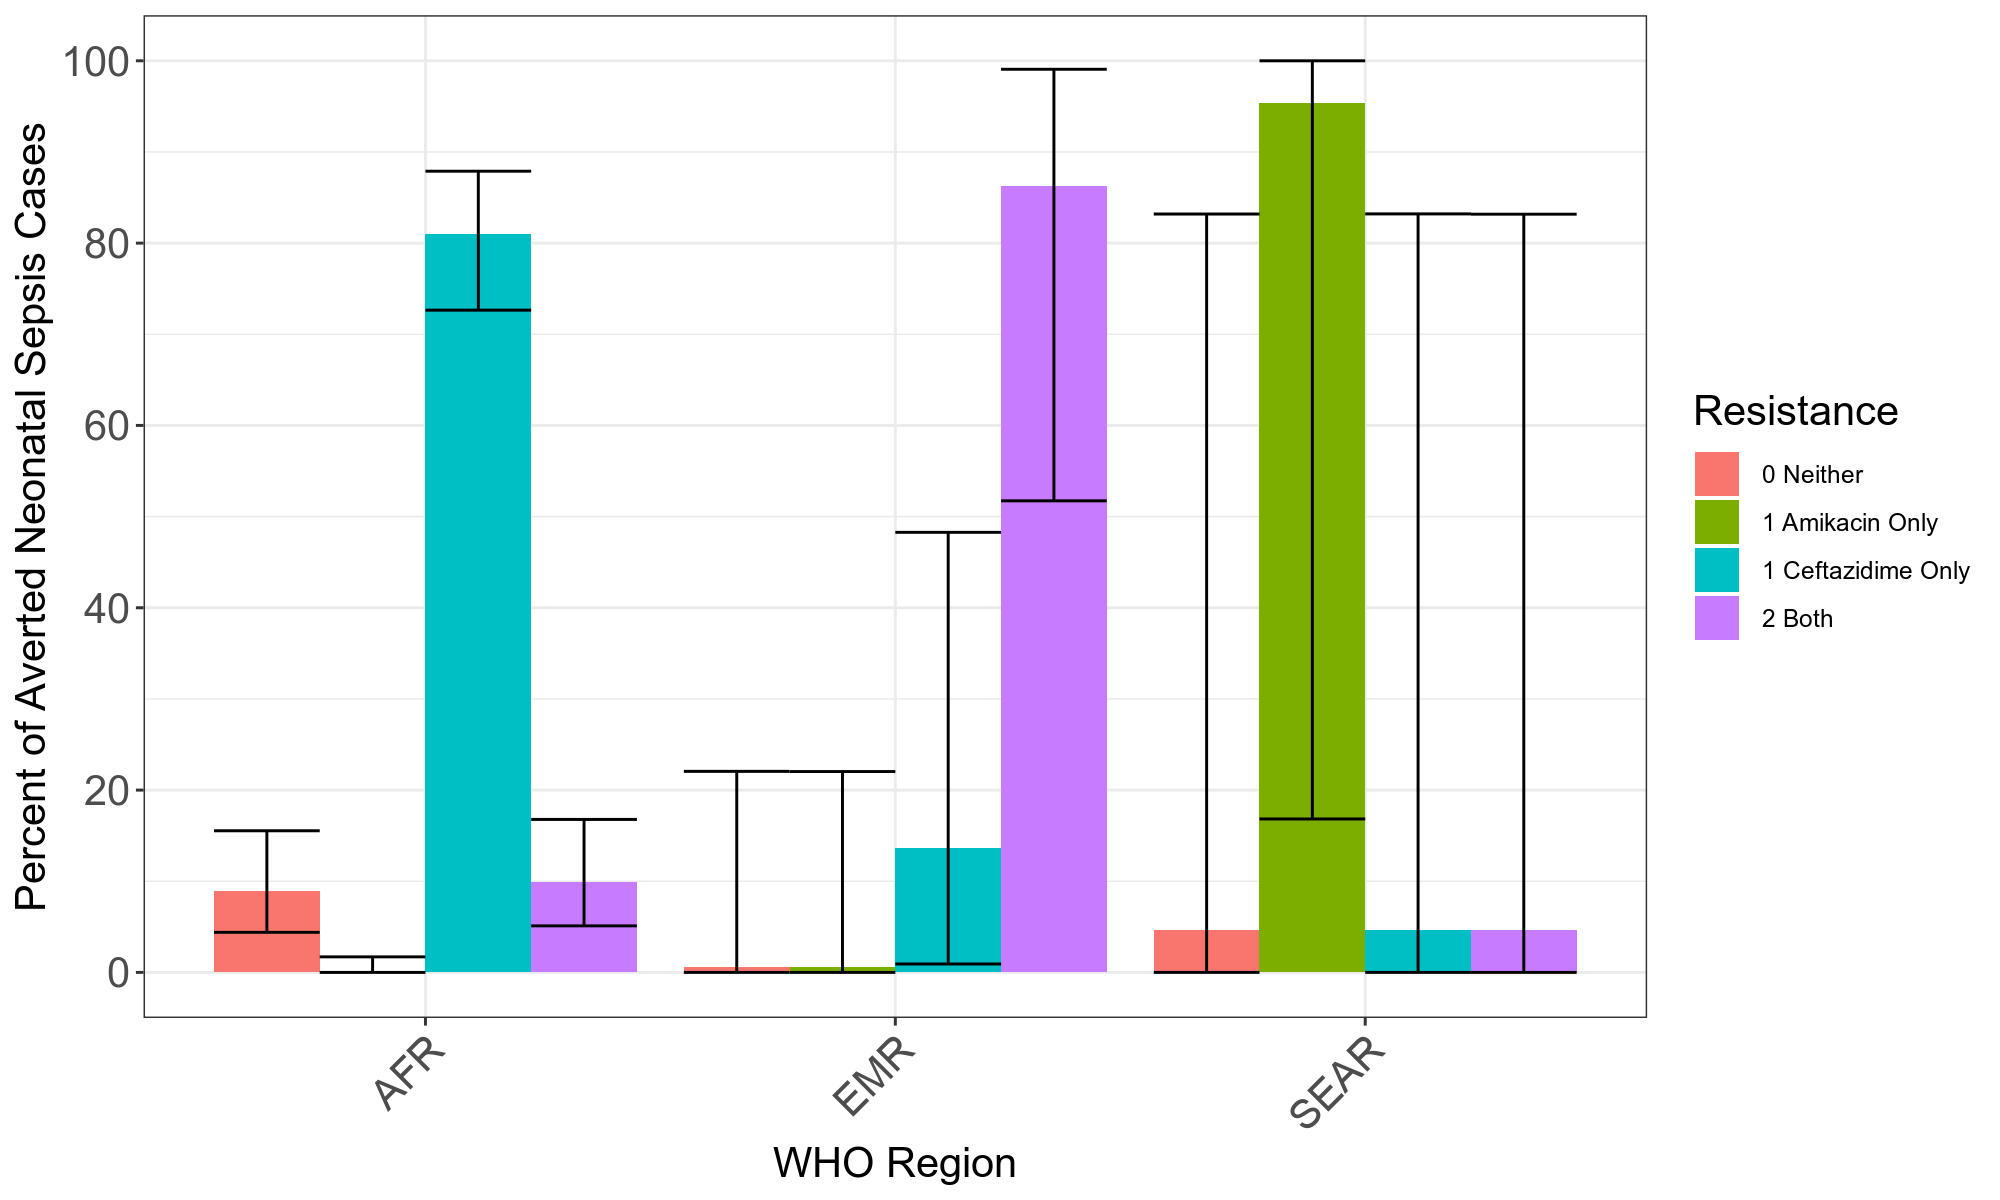

In [421]:
%%R -i joint_counts -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(joint_counts,
                aes(x = `WHO Region`,
                   y = `Percent Resistant` * 100,
                   fill = Resistance,
                   ymin = low * 100,
                   ymax = up * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Resistance") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Cases',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100)) +
xlab('WHO Region')

In [422]:
joint_counts[joint_counts.Resistance == '2 Both']['Percent Resistant'].mean()

0.336384160032926

In [423]:
joint_counts[joint_counts.Resistance == '2 Both']['low'].mean()

0.18945842838020358

In [424]:
joint_counts[joint_counts.Resistance == '2 Both']['up'].mean()

0.6634214121362249

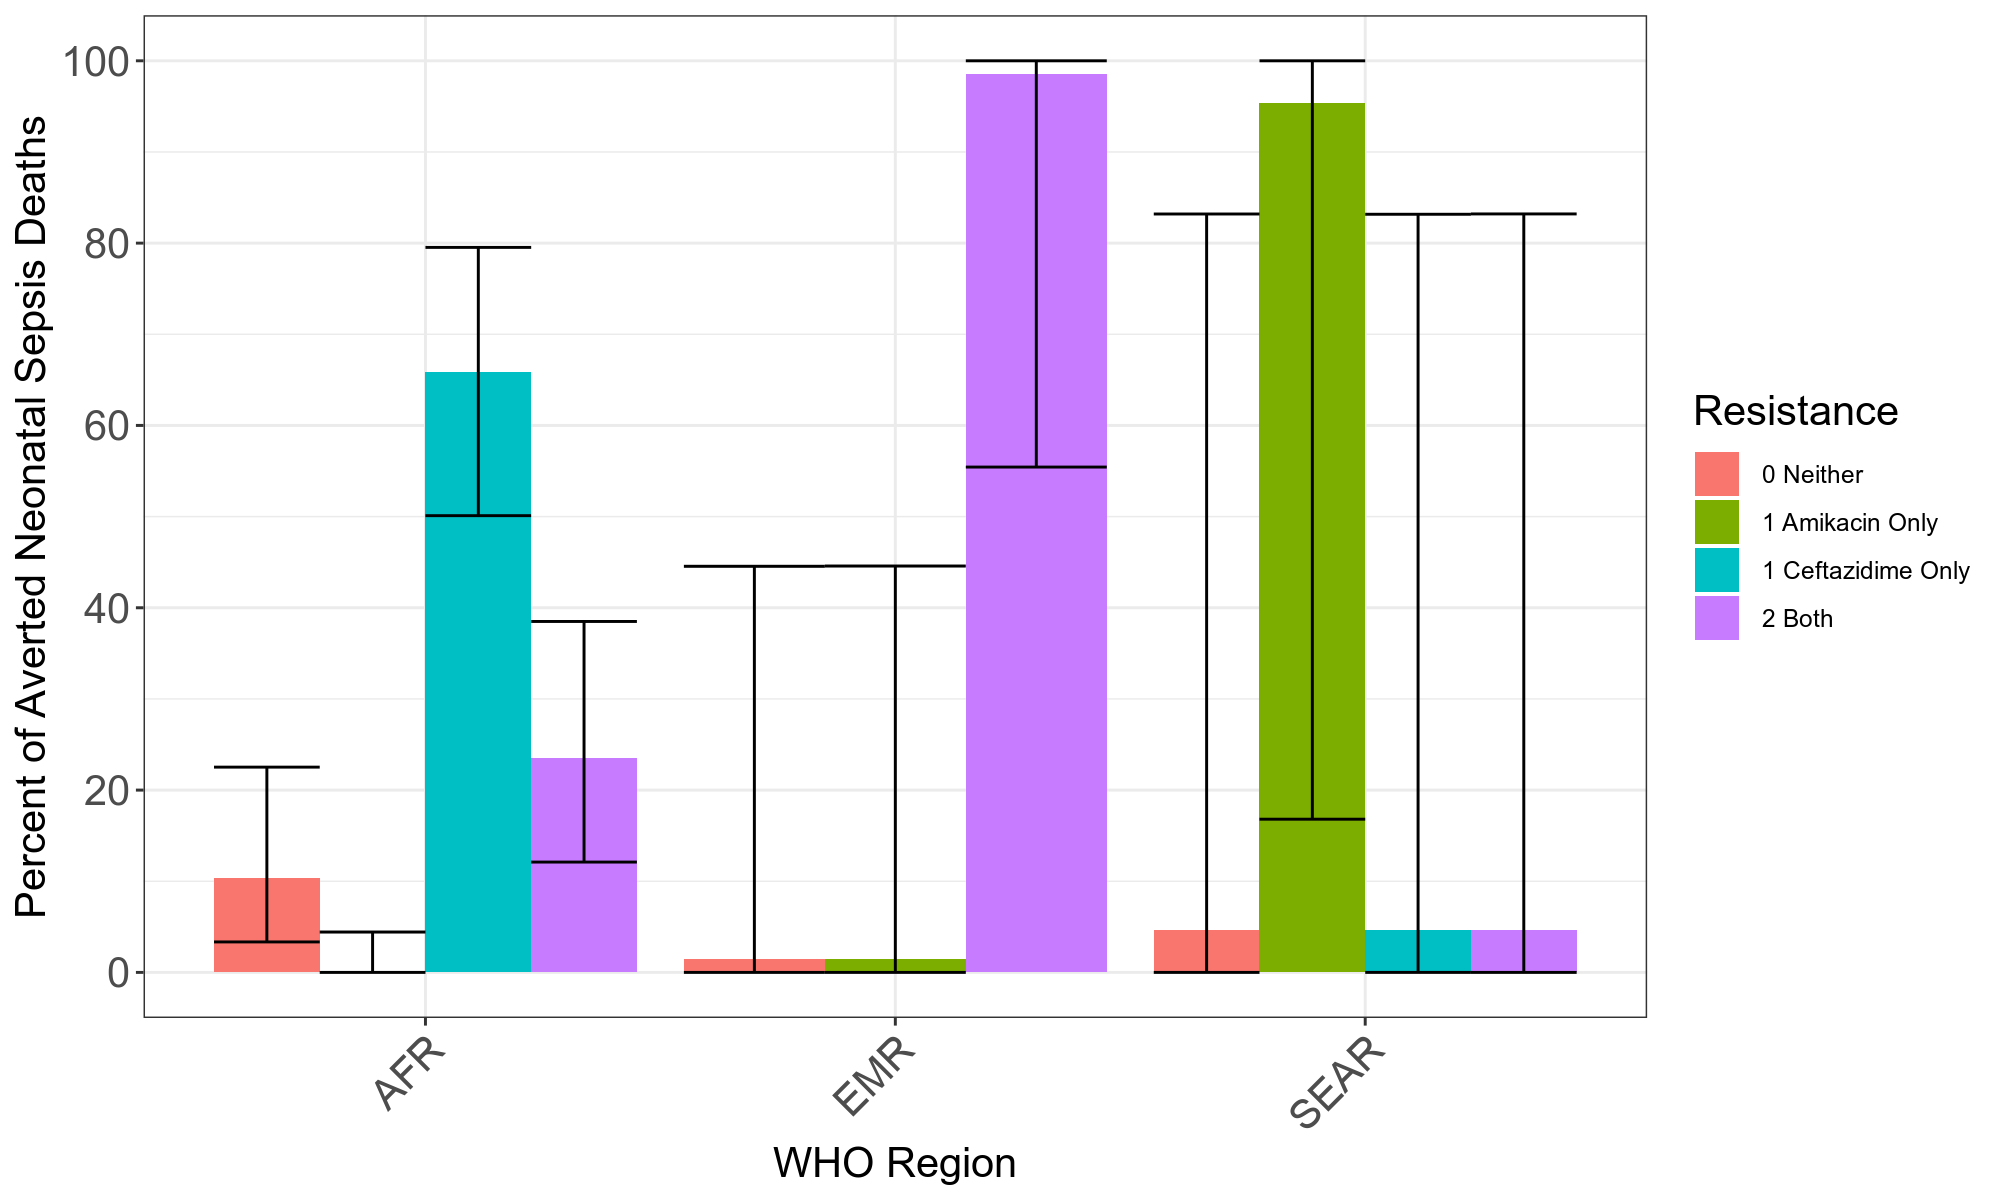

In [425]:
%%R -i joint_counts_deaths -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(joint_counts_deaths,
                aes(x = `WHO Region`,
                   y = `Percent Resistant` * 100,
                   fill = Resistance,
                   ymin = low * 100,
                   ymax = up * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Resistance") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Deaths',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100)) +
xlab('WHO Region')

In [426]:
# joint distributions ampicillin gentamicin

In [427]:
joint = barnards_AMR[barnards_AMR.FINALSPECIESID == 'Klebsiella pneumoniae'][['OUTCOME_x', 'Aminoglycosides: Gentamicin', 'Penicillins: Ampicillin',
                                                                     'WHO_region', 'cases']]

In [428]:
joint['Resistance'] = ['2 Both' if joint['Aminoglycosides: Gentamicin'].iloc[i] == 1 and joint['Penicillins: Ampicillin'].iloc[i] == 1 else '1 Ampicillin Only' if joint['Penicillins: Ampicillin'].iloc[i] == 1 and joint['Aminoglycosides: Gentamicin'].iloc[i] == 0 else '1 Gentamicin Only' if joint['Aminoglycosides: Gentamicin'].iloc[i] == 1 and joint['Penicillins: Ampicillin'].iloc[i] == 0 else '0 Neither' for i in range(len(joint))]

In [429]:
joint['cases'] = joint['cases'].astype(np.float64)

In [430]:
joint_counts = joint[['WHO_region', 'Resistance', 'OUTCOME_x',
       'cases']].groupby(['WHO_region', 'Resistance', 'OUTCOME_x']).sum().reset_index()

In [431]:
joint_counts

WHO_region         Resistance OUTCOME_x  cases
0        AFR          0 Neither  deceased    1.0
1        AFR  1 Ampicillin Only     alive    7.0
2        AFR  1 Ampicillin Only  deceased    6.0
3        AFR             2 Both     alive   55.0
4        AFR             2 Both  deceased   31.0
5        EMR  1 Ampicillin Only     alive    1.0
6        EMR             2 Both     alive    3.0
7        EMR             2 Both  deceased    3.0
8       SEAR             2 Both  deceased    1.0

In [432]:
# add the missing entries
joint_counts = pd.concat([joint_counts, pd.DataFrame([['AFR', '1 Gentamicin Only', 'alive', 0],
             ['AFR', '1 Gentamicin Only', 'deceased', 0],
             ['AFR', '0 Neither', 'alive', 0],
             ['EMR', '0 Neither', 'deceased', 0],
             ['EMR', '0 Neither', 'alive', 0],
             ['EMR', '1 Ampicillin Only', 'deceased', 0],
             ['EMR', '1 Gentamicin Only', 'alive', 0],
             ['EMR', '1 Gentamicin Only', 'deceased', 0],
             ['SEAR', '0 Neither', 'alive', 0],
             ['SEAR', '0 Neither', 'deceased', 0],
             ['SEAR', '1 Gentamicin Only', 'alive', 0],
             ['SEAR', '1 Gentamicin Only', 'deceased', 0],
             ['SEAR', '1 Ampicillin Only', 'alive', 0],
             ['SEAR', '1 Ampicillin Only', 'deceased', 0],
             ['SEAR', '2 Both', 'alive', 0]],
            columns = joint_counts.columns)], axis = 0).sort_values(by = ['WHO_region',
                                                                          'Resistance',
                                                                          'OUTCOME_x']).reset_index(drop = True)

In [433]:
joint_counts_deaths = joint_counts[joint_counts.OUTCOME_x == 'deceased']

In [434]:
joint_counts_deaths

WHO_region         Resistance OUTCOME_x  cases
1         AFR          0 Neither  deceased    1.0
3         AFR  1 Ampicillin Only  deceased    6.0
5         AFR  1 Gentamicin Only  deceased    0.0
7         AFR             2 Both  deceased   31.0
9         EMR          0 Neither  deceased    0.0
11        EMR  1 Ampicillin Only  deceased    0.0
13        EMR  1 Gentamicin Only  deceased    0.0
15        EMR             2 Both  deceased    3.0
17       SEAR          0 Neither  deceased    0.0
19       SEAR  1 Ampicillin Only  deceased    0.0
21       SEAR  1 Gentamicin Only  deceased    0.0
23       SEAR             2 Both  deceased    1.0

In [435]:
joint_counts = joint_counts.groupby(['WHO_region', 'Resistance']).sum().reset_index()

In [436]:
joint_counts = joint_counts.merge(joint_counts[['WHO_region',
                                 'Resistance',
                                 'cases']].groupby(['WHO_region']).sum().reset_index(),
                   on = ['WHO_region'])

In [437]:
joint_counts.columns = ['WHO Region', 'Resistance', 'cases', 'total_cases']

In [438]:
joint_counts

WHO Region         Resistance  cases  total_cases
0         AFR          0 Neither    1.0        100.0
1         AFR  1 Ampicillin Only   13.0        100.0
2         AFR  1 Gentamicin Only    0.0        100.0
3         AFR             2 Both   86.0        100.0
4         EMR          0 Neither    0.0          7.0
5         EMR  1 Ampicillin Only    1.0          7.0
6         EMR  1 Gentamicin Only    0.0          7.0
7         EMR             2 Both    6.0          7.0
8        SEAR          0 Neither    0.0          1.0
9        SEAR  1 Ampicillin Only    0.0          1.0
10       SEAR  1 Gentamicin Only    0.0          1.0
11       SEAR             2 Both    1.0          1.0

In [439]:
joint_counts_deaths = joint_counts_deaths.merge(joint_counts_deaths[['WHO_region',
                                 'Resistance',
                                 'cases']].groupby(['WHO_region']).sum().reset_index(),
                   on = ['WHO_region'])

joint_counts_deaths.columns = ['WHO Region', 'Resistance', 'outcome', 'deaths', 'total_deaths']

In [440]:
joint_counts_deaths

WHO Region         Resistance   outcome  deaths  total_deaths
0         AFR          0 Neither  deceased     1.0          38.0
1         AFR  1 Ampicillin Only  deceased     6.0          38.0
2         AFR  1 Gentamicin Only  deceased     0.0          38.0
3         AFR             2 Both  deceased    31.0          38.0
4         EMR          0 Neither  deceased     0.0           3.0
5         EMR  1 Ampicillin Only  deceased     0.0           3.0
6         EMR  1 Gentamicin Only  deceased     0.0           3.0
7         EMR             2 Both  deceased     3.0           3.0
8        SEAR          0 Neither  deceased     0.0           1.0
9        SEAR  1 Ampicillin Only  deceased     0.0           1.0
10       SEAR  1 Gentamicin Only  deceased     0.0           1.0
11       SEAR             2 Both  deceased     1.0           1.0

In [441]:
joint_counts = pd.concat([joint_counts,
                              pd.DataFrame(np.array([adjusted_beta(joint_counts.loc[i, 'cases'] + 1/4,
               joint_counts.loc[i, 'total_cases'] - joint_counts.loc[i, 'cases'] + 1/4,
               N = N) for i in tqdm(range(len(joint_counts)))]), columns = ['beta_samples'] * N)], axis = 1)

In [442]:
joint_counts_deaths = pd.concat([joint_counts_deaths,
                              pd.DataFrame(np.array([adjusted_beta(joint_counts_deaths.loc[i, 'deaths'] + 1/4,
               joint_counts_deaths.loc[i, 'total_deaths'] - joint_counts_deaths.loc[i, 'deaths'] + 1/4,
               N = N) for i in tqdm(range(len(joint_counts_deaths)))]), columns = ['beta_samples'] * N)], axis = 1)

In [443]:
joint_counts['low'] = np.percentile(joint_counts['beta_samples'], q = 2.5, axis = 1)
joint_counts['Percent Resistant'] = np.percentile(joint_counts['beta_samples'], q = 50, axis = 1)
joint_counts['up'] = np.percentile(joint_counts['beta_samples'], q = 97.5, axis = 1)

In [444]:
joint_counts_deaths['low'] = np.percentile(joint_counts_deaths['beta_samples'], q = 2.5, axis = 1)
joint_counts_deaths['Percent Resistant'] = np.percentile(joint_counts_deaths['beta_samples'], q = 50, axis = 1)
joint_counts_deaths['up'] = np.percentile(joint_counts_deaths['beta_samples'], q = 97.5, axis = 1)

In [445]:
joint_counts

WHO Region         Resistance  cases  total_cases  beta_samples  \
0         AFR          0 Neither    1.0        100.0  2.199053e-02   
1         AFR  1 Ampicillin Only   13.0        100.0  1.210387e-01   
2         AFR  1 Gentamicin Only    0.0        100.0  4.786695e-07   
3         AFR             2 Both   86.0        100.0  7.763754e-01   
4         EMR          0 Neither    0.0          7.0  2.719319e-04   
5         EMR  1 Ampicillin Only    1.0          7.0  1.618819e-01   
6         EMR  1 Gentamicin Only    0.0          7.0  7.569349e-03   
7         EMR             2 Both    6.0          7.0  8.906642e-01   
8        SEAR          0 Neither    0.0          1.0  1.574917e-01   
9        SEAR  1 Ampicillin Only    0.0          1.0  8.598193e-02   
10       SEAR  1 Gentamicin Only    0.0          1.0  1.315994e-02   
11       SEAR             2 Both    1.0          1.0  9.985415e-01   

    beta_samples  beta_samples  beta_samples  beta_samples  beta_samples  ...  \
0   6.630192e-04      0.002323  2.281826e-02      0.003717      0.020313  ...   
1   1.151793e-01      0.163276  1.555322e-01      0.106728      0.163465  ...   
2   5.008576e-07      0.008231  7.038442e-08      0.000213      0.000210  ...   
3   8.544661e-01      0.921829  8.301144e-01      0.852400      0.854382  ...   
4   4.745320e-07      0.011996  3.305499e-06      0.009410      0.000176  ...   
5   1.977375e-01      0.142180  3.645022e-01      0.433652      0.067972  ...   
6   6.156896e-03      0.244198  2.549014e-07      0.005292      0.000505  ...   
7   8.595418e-01      0.982668  8.278286e-01      0.875755      0.680847  ...   
8   1.002180e-02      0.093085  1.730325e-07      0.378763      0.000009  ...   
9   2.262313e-01      0.007474  2.154914e-02      0.053377      0.144383  ...   
10  2.560710e-02      0.013636  1.928053e-01      0.839658      0.117284  ...   
11  7.259453e-01      0.659472  3.045112e-01      0.999843      0.609944  ...   

    beta_samples  beta_samples  beta_samples  beta_samples  beta_samples  \
0       0.001136      0.027407      0.001972      0.012552  3.254575e-03   
1       0.095766      0.155412      0.115669      0.145804  1.178918e-01   
2       0.001324      0.000013      0.000161      0.000013  1.357187e-03   
3       0.884558      0.853503      0.874506      0.907617  8.203085e-01   
4       0.035774      0.000191      0.036749      0.047340  2.845088e-03   
5       0.113164      0.285811      0.402211      0.058439  8.963230e-02   
6       0.000342      0.048924      0.011376      0.015605  4.336786e-02   
7       0.887029      0.836728      0.866042      0.892658  4.484844e-01   
8       0.556131      0.000136      0.062018      0.012357  5.672887e-01   
9       0.771200      0.002853      0.210328      0.008630  6.393057e-12   
10      0.000049      0.001980      0.371363      0.014743  8.258481e-02   
11      0.586350      0.994682      0.558860      0.948115  7.874901e-01   

    beta_samples  beta_samples           low  Percent Resistant        up  
0       0.033303      0.022559  5.967576e-04           0.009384  0.041312  
1       0.135847      0.203282  7.336019e-02           0.129398  0.204118  
2       0.000046      0.000218  2.679232e-09           0.000437  0.017020  
3       0.856785      0.795380  7.840360e-01           0.860588  0.918937  
4       0.000031      0.001058  3.859041e-08           0.006327  0.220481  
5       0.075227      0.273606  9.274828e-03           0.136784  0.482502  
6       0.509670      0.048108  3.857026e-08           0.006327  0.220411  
7       0.971607      0.881705  5.174466e-01           0.863226  0.990707  
8       0.332894      0.000093  2.910393e-07           0.046607  0.831911  
9       0.003368      0.029085  2.923196e-07           0.046588  0.831749  
10      0.075074      0.117540  2.928248e-07           0.046588  0.832019  
11      0.312538      0.998593  1.679655e-01           0.953397  1.000000  

[12 rows x 10007 columns]

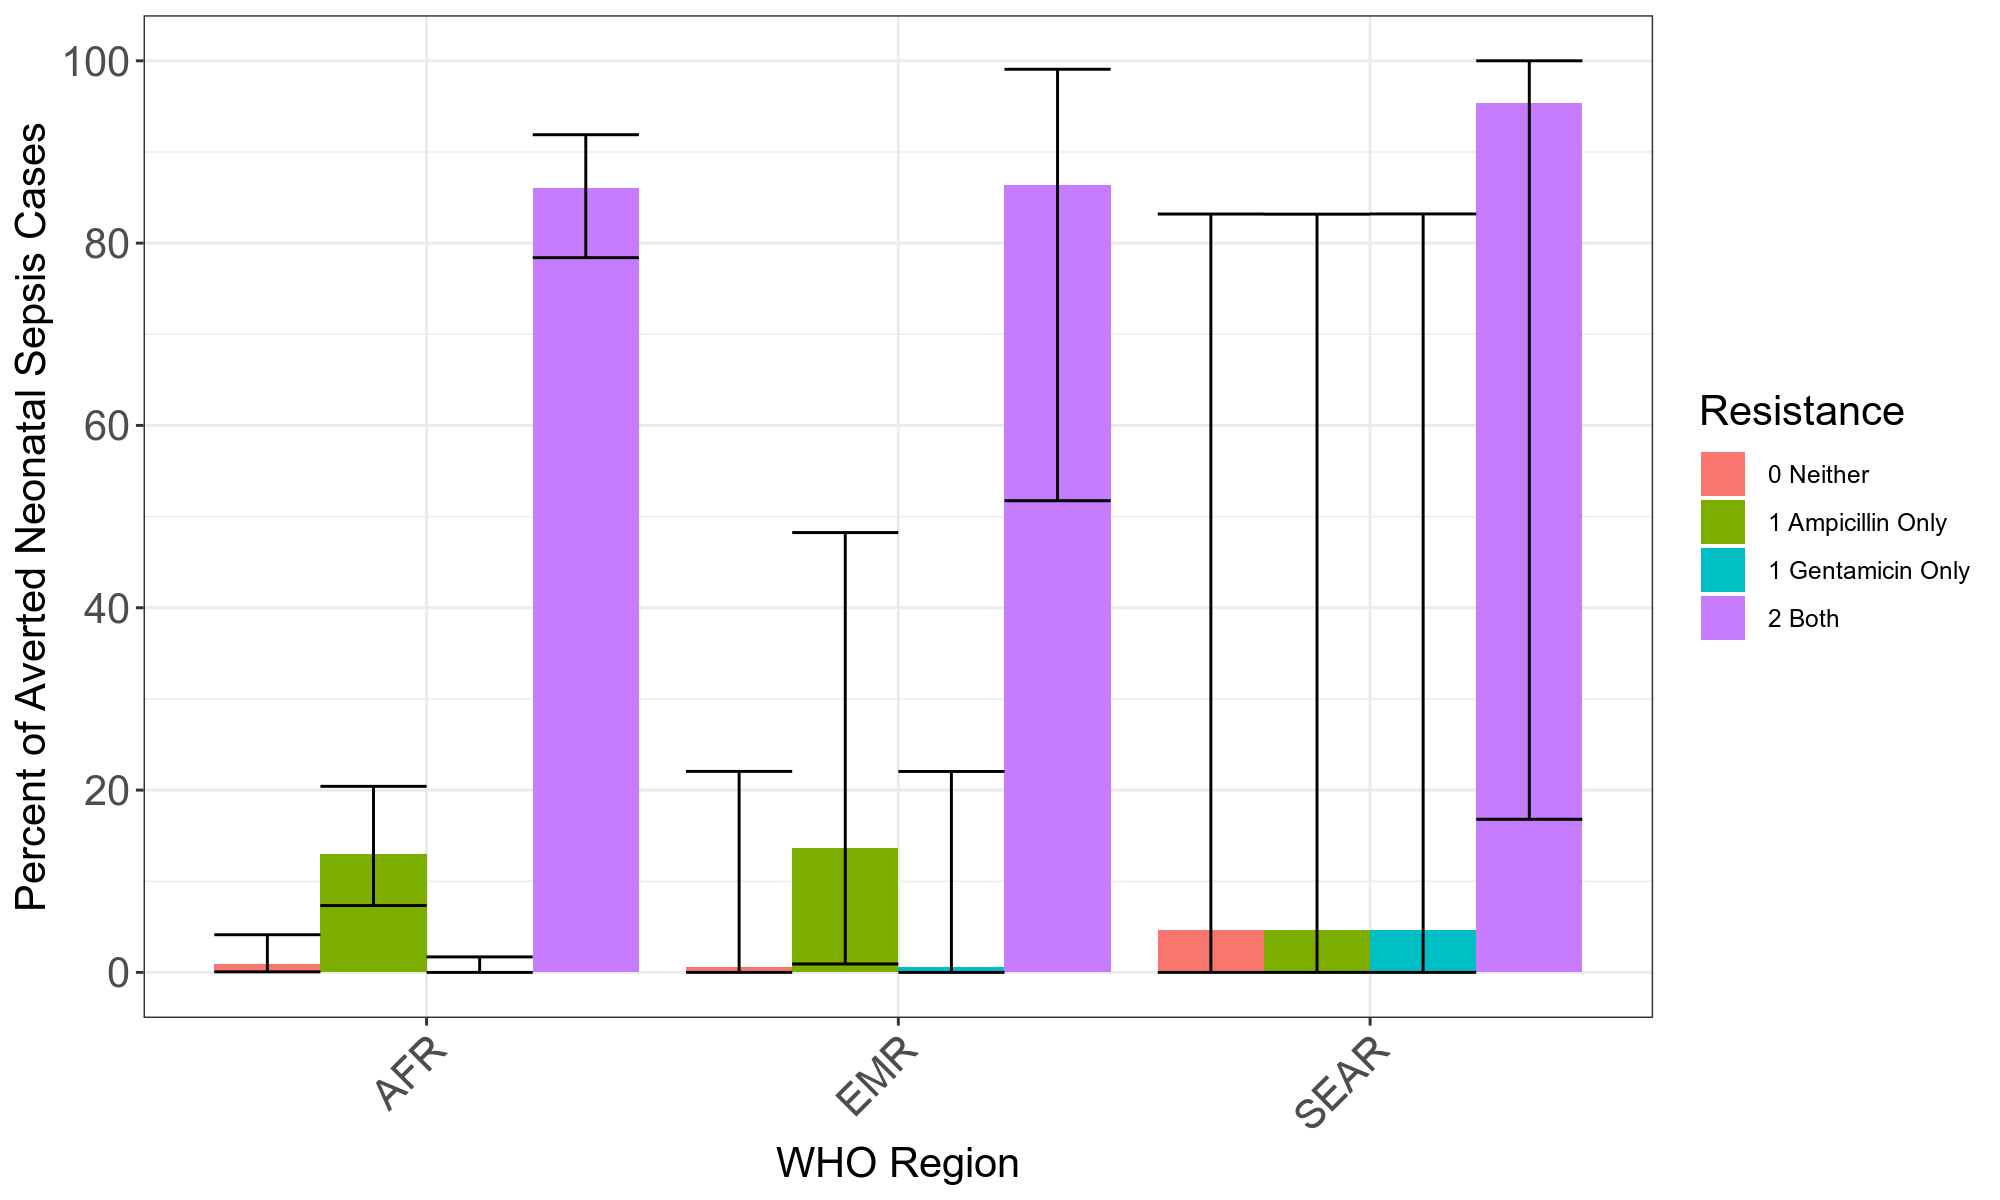

In [446]:
%%R -i joint_counts -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(joint_counts,
                aes(x = `WHO Region`,
                   y = `Percent Resistant` * 100,
                   fill = Resistance,
                   ymin = low * 100,
                   ymax = up * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Resistance") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Cases',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100)) +
xlab('WHO Region')

In [447]:
joint_counts[joint_counts.Resistance == '2 Both']['Percent Resistant'].mean()

0.8924036019877534

In [448]:
joint_counts[joint_counts.Resistance == '2 Both']['low'].mean()

0.48981599463643627

In [449]:
joint_counts[joint_counts.Resistance == '2 Both']['up'].mean()

0.969881053307315

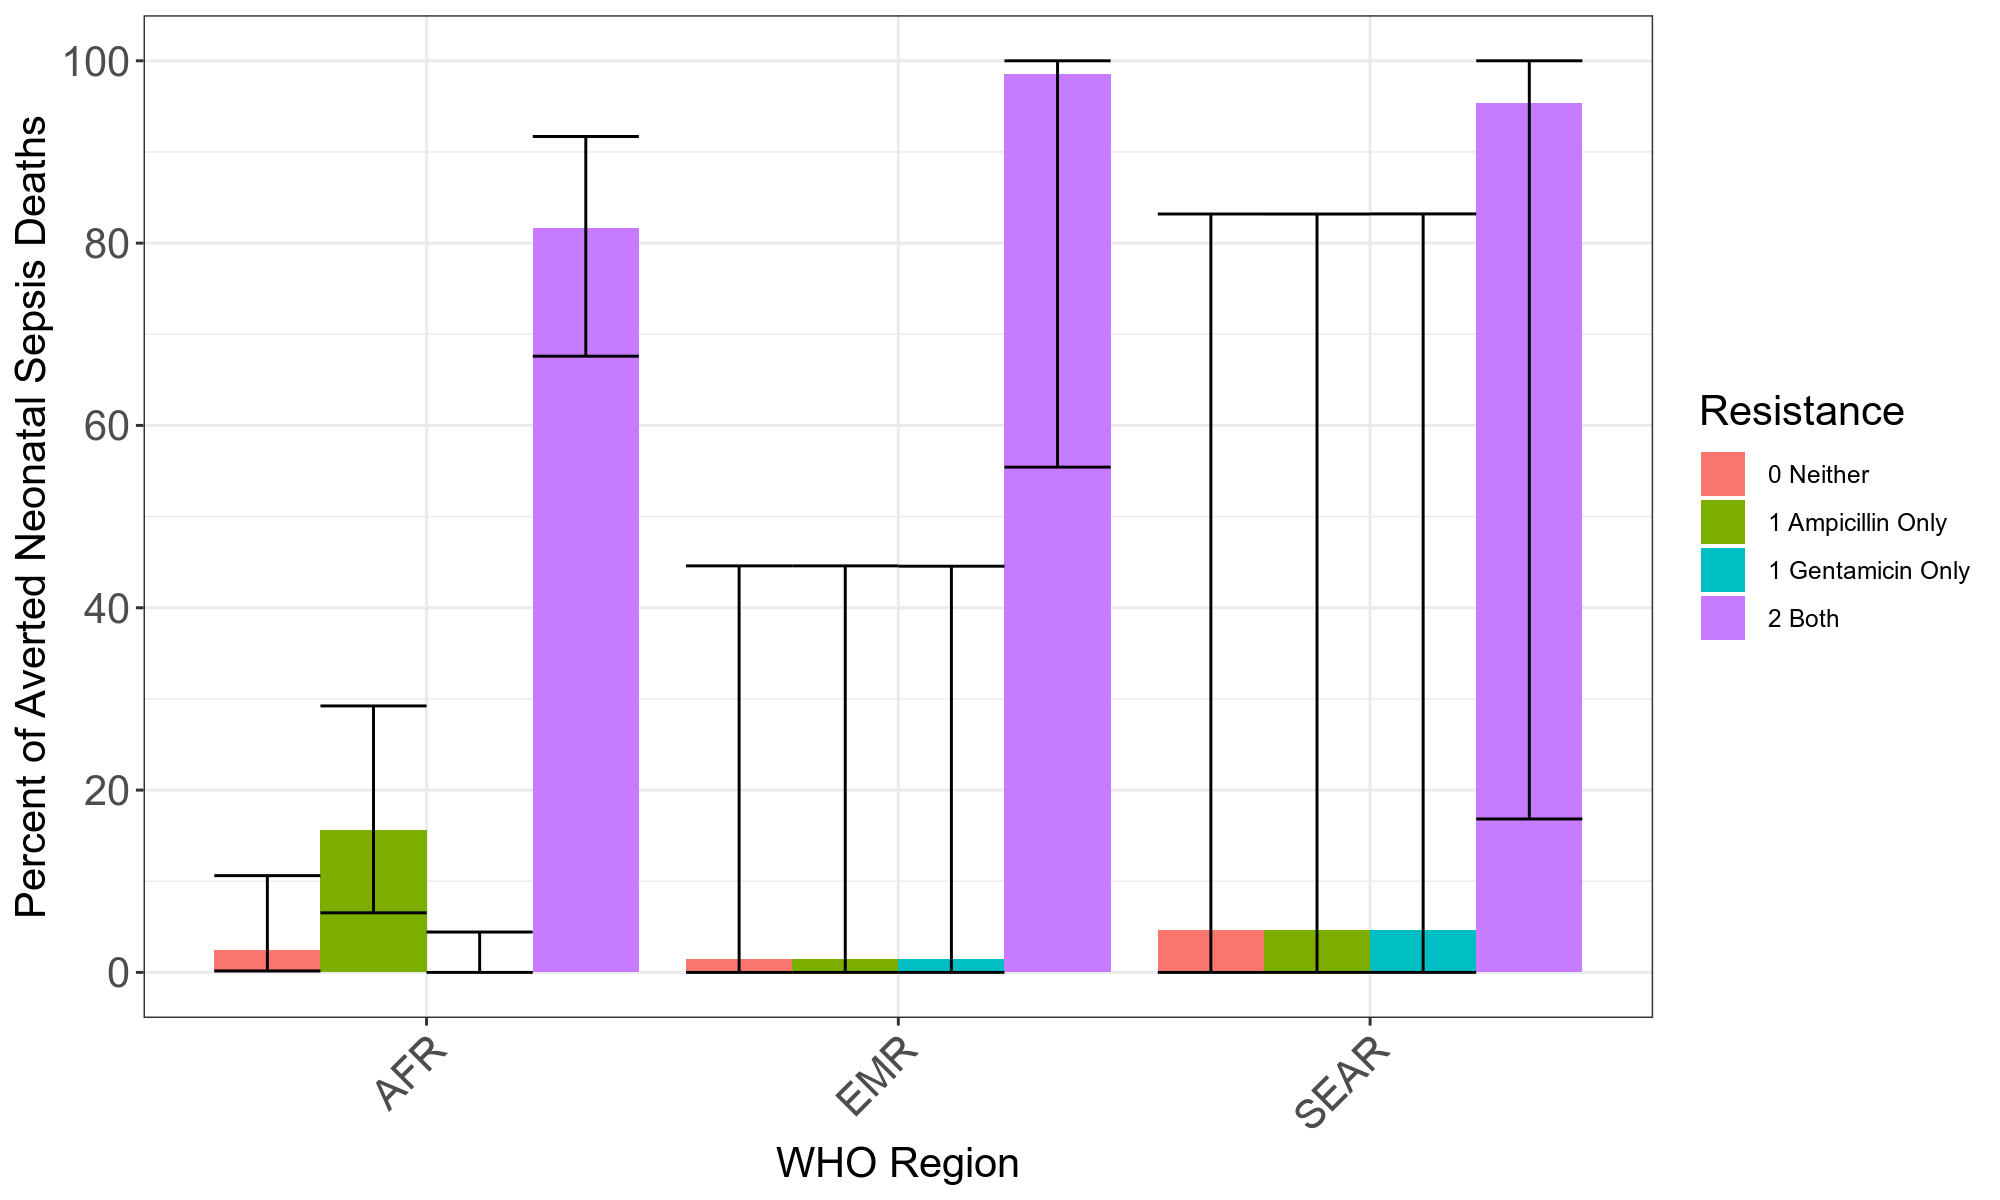

In [450]:
%%R -i joint_counts_deaths -i out_path -w 10 -h 6 --units in -r 200
positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(joint_counts_deaths,
                aes(x = `WHO Region`,
                   y = `Percent Resistant` * 100,
                   fill = Resistance,
                   ymin = low * 100,
                   ymax = up * 100)) +
                geom_bar(stat = 'identity', position = position_dodge()) +
                geom_errorbar(position = position_dodge()) +
                #facet_wrap(~pathogen) +
                theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
                scale_fill_discrete(name = "Resistance") +
                scale_y_continuous('Percent of Averted Neonatal Sepsis Deaths',
                                   breaks = seq(0, 100, 20), label = seq(0, 100, 20), limits = c(0, 100)) +
xlab('WHO Region')

### Global Extrapolations

In [1032]:
# idea is to globally estimate what the impact of a maternal vaccine would be
# let's project total vaccine avertable deaths, vaccine avertable cases,
# can we also project resistant cases?

# the idea is that we'll relate avertable deaths and cases (and even percent?) to the IHME estimates for

# and, 

# based on IHME estimates for sepsis and resistance?

In [1033]:
me_kp = meta_estimates[meta_estimates.pathogen == 'Klebsiella pneumoniae']

In [1034]:
# make AMR predictions for every country in Africa, Asia
country_map = pd.read_csv(os.path.join(data_dir,
                                       'Metadata_Country_API_NY.ADJ.NNTY.PC.CD_DS2_en_csv_v2_2596239.csv'))

country_map = pd.concat([country_map,
                         pd.DataFrame(['NNN', 'Kyrgyzstan'],
                                      index = ['Country Code', 'TableName']).T]).reset_index(drop = True)

country_map = pd.concat([country_map,
                         pd.DataFrame(['TTT', 'Taiwan'],
                                      index = ['Country Code', 'TableName']).T]).reset_index(drop = True)

ihme_countries = ihme_whole[ihme_whole.measure == 'Deaths']#[ihme_whole.cause == 'Neonatal sepsis and other neonatal infections']

ihme_countries.loc[ihme_countries.location == 'SouthAfrica', 'location'] = 'South Africa'
ihme_countries.loc[ihme_countries.location == 'SierraLeone', 'location'] = 'Sierra Leone'
ihme_countries.loc[ihme_countries.location == 'United States of America', 'location'] = 'United States'
ihme_countries.loc[ihme_countries.location == "Lao People's Democratic Republic", 'location'] = 'Laos'
ihme_countries.loc[ihme_countries.location == "Iran (Islamic Republic of)", 'location'] = 'Iran, Islamic Rep.'
ihme_countries.loc[ihme_countries.location == "Bolivia (Plurinational State of)", 'location'] = 'Bolivia'
ihme_countries.loc[ihme_countries.location == "Venezuela (Bolivarian Republic of)", 'location'] = 'Venezuela, RB'
ihme_countries.loc[ihme_countries.location == "Czechia", 'location'] = 'Czech Republic'
ihme_countries.loc[ihme_countries.location == "United Republic of Tanzania", 'location'] = 'Tanzania'
ihme_countries.loc[ihme_countries.location == "Taiwan (Province of China)", 'location'] = "Taiwan"

country_map.loc[country_map.TableName == 'Yemen, Rep.', 'TableName'] = 'Yemen'
country_map.loc[country_map.TableName == 'Lao PDR', 'TableName'] = 'Laos'
country_map.loc[country_map.TableName == 'Korea, Rep.', 'TableName'] = 'Republic of Korea'
country_map.loc[country_map.TableName == "Korea, Dem. People's Rep.", 'TableName'] = "Democratic People's Republic of Korea"
country_map.loc[country_map.TableName == "Congo, Rep.", 'TableName'] = "Congo"
country_map.loc[country_map.TableName == "Slovak Republic", 'TableName'] = "Slovakia"
country_map.loc[country_map.TableName == "Egypt, Arab Rep.", 'TableName'] = "Egypt"
country_map.loc[country_map.TableName == "Congo, Dem. Rep.", 'TableName'] = "Democratic Republic of the Congo"

ihme_countries = ihme_countries[ihme_countries.year.isin([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

country_map = country_map.dropna(axis = 1)

ihme_countries = ihme_countries[ihme_countries.location.isin(country_map.TableName)]

/home/ckk/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [1035]:
ihme_countries = ihme_countries.groupby(['location', 'cause']).mean().reset_index()

In [1036]:
country_map[country_map.TableName.str.find('Vietnam') != -1]

Country Code TableName
256          VNM   Vietnam

In [1037]:
ihme_whole[ihme_whole.location.str.find('Vietnam') != -1]

Country  cherg_val  cherg_lower  cherg_upper  cherg_deaths_overall  \
11460  Vietnam     3077.5      1939.75      4522.75               37398.0   
11461  Vietnam     3077.5      1939.75      4522.75               37398.0   
11462  Vietnam     3077.5      1939.75      4522.75               37398.0   
11463  Vietnam     3077.5      1939.75      4522.75               37398.0   
11464  Vietnam     3077.5      1939.75      4522.75               37398.0   
11465  Vietnam     3077.5      1939.75      4522.75               37398.0   
11466  Vietnam     3077.5      1939.75      4522.75               37398.0   
11467  Vietnam     3077.5      1939.75      4522.75               37398.0   
11468  Vietnam     3077.5      1939.75      4522.75               37398.0   
11469  Vietnam     3077.5      1939.75      4522.75               37398.0   
11470  Vietnam     3077.5      1939.75      4522.75               37398.0   
11471  Vietnam     3077.5      1939.75      4522.75               37398.0   
11472  Vietnam     3077.5      1939.75      4522.75               37398.0   
11473  Vietnam     3077.5      1939.75      4522.75               37398.0   
11474  Vietnam     3077.5      1939.75      4522.75               37398.0   
11475  Vietnam     3077.5      1939.75      4522.75               37398.0   
11476  Vietnam     3077.5      1939.75      4522.75               37398.0   
11477  Vietnam     3077.5      1939.75      4522.75               37398.0   
11478  Vietnam     3077.5      1939.75      4522.75               37398.0   
11479  Vietnam     3077.5      1939.75      4522.75               37398.0   
11480  Vietnam     3077.5      1939.75      4522.75               37398.0   
11481  Vietnam     3077.5      1939.75      4522.75               37398.0   
11482  Vietnam     3077.5      1939.75      4522.75               37398.0   
11483  Vietnam     3077.5      1939.75      4522.75               37398.0   
11484  Vietnam     3077.5      1939.75      4522.75               37398.0   
11485  Vietnam     3077.5      1939.75      4522.75               37398.0   
11486  Vietnam     3077.5      1939.75      4522.75               37398.0   
11487  Vietnam     3077.5      1939.75      4522.75               37398.0   
11488  Vietnam     3077.5      1939.75      4522.75               37398.0   
11489  Vietnam     3077.5      1939.75      4522.75               37398.0   
11490  Vietnam     3077.5      1939.75      4522.75               37398.0   
11491  Vietnam     3077.5      1939.75      4522.75               37398.0   
11492  Vietnam     3077.5      1939.75      4522.75               37398.0   
11493  Vietnam     3077.5      1939.75      4522.75               37398.0   
11494  Vietnam     3077.5      1939.75      4522.75               37398.0   
11495  Vietnam     3077.5      1939.75      4522.75               37398.0   
11496  Vietnam     3077.5      1939.75      4522.75               37398.0   
11497  Vietnam     3077.5      1939.75      4522.75               37398.0   
11498  Vietnam     3077.5      1939.75      4522.75               37398.0   
11499  Vietnam     3077.5      1939.75      4522.75               37398.0   
11500  Vietnam     3077.5      1939.75      4522.75               37398.0   
11501  Vietnam     3077.5      1939.75      4522.75               37398.0   
11502  Vietnam     3077.5      1939.75      4522.75               37398.0   
11503  Vietnam     3077.5      1939.75      4522.75               37398.0   
11504  Vietnam     3077.5      1939.75      4522.75               37398.0   
11505  Vietnam     3077.5      1939.75      4522.75               37398.0   
11506  Vietnam     3077.5      1939.75      4522.75               37398.0   
11507  Vietnam     3077.5      1939.75      4522.75               37398.0   
11508  Vietnam     3077.5      1939.75      4522.75               37398.0   
11509  Vietnam     3077.5      1939.75      4522.75               37398.0   
11510  Vietnam     3077.5      1939.75      4522.75               37398.0   
115

In [1038]:
ihme_countries[ihme_countries.location.str.find('Laos') != -1]
# ihme_countries[ihme_countries.Country.str.find('Taiwan') != -1]

location                                          cause  cherg_val  \
180     Laos                                     All causes     1329.5   
181     Laos  Neonatal sepsis and other neonatal infections     1329.5   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
180       736.75       2067.5               10987.5  2015.5  3932.964301   
181       736.75       2067.5               10987.5  2015.5   367.193170   

           upper        lower  
180  4649.815337  3257.030612  
181   577.854039   214.016827

In [1039]:
number_avertable_deaths = sm.OLS(me_kp['N_avertabledeaths_ss_c'],
      (me_kp['deaths_ns_cherg_val'])).fit()

number_avertable_deaths_upper = sm.OLS(me_kp['N_avertabledeaths_ss_upper_c'],
      (me_kp['deaths_ns_cherg_upper'])).fit()

number_avertable_deaths_lower = sm.OLS(me_kp['N_avertabledeaths_ss_lower_c'],
      (me_kp['deaths_ns_cherg_lower'])).fit()

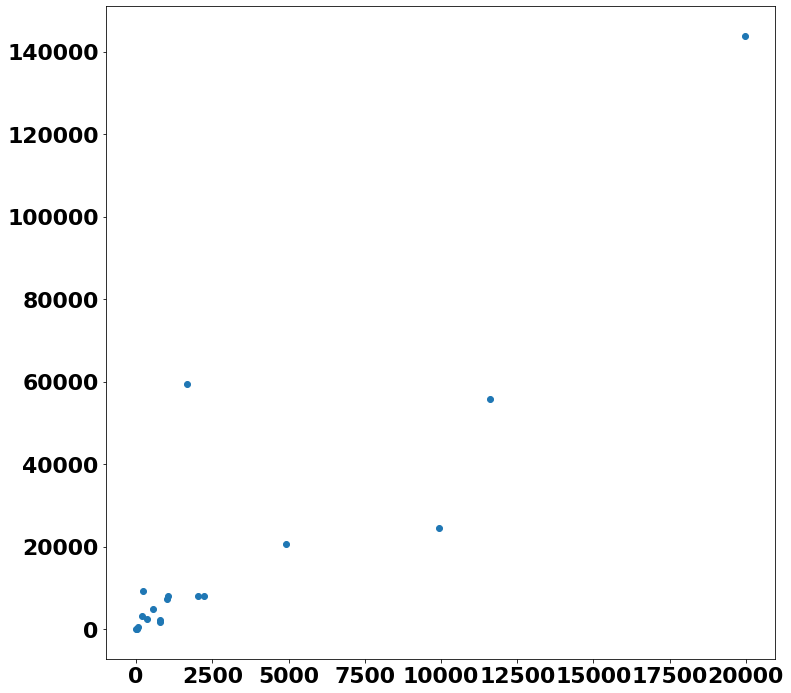

In [1040]:
plt.scatter(me_kp['N_avertabledeaths_ss_c'],
      (me_kp['deaths_ns_cherg_val']))

In [1041]:
number_avertable_deaths.summary()

/home/ckk/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     N_avertabledeaths_ss_c   R-squared (uncentered):                   0.838
Model:                                OLS   Adj. R-squared (uncentered):              0.829
Method:                     Least Squares   F-statistic:                              88.12
Date:                    Fri, 19 Aug 2022   Prob (F-statistic):                    3.88e-08
Time:                            08:25:09   Log-Likelihood:                         -166.06
No. Observations:                      18   AIC:                                      334.1
Df Residuals:                          17   BIC:                                      335.0
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
deaths_ns_cherg_val     0.1401      0.015      9.387      0.000       0.109       0.172
==============================================================================
Omnibus:                        8.113   Durbin-Watson:                   2.603
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.918
Skew:                          -0.297   Prob(JB):                       0.0116
Kurtosis:                       6.397   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1042]:
ihme_countries['N_avertabledeaths_ss'] = np.maximum(number_avertable_deaths.predict(((ihme_countries[ihme_countries.cause != 'All causes'].cherg_val))), 0)
ihme_countries['N_avertabledeaths_upper'] = np.maximum(number_avertable_deaths_upper.predict((ihme_countries[ihme_countries.cause != 'All causes'].cherg_val)), 0)
ihme_countries['N_avertabledeaths_lower'] = np.maximum(number_avertable_deaths_lower.predict((ihme_countries[ihme_countries.cause != 'All causes'].cherg_val)), 0)

In [1043]:
number_avertable_cases = sm.OLS(me_kp['N_avertablecases_ss_c'],
      (me_kp['deaths_ns_cherg_val'])).fit()

number_avertable_cases_upper = sm.OLS(me_kp['N_avertablecases_ss_upper_c'],
      (me_kp['deaths_ns_cherg_upper'])).fit()

number_avertable_cases_lower = sm.OLS(me_kp['N_avertablecases_ss_lower_c'],
      (me_kp['deaths_ns_cherg_lower'])).fit()

In [1044]:
number_avertable_cases.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     N_avertablecases_ss_c   R-squared (uncentered):                   0.838
Model:                               OLS   Adj. R-squared (uncentered):              0.829
Method:                    Least Squares   F-statistic:                              88.12
Date:                   Fri, 19 Aug 2022   Prob (F-statistic):                    3.88e-08
Time:                           08:25:09   Log-Likelihood:                         -194.98
No. Observations:                     18   AIC:                                      392.0
Df Residuals:                         17   BIC:                                      392.9
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
deaths_ns_cherg_val     0.6983      0.074      9.387      0.000       0.541       0.855
==============================================================================
Omnibus:                        8.113   Durbin-Watson:                   2.603
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.918
Skew:                          -0.297   Prob(JB):                       0.0116
Kurtosis:                       6.397   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1045]:
ihme_countries['N_avertablecases_ss'] = np.maximum(number_avertable_cases.predict((ihme_countries[ihme_countries.cause != 'All causes'].cherg_val)), 0)
ihme_countries['N_avertablecases_upper'] = np.maximum(number_avertable_cases_upper.predict((ihme_countries[ihme_countries.cause != 'All causes'].cherg_val)), 0)
ihme_countries['N_avertablecases_lower'] = np.maximum(number_avertable_cases_lower.predict((ihme_countries[ihme_countries.cause != 'All causes'].cherg_val)), 0)

/home/ckk/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ckk/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 8.,  4., 17., 28., 25., 25., 30., 31., 13.,  3.]),
 array([-2.        , -1.36960334, -0.73920669, -0.10881003,  0.52158662,
         1.15198328,  1.78237993,  2.41277659,  3.04317324,  3.6735699 ,
         4.30396655]),
 <a list of 10 Patch objects>)

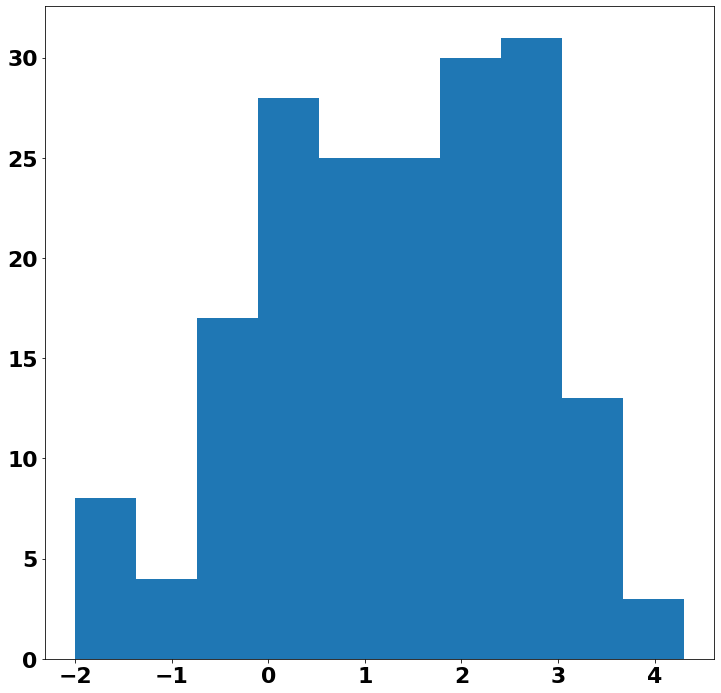

In [1046]:
plt.hist(np.log10(ihme_countries.N_avertabledeaths_ss + 0.01))

In [1047]:
ihme_countries['percent_val'] = 100 * ihme_countries.N_avertabledeaths_ss / ihme_countries.cherg_deaths_overall
ihme_countries['percent_upper'] = 100 * ihme_countries.N_avertabledeaths_upper / ihme_countries.cherg_deaths_overall
ihme_countries['percent_lower'] = 100 * ihme_countries.N_avertabledeaths_lower / ihme_countries.cherg_deaths_overall

In [1048]:
ihme_countries[ihme_countries.N_avertabledeaths_ss == ihme_countries.N_avertabledeaths_ss.max()]

location                                          cause  cherg_val  \
151    India  Neonatal sepsis and other neonatal infections   143741.0   

     cherg_lower  cherg_upper  cherg_deaths_overall    year           val  \
151     93639.75     207884.5             1481443.0  2015.5  38551.254439   

            upper         lower  N_avertabledeaths_ss  \
151  48749.195587  30577.810811          20135.681675   

     N_avertabledeaths_upper  N_avertabledeaths_lower  N_avertablecases_ss  \
151             29394.889938               12469.6453        100373.584523   

     N_avertablecases_upper  N_avertablecases_lower  percent_val  \
151            82595.754839           129049.609418     1.359194   

     percent_upper  percent_lower  
151       1.984207       0.841723

In [1049]:
me_kp[me_kp.location == 'India'][['%avertabledeaths_ss_c', 'N_avertabledeaths_ss_c', 'N_avertabledeaths_ss']]

%avertabledeaths_ss_c  N_avertabledeaths_ss_c  N_avertabledeaths_ss
41               1.347995            19969.778137           5355.883137

In [1050]:
ihme_countries[ihme_countries['percent_val'] == ihme_countries.percent_val.max()]

location                                          cause  cherg_val  \
205     Mali  Neonatal sepsis and other neonatal infections     8087.0   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
205       3895.5      14018.5               55532.5  2015.5  5660.528189   

           upper        lower  N_avertabledeaths_ss  N_avertabledeaths_upper  \
205  8485.495682  3633.961917            1132.85185              1653.783367   

     N_avertabledeaths_lower  N_avertablecases_ss  N_avertablecases_upper  \
205               701.553638          5647.109579             4646.912637   

     N_avertablecases_lower  percent_val  percent_upper  percent_lower  
205             7260.448942      2.03998       2.978046       1.263321

In [1051]:
scale = me_kp[me_kp['%avertabledeaths_ss_c'] == me_kp['%avertabledeaths_ss_c'].max()]['%avertabledeaths_ss_c'].values[0] / ihme_countries[ihme_countries['percent_val'] == ihme_countries.percent_val.max()].percent_val.values[0]

In [1052]:
scale

2.763346668668605

In [1053]:
# the percent values need to be systematically corrected
ihme_countries['percent_val'] *= scale
ihme_countries['percent_lower'] *= scale
ihme_countries['percent_upper'] *= scale

In [1054]:
country_map

Country Code                    TableName
0            ABW                        Aruba
1            AFE  Africa Eastern and Southern
2            AFG                  Afghanistan
3            AFW   Africa Western and Central
4            AGO                       Angola
..           ...                          ...
262          ZAF                 South Africa
263          ZMB                       Zambia
264          ZWE                     Zimbabwe
265          NNN                   Kyrgyzstan
266          TTT                       Taiwan

[267 rows x 2 columns]

In [1055]:
ihme_countries

location                                          cause  cherg_val  \
0    Afghanistan                                     All causes    9396.50   
1    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
2        Albania                                     All causes      35.25   
3        Albania  Neonatal sepsis and other neonatal infections      35.25   
4        Algeria                                     All causes    2977.25   
..           ...                                            ...        ...   
363        Yemen  Neonatal sepsis and other neonatal infections    4333.50   
364       Zambia                                     All causes    3350.50   
365       Zambia  Neonatal sepsis and other neonatal infections    3350.50   
366     Zimbabwe                                     All causes    2717.75   
367     Zimbabwe  Neonatal sepsis and other neonatal infections    2717.75   

     cherg_lower  cherg_upper  cherg_deaths_overall    year           val  \
0        3581.75     16675.50               75565.5  2015.5  35764.923518   
1        3581.75     16675.50               75565.5  2015.5    980.675044   
2          12.00        76.25                 548.0  2015.5    271.360491   
3          12.00        76.25                 548.0  2015.5      0.726664   
4        1905.75      4694.00               30353.5  2015.5  12870.655649   
..           ...          ...                   ...     ...           ...   
363      2469.00      6517.25               37984.0  2015.5    356.499929   
364      2020.25      5007.25               26874.0  2015.5  13694.679564   
365      2020.25      5007.25               26874.0  2015.5   1587.460588   
366      1524.25      4454.00               25925.0  2015.5  11239.738173   
367      1524.25      4454.00               25925.0  2015.5   1146.236871   

            upper         lower  N_avertabledeaths_ss  \
0    42305.418384  29946.473982                   NaN   
1     1758.252247    484.689042           1316.290640   
2      358.330721    204.003631                   NaN   
3        1.059053      0.452505              4.937928   
4    15419.834253  10557.726839                   NaN   
..            ...           ...                   ...   
363    626.485929    198.258558            607.050017   
364  17362.152638  10816.133678                   NaN   
365   2490.935005    972.709828            469.348352   
366  13664.378479   9204.852319                   NaN   
367   1707.084458    723.384992            380.710784   

     N_avertabledeaths_upper  N_avertabledeaths_lower  N_avertablecases_ss  \
0                        NaN                      NaN                  NaN   
1                1921.574800               815.153798          6561.526544   
2                        NaN                      NaN                  NaN   
3                   7.208590                 3.057965            24.614890   
4                        NaN                      NaN                  NaN   
..                       ...                      ...                  ...   
363               886.196392               375.934548          3026.060265   
364                      NaN                      NaN                  NaN   
365               685.173880               290.658522          2339.636533   
366                      NaN                      NaN                  NaN   
367               555.777142               235.766959          1897.790535   

     N_avertablecases_upper  N_avertablecases_lower  percent_val  \
0                       NaN                     NaN          NaN   
1               5399.371163             8436.108382     4.813529   
2                       NaN                     NaN          NaN   
3                 20.255184               31.647190     2.490002   
4                       NaN                     NaN          NaN   
..                      ...                     ...          ...   
363             2490.094709             3890.584

In [1056]:
ihme_countries.columns = ['Country', 'cause', 'cherg_val', 'cherg_lower', 'cherg_upper', 'cherg_deaths_overall',
                          'year', 'val', 'upper', 'lower',
                          'Number of Neonatal Deaths that are Avertable',
                          'Number of Neonatal Deaths that are Avertable (Upper Bound)',
                          'Number of Neonatal Deaths that are Avertable (Lower Bound)',
                          'Number of Neonatal Cases that are Avertable',
                          'Number of Neonatal Cases that are Avertable (Upper Bound)',
                          'Number of Neonatal Cases that are Avertable (Lower Bound)',
                          'Percent of All Neonatal Deaths that are Avertable',
                          'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
                          'Percent of All Neonatal Deaths that are Avertable (Lower Bound)']

In [1057]:
ihme_countries = ihme_countries.merge(country_map, left_on = ['Country'], right_on = ['TableName'])

In [1058]:
ihme_countries

Country                                          cause  cherg_val  \
0    Afghanistan                                     All causes    9396.50   
1    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
2        Albania                                     All causes      35.25   
3        Albania  Neonatal sepsis and other neonatal infections      35.25   
4        Algeria                                     All causes    2977.25   
..           ...                                            ...        ...   
363        Yemen  Neonatal sepsis and other neonatal infections    4333.50   
364       Zambia                                     All causes    3350.50   
365       Zambia  Neonatal sepsis and other neonatal infections    3350.50   
366     Zimbabwe                                     All causes    2717.75   
367     Zimbabwe  Neonatal sepsis and other neonatal infections    2717.75   

     cherg_lower  cherg_upper  cherg_deaths_overall    year           val  \
0        3581.75     16675.50               75565.5  2015.5  35764.923518   
1        3581.75     16675.50               75565.5  2015.5    980.675044   
2          12.00        76.25                 548.0  2015.5    271.360491   
3          12.00        76.25                 548.0  2015.5      0.726664   
4        1905.75      4694.00               30353.5  2015.5  12870.655649   
..           ...          ...                   ...     ...           ...   
363      2469.00      6517.25               37984.0  2015.5    356.499929   
364      2020.25      5007.25               26874.0  2015.5  13694.679564   
365      2020.25      5007.25               26874.0  2015.5   1587.460588   
366      1524.25      4454.00               25925.0  2015.5  11239.738173   
367      1524.25      4454.00               25925.0  2015.5   1146.236871   

            upper         lower  ...  \
0    42305.418384  29946.473982  ...   
1     1758.252247    484.689042  ...   
2      358.330721    204.003631  ...   
3        1.059053      0.452505  ...   
4    15419.834253  10557.726839  ...   
..            ...           ...  ...   
363    626.485929    198.258558  ...   
364  17362.152638  10816.133678  ...   
365   2490.935005    972.709828  ...   
366  13664.378479   9204.852319  ...   
367   1707.084458    723.384992  ...   

     Number of Neonatal Deaths that are Avertable (Upper Bound)  \
0                                                  NaN            
1                                          1921.574800            
2                                                  NaN            
3                                             7.208590            
4                                                  NaN            
..                                                 ...            
363                                         886.196392            
364                                                NaN            
365                                         685.173880            
366                                                NaN            
367                                         555.777142            

     Number of Neonatal Deaths that are Avertable (Lower Bound)  \
0                                                  NaN            
1                                           815.153798            
2                                                  NaN            
3                                             3.057965            
4                                                  NaN            
..                                                 ...            
363                                         375.934548            
364                                                NaN            
365                                         290.658522            
366                                                NaN            
367                                         235.766959            

     Number of Neonatal Cases that are Avertable  \
0   

In [1059]:
country_codes = pd.read_csv(os.path.join(data_dir, 'country_two_letter_codes.csv'))

In [1060]:
ihme_countries_merged = ihme_countries.merge(country_codes)

In [1061]:
tt1 = ihme_countries_merged.set_index(ihme_countries_merged.code)

In [1062]:
tt1[tt1.Country == 'United States']

Country                                          cause  cherg_val  \
code                                                                            
us    United States                                     All causes      683.0   
us    United States  Neonatal sepsis and other neonatal infections      683.0   

      cherg_lower  cherg_upper  cherg_deaths_overall    year           val  \
code                                                                         
us          576.5       835.25               28702.0  2015.5  15137.896619   
us          576.5       835.25               28702.0  2015.5    639.444720   

             upper         lower  ...  \
code                              ...   
us    16039.378665  14238.752019  ...   
us      709.642040    571.487611  ...   

      Number of Neonatal Deaths that are Avertable (Lower Bound)  \
code                                                               
us                                                  NaN            
us                                             59.25079            

      Number of Neonatal Cases that are Avertable  \
code                                                
us                                            NaN   
us                                     476.935309   

      Number of Neonatal Cases that are Avertable (Upper Bound)  \
code                                                              
us                                                  NaN           
us                                           392.462141           

      Number of Neonatal Cases that are Avertable (Lower Bound)  \
code                                                              
us                                                  NaN           
us                                           613.192361           

      Percent of All Neonatal Deaths that are Avertable  \
code                                                      
us                                                  NaN   
us                                             0.921148   

      Percent of All Neonatal Deaths that are Avertable (Upper Bound)  \
code                                                                    
us                                                  NaN                 
us                                              1.34473                 

      Percent of All Neonatal Deaths that are Avertable (Lower Bound)  \
code                                                                    
us                                                  NaN                 
us                                              0.57045                 

      Country Code      TableName code  
code                                    
us             USA  United States   us  
us             USA  United States   us  

[2 rows x 22 columns]

In [1063]:
tt1[tt1.cause != 'All causes']['Number of Neonatal Cases that are Avertable'].sum()

400507.64762337843

In [1064]:
tt1[tt1.cause != 'All causes']['Number of Neonatal Deaths that are Avertable'].sum()

80344.78931269539

In [1065]:
tt1[tt1.Country == 'India']

Country                                          cause  cherg_val  \
code                                                                     
in     India                                     All causes   143741.0   
in     India  Neonatal sepsis and other neonatal infections   143741.0   

      cherg_lower  cherg_upper  cherg_deaths_overall    year            val  \
code                                                                          
in       93639.75     207884.5             1481443.0  2015.5  682772.748920   
in       93639.75     207884.5             1481443.0  2015.5   38551.254439   

              upper          lower  ...  \
code                                ...   
in    806456.465041  572507.664385  ...   
in     48749.195587   30577.810811  ...   

      Number of Neonatal Deaths that are Avertable (Lower Bound)  \
code                                                               
in                                                  NaN            
in                                           12469.6453            

      Number of Neonatal Cases that are Avertable  \
code                                                
in                                            NaN   
in                                  100373.584523   

      Number of Neonatal Cases that are Avertable (Upper Bound)  \
code                                                              
in                                                  NaN           
in                                         82595.754839           

      Number of Neonatal Cases that are Avertable (Lower Bound)  \
code                                                              
in                                                  NaN           
in                                        129049.609418           

      Percent of All Neonatal Deaths that are Avertable  \
code                                                      
in                                                  NaN   
in                                             3.755924   

      Percent of All Neonatal Deaths that are Avertable (Upper Bound)  \
code                                                                    
in                                                  NaN                 
in                                             5.483051                 

      Percent of All Neonatal Deaths that are Avertable (Lower Bound)  \
code                                                                    
in                                                  NaN                 
in                                             2.325972                 

      Country Code  TableName code  
code                                
in             IND      India   in  
in             IND      India   in  

[2 rows x 22 columns]

In [1066]:
#tt1['percent_projections'] = 100 * np.repeat((tt1[tt1.cause != 'All causes']['Number of Neonatal Deaths that are Avertable'].values / (tt1[tt1.cause == 'All causes'].cherg_deaths_overall.values + 0.01)).reshape((-1, 1)), 2)

In [1067]:
#plt.hist(tt1['percent_projections'])

/home/ckk/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ckk/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([12., 19., 18., 16., 14., 20., 28., 20., 19., 17.]),
 array([0.        , 0.56371717, 1.12743434, 1.69115152, 2.25486869,
        2.81858586, 3.38230303, 3.9460202 , 4.50973737, 5.07345455,
        5.63717172]),
 <a list of 10 Patch objects>)

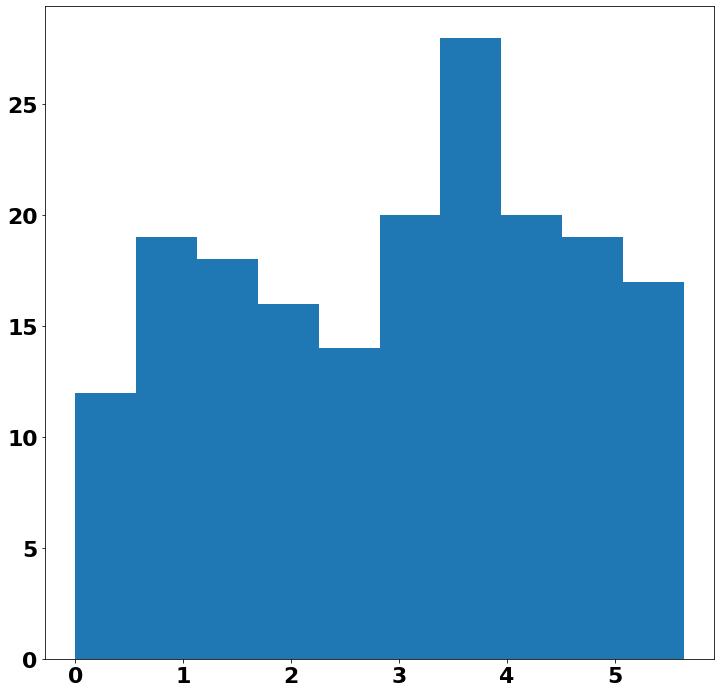

In [1068]:
plt.hist(ihme_countries['Percent of All Neonatal Deaths that are Avertable'])

(array([ 9., 18., 18., 16., 11., 13., 27., 16., 18., 16.]),
 array([0.        , 0.56371717, 1.12743434, 1.69115152, 2.25486869,
        2.81858586, 3.38230303, 3.9460202 , 4.50973737, 5.07345455,
        5.63717172]),
 <a list of 10 Patch objects>)

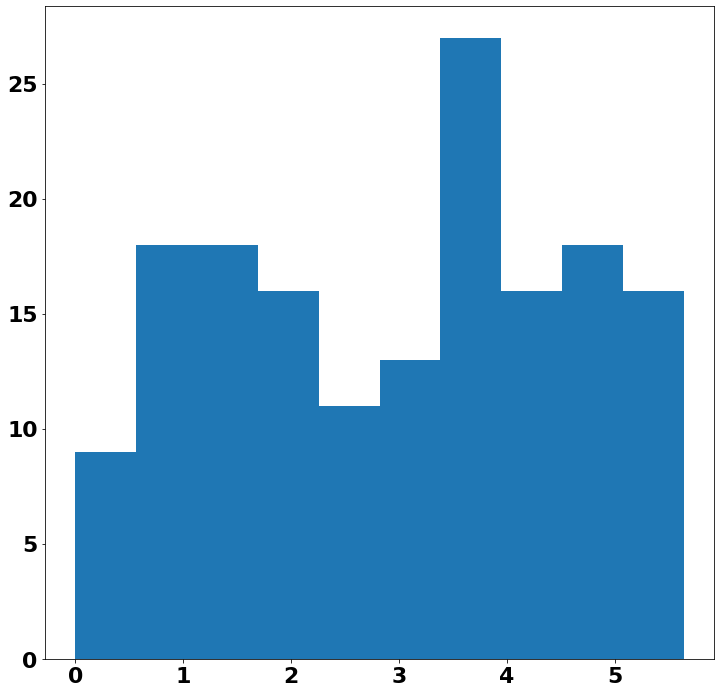

In [1069]:
plt.hist(tt1['Percent of All Neonatal Deaths that are Avertable'])

In [1070]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Percent of All Neonatal Deaths that are Avertable'
wm.title = 'Percent of All Neonatal Deaths Averted'
wm.add('< 1%',
       list(tt1[tt1[var] < 1].to_dict()['Country'].keys()))

wm.add('1 - 2%',
       list(tt1[np.logical_and(tt1[var] >= 1, tt1[var] < 2)].to_dict()['Country'].keys()))

wm.add('2 - 3%',
       list(tt1[np.logical_and(tt1[var] > 2, tt1[var] < 3)].to_dict()['Country'].keys()))

wm.add('3 - 4%',
       list(tt1[np.logical_and(tt1[var] > 3, tt1[var] < 4)].to_dict()['Country'].keys()))

wm.add('4 - 5%',
       list(tt1[np.logical_and(tt1[var] > 4, tt1[var] < 5)].to_dict()['Country'].keys()))

wm.add('> 5%',
       list(tt1[tt1[var] >= 5].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, '%avertabledeaths.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

In [1071]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Percent of All Neonatal Deaths that are Avertable (Lower Bound)'
wm.title = 'Percent of All Neonatal Deaths Averted'
wm.add('< 1%',
       list(tt1[tt1[var] < 1].to_dict()['Country'].keys()))

wm.add('1 - 2%',
       list(tt1[np.logical_and(tt1[var] >= 1, tt1[var] < 2)].to_dict()['Country'].keys()))

wm.add('2 - 3%',
       list(tt1[np.logical_and(tt1[var] > 2, tt1[var] < 3)].to_dict()['Country'].keys()))

wm.add('3 - 4%',
       list(tt1[np.logical_and(tt1[var] > 3, tt1[var] < 4)].to_dict()['Country'].keys()))

wm.add('4 - 5%',
       list(tt1[np.logical_and(tt1[var] > 4, tt1[var] < 5)].to_dict()['Country'].keys()))

wm.add('> 5%',
       list(tt1[tt1[var] >= 5].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, '%avertabledeaths_low.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

In [1072]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Percent of All Neonatal Deaths that are Avertable (Upper Bound)'
wm.title = 'Percent of All Neonatal Deaths Averted'
wm.add('< 1%',
       list(tt1[tt1[var] < 1].to_dict()['Country'].keys()))

wm.add('1 - 2%',
       list(tt1[np.logical_and(tt1[var] >= 1, tt1[var] < 2)].to_dict()['Country'].keys()))

wm.add('2 - 3%',
       list(tt1[np.logical_and(tt1[var] > 2, tt1[var] < 3)].to_dict()['Country'].keys()))

wm.add('3 - 4%',
       list(tt1[np.logical_and(tt1[var] > 3, tt1[var] < 4)].to_dict()['Country'].keys()))

wm.add('4 - 5%',
       list(tt1[np.logical_and(tt1[var] > 4, tt1[var] < 5)].to_dict()['Country'].keys()))

wm.add('> 5%',
       list(tt1[tt1[var] >= 5].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, '%avertabledeaths_upper.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

(array([ 5.,  3., 13., 22., 22., 23., 29., 31., 12.,  3.]),
 array([-2.        , -1.36960334, -0.73920669, -0.10881003,  0.52158662,
         1.15198328,  1.78237993,  2.41277659,  3.04317324,  3.6735699 ,
         4.30396655]),
 <a list of 10 Patch objects>)

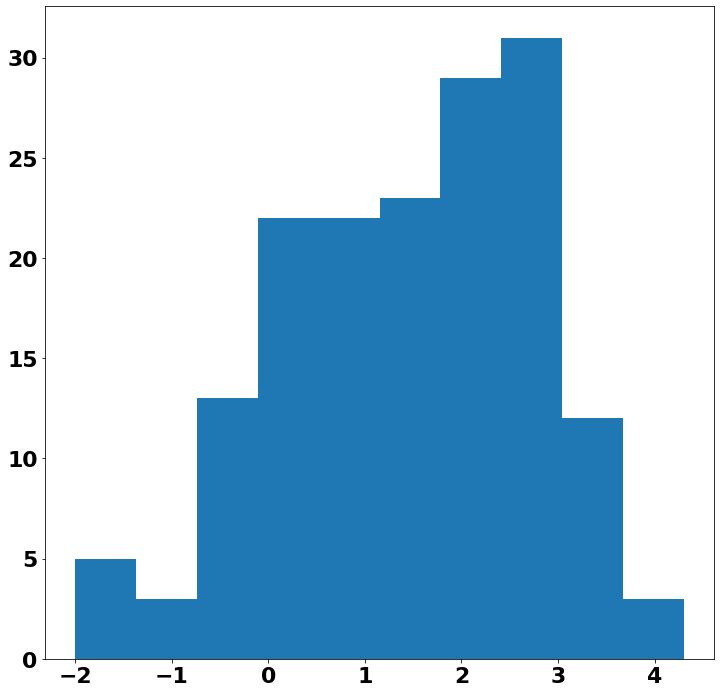

In [1073]:
plt.hist(np.log10(tt1['Number of Neonatal Deaths that are Avertable'] + 0.01))

In [1074]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Neonatal Deaths that are Avertable'
wm.title = 'Number of Neonatal Deaths Averted'
wm.add('< 100',
       list(tt1[tt1[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt1[np.logical_and(tt1[var] >= 100, tt1[var] < 1000)].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt1[np.logical_and(tt1[var] >= 1000, tt1[var] < 10000)].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt1[tt1[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

In [1075]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Neonatal Deaths that are Avertable (Lower Bound)'
wm.title = 'Number of Neonatal Deaths Averted'
wm.add('< 100',
       list(tt1[tt1[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt1[np.logical_and(tt1[var] >= 100, tt1[var] < 1000)].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt1[np.logical_and(tt1[var] >= 1000, tt1[var] < 10000)].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt1[tt1[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_lower.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

In [1076]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Neonatal Deaths that are Avertable (Upper Bound)'
wm.title = 'Number of Neonatal Deaths Averted'
wm.add('< 100',
       list(tt1[tt1[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt1[np.logical_and(tt1[var] >= 100, tt1[var] < 1000)].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt1[np.logical_and(tt1[var] >= 1000, tt1[var] < 10000)].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt1[tt1[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_upper.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

(array([ 5.,  0.,  3., 15., 27., 27., 30., 38., 15.,  3.]),
 array([-2.        , -1.29983805, -0.5996761 ,  0.10048584,  0.80064779,
         1.50080974,  2.20097169,  2.90113363,  3.60129558,  4.30145753,
         5.00161948]),
 <a list of 10 Patch objects>)

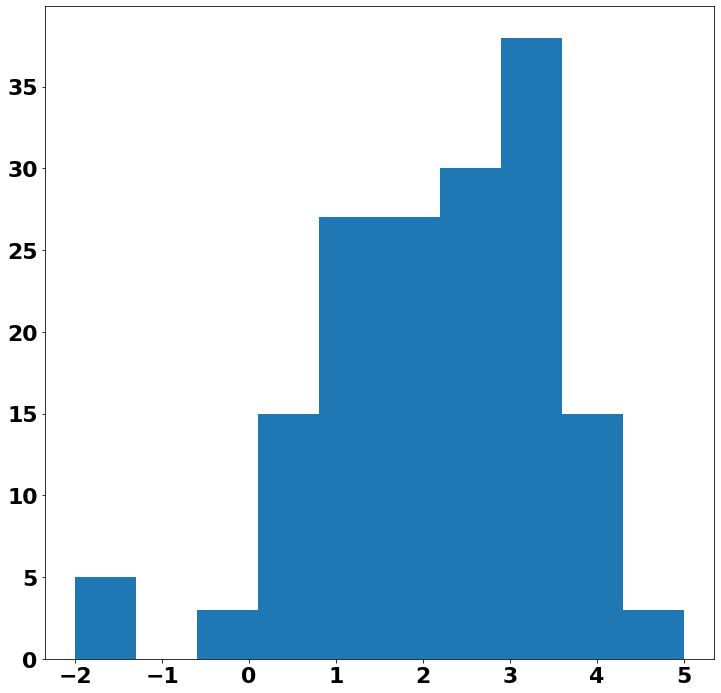

In [1077]:
plt.hist(np.log10(tt1['Number of Neonatal Cases that are Avertable'] + 0.01))

In [1078]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Neonatal Cases that are Avertable'
wm.title = 'Number of Neonatal Cases Averted'
wm.add('< 100',
       list(tt1[tt1[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt1[np.logical_and(tt1[var] >= 100, tt1[var] < 1000)].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt1[np.logical_and(tt1[var] >= 1000, tt1[var] < 10000)].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt1[tt1[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

In [1079]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Neonatal Cases that are Avertable (Lower Bound)'
wm.title = 'Number of Neonatal Cases Averted'
wm.add('< 100',
       list(tt1[tt1[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt1[np.logical_and(tt1[var] >= 100, tt1[var] < 1000)].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt1[np.logical_and(tt1[var] >= 1000, tt1[var] < 10000)].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt1[tt1[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_lower.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

In [1080]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Neonatal Cases that are Avertable (Upper Bound)'
wm.title = 'Number of Neonatal Cases Averted'
wm.add('< 100',
       list(tt1[tt1[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt1[np.logical_and(tt1[var] >= 100, tt1[var] < 1000)].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt1[np.logical_and(tt1[var] >= 1000, tt1[var] < 10000)].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt1[tt1[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_upper.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

In [1081]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution.copy(deep = True)

In [1082]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.pathogen == 'Klebsiella pneumoniae']

In [1083]:
overall_AMR_distribution_extrapolations

WHO Region               pathogen  \
24         AFR  Klebsiella pneumoniae   
25         AFR  Klebsiella pneumoniae   
26         AFR  Klebsiella pneumoniae   
27         AFR  Klebsiella pneumoniae   
28         AFR  Klebsiella pneumoniae   
29         AFR  Klebsiella pneumoniae   
30         AFR  Klebsiella pneumoniae   
31         AFR  Klebsiella pneumoniae   
32         AFR  Klebsiella pneumoniae   
33         AFR  Klebsiella pneumoniae   
34         AFR  Klebsiella pneumoniae   
35         AFR  Klebsiella pneumoniae   
72        SEAR  Klebsiella pneumoniae   
73        SEAR  Klebsiella pneumoniae   
74        SEAR  Klebsiella pneumoniae   
75        SEAR  Klebsiella pneumoniae   
76        SEAR  Klebsiella pneumoniae   
77        SEAR  Klebsiella pneumoniae   
78        SEAR  Klebsiella pneumoniae   
79        SEAR  Klebsiella pneumoniae   
80        SEAR  Klebsiella pneumoniae   
81        SEAR  Klebsiella pneumoniae   
82        SEAR  Klebsiella pneumoniae   
83        SEAR  Klebsiella pneumoniae   
118        EMR  Klebsiella pneumoniae   
119        EMR  Klebsiella pneumoniae   
120        EMR  Klebsiella pneumoniae   
121        EMR  Klebsiella pneumoniae   
122        EMR  Klebsiella pneumoniae   
123        EMR  Klebsiella pneumoniae   
124        EMR  Klebsiella pneumoniae   
125        EMR  Klebsiella pneumoniae   
126        EMR  Klebsiella pneumoniae   
127        EMR  Klebsiella pneumoniae   
128        EMR  Klebsiella pneumoniae   
140        AMR  Klebsiella pneumoniae   
141        AMR  Klebsiella pneumoniae   
142        AMR  Klebsiella pneumoniae   
143        AMR  Klebsiella pneumoniae   
144        AMR  Klebsiella pneumoniae   
145        AMR  Klebsiella pneumoniae   
146        AMR  Klebsiella pneumoniae   
147        AMR  Klebsiella pneumoniae   
165        EUR  Klebsiella pneumoniae   
166        EUR  Klebsiella pneumoniae   
167        EUR  Klebsiella pneumoniae   
168        EUR  Klebsiella pneumoniae   
169        EUR  Klebsiella pneumoniae   
170        EUR  Klebsiella pneumoniae   
171        EUR  Klebsiella pneumoniae   
172        EUR  Klebsiella pneumoniae   
198        WPR  Klebsiella pneumoniae   
199        WPR  Klebsiella pneumoniae   
200        WPR  Klebsiella pneumoniae   
201        WPR  Klebsiella pneumoniae   
202        WPR  Klebsiella pneumoniae   
203        WPR  Klebsiella pneumoniae   
204        WPR  Klebsiella pneumoniae   
205        WPR  Klebsiella pneumoniae   

                                         drug  resistant_cases  \
24                    Penicillins: Ampicillin             99.0   
25   Penicillins: Amoxicillin-Clavulanic Acid             94.0   
26       Penicillins: Piperacillin-Tazobactam             43.0   
27                Cephalosporins: Ceftazidime             91.0   
28                     Carbapenems: Meropenem              6.0   
29                Aminoglycosides: Gentamicin             87.0   
30                  Aminoglycosides: Amikacin             10.0   
31                   Penicillins: Methicillin              1.0   
32                     Macrolides: Rifampicin              0.0   
33                  Glycopeptides: Vancomycin              0.0   
34                   Macrolides: Azithromycin              1.0   
35             Fluoroquinolines: Levofloxacin              0.0   
72                    Penicillins: Ampicillin              7.0   
73   Penicillins: Amoxicillin-Clavulanic Acid              7.0   
74       Penicillins: Piperacillin-Tazobactam              6.0   
75                Cephalosporins: Ceftazidime              7.0   
76                     Carbapenems: Meropenem              4.0   
77                Aminoglycosides: Gentamicin              6.0   
78                  Aminoglycosides: Amikacin              6.0   
79                   Penicillins: Methicillin              0.0   
80                     Macrolides: Rifampicin              0.0   
81                  Glycopeptides: Vancomycin              0.0   
82                   Macr

In [1084]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.drug == 'Penicillins: Ampicillin']

In [1085]:
WHO_map = pd.read_csv(os.path.join(data_dir, 'WHO_countries_by_region.csv'))

In [1086]:
WHO_map = WHO_map[['Country', 'Region']]

In [1087]:
WHO_map = WHO_map.dropna(axis = 0)

In [1088]:
WHO_map['Region'] = WHO_map['Region'].apply(lambda x: x.split()[0])

In [1089]:
tt2 = tt1[tt1.cause != 'All causes'].copy(deep = True)

In [1090]:
tt2 = tt2.merge(WHO_map, on = ['Country'])

In [1091]:
tt2 = tt2.merge(overall_AMR_distribution_extrapolations, left_on = 'Region', right_on = 'WHO Region')

In [1092]:
tt2['Number of Ampicillin Resistant Neonatal Deaths Averted'] = tt2['Number of Neonatal Deaths that are Avertable'] * tt2['resistance_deaths']
tt2['Number of Ampicillin Resistant Neonatal Cases Averted'] = tt2['Number of Neonatal Cases that are Avertable'] * tt2['resistance_cases']

In [1093]:
tt2

Country                                          cause  cherg_val  \
0    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
1        Bahrain  Neonatal sepsis and other neonatal infections       0.75   
2         Cyprus  Neonatal sepsis and other neonatal infections       1.00   
3       Djibouti  Neonatal sepsis and other neonatal infections     151.50   
4          Egypt  Neonatal sepsis and other neonatal infections    3903.50   
..           ...                                            ...        ...   
157      Myanmar  Neonatal sepsis and other neonatal infections    4930.50   
158        Nepal  Neonatal sepsis and other neonatal infections    3255.75   
159    Sri Lanka  Neonatal sepsis and other neonatal infections     131.00   
160     Thailand  Neonatal sepsis and other neonatal infections     578.50   
161  Timor-Leste  Neonatal sepsis and other neonatal infections     277.50   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
0        3581.75     16675.50               75565.5  2015.5   980.675044   
1           0.00         3.50                  49.5  2015.5     0.980517   
2           0.00         4.25                  41.5  2015.5     0.506737   
3          81.50       262.00                1513.5  2015.5    93.819619   
4        2153.50      6984.75               70922.0  2015.5   509.903012   
..           ...          ...                   ...     ...          ...   
157      2521.25      8264.25               50681.0  2015.5  2729.565018   
158      2103.50      4696.50               26613.5  2015.5  1274.398294   
159        75.50       225.00                3664.5  2015.5   206.244826   
160       247.25      1190.00               10789.5  2015.5   494.805834   
161       136.75       471.25                2154.0  2015.5    60.206099   

           upper        lower  ...  beta_samples_overall_deaths  \
0    1758.252247   484.689042  ...                     0.977587   
1       1.367721     0.692615  ...                     0.977587   
2       0.704163     0.348234  ...                     0.977587   
3     145.475125    56.392335  ...                     0.977587   
4     986.308060   212.860895  ...                     0.977587   
..           ...          ...  ...                          ...   
157  4404.383360  1600.873186  ...                     0.192375   
158  2067.625379   763.156608  ...                     0.192375   
159   298.201728   135.356813  ...                     0.192375   
160   631.221989   381.869219  ...                     0.192375   
161    96.826656    35.213767  ...                     0.192375   

     beta_samples_overall_deaths  resistance_cases  resistance_deaths  \
0                       0.899868          0.707116           0.707097   
1                       0.899868          0.707116           0.707097   
2                       0.899868          0.707116           0.707097   
3                       0.899868          0.707116           0.707097   
4                       0.899868          0.707116           0.707097   
..                           ...               ...                ...   
157                     0.178788          0.965640           0.174359   
158                     0.178788          0.965640           0.174359   
159                     0.178788          0.965640           0.174359   
160                     0.178788          0.965640           0.174359   
161                     0.178788          0.965640           0.174359   

     resistance_cases_lower  resistance_deaths_lower  resistance_cases_upper  \
0                  0.158230                 0.158270                0.987387   
1                  0.158230                 0.158270                0.987387   
2                  0.158230                 0.158270                0.987387   
3                  0.158230                 0.158270                0.987387   
4                  0.158230                 0.158270                0.987387 

In [1094]:
tt2['Number of Ampicillin Resistant Neonatal Deaths Averted (2.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Lower Bound)'] * tt2['resistance_deaths_lower']

In [1095]:
tt2['Number of Ampicillin Resistant Neonatal Deaths Averted (97.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Upper Bound)'] * tt2['resistance_deaths_upper']

In [1096]:
tt2['Number of Ampicillin Resistant Neonatal Cases Averted (2.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Lower Bound)'] * tt2['resistance_cases_lower']

In [1097]:
tt2['Number of Ampicillin Resistant Neonatal Cases Averted (97.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Upper Bound)'] * tt2['resistance_cases_upper']

In [1098]:
var = 'Number of Ampicillin Resistant Neonatal Deaths Averted'

In [1099]:
tt2 = tt2.set_index(tt2.code)

(array([146.,  10.,   1.,   1.,   2.,   0.,   0.,   1.,   0.,   1.]),
 array([   0.        ,  748.28225617, 1496.56451234, 2244.84676852,
        2993.12902469, 3741.41128086, 4489.69353703, 5237.9757932 ,
        5986.25804938, 6734.54030555, 7482.82256172]),
 <a list of 10 Patch objects>)

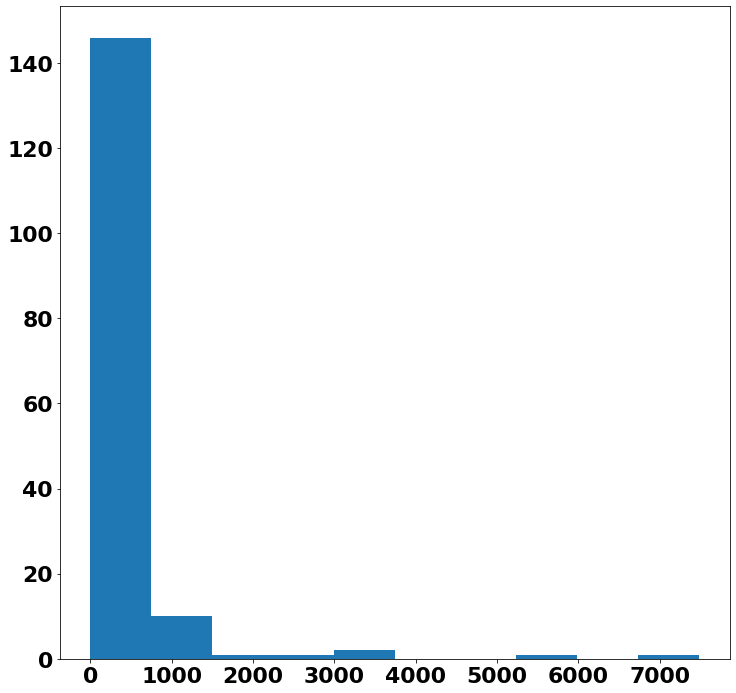

In [1100]:
plt.hist(tt2['Number of Ampicillin Resistant Neonatal Deaths Averted'])

In [1101]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ampicillin Resistant Neonatal Deaths Averted'
wm.title = 'Number of Ampicillin Resistant Neonatal Deaths Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('> 1,000',
       list(tt2[tt2[var] >= 1000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant-ampicillin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1102]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ampicillin Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.title = 'Number of Ampicillin Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_low-ampicillin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1103]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ampicillin Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.title = 'Number of Ampicillin Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_high-ampicillin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


(array([ 5.,  0.,  3., 15., 27., 27., 30., 37., 15.,  3.]),
 array([-2.        , -1.30135651, -0.60271301,  0.09593048,  0.79457398,
         1.49321747,  2.19186097,  2.89050446,  3.58914796,  4.28779145,
         4.98643495]),
 <a list of 10 Patch objects>)

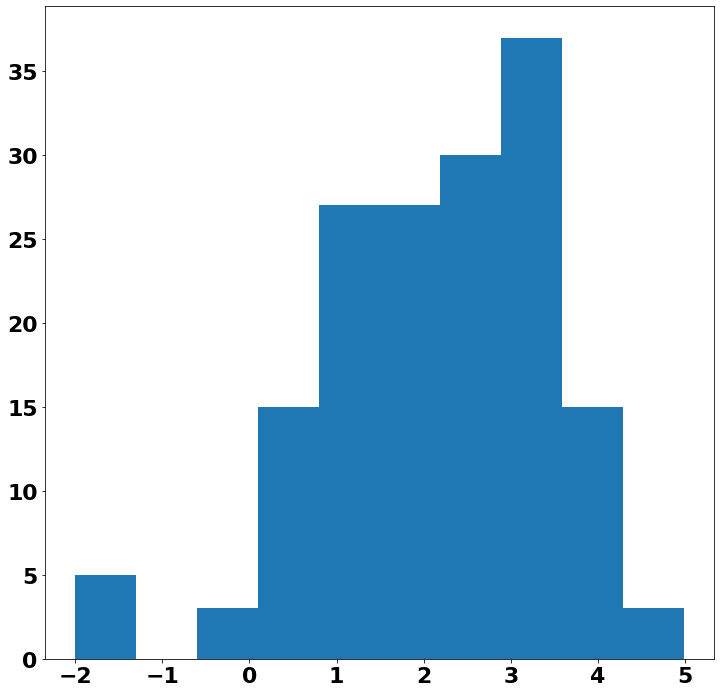

In [1104]:
plt.hist(np.log10(tt2['Number of Ampicillin Resistant Neonatal Cases Averted'] + 0.01))

In [1105]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ampicillin Resistant Neonatal Cases Averted'
wm.title = 'Number of Ampicillin Resistant Neonatal Cases Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_resistant-ampicillin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1106]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ampicillin Resistant Neonatal Cases Averted'
wm.title = 'Number of Ampicillin Resistant Neonatal Cases Averted (2.5th Percentile)'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_resistant_low-ampicillin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1107]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ampicillin Resistant Neonatal Cases Averted'
wm.title = 'Number of Ampicillin Resistant Neonatal Cases Averted (97.5th Percentile)'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_resistant_upper-ampicillin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1108]:
tt3 = tt2[['Number of Ampicillin Resistant Neonatal Deaths Averted',
          'Number of Ampicillin Resistant Neonatal Deaths Averted (2.5th Percentile)',
          'Number of Ampicillin Resistant Neonatal Deaths Averted (97.5th Percentile)']]

# Gentamicin

In [1109]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution.copy(deep = True)

In [1110]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.pathogen == 'Klebsiella pneumoniae']

In [1111]:
overall_AMR_distribution_extrapolations

WHO Region               pathogen  \
24         AFR  Klebsiella pneumoniae   
25         AFR  Klebsiella pneumoniae   
26         AFR  Klebsiella pneumoniae   
27         AFR  Klebsiella pneumoniae   
28         AFR  Klebsiella pneumoniae   
29         AFR  Klebsiella pneumoniae   
30         AFR  Klebsiella pneumoniae   
31         AFR  Klebsiella pneumoniae   
32         AFR  Klebsiella pneumoniae   
33         AFR  Klebsiella pneumoniae   
34         AFR  Klebsiella pneumoniae   
35         AFR  Klebsiella pneumoniae   
72        SEAR  Klebsiella pneumoniae   
73        SEAR  Klebsiella pneumoniae   
74        SEAR  Klebsiella pneumoniae   
75        SEAR  Klebsiella pneumoniae   
76        SEAR  Klebsiella pneumoniae   
77        SEAR  Klebsiella pneumoniae   
78        SEAR  Klebsiella pneumoniae   
79        SEAR  Klebsiella pneumoniae   
80        SEAR  Klebsiella pneumoniae   
81        SEAR  Klebsiella pneumoniae   
82        SEAR  Klebsiella pneumoniae   
83        SEAR  Klebsiella pneumoniae   
118        EMR  Klebsiella pneumoniae   
119        EMR  Klebsiella pneumoniae   
120        EMR  Klebsiella pneumoniae   
121        EMR  Klebsiella pneumoniae   
122        EMR  Klebsiella pneumoniae   
123        EMR  Klebsiella pneumoniae   
124        EMR  Klebsiella pneumoniae   
125        EMR  Klebsiella pneumoniae   
126        EMR  Klebsiella pneumoniae   
127        EMR  Klebsiella pneumoniae   
128        EMR  Klebsiella pneumoniae   
140        AMR  Klebsiella pneumoniae   
141        AMR  Klebsiella pneumoniae   
142        AMR  Klebsiella pneumoniae   
143        AMR  Klebsiella pneumoniae   
144        AMR  Klebsiella pneumoniae   
145        AMR  Klebsiella pneumoniae   
146        AMR  Klebsiella pneumoniae   
147        AMR  Klebsiella pneumoniae   
165        EUR  Klebsiella pneumoniae   
166        EUR  Klebsiella pneumoniae   
167        EUR  Klebsiella pneumoniae   
168        EUR  Klebsiella pneumoniae   
169        EUR  Klebsiella pneumoniae   
170        EUR  Klebsiella pneumoniae   
171        EUR  Klebsiella pneumoniae   
172        EUR  Klebsiella pneumoniae   
198        WPR  Klebsiella pneumoniae   
199        WPR  Klebsiella pneumoniae   
200        WPR  Klebsiella pneumoniae   
201        WPR  Klebsiella pneumoniae   
202        WPR  Klebsiella pneumoniae   
203        WPR  Klebsiella pneumoniae   
204        WPR  Klebsiella pneumoniae   
205        WPR  Klebsiella pneumoniae   

                                         drug  resistant_cases  \
24                    Penicillins: Ampicillin             99.0   
25   Penicillins: Amoxicillin-Clavulanic Acid             94.0   
26       Penicillins: Piperacillin-Tazobactam             43.0   
27                Cephalosporins: Ceftazidime             91.0   
28                     Carbapenems: Meropenem              6.0   
29                Aminoglycosides: Gentamicin             87.0   
30                  Aminoglycosides: Amikacin             10.0   
31                   Penicillins: Methicillin              1.0   
32                     Macrolides: Rifampicin              0.0   
33                  Glycopeptides: Vancomycin              0.0   
34                   Macrolides: Azithromycin              1.0   
35             Fluoroquinolines: Levofloxacin              0.0   
72                    Penicillins: Ampicillin              7.0   
73   Penicillins: Amoxicillin-Clavulanic Acid              7.0   
74       Penicillins: Piperacillin-Tazobactam              6.0   
75                Cephalosporins: Ceftazidime              7.0   
76                     Carbapenems: Meropenem              4.0   
77                Aminoglycosides: Gentamicin              6.0   
78                  Aminoglycosides: Amikacin              6.0   
79                   Penicillins: Methicillin              0.0   
80                     Macrolides: Rifampicin              0.0   
81                  Glycopeptides: Vancomycin              0.0   
82                   Macr

In [1112]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.drug == 'Aminoglycosides: Gentamicin']

In [1113]:
WHO_map = pd.read_csv(os.path.join(data_dir, 'WHO_countries_by_region.csv'))

In [1114]:
WHO_map = WHO_map[['Country', 'Region']]

In [1115]:
WHO_map = WHO_map.dropna(axis = 0)

In [1116]:
WHO_map['Region'] = WHO_map['Region'].apply(lambda x: x.split()[0])

In [1117]:
tt2 = tt1[tt1.cause != 'All causes'].copy(deep = True)

In [1118]:
tt2 = tt2.merge(WHO_map, on = ['Country'])

In [1119]:
tt2 = tt2.merge(overall_AMR_distribution_extrapolations, left_on = 'Region', right_on = 'WHO Region')

In [1120]:
tt2['Number of Gentamicin Resistant Neonatal Deaths Averted'] = tt2['Number of Neonatal Deaths that are Avertable'] * tt2['resistance_deaths']
tt2['Number of Gentamicin Resistant Neonatal Cases Averted'] = tt2['Number of Neonatal Cases that are Avertable'] * tt2['resistance_cases']

In [1121]:
tt2

Country                                          cause  cherg_val  \
0    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
1        Bahrain  Neonatal sepsis and other neonatal infections       0.75   
2         Cyprus  Neonatal sepsis and other neonatal infections       1.00   
3       Djibouti  Neonatal sepsis and other neonatal infections     151.50   
4          Egypt  Neonatal sepsis and other neonatal infections    3903.50   
..           ...                                            ...        ...   
157      Myanmar  Neonatal sepsis and other neonatal infections    4930.50   
158        Nepal  Neonatal sepsis and other neonatal infections    3255.75   
159    Sri Lanka  Neonatal sepsis and other neonatal infections     131.00   
160     Thailand  Neonatal sepsis and other neonatal infections     578.50   
161  Timor-Leste  Neonatal sepsis and other neonatal infections     277.50   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
0        3581.75     16675.50               75565.5  2015.5   980.675044   
1           0.00         3.50                  49.5  2015.5     0.980517   
2           0.00         4.25                  41.5  2015.5     0.506737   
3          81.50       262.00                1513.5  2015.5    93.819619   
4        2153.50      6984.75               70922.0  2015.5   509.903012   
..           ...          ...                   ...     ...          ...   
157      2521.25      8264.25               50681.0  2015.5  2729.565018   
158      2103.50      4696.50               26613.5  2015.5  1274.398294   
159        75.50       225.00                3664.5  2015.5   206.244826   
160       247.25      1190.00               10789.5  2015.5   494.805834   
161       136.75       471.25                2154.0  2015.5    60.206099   

           upper        lower  ...  beta_samples_overall_deaths  \
0    1758.252247   484.689042  ...                     0.822049   
1       1.367721     0.692615  ...                     0.822049   
2       0.704163     0.348234  ...                     0.822049   
3     145.475125    56.392335  ...                     0.822049   
4     986.308060   212.860895  ...                     0.822049   
..           ...          ...  ...                          ...   
157  4404.383360  1600.873186  ...                     0.836815   
158  2067.625379   763.156608  ...                     0.836815   
159   298.201728   135.356813  ...                     0.836815   
160   631.221989   381.869219  ...                     0.836815   
161    96.826656    35.213767  ...                     0.836815   

     beta_samples_overall_deaths  resistance_cases  resistance_deaths  \
0                       0.430351          0.707110           0.707125   
1                       0.430351          0.707110           0.707125   
2                       0.430351          0.707110           0.707125   
3                       0.430351          0.707110           0.707125   
4                       0.430351          0.707110           0.707125   
..                           ...               ...                ...   
157                     0.750814          0.634928           0.879748   
158                     0.750814          0.634928           0.879748   
159                     0.750814          0.634928           0.879748   
160                     0.750814          0.634928           0.879748   
161                     0.750814          0.634928           0.879748   

     resistance_cases_lower  resistance_deaths_lower  resistance_cases_upper  \
0                  0.158328                 0.158262                0.987394   
1                  0.158328                 0.158262                0.987394   
2                  0.158328                 0.158262                0.987394   
3                  0.158328                 0.158262                0.987394   
4                  0.158328                 0.158262                0.987394 

In [1122]:
tt2['Number of Gentamicin Resistant Neonatal Deaths Averted (2.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Lower Bound)'] * tt2['resistance_deaths_lower']

In [1123]:
tt2['Number of Gentamicin Resistant Neonatal Deaths Averted (97.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Upper Bound)'] * tt2['resistance_deaths_upper']

In [1124]:
tt2['Number of Gentamicin Resistant Neonatal Cases Averted (2.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Lower Bound)'] * tt2['resistance_cases_lower']

In [1125]:
tt2['Number of Gentamicin Resistant Neonatal Cases Averted (97.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Upper Bound)'] * tt2['resistance_cases_upper']

In [1126]:
var = 'Number of Gentamicin Resistant Neonatal Deaths Averted'

In [1127]:
tt2 = tt2.set_index(tt2.code)

(array([156.,   3.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([    0.        ,  1771.43323538,  3542.86647075,  5314.29970613,
         7085.7329415 ,  8857.16617688, 10628.59941226, 12400.03264763,
        14171.46588301, 15942.89911838, 17714.33235376]),
 <a list of 10 Patch objects>)

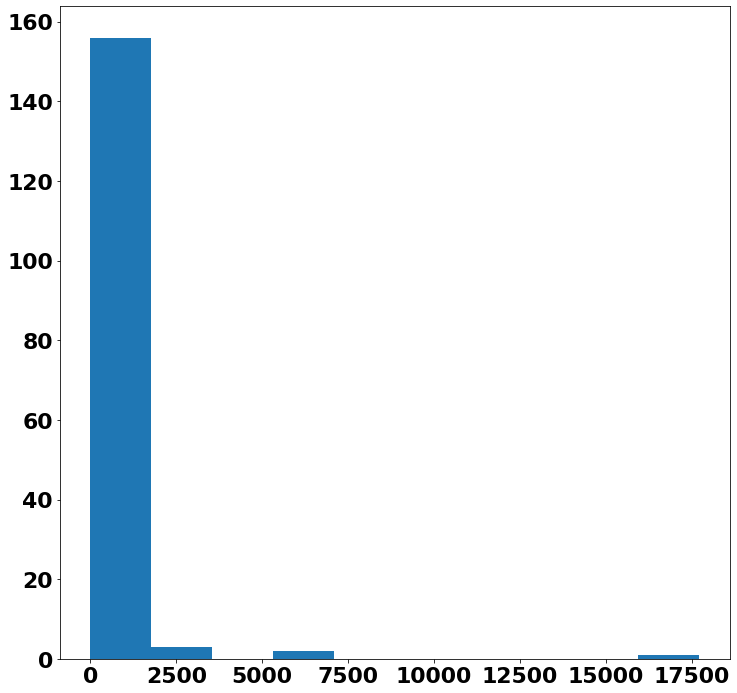

In [1128]:
plt.hist(tt2['Number of Gentamicin Resistant Neonatal Deaths Averted'])

In [1129]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Gentamicin Resistant Neonatal Deaths Averted'
wm.title = 'Number of Gentamicin Resistant Neonatal Deaths Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('> 1,000',
       list(tt2[tt2[var] >= 1000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant-gentamicin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1130]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Gentamicin Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.title = 'Number of Gentamicin Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_low-gentamicin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1131]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Gentamicin Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.title = 'Number of Gentamicin Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_high-gentamicin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


(array([ 5.,  0.,  8., 23., 27., 17., 31., 31., 16.,  4.]),
 array([-2.        , -1.3195656 , -0.63913121,  0.04130319,  0.72173758,
         1.40217198,  2.08260638,  2.76304077,  3.44347517,  4.12390957,
         4.80434396]),
 <a list of 10 Patch objects>)

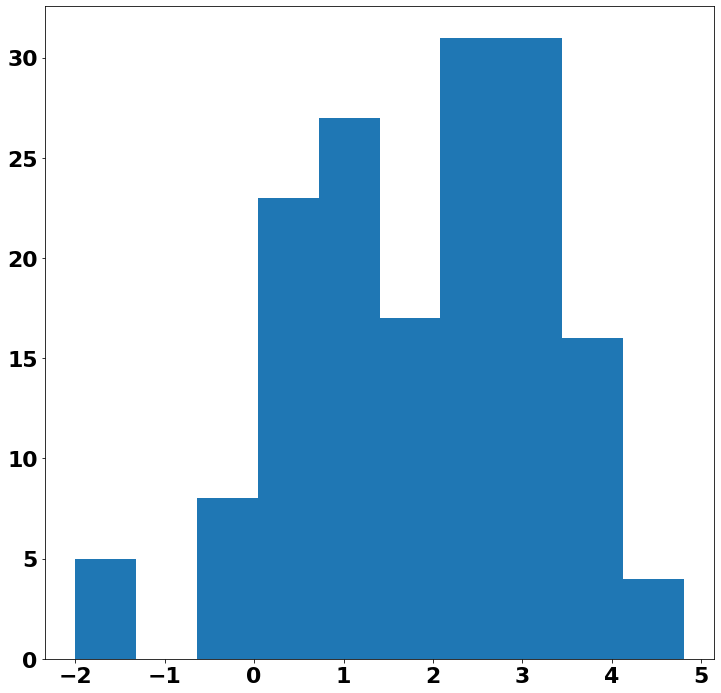

In [1132]:
plt.hist(np.log10(tt2['Number of Gentamicin Resistant Neonatal Cases Averted'] + 0.01))

In [1133]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Gentamicin Resistant Neonatal Cases Averted'
wm.title = 'Number of Gentamicin Resistant Neonatal Cases Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_resistant-gentamicin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1134]:
tt3

Number of Ampicillin Resistant Neonatal Deaths Averted  \
code                                                           
af                                           930.745366        
bh                                             0.074289        
cy                                             0.099052        
dj                                            15.006430        
eg                                           386.650831        
...                                                 ...        
mm                                           120.425984        
np                                            79.520717        
lk                                             3.199636        
th                                            14.129689        
tl                                             6.777854        

      Number of Ampicillin Resistant Neonatal Deaths Averted (2.5th Percentile)  \
code                                                                              
af                                           129.014314                           
bh                                             0.010298                           
cy                                             0.013730                           
dj                                             2.080101                           
eg                                            53.595208                           
...                                                 ...                           
mm                                            39.430289                           
np                                            26.036946                           
lk                                             1.047636                           
th                                             4.626391                           
tl                                             2.219228                           

      Number of Ampicillin Resistant Neonatal Deaths Averted (97.5th Percentile)  
code                                                                              
af                                          1897.329325                           
bh                                             0.151439                           
cy                                             0.201919                           
dj                                            30.590687                           
eg                                           788.189754                           
...                                                 ...                           
mm                                           311.634856                           
np                                           205.781398                           
lk                                             8.279924                           
th                                            36.564398                           
tl                                            17.539534                           

[162 rows x 3 columns]

In [1135]:
pd.concat([tt3, tt2[['Number of Gentamicin Resistant Neonatal Deaths Averted',
          'Number of Gentamicin Resistant Neonatal Deaths Averted (2.5th Percentile)',
          'Number of Gentamicin Resistant Neonatal Deaths Averted (97.5th Percentile)']]], axis = 1)

Number of Ampicillin Resistant Neonatal Deaths Averted  \
code                                                           
af                                           930.745366        
bh                                             0.074289        
cy                                             0.099052        
dj                                            15.006430        
eg                                           386.650831        
...                                                 ...        
mm                                           120.425984        
np                                            79.520717        
lk                                             3.199636        
th                                            14.129689        
tl                                             6.777854        

      Number of Ampicillin Resistant Neonatal Deaths Averted (2.5th Percentile)  \
code                                                                              
af                                           129.014314                           
bh                                             0.010298                           
cy                                             0.013730                           
dj                                             2.080101                           
eg                                            53.595208                           
...                                                 ...                           
mm                                            39.430289                           
np                                            26.036946                           
lk                                             1.047636                           
th                                             4.626391                           
tl                                             2.219228                           

      Number of Ampicillin Resistant Neonatal Deaths Averted (97.5th Percentile)  \
code                                                                               
af                                          1897.329325                            
bh                                             0.151439                            
cy                                             0.201919                            
dj                                            30.590687                            
eg                                           788.189754                            
...                                                 ...                            
mm                                           311.634856                            
np                                           205.781398                            
lk                                             8.279924                            
th                                            36.564398                            
tl                                            17.539534                            

      Number of Gentamicin Resistant Neonatal Deaths Averted  \
code                                                           
af                                           930.782202        
bh                                             0.074292        
cy                                             0.099056        
dj                                            15.007024        
eg                                           386.666134        
...                                                 ...        
mm                                           607.624239        
np                                           401.231643        
lk                                            16.144159        
th                                            71.293098        
tl                                            34.198504        

      Number of Gentamicin Resistant Neonatal Deaths Averted (2.5th Percentile)  \
code                                                                              
a

In [1136]:
tt3 = pd.concat([tt3, tt2[['Number of Gentamicin Resistant Neonatal Deaths Averted',
          'Number of Gentamicin Resistant Neonatal Deaths Averted (2.5th Percentile)',
          'Number of Gentamicin Resistant Neonatal Deaths Averted (97.5th Percentile)']]], axis = 1)

# Amikacin

In [1137]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution.copy(deep = True)

In [1138]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.pathogen == 'Klebsiella pneumoniae']

In [1139]:
overall_AMR_distribution_extrapolations

WHO Region               pathogen  \
24         AFR  Klebsiella pneumoniae   
25         AFR  Klebsiella pneumoniae   
26         AFR  Klebsiella pneumoniae   
27         AFR  Klebsiella pneumoniae   
28         AFR  Klebsiella pneumoniae   
29         AFR  Klebsiella pneumoniae   
30         AFR  Klebsiella pneumoniae   
31         AFR  Klebsiella pneumoniae   
32         AFR  Klebsiella pneumoniae   
33         AFR  Klebsiella pneumoniae   
34         AFR  Klebsiella pneumoniae   
35         AFR  Klebsiella pneumoniae   
72        SEAR  Klebsiella pneumoniae   
73        SEAR  Klebsiella pneumoniae   
74        SEAR  Klebsiella pneumoniae   
75        SEAR  Klebsiella pneumoniae   
76        SEAR  Klebsiella pneumoniae   
77        SEAR  Klebsiella pneumoniae   
78        SEAR  Klebsiella pneumoniae   
79        SEAR  Klebsiella pneumoniae   
80        SEAR  Klebsiella pneumoniae   
81        SEAR  Klebsiella pneumoniae   
82        SEAR  Klebsiella pneumoniae   
83        SEAR  Klebsiella pneumoniae   
118        EMR  Klebsiella pneumoniae   
119        EMR  Klebsiella pneumoniae   
120        EMR  Klebsiella pneumoniae   
121        EMR  Klebsiella pneumoniae   
122        EMR  Klebsiella pneumoniae   
123        EMR  Klebsiella pneumoniae   
124        EMR  Klebsiella pneumoniae   
125        EMR  Klebsiella pneumoniae   
126        EMR  Klebsiella pneumoniae   
127        EMR  Klebsiella pneumoniae   
128        EMR  Klebsiella pneumoniae   
140        AMR  Klebsiella pneumoniae   
141        AMR  Klebsiella pneumoniae   
142        AMR  Klebsiella pneumoniae   
143        AMR  Klebsiella pneumoniae   
144        AMR  Klebsiella pneumoniae   
145        AMR  Klebsiella pneumoniae   
146        AMR  Klebsiella pneumoniae   
147        AMR  Klebsiella pneumoniae   
165        EUR  Klebsiella pneumoniae   
166        EUR  Klebsiella pneumoniae   
167        EUR  Klebsiella pneumoniae   
168        EUR  Klebsiella pneumoniae   
169        EUR  Klebsiella pneumoniae   
170        EUR  Klebsiella pneumoniae   
171        EUR  Klebsiella pneumoniae   
172        EUR  Klebsiella pneumoniae   
198        WPR  Klebsiella pneumoniae   
199        WPR  Klebsiella pneumoniae   
200        WPR  Klebsiella pneumoniae   
201        WPR  Klebsiella pneumoniae   
202        WPR  Klebsiella pneumoniae   
203        WPR  Klebsiella pneumoniae   
204        WPR  Klebsiella pneumoniae   
205        WPR  Klebsiella pneumoniae   

                                         drug  resistant_cases  \
24                    Penicillins: Ampicillin             99.0   
25   Penicillins: Amoxicillin-Clavulanic Acid             94.0   
26       Penicillins: Piperacillin-Tazobactam             43.0   
27                Cephalosporins: Ceftazidime             91.0   
28                     Carbapenems: Meropenem              6.0   
29                Aminoglycosides: Gentamicin             87.0   
30                  Aminoglycosides: Amikacin             10.0   
31                   Penicillins: Methicillin              1.0   
32                     Macrolides: Rifampicin              0.0   
33                  Glycopeptides: Vancomycin              0.0   
34                   Macrolides: Azithromycin              1.0   
35             Fluoroquinolines: Levofloxacin              0.0   
72                    Penicillins: Ampicillin              7.0   
73   Penicillins: Amoxicillin-Clavulanic Acid              7.0   
74       Penicillins: Piperacillin-Tazobactam              6.0   
75                Cephalosporins: Ceftazidime              7.0   
76                     Carbapenems: Meropenem              4.0   
77                Aminoglycosides: Gentamicin              6.0   
78                  Aminoglycosides: Amikacin              6.0   
79                   Penicillins: Methicillin              0.0   
80                     Macrolides: Rifampicin              0.0   
81                  Glycopeptides: Vancomycin              0.0   
82                   Macr

In [1140]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.drug == 'Aminoglycosides: Amikacin']

In [1141]:
WHO_map = pd.read_csv(os.path.join(data_dir, 'WHO_countries_by_region.csv'))

In [1142]:
WHO_map = WHO_map[['Country', 'Region']]

In [1143]:
WHO_map = WHO_map.dropna(axis = 0)

In [1144]:
WHO_map['Region'] = WHO_map['Region'].apply(lambda x: x.split()[0])

In [1145]:
tt2 = tt1[tt1.cause != 'All causes'].copy(deep = True)

In [1146]:
tt2 = tt2.merge(WHO_map, on = ['Country'])

In [1147]:
tt2 = tt2.merge(overall_AMR_distribution_extrapolations, left_on = 'Region', right_on = 'WHO Region')

In [1148]:
tt2['Number of Amikacin Resistant Neonatal Deaths Averted'] = tt2['Number of Neonatal Deaths that are Avertable'] * tt2['resistance_deaths']
tt2['Number of Amikacin Resistant Neonatal Cases Averted'] = tt2['Number of Neonatal Cases that are Avertable'] * tt2['resistance_cases']

In [1149]:
tt2

Country                                          cause  cherg_val  \
0    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
1        Bahrain  Neonatal sepsis and other neonatal infections       0.75   
2         Cyprus  Neonatal sepsis and other neonatal infections       1.00   
3       Djibouti  Neonatal sepsis and other neonatal infections     151.50   
4          Egypt  Neonatal sepsis and other neonatal infections    3903.50   
..           ...                                            ...        ...   
157      Myanmar  Neonatal sepsis and other neonatal infections    4930.50   
158        Nepal  Neonatal sepsis and other neonatal infections    3255.75   
159    Sri Lanka  Neonatal sepsis and other neonatal infections     131.00   
160     Thailand  Neonatal sepsis and other neonatal infections     578.50   
161  Timor-Leste  Neonatal sepsis and other neonatal infections     277.50   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
0        3581.75     16675.50               75565.5  2015.5   980.675044   
1           0.00         3.50                  49.5  2015.5     0.980517   
2           0.00         4.25                  41.5  2015.5     0.506737   
3          81.50       262.00                1513.5  2015.5    93.819619   
4        2153.50      6984.75               70922.0  2015.5   509.903012   
..           ...          ...                   ...     ...          ...   
157      2521.25      8264.25               50681.0  2015.5  2729.565018   
158      2103.50      4696.50               26613.5  2015.5  1274.398294   
159        75.50       225.00                3664.5  2015.5   206.244826   
160       247.25      1190.00               10789.5  2015.5   494.805834   
161       136.75       471.25                2154.0  2015.5    60.206099   

           upper        lower  ...  beta_samples_overall_deaths  \
0    1758.252247   484.689042  ...                     0.921775   
1       1.367721     0.692615  ...                     0.921775   
2       0.704163     0.348234  ...                     0.921775   
3     145.475125    56.392335  ...                     0.921775   
4     986.308060   212.860895  ...                     0.921775   
..           ...          ...  ...                          ...   
157  4404.383360  1600.873186  ...                     0.910252   
158  2067.625379   763.156608  ...                     0.910252   
159   298.201728   135.356813  ...                     0.910252   
160   631.221989   381.869219  ...                     0.910252   
161    96.826656    35.213767  ...                     0.910252   

     beta_samples_overall_deaths  resistance_cases  resistance_deaths  \
0                       0.508769          0.707076           0.707107   
1                       0.508769          0.707076           0.707107   
2                       0.508769          0.707076           0.707107   
3                       0.508769          0.707076           0.707107   
4                       0.508769          0.707076           0.707107   
..                           ...               ...                ...   
157                     0.925011          0.634980           0.928591   
158                     0.925011          0.634980           0.928591   
159                     0.925011          0.634980           0.928591   
160                     0.925011          0.634980           0.928591   
161                     0.925011          0.634980           0.928591   

     resistance_cases_lower  resistance_deaths_lower  resistance_cases_upper  \
0                  0.158367                 0.158390                0.987374   
1                  0.158367                 0.158390                0.987374   
2                  0.158367                 0.158390                0.987374   
3                  0.158367                 0.158390                0.987374   
4                  0.158367                 0.158390                0.987374 

In [1150]:
tt2['Number of Amikacin Resistant Neonatal Deaths Averted (2.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Lower Bound)'] * tt2['resistance_deaths_lower']

In [1151]:
tt2['Number of Amikacin Resistant Neonatal Deaths Averted (97.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Upper Bound)'] * tt2['resistance_deaths_upper']

In [1152]:
tt2['Number of Amikacin Resistant Neonatal Cases Averted (2.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Lower Bound)'] * tt2['resistance_cases_lower']

In [1153]:
tt2['Number of Amikacin Resistant Neonatal Cases Averted (97.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Upper Bound)'] * tt2['resistance_cases_upper']

In [1154]:
var = 'Number of Amikacin Resistant Neonatal Deaths Averted'

In [1155]:
tt2 = tt2.set_index(tt2.code)

(array([158.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([    0.        ,  1869.78060007,  3739.56120014,  5609.3418002 ,
         7479.12240027,  9348.90300034, 11218.68360041, 13088.46420047,
        14958.24480054, 16828.02540061, 18697.80600068]),
 <a list of 10 Patch objects>)

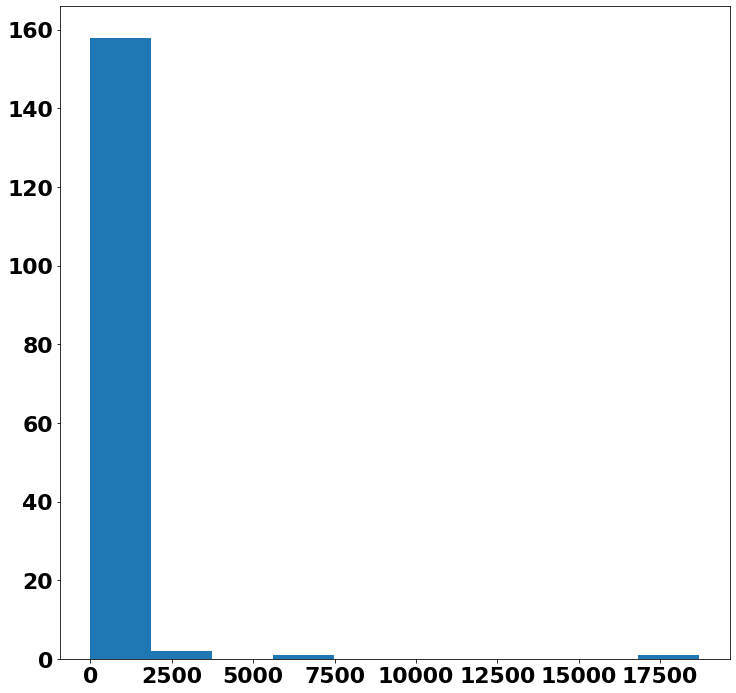

In [1156]:
plt.hist(tt2['Number of Amikacin Resistant Neonatal Deaths Averted'])

In [1157]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Amikacin Resistant Neonatal Deaths Averted'
wm.title = 'Number of Amikacin Resistant Neonatal Deaths Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('> 1,000',
       list(tt2[tt2[var] >= 1000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant-amikacin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1158]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Amikacin Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.title = 'Number of Amikacin Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_low-amikacin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1159]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Amikacin Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.title = 'Number of Amikacin Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_high-amikacin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


(array([ 5.,  1., 11., 29., 28., 25., 36., 21.,  4.,  2.]),
 array([-2.        , -1.31956201, -0.63912403,  0.04131396,  0.72175194,
         1.40218993,  2.08262792,  2.7630659 ,  3.44350389,  4.12394187,
         4.80437986]),
 <a list of 10 Patch objects>)

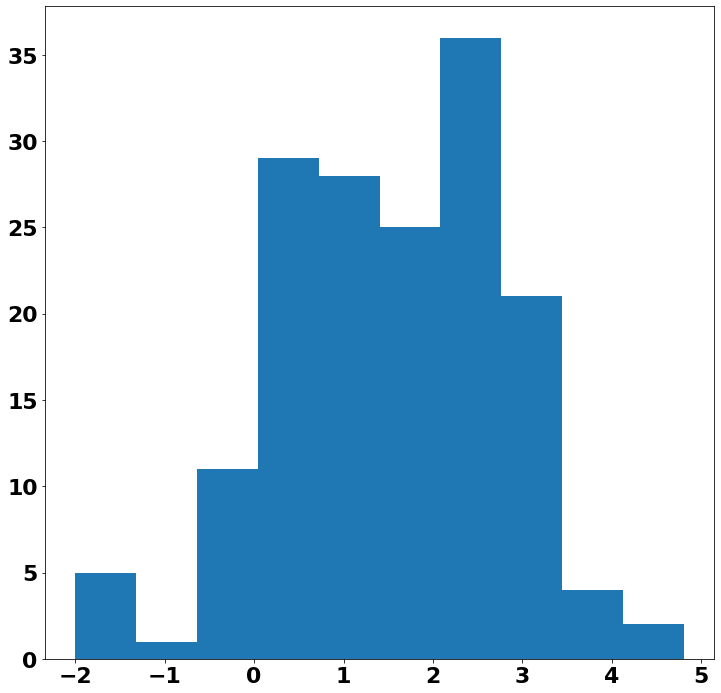

In [1160]:
plt.hist(np.log10(tt2['Number of Amikacin Resistant Neonatal Cases Averted'] + 0.01))

In [1161]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Amikacin Resistant Neonatal Cases Averted'
wm.title = 'Number of Amikacin Resistant Neonatal Cases Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_resistant-amikacin.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1162]:
tt3 = pd.concat([tt3, tt2[['Number of Amikacin Resistant Neonatal Deaths Averted',
          'Number of Amikacin Resistant Neonatal Deaths Averted (2.5th Percentile)',
          'Number of Amikacin Resistant Neonatal Deaths Averted (97.5th Percentile)']]], axis = 1)

# Ceftazidime

In [1163]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution.copy(deep = True)

In [1164]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.pathogen == 'Klebsiella pneumoniae']

In [1165]:
overall_AMR_distribution_extrapolations

WHO Region               pathogen  \
24         AFR  Klebsiella pneumoniae   
25         AFR  Klebsiella pneumoniae   
26         AFR  Klebsiella pneumoniae   
27         AFR  Klebsiella pneumoniae   
28         AFR  Klebsiella pneumoniae   
29         AFR  Klebsiella pneumoniae   
30         AFR  Klebsiella pneumoniae   
31         AFR  Klebsiella pneumoniae   
32         AFR  Klebsiella pneumoniae   
33         AFR  Klebsiella pneumoniae   
34         AFR  Klebsiella pneumoniae   
35         AFR  Klebsiella pneumoniae   
72        SEAR  Klebsiella pneumoniae   
73        SEAR  Klebsiella pneumoniae   
74        SEAR  Klebsiella pneumoniae   
75        SEAR  Klebsiella pneumoniae   
76        SEAR  Klebsiella pneumoniae   
77        SEAR  Klebsiella pneumoniae   
78        SEAR  Klebsiella pneumoniae   
79        SEAR  Klebsiella pneumoniae   
80        SEAR  Klebsiella pneumoniae   
81        SEAR  Klebsiella pneumoniae   
82        SEAR  Klebsiella pneumoniae   
83        SEAR  Klebsiella pneumoniae   
118        EMR  Klebsiella pneumoniae   
119        EMR  Klebsiella pneumoniae   
120        EMR  Klebsiella pneumoniae   
121        EMR  Klebsiella pneumoniae   
122        EMR  Klebsiella pneumoniae   
123        EMR  Klebsiella pneumoniae   
124        EMR  Klebsiella pneumoniae   
125        EMR  Klebsiella pneumoniae   
126        EMR  Klebsiella pneumoniae   
127        EMR  Klebsiella pneumoniae   
128        EMR  Klebsiella pneumoniae   
140        AMR  Klebsiella pneumoniae   
141        AMR  Klebsiella pneumoniae   
142        AMR  Klebsiella pneumoniae   
143        AMR  Klebsiella pneumoniae   
144        AMR  Klebsiella pneumoniae   
145        AMR  Klebsiella pneumoniae   
146        AMR  Klebsiella pneumoniae   
147        AMR  Klebsiella pneumoniae   
165        EUR  Klebsiella pneumoniae   
166        EUR  Klebsiella pneumoniae   
167        EUR  Klebsiella pneumoniae   
168        EUR  Klebsiella pneumoniae   
169        EUR  Klebsiella pneumoniae   
170        EUR  Klebsiella pneumoniae   
171        EUR  Klebsiella pneumoniae   
172        EUR  Klebsiella pneumoniae   
198        WPR  Klebsiella pneumoniae   
199        WPR  Klebsiella pneumoniae   
200        WPR  Klebsiella pneumoniae   
201        WPR  Klebsiella pneumoniae   
202        WPR  Klebsiella pneumoniae   
203        WPR  Klebsiella pneumoniae   
204        WPR  Klebsiella pneumoniae   
205        WPR  Klebsiella pneumoniae   

                                         drug  resistant_cases  \
24                    Penicillins: Ampicillin             99.0   
25   Penicillins: Amoxicillin-Clavulanic Acid             94.0   
26       Penicillins: Piperacillin-Tazobactam             43.0   
27                Cephalosporins: Ceftazidime             91.0   
28                     Carbapenems: Meropenem              6.0   
29                Aminoglycosides: Gentamicin             87.0   
30                  Aminoglycosides: Amikacin             10.0   
31                   Penicillins: Methicillin              1.0   
32                     Macrolides: Rifampicin              0.0   
33                  Glycopeptides: Vancomycin              0.0   
34                   Macrolides: Azithromycin              1.0   
35             Fluoroquinolines: Levofloxacin              0.0   
72                    Penicillins: Ampicillin              7.0   
73   Penicillins: Amoxicillin-Clavulanic Acid              7.0   
74       Penicillins: Piperacillin-Tazobactam              6.0   
75                Cephalosporins: Ceftazidime              7.0   
76                     Carbapenems: Meropenem              4.0   
77                Aminoglycosides: Gentamicin              6.0   
78                  Aminoglycosides: Amikacin              6.0   
79                   Penicillins: Methicillin              0.0   
80                     Macrolides: Rifampicin              0.0   
81                  Glycopeptides: Vancomycin              0.0   
82                   Macr

In [1166]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.drug == 'Cephalosporins: Ceftazidime']

In [1167]:
WHO_map = pd.read_csv(os.path.join(data_dir, 'WHO_countries_by_region.csv'))

In [1168]:
WHO_map = WHO_map[['Country', 'Region']]

In [1169]:
WHO_map = WHO_map.dropna(axis = 0)

In [1170]:
WHO_map['Region'] = WHO_map['Region'].apply(lambda x: x.split()[0])

In [1171]:
tt2 = tt1[tt1.cause != 'All causes'].copy(deep = True)

In [1172]:
tt2 = tt2.merge(WHO_map, on = ['Country'])

In [1173]:
tt2 = tt2.merge(overall_AMR_distribution_extrapolations, left_on = 'Region', right_on = 'WHO Region')

In [1174]:
tt2['Number of Ceftazidime Resistant Neonatal Deaths Averted'] = tt2['Number of Neonatal Deaths that are Avertable'] * tt2['resistance_deaths']
tt2['Number of Ceftazidime Resistant Neonatal Cases Averted'] = tt2['Number of Neonatal Cases that are Avertable'] * tt2['resistance_cases']

In [1175]:
tt2

Country                                          cause  cherg_val  \
0    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
1        Bahrain  Neonatal sepsis and other neonatal infections       0.75   
2         Cyprus  Neonatal sepsis and other neonatal infections       1.00   
3       Djibouti  Neonatal sepsis and other neonatal infections     151.50   
4          Egypt  Neonatal sepsis and other neonatal infections    3903.50   
..           ...                                            ...        ...   
157      Myanmar  Neonatal sepsis and other neonatal infections    4930.50   
158        Nepal  Neonatal sepsis and other neonatal infections    3255.75   
159    Sri Lanka  Neonatal sepsis and other neonatal infections     131.00   
160     Thailand  Neonatal sepsis and other neonatal infections     578.50   
161  Timor-Leste  Neonatal sepsis and other neonatal infections     277.50   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
0        3581.75     16675.50               75565.5  2015.5   980.675044   
1           0.00         3.50                  49.5  2015.5     0.980517   
2           0.00         4.25                  41.5  2015.5     0.506737   
3          81.50       262.00                1513.5  2015.5    93.819619   
4        2153.50      6984.75               70922.0  2015.5   509.903012   
..           ...          ...                   ...     ...          ...   
157      2521.25      8264.25               50681.0  2015.5  2729.565018   
158      2103.50      4696.50               26613.5  2015.5  1274.398294   
159        75.50       225.00                3664.5  2015.5   206.244826   
160       247.25      1190.00               10789.5  2015.5   494.805834   
161       136.75       471.25                2154.0  2015.5    60.206099   

           upper        lower  ...  beta_samples_overall_deaths  \
0    1758.252247   484.689042  ...                     0.043266   
1       1.367721     0.692615  ...                     0.043266   
2       0.704163     0.348234  ...                     0.043266   
3     145.475125    56.392335  ...                     0.043266   
4     986.308060   212.860895  ...                     0.043266   
..           ...          ...  ...                          ...   
157  4404.383360  1600.873186  ...                     0.977745   
158  2067.625379   763.156608  ...                     0.977745   
159   298.201728   135.356813  ...                     0.977745   
160   631.221989   381.869219  ...                     0.977745   
161    96.826656    35.213767  ...                     0.977745   

     beta_samples_overall_deaths  resistance_cases  resistance_deaths  \
0                       0.561845          0.292885           0.292907   
1                       0.561845          0.292885           0.292907   
2                       0.561845          0.292885           0.292907   
3                       0.561845          0.292885           0.292907   
4                       0.561845          0.292885           0.292907   
..                           ...               ...                ...   
157                     0.898031          0.317020           0.927832   
158                     0.898031          0.317020           0.927832   
159                     0.898031          0.317020           0.927832   
160                     0.898031          0.317020           0.927832   
161                     0.898031          0.317020           0.927832   

     resistance_cases_lower  resistance_deaths_lower  resistance_cases_upper  \
0                  0.012610                 0.012610                0.841617   
1                  0.012610                 0.012610                0.841617   
2                  0.012610                 0.012610                0.841617   
3                  0.012610                 0.012610                0.841617   
4                  0.012610                 0.012610                0.841617 

In [1176]:
tt2['Number of Ceftazidime Resistant Neonatal Deaths Averted (2.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Lower Bound)'] * tt2['resistance_deaths_lower']

In [1177]:
tt2['Number of Ceftazidime Resistant Neonatal Deaths Averted (97.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Upper Bound)'] * tt2['resistance_deaths_upper']

In [1178]:
tt2['Number of Ceftazidime Resistant Neonatal Cases Averted (2.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Lower Bound)'] * tt2['resistance_cases_lower']

In [1179]:
tt2['Number of Ceftazidime Resistant Neonatal Cases Averted (97.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Upper Bound)'] * tt2['resistance_cases_upper']

In [1180]:
var = 'Number of Ceftazidime Resistant Neonatal Deaths Averted'

In [1181]:
tt2 = tt2.set_index(tt2.code)

(array([156.,   4.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([    0.        ,  1868.25203977,  3736.50407955,  5604.75611932,
         7473.0081591 ,  9341.26019887, 11209.51223865, 13077.76427842,
        14946.0163182 , 16814.26835797, 18682.52039774]),
 <a list of 10 Patch objects>)

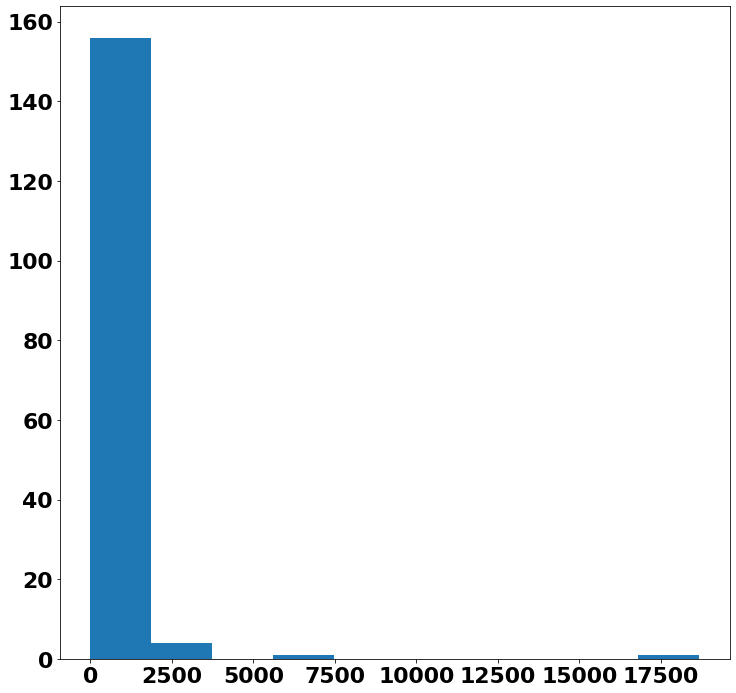

In [1182]:
plt.hist(tt2['Number of Ceftazidime Resistant Neonatal Deaths Averted'])

In [1183]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ceftazidime Resistant Neonatal Deaths Averted'
wm.title = 'Number of Ceftazidime Resistant Neonatal Deaths Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('> 1,000',
       list(tt2[tt2[var] >= 1000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant-ceftazidime.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1184]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ceftazidime Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.title = 'Number of Ceftazidime Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_low-ceftazidime.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1185]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ceftazidime Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.title = 'Number of Ceftazidime Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_high-ceftazidime.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


(array([ 5.,  2., 10., 21., 22., 24., 19., 29., 25.,  5.]),
 array([-2.        , -1.34591848, -0.69183696, -0.03775544,  0.61632608,
         1.2704076 ,  1.92448912,  2.57857064,  3.23265216,  3.88673368,
         4.5408152 ]),
 <a list of 10 Patch objects>)

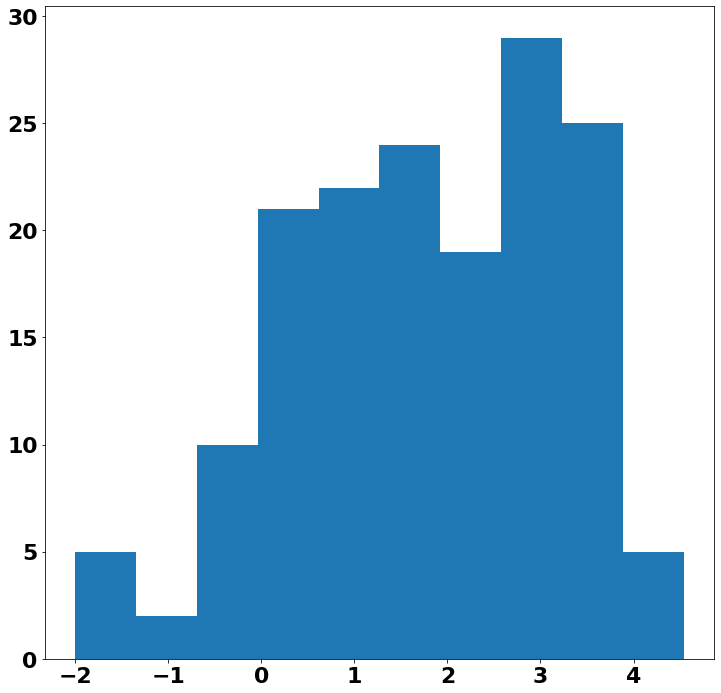

In [1186]:
plt.hist(np.log10(tt2['Number of Ceftazidime Resistant Neonatal Cases Averted'] + 0.01))

In [1187]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Ceftazidime Resistant Neonatal Cases Averted'
wm.title = 'Number of Ceftazidime Resistant Neonatal Cases Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_resistant-ceftazidime.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1188]:
tt3 = pd.concat([tt3, tt2[['Number of Ceftazidime Resistant Neonatal Deaths Averted',
          'Number of Ceftazidime Resistant Neonatal Deaths Averted (2.5th Percentile)',
          'Number of Ceftazidime Resistant Neonatal Deaths Averted (97.5th Percentile)']]], axis = 1)

# Meropenem

In [1189]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution.copy(deep = True)

In [1190]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.pathogen == 'Klebsiella pneumoniae']

In [1191]:
overall_AMR_distribution_extrapolations

WHO Region               pathogen  \
24         AFR  Klebsiella pneumoniae   
25         AFR  Klebsiella pneumoniae   
26         AFR  Klebsiella pneumoniae   
27         AFR  Klebsiella pneumoniae   
28         AFR  Klebsiella pneumoniae   
29         AFR  Klebsiella pneumoniae   
30         AFR  Klebsiella pneumoniae   
31         AFR  Klebsiella pneumoniae   
32         AFR  Klebsiella pneumoniae   
33         AFR  Klebsiella pneumoniae   
34         AFR  Klebsiella pneumoniae   
35         AFR  Klebsiella pneumoniae   
72        SEAR  Klebsiella pneumoniae   
73        SEAR  Klebsiella pneumoniae   
74        SEAR  Klebsiella pneumoniae   
75        SEAR  Klebsiella pneumoniae   
76        SEAR  Klebsiella pneumoniae   
77        SEAR  Klebsiella pneumoniae   
78        SEAR  Klebsiella pneumoniae   
79        SEAR  Klebsiella pneumoniae   
80        SEAR  Klebsiella pneumoniae   
81        SEAR  Klebsiella pneumoniae   
82        SEAR  Klebsiella pneumoniae   
83        SEAR  Klebsiella pneumoniae   
118        EMR  Klebsiella pneumoniae   
119        EMR  Klebsiella pneumoniae   
120        EMR  Klebsiella pneumoniae   
121        EMR  Klebsiella pneumoniae   
122        EMR  Klebsiella pneumoniae   
123        EMR  Klebsiella pneumoniae   
124        EMR  Klebsiella pneumoniae   
125        EMR  Klebsiella pneumoniae   
126        EMR  Klebsiella pneumoniae   
127        EMR  Klebsiella pneumoniae   
128        EMR  Klebsiella pneumoniae   
140        AMR  Klebsiella pneumoniae   
141        AMR  Klebsiella pneumoniae   
142        AMR  Klebsiella pneumoniae   
143        AMR  Klebsiella pneumoniae   
144        AMR  Klebsiella pneumoniae   
145        AMR  Klebsiella pneumoniae   
146        AMR  Klebsiella pneumoniae   
147        AMR  Klebsiella pneumoniae   
165        EUR  Klebsiella pneumoniae   
166        EUR  Klebsiella pneumoniae   
167        EUR  Klebsiella pneumoniae   
168        EUR  Klebsiella pneumoniae   
169        EUR  Klebsiella pneumoniae   
170        EUR  Klebsiella pneumoniae   
171        EUR  Klebsiella pneumoniae   
172        EUR  Klebsiella pneumoniae   
198        WPR  Klebsiella pneumoniae   
199        WPR  Klebsiella pneumoniae   
200        WPR  Klebsiella pneumoniae   
201        WPR  Klebsiella pneumoniae   
202        WPR  Klebsiella pneumoniae   
203        WPR  Klebsiella pneumoniae   
204        WPR  Klebsiella pneumoniae   
205        WPR  Klebsiella pneumoniae   

                                         drug  resistant_cases  \
24                    Penicillins: Ampicillin             99.0   
25   Penicillins: Amoxicillin-Clavulanic Acid             94.0   
26       Penicillins: Piperacillin-Tazobactam             43.0   
27                Cephalosporins: Ceftazidime             91.0   
28                     Carbapenems: Meropenem              6.0   
29                Aminoglycosides: Gentamicin             87.0   
30                  Aminoglycosides: Amikacin             10.0   
31                   Penicillins: Methicillin              1.0   
32                     Macrolides: Rifampicin              0.0   
33                  Glycopeptides: Vancomycin              0.0   
34                   Macrolides: Azithromycin              1.0   
35             Fluoroquinolines: Levofloxacin              0.0   
72                    Penicillins: Ampicillin              7.0   
73   Penicillins: Amoxicillin-Clavulanic Acid              7.0   
74       Penicillins: Piperacillin-Tazobactam              6.0   
75                Cephalosporins: Ceftazidime              7.0   
76                     Carbapenems: Meropenem              4.0   
77                Aminoglycosides: Gentamicin              6.0   
78                  Aminoglycosides: Amikacin              6.0   
79                   Penicillins: Methicillin              0.0   
80                     Macrolides: Rifampicin              0.0   
81                  Glycopeptides: Vancomycin              0.0   
82                   Macr

In [1192]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.drug == 'Carbapenems: Meropenem']

In [1193]:
WHO_map = pd.read_csv(os.path.join(data_dir, 'WHO_countries_by_region.csv'))

In [1194]:
WHO_map = WHO_map[['Country', 'Region']]

In [1195]:
WHO_map = WHO_map.dropna(axis = 0)

In [1196]:
WHO_map['Region'] = WHO_map['Region'].apply(lambda x: x.split()[0])

In [1197]:
tt2 = tt1[tt1.cause != 'All causes'].copy(deep = True)

In [1198]:
tt2 = tt2.merge(WHO_map, on = ['Country'])

In [1199]:
tt2 = tt2.merge(overall_AMR_distribution_extrapolations, left_on = 'Region', right_on = 'WHO Region')

In [1200]:
tt2['Number of Meropenem Resistant Neonatal Deaths Averted'] = tt2['Number of Neonatal Deaths that are Avertable'] * tt2['resistance_deaths']
tt2['Number of Meropenem Resistant Neonatal Cases Averted'] = tt2['Number of Neonatal Cases that are Avertable'] * tt2['resistance_cases']

In [1201]:
tt2

Country                                          cause  cherg_val  \
0    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
1        Bahrain  Neonatal sepsis and other neonatal infections       0.75   
2         Cyprus  Neonatal sepsis and other neonatal infections       1.00   
3       Djibouti  Neonatal sepsis and other neonatal infections     151.50   
4          Egypt  Neonatal sepsis and other neonatal infections    3903.50   
..           ...                                            ...        ...   
157      Myanmar  Neonatal sepsis and other neonatal infections    4930.50   
158        Nepal  Neonatal sepsis and other neonatal infections    3255.75   
159    Sri Lanka  Neonatal sepsis and other neonatal infections     131.00   
160     Thailand  Neonatal sepsis and other neonatal infections     578.50   
161  Timor-Leste  Neonatal sepsis and other neonatal infections     277.50   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
0        3581.75     16675.50               75565.5  2015.5   980.675044   
1           0.00         3.50                  49.5  2015.5     0.980517   
2           0.00         4.25                  41.5  2015.5     0.506737   
3          81.50       262.00                1513.5  2015.5    93.819619   
4        2153.50      6984.75               70922.0  2015.5   509.903012   
..           ...          ...                   ...     ...          ...   
157      2521.25      8264.25               50681.0  2015.5  2729.565018   
158      2103.50      4696.50               26613.5  2015.5  1274.398294   
159        75.50       225.00                3664.5  2015.5   206.244826   
160       247.25      1190.00               10789.5  2015.5   494.805834   
161       136.75       471.25                2154.0  2015.5    60.206099   

           upper        lower  ...  beta_samples_overall_deaths  \
0    1758.252247   484.689042  ...                     0.741901   
1       1.367721     0.692615  ...                     0.741901   
2       0.704163     0.348234  ...                     0.741901   
3     145.475125    56.392335  ...                     0.741901   
4     986.308060   212.860895  ...                     0.741901   
..           ...          ...  ...                          ...   
157  4404.383360  1600.873186  ...                     0.231030   
158  2067.625379   763.156608  ...                     0.231030   
159   298.201728   135.356813  ...                     0.231030   
160   631.221989   381.869219  ...                     0.231030   
161    96.826656    35.213767  ...                     0.231030   

     beta_samples_overall_deaths  resistance_cases  resistance_deaths  \
0                       0.951915          0.707117           0.707136   
1                       0.951915          0.707117           0.707136   
2                       0.951915          0.707117           0.707136   
3                       0.951915          0.707117           0.707136   
4                       0.951915          0.707117           0.707136   
..                           ...               ...                ...   
157                     0.274652          0.665854           0.205549   
158                     0.274652          0.665854           0.205549   
159                     0.274652          0.665854           0.205549   
160                     0.274652          0.665854           0.205549   
161                     0.274652          0.665854           0.205549   

     resistance_cases_lower  resistance_deaths_lower  resistance_cases_upper  \
0                  0.158144                 0.158186                0.987394   
1                  0.158144                 0.158186                0.987394   
2                  0.158144                 0.158186                0.987394   
3                  0.158144                 0.158186                0.987394   
4                  0.158144                 0.158186                0.987394 

In [1202]:
tt2['Number of Meropenem Resistant Neonatal Deaths Averted (2.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Lower Bound)'] * tt2['resistance_deaths_lower']

In [1203]:
tt2['Number of Meropenem Resistant Neonatal Deaths Averted (97.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Upper Bound)'] * tt2['resistance_deaths_upper']

In [1204]:
tt2['Number of Meropenem Resistant Neonatal Cases Averted (2.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Lower Bound)'] * tt2['resistance_cases_lower']

In [1205]:
tt2['Number of Meropenem Resistant Neonatal Cases Averted (97.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Upper Bound)'] * tt2['resistance_cases_upper']

In [1206]:
var = 'Number of Meropenem Resistant Neonatal Deaths Averted'

In [1207]:
tt2 = tt2.set_index(tt2.code)

(array([157.,   3.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([   0.        ,  587.92523116, 1175.85046232, 1763.77569348,
        2351.70092464, 2939.6261558 , 3527.55138696, 4115.47661811,
        4703.40184927, 5291.32708043, 5879.25231159]),
 <a list of 10 Patch objects>)

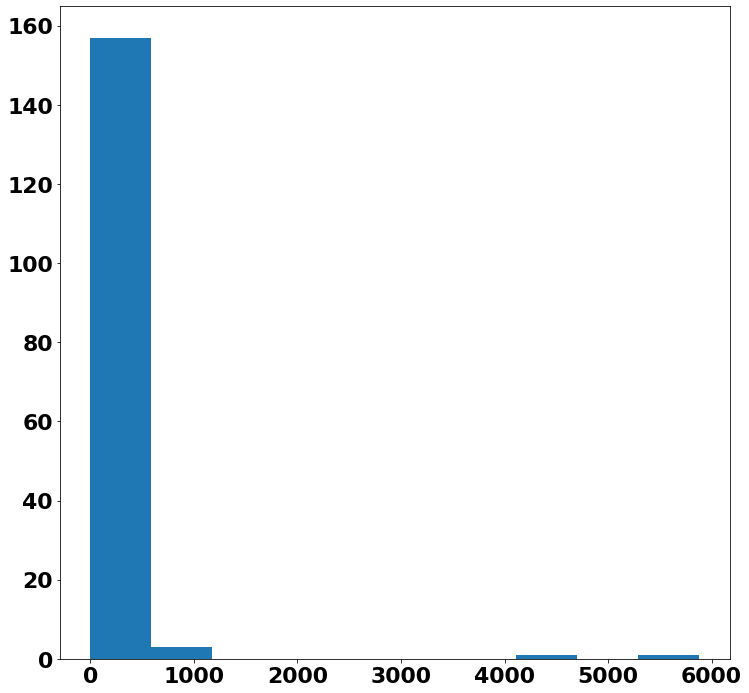

In [1208]:
plt.hist(tt2['Number of Meropenem Resistant Neonatal Deaths Averted'])

In [1209]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Meropenem Resistant Neonatal Deaths Averted'
wm.title = 'Number of Meropenem Resistant Neonatal Deaths Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('> 1,000',
       list(tt2[tt2[var] >= 1000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant-meropenem.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1210]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Meropenem Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.title = 'Number of Meropenem Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_low-meropenem.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1211]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Meropenem Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.title = 'Number of Meropenem Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_high-meropenem.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


(array([ 5.,  2., 13., 26., 26., 32., 37., 16.,  3.,  2.]),
 array([-2.        , -1.31750016, -0.63500031,  0.04749953,  0.72999938,
         1.41249922,  2.09499907,  2.77749891,  3.45999875,  4.1424986 ,
         4.82499844]),
 <a list of 10 Patch objects>)

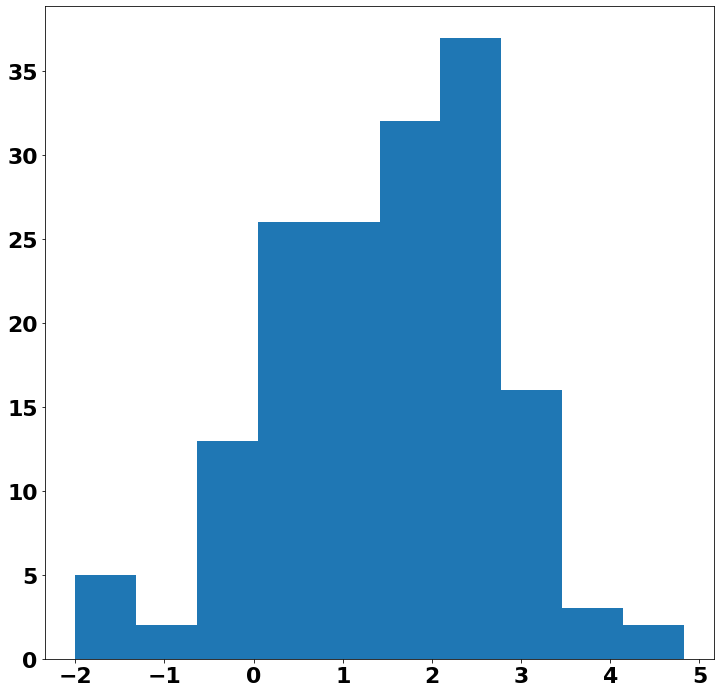

In [1212]:
plt.hist(np.log10(tt2['Number of Meropenem Resistant Neonatal Cases Averted'] + 0.01))

In [1213]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Meropenem Resistant Neonatal Cases Averted'
wm.title = 'Number of Meropenem Resistant Neonatal Cases Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertablecases_resistant-meropenem.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1214]:
tt3 = pd.concat([tt3, tt2[['Number of Meropenem Resistant Neonatal Deaths Averted',
          'Number of Meropenem Resistant Neonatal Deaths Averted (2.5th Percentile)',
          'Number of Meropenem Resistant Neonatal Deaths Averted (97.5th Percentile)']]], axis = 1)

### Future Resistance Burden

In [1215]:
# basically, i want to project future deaths if there were a 10pp increase in klebs resistance
# the idea is that then, the mortality rate would increase because the bacteria are more drug resistant
# so, you'd end up saving more lives

In [1216]:
arg = pd.read_csv(os.path.join(data_dir, 'ARGTemporalTrends.csv'))

In [1217]:
arg.head()

Year  CarbapenemARGs  AminoglycosideARGs
0  2001       -0.011586            1.398396
1  2002        0.000891            0.793226
2  2003        0.007130            2.795900
3  2004       -0.005348            2.901961
4  2005        0.019608            2.496435

In [1218]:
args_flat = pd.DataFrame([*[*['Aminoglycoside'] * 19], *[*['Carbapenemase'] * 19]], columns = ['Type'])

In [1219]:
args_flat['Year'] = [*arg['Year'], *arg['Year']]

In [1220]:
args_flat['ARGs'] = [*arg['AminoglycosideARGs'], *arg['CarbapenemARGs']]

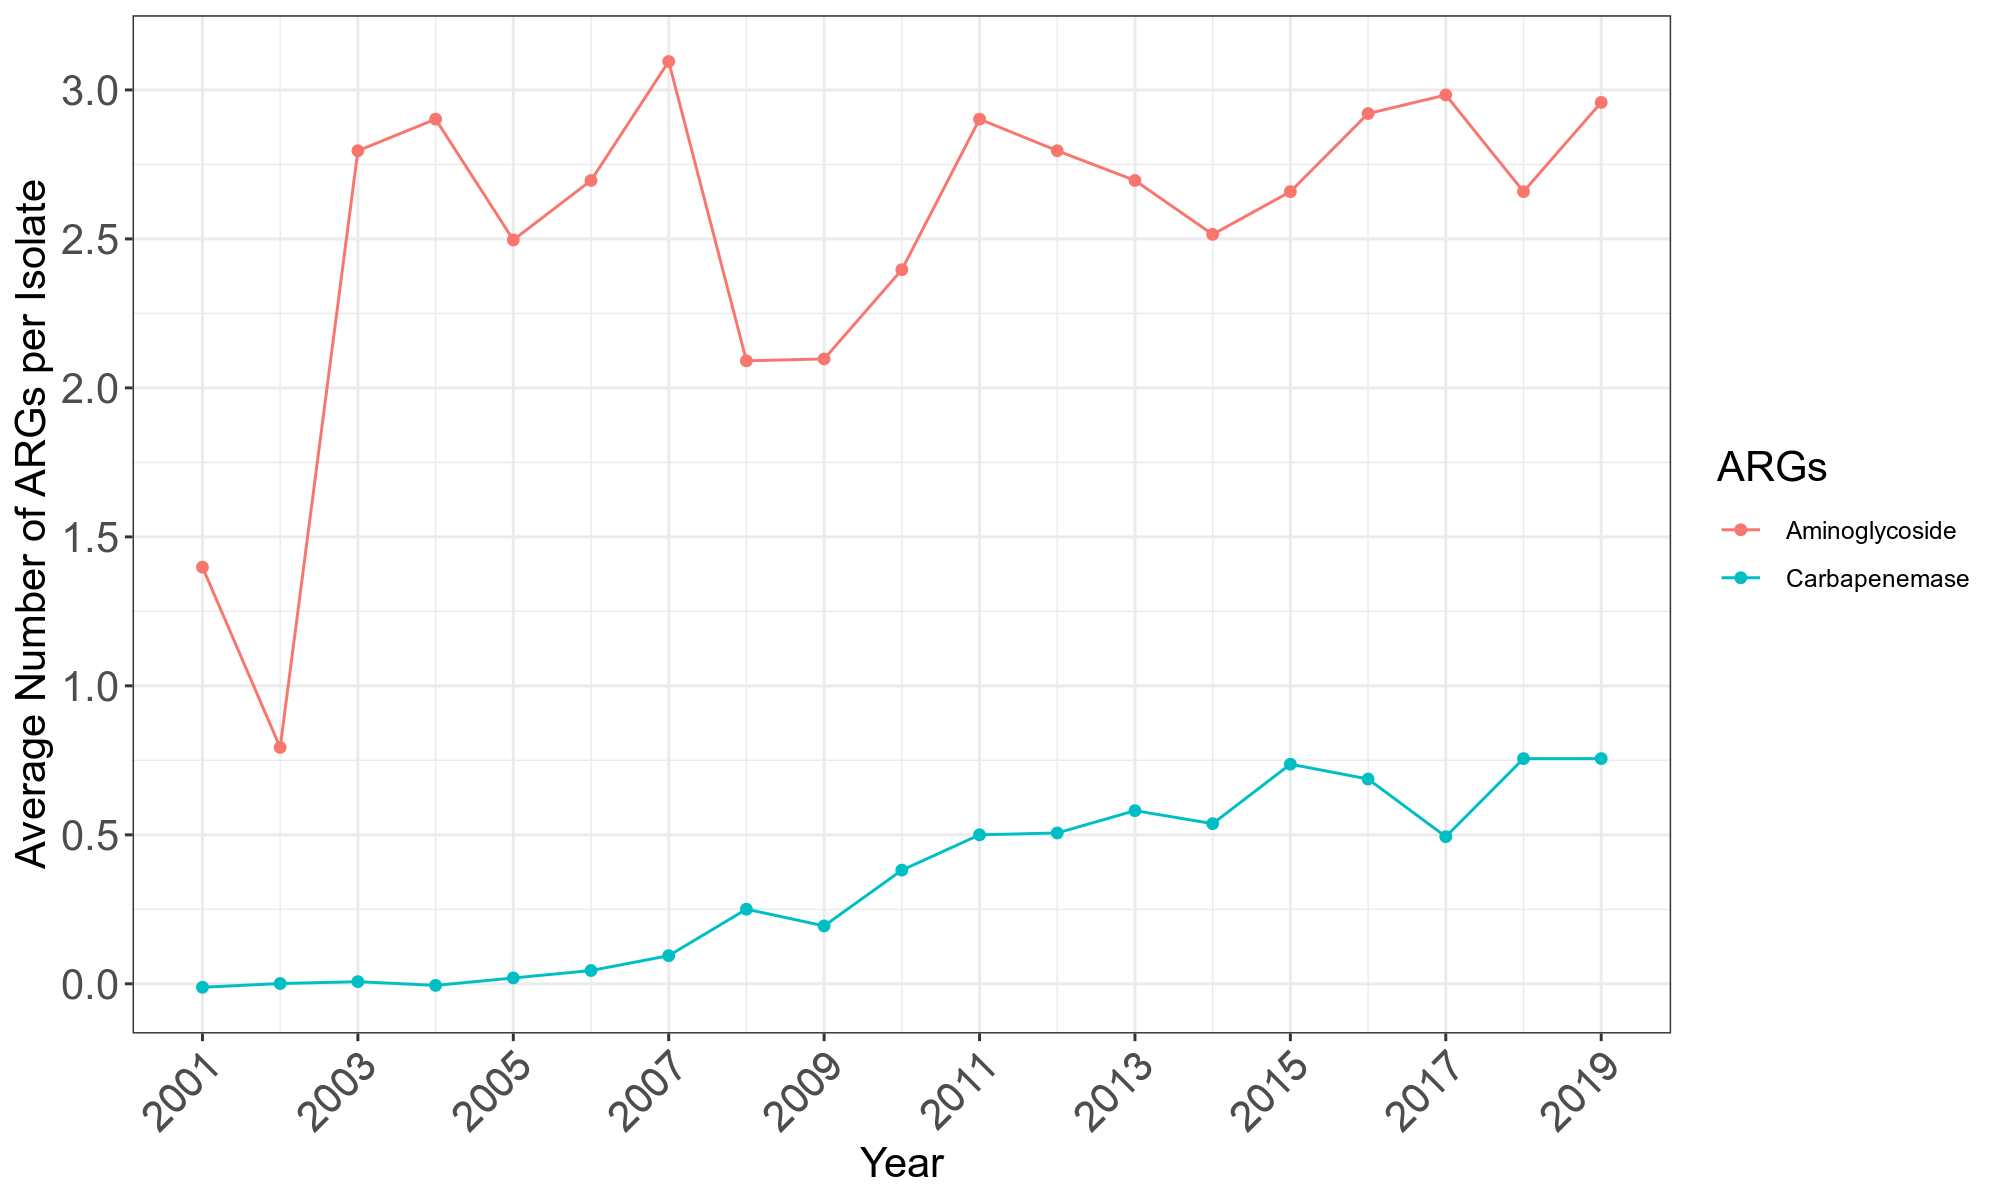

In [1221]:
%%R -i args_flat -w 10 -h 6 --units in -r 200
#positions <- c('AFR', 'SEAR', 'EMR', 'EUR', 'WPR', 'AMR')
ggplot2::ggplot(args_flat) + geom_line(aes(x = Year, y = ARGs, col = Type)) +
    geom_point(aes(x = Year, y = ARGs, col = Type)) +
    scale_x_continuous(breaks = c(2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019)) +
    ylab('Average Number of ARGs per Isolate') + scale_y_continuous(breaks = c(0, 0.5, 1, 1.5, 2, 2.5, 3)) +
    theme(axis.text.x = element_text(angle = 45, hjust=1, size = 15),
                      strip.text = element_text(size=15),
                      axis.text.y = element_text(size = 15),
                      axis.title=element_text(size=15),
                      legend.title=element_text(size=15)) +
    scale_color_discrete(name = "ARGs")

In [1222]:
sm.OLS(arg.CarbapenemARGs, sm.add_constant(arg.Year)).fit().summary()

/home/ckk/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         CarbapenemARGs   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     173.4
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           2.40e-10
Time:                        08:29:22   Log-Likelihood:                 19.814
No. Observations:                  19   AIC:                            -35.63
Df Residuals:                      17   BIC:                            -33.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -99.6032      7.591    -13.122      0.000    -115.618     -83.588
Year           0.0497      0.004     13.167      0.000       0.042       0.058
==============================================================================
Omnibus:                        0.882   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.718
Skew:                          -0.431   Prob(JB):                        0.698
Kurtosis:                       2.597   Cond. No.                     7.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1223]:
future_resistance = (2030 * 0.0497) - 99.6032

In [1224]:
current_resistance = (2015.5 * 0.0497) - 99.6032

In [1225]:
resistance_incr = future_resistance / current_resistance

In [1226]:
resistance_incr

2.2706515031296988

In [1227]:
sm.OLS(arg.AminoglycosideARGs, sm.add_constant(arg.Year)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     AminoglycosideARGs   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     6.843
Date:                Fri, 19 Aug 2022   Prob (F-statistic):             0.0181
Time:                        08:29:22   Log-Likelihood:                -12.892
No. Observations:                  19   AIC:                             29.78
Df Residuals:                      17   BIC:                             31.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -108.5165     42.447     -2.556      0.020    -198.073     -18.960
Year           0.0552      0.021      2.616      0.018       0.011       0.100
==============================================================================
Omnibus:                        3.664   Durbin-Watson:                   1.465
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                1.709
Skew:                          -0.626   Prob(JB):                        0.426
Kurtosis:                       3.768   Cond. No.                     7.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1228]:
sm.OLS(arg.AminoglycosideARGs[2:], sm.add_constant(arg.Year[2:])).fit().summary()

/home/ckk/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     AminoglycosideARGs   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.6417
Date:                Fri, 19 Aug 2022   Prob (F-statistic):              0.436
Time:                        08:29:22   Log-Likelihood:                -2.2585
No. Observations:                  17   AIC:                             8.517
Df Residuals:                      15   BIC:                             10.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.7771     29.290     -0.709      0.489     -83.208      41.654
Year           0.0117      0.015      0.801      0.436      -0.019       0.043
==============================================================================
Omnibus:                        1.749   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.180
Skew:                          -0.629   Prob(JB):                        0.554
Kurtosis:                       2.707   Cond. No.                     8.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1229]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution.copy(deep = True)

In [1230]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.pathogen == 'Klebsiella pneumoniae']

In [1231]:
overall_AMR_distribution_extrapolations

WHO Region               pathogen  \
24         AFR  Klebsiella pneumoniae   
25         AFR  Klebsiella pneumoniae   
26         AFR  Klebsiella pneumoniae   
27         AFR  Klebsiella pneumoniae   
28         AFR  Klebsiella pneumoniae   
29         AFR  Klebsiella pneumoniae   
30         AFR  Klebsiella pneumoniae   
31         AFR  Klebsiella pneumoniae   
32         AFR  Klebsiella pneumoniae   
33         AFR  Klebsiella pneumoniae   
34         AFR  Klebsiella pneumoniae   
35         AFR  Klebsiella pneumoniae   
72        SEAR  Klebsiella pneumoniae   
73        SEAR  Klebsiella pneumoniae   
74        SEAR  Klebsiella pneumoniae   
75        SEAR  Klebsiella pneumoniae   
76        SEAR  Klebsiella pneumoniae   
77        SEAR  Klebsiella pneumoniae   
78        SEAR  Klebsiella pneumoniae   
79        SEAR  Klebsiella pneumoniae   
80        SEAR  Klebsiella pneumoniae   
81        SEAR  Klebsiella pneumoniae   
82        SEAR  Klebsiella pneumoniae   
83        SEAR  Klebsiella pneumoniae   
118        EMR  Klebsiella pneumoniae   
119        EMR  Klebsiella pneumoniae   
120        EMR  Klebsiella pneumoniae   
121        EMR  Klebsiella pneumoniae   
122        EMR  Klebsiella pneumoniae   
123        EMR  Klebsiella pneumoniae   
124        EMR  Klebsiella pneumoniae   
125        EMR  Klebsiella pneumoniae   
126        EMR  Klebsiella pneumoniae   
127        EMR  Klebsiella pneumoniae   
128        EMR  Klebsiella pneumoniae   
140        AMR  Klebsiella pneumoniae   
141        AMR  Klebsiella pneumoniae   
142        AMR  Klebsiella pneumoniae   
143        AMR  Klebsiella pneumoniae   
144        AMR  Klebsiella pneumoniae   
145        AMR  Klebsiella pneumoniae   
146        AMR  Klebsiella pneumoniae   
147        AMR  Klebsiella pneumoniae   
165        EUR  Klebsiella pneumoniae   
166        EUR  Klebsiella pneumoniae   
167        EUR  Klebsiella pneumoniae   
168        EUR  Klebsiella pneumoniae   
169        EUR  Klebsiella pneumoniae   
170        EUR  Klebsiella pneumoniae   
171        EUR  Klebsiella pneumoniae   
172        EUR  Klebsiella pneumoniae   
198        WPR  Klebsiella pneumoniae   
199        WPR  Klebsiella pneumoniae   
200        WPR  Klebsiella pneumoniae   
201        WPR  Klebsiella pneumoniae   
202        WPR  Klebsiella pneumoniae   
203        WPR  Klebsiella pneumoniae   
204        WPR  Klebsiella pneumoniae   
205        WPR  Klebsiella pneumoniae   

                                         drug  resistant_cases  \
24                    Penicillins: Ampicillin             99.0   
25   Penicillins: Amoxicillin-Clavulanic Acid             94.0   
26       Penicillins: Piperacillin-Tazobactam             43.0   
27                Cephalosporins: Ceftazidime             91.0   
28                     Carbapenems: Meropenem              6.0   
29                Aminoglycosides: Gentamicin             87.0   
30                  Aminoglycosides: Amikacin             10.0   
31                   Penicillins: Methicillin              1.0   
32                     Macrolides: Rifampicin              0.0   
33                  Glycopeptides: Vancomycin              0.0   
34                   Macrolides: Azithromycin              1.0   
35             Fluoroquinolines: Levofloxacin              0.0   
72                    Penicillins: Ampicillin              7.0   
73   Penicillins: Amoxicillin-Clavulanic Acid              7.0   
74       Penicillins: Piperacillin-Tazobactam              6.0   
75                Cephalosporins: Ceftazidime              7.0   
76                     Carbapenems: Meropenem              4.0   
77                Aminoglycosides: Gentamicin              6.0   
78                  Aminoglycosides: Amikacin              6.0   
79                   Penicillins: Methicillin              0.0   
80                     Macrolides: Rifampicin              0.0   
81                  Glycopeptides: Vancomycin              0.0   
82                   Macr

In [1232]:
overall_AMR_distribution_extrapolations = overall_AMR_distribution_extrapolations[overall_AMR_distribution_extrapolations.drug == 'Carbapenems: Meropenem']

In [1233]:
WHO_map = pd.read_csv(os.path.join(data_dir, 'WHO_countries_by_region.csv'))

In [1234]:
WHO_map = WHO_map[['Country', 'Region']]

In [1235]:
WHO_map = WHO_map.dropna(axis = 0)

In [1236]:
WHO_map['Region'] = WHO_map['Region'].apply(lambda x: x.split()[0])

In [1237]:
tt2 = tt1[tt1.cause != 'All causes'].copy(deep = True)

In [1238]:
tt2 = tt2.merge(WHO_map, on = ['Country'])

In [1239]:
tt2 = tt2.merge(overall_AMR_distribution_extrapolations, left_on = 'Region', right_on = 'WHO Region')

In [1240]:
tt2['Number of Meropenem Resistant Neonatal Deaths Averted in 2030'] = tt2['Number of Neonatal Deaths that are Avertable'] * tt2['resistance_deaths'] * resistance_incr
tt2['Number of Meropenem Resistant Neonatal Cases Averted in 2030'] = tt2['Number of Neonatal Cases that are Avertable'] * tt2['resistance_cases'] * resistance_incr

In [1241]:
tt2

Country                                          cause  cherg_val  \
0    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
1        Bahrain  Neonatal sepsis and other neonatal infections       0.75   
2         Cyprus  Neonatal sepsis and other neonatal infections       1.00   
3       Djibouti  Neonatal sepsis and other neonatal infections     151.50   
4          Egypt  Neonatal sepsis and other neonatal infections    3903.50   
..           ...                                            ...        ...   
157      Myanmar  Neonatal sepsis and other neonatal infections    4930.50   
158        Nepal  Neonatal sepsis and other neonatal infections    3255.75   
159    Sri Lanka  Neonatal sepsis and other neonatal infections     131.00   
160     Thailand  Neonatal sepsis and other neonatal infections     578.50   
161  Timor-Leste  Neonatal sepsis and other neonatal infections     277.50   

     cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
0        3581.75     16675.50               75565.5  2015.5   980.675044   
1           0.00         3.50                  49.5  2015.5     0.980517   
2           0.00         4.25                  41.5  2015.5     0.506737   
3          81.50       262.00                1513.5  2015.5    93.819619   
4        2153.50      6984.75               70922.0  2015.5   509.903012   
..           ...          ...                   ...     ...          ...   
157      2521.25      8264.25               50681.0  2015.5  2729.565018   
158      2103.50      4696.50               26613.5  2015.5  1274.398294   
159        75.50       225.00                3664.5  2015.5   206.244826   
160       247.25      1190.00               10789.5  2015.5   494.805834   
161       136.75       471.25                2154.0  2015.5    60.206099   

           upper        lower  ...  beta_samples_overall_deaths  \
0    1758.252247   484.689042  ...                     0.741901   
1       1.367721     0.692615  ...                     0.741901   
2       0.704163     0.348234  ...                     0.741901   
3     145.475125    56.392335  ...                     0.741901   
4     986.308060   212.860895  ...                     0.741901   
..           ...          ...  ...                          ...   
157  4404.383360  1600.873186  ...                     0.231030   
158  2067.625379   763.156608  ...                     0.231030   
159   298.201728   135.356813  ...                     0.231030   
160   631.221989   381.869219  ...                     0.231030   
161    96.826656    35.213767  ...                     0.231030   

     beta_samples_overall_deaths  resistance_cases  resistance_deaths  \
0                       0.951915          0.707117           0.707136   
1                       0.951915          0.707117           0.707136   
2                       0.951915          0.707117           0.707136   
3                       0.951915          0.707117           0.707136   
4                       0.951915          0.707117           0.707136   
..                           ...               ...                ...   
157                     0.274652          0.665854           0.205549   
158                     0.274652          0.665854           0.205549   
159                     0.274652          0.665854           0.205549   
160                     0.274652          0.665854           0.205549   
161                     0.274652          0.665854           0.205549   

     resistance_cases_lower  resistance_deaths_lower  resistance_cases_upper  \
0                  0.158144                 0.158186                0.987394   
1                  0.158144                 0.158186                0.987394   
2                  0.158144                 0.158186                0.987394   
3                  0.158144                 0.158186                0.987394   
4                  0.158144                 0.158186                0.987394 

In [1242]:
tt2['Number of Meropenem Resistant Neonatal Deaths Averted in 2030 (2.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Lower Bound)'] * tt2['resistance_deaths_lower'] * resistance_incr

In [1243]:
tt2['Number of Meropenem Resistant Neonatal Deaths Averted in 2030 (97.5th Percentile)'] = tt2['Number of Neonatal Deaths that are Avertable (Upper Bound)'] * tt2['resistance_deaths_upper'] * resistance_incr

In [1244]:
tt2['Number of Meropenem Resistant Neonatal Cases Averted in 2030 (2.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Lower Bound)'] * tt2['resistance_cases_lower'] * resistance_incr

In [1245]:
tt2['Number of Meropenem Resistant Neonatal Cases Averted in 2030 (97.5th Percentile)'] = tt2['Number of Neonatal Cases that are Avertable (Upper Bound)'] * tt2['resistance_cases_upper'] * resistance_incr

In [1246]:
var = 'Number of Meropenem Resistant Neonatal Deaths Averted in 2030'

In [1247]:
tt2 = tt2.set_index(tt2.code)

In [1248]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Meropenem Resistant Neonatal Deaths Averted in 2030'
wm.title = 'Number of Meropenem Resistant Neonatal Deaths Averted'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('> 1,000',
       list(tt2[tt2[var] >= 1000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant-meropenem-future.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1249]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Meropenem Resistant Neonatal Deaths Averted in 2030 (2.5th Percentile)'
wm.title = 'Number of Meropenem Resistant Neonatal Deaths Averted (2.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_low-meropenem-future.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1250]:
dark_lighten_style = DarkenStyle('#238dff', steps = 10, max_ = 85) # #ff8723
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Meropenem Resistant Neonatal Deaths Averted in 2030 (97.5th Percentile)'
wm.title = 'Number of Meropenem Resistant Neonatal Deaths Averted (97.5th Percentile)'
wm.add('< 10',
       list(tt2[tt2[var] < 10].to_dict()['Country'].keys()))

wm.add('10 - 100',
       list(tt2[tt2[var] >= 10][tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))


wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_high-meropenem-future.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.


(array([64., 41., 10.,  0., 26.,  0.,  0.,  0.,  0., 21.]),
 array([0.        , 0.07071359, 0.14142718, 0.21214077, 0.28285437,
        0.35356796, 0.42428155, 0.49499514, 0.56570873, 0.63642232,
        0.70713591]),
 <a list of 10 Patch objects>)

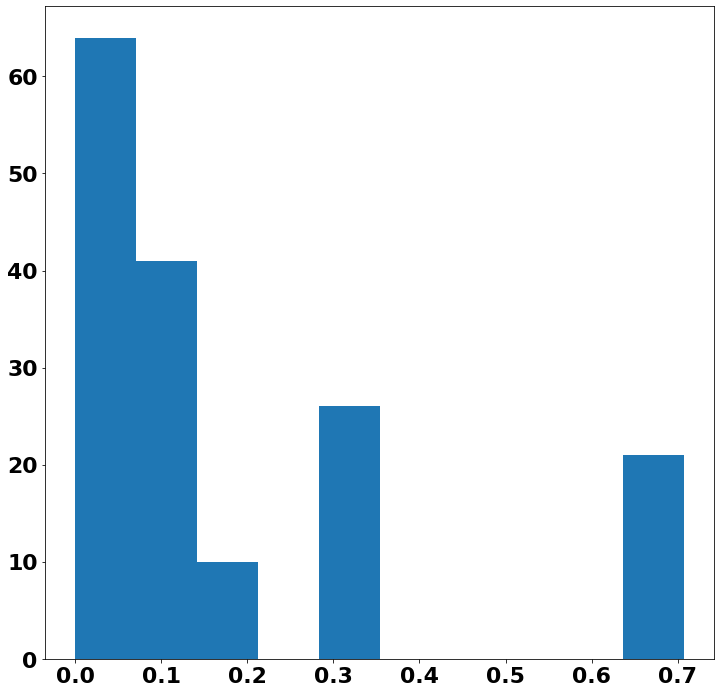

In [1251]:
plt.hist(tt2['resistance_deaths'])

In [1252]:
tt2.columns[0:30]

Index(['Country', 'cause', 'cherg_val', 'cherg_lower', 'cherg_upper',
       'cherg_deaths_overall', 'year', 'val', 'upper', 'lower',
       'Number of Neonatal Deaths that are Avertable',
       'Number of Neonatal Deaths that are Avertable (Upper Bound)',
       'Number of Neonatal Deaths that are Avertable (Lower Bound)',
       'Number of Neonatal Cases that are Avertable',
       'Number of Neonatal Cases that are Avertable (Upper Bound)',
       'Number of Neonatal Cases that are Avertable (Lower Bound)',
       'Percent of All Neonatal Deaths that are Avertable',
       'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
       'Percent of All Neonatal Deaths that are Avertable (Lower Bound)',
       'Country Code', 'TableName', 'code', 'Region', 'WHO Region', 'pathogen',
       'drug', 'resistant_cases', 'overall_cases_x', 'resistant_deaths',
       'overall_deaths_x'],
      dtype='object')

In [1253]:
tt3

Number of Ampicillin Resistant Neonatal Deaths Averted  \
code                                                           
af                                           930.745366        
bh                                             0.074289        
cy                                             0.099052        
dj                                            15.006430        
eg                                           386.650831        
...                                                 ...        
mm                                           120.425984        
np                                            79.520717        
lk                                             3.199636        
th                                            14.129689        
tl                                             6.777854        

      Number of Ampicillin Resistant Neonatal Deaths Averted (2.5th Percentile)  \
code                                                                              
af                                           129.014314                           
bh                                             0.010298                           
cy                                             0.013730                           
dj                                             2.080101                           
eg                                            53.595208                           
...                                                 ...                           
mm                                            39.430289                           
np                                            26.036946                           
lk                                             1.047636                           
th                                             4.626391                           
tl                                             2.219228                           

      Number of Ampicillin Resistant Neonatal Deaths Averted (97.5th Percentile)  \
code                                                                               
af                                          1897.329325                            
bh                                             0.151439                            
cy                                             0.201919                            
dj                                            30.590687                            
eg                                           788.189754                            
...                                                 ...                            
mm                                           311.634856                            
np                                           205.781398                            
lk                                             8.279924                            
th                                            36.564398                            
tl                                            17.539534                            

      Number of Gentamicin Resistant Neonatal Deaths Averted  \
code                                                           
af                                           930.782202        
bh                                             0.074292        
cy                                             0.099056        
dj                                            15.007024        
eg                                           386.666134        
...                                                 ...        
mm                                           607.624239        
np                                           401.231643        
lk                                            16.144159        
th                                            71.293098        
tl                                            34.198504        

      Number of Gentamicin Resistant Neonatal Deaths Averted (2.5th Percentile)  \
code                                                                              
a

In [1256]:
tt2[['Country', 'WHO Region', 'Number of Neonatal Deaths that are Avertable',
    'Number of Neonatal Deaths that are Avertable (Upper Bound)',
    'Number of Neonatal Deaths that are Avertable (Lower Bound)',
    'Number of Neonatal Cases that are Avertable',
    'Number of Neonatal Cases that are Avertable (Upper Bound)',
    'Number of Neonatal Cases that are Avertable (Lower Bound)',
    'Percent of All Neonatal Deaths that are Avertable',
    'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
    'Percent of All Neonatal Deaths that are Avertable (Lower Bound)',
    'Number of Meropenem Resistant Neonatal Deaths Averted in 2030',
    'Number of Meropenem Resistant Neonatal Deaths Averted in 2030 (97.5th Percentile)',
    'Number of Meropenem Resistant Neonatal Deaths Averted in 2030 (2.5th Percentile)']].join(tt3).to_csv(os.path.join(out_dir,
                                                                                            'TableS1-CountryEstimatesOfKPBurden.csv',))

In [652]:
tt2

Country                                          cause  cherg_val  \
code                                                                          
af    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
bh        Bahrain  Neonatal sepsis and other neonatal infections       0.75   
cy         Cyprus  Neonatal sepsis and other neonatal infections       1.00   
dj       Djibouti  Neonatal sepsis and other neonatal infections     151.50   
eg          Egypt  Neonatal sepsis and other neonatal infections    3903.50   
...           ...                                            ...        ...   
mm        Myanmar  Neonatal sepsis and other neonatal infections    4930.50   
np          Nepal  Neonatal sepsis and other neonatal infections    3255.75   
lk      Sri Lanka  Neonatal sepsis and other neonatal infections     131.00   
th       Thailand  Neonatal sepsis and other neonatal infections     578.50   
tl    Timor-Leste  Neonatal sepsis and other neonatal infections     277.50   

      cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
code                                                                        
af        3581.75     16675.50               75565.5  2015.5   980.675044   
bh           0.00         3.50                  49.5  2015.5     0.980517   
cy           0.00         4.25                  41.5  2015.5     0.506737   
dj          81.50       262.00                1513.5  2015.5    93.819619   
eg        2153.50      6984.75               70922.0  2015.5   509.903012   
...           ...          ...                   ...     ...          ...   
mm        2521.25      8264.25               50681.0  2015.5  2729.565018   
np        2103.50      4696.50               26613.5  2015.5  1274.398294   
lk          75.50       225.00                3664.5  2015.5   206.244826   
th         247.25      1190.00               10789.5  2015.5   494.805834   
tl         136.75       471.25                2154.0  2015.5    60.206099   

            upper        lower  ...  resistance_cases_lower  \
code                            ...                           
af    1758.252247   484.689042  ...                0.158397   
bh       1.367721     0.692615  ...                0.158397   
cy       0.704163     0.348234  ...                0.158397   
dj     145.475125    56.392335  ...                0.158397   
eg     986.308060   212.860895  ...                0.158397   
...           ...          ...  ...                     ...   
mm    4404.383360  1600.873186  ...                0.526340   
np    2067.625379   763.156608  ...                0.526340   
lk     298.201728   135.356813  ...                0.526340   
th     631.221989   381.869219  ...                0.526340   
tl      96.826656    35.213767  ...                0.526340   

      resistance_deaths_lower  resistance_cases_upper  \
code                                                    
af                   0.158232                0.987379   
bh                   0.158232                0.987379   
cy                   0.158232                0.987379   
dj                   0.158232                0.987379   
eg                   0.158232                0.987379   
...                       ...                     ...   
mm                   0.079664                0.786794   
np                   0.079664                0.786794   
lk                   0.079664                0.786794   
th                   0.079664                0.786794   
tl                   0.079664                0.786794   

      resistance_deaths_upper  Number of Resistant Neonatal Deaths Averted  \
code                                                                         
af                   0.987388                                   930.405728   
bh                   0.987388                                     0.074262   
cy                   0.987388                                     0.099016   
dj                   0.98738

In [1480]:
# so my estimate of resistant deaths would go up by 25pp or the like

# this is in effect modeling complete beta lactam resistance

increase_pp = 0.20

tt2['Number of Resistant Neonatal Deaths Averted Future pp'] = tt2['Number of Neonatal Deaths that are Avertable'] * tt2['resistance_deaths']

(array([149.,   8.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,   1.]),
 array([    0.        ,  1049.94696707,  2099.89393414,  3149.84090121,
         4199.78786829,  5249.73483536,  6299.68180243,  7349.6287695 ,
         8399.57573657,  9449.52270364, 10499.46967071]),
 <a list of 10 Patch objects>)

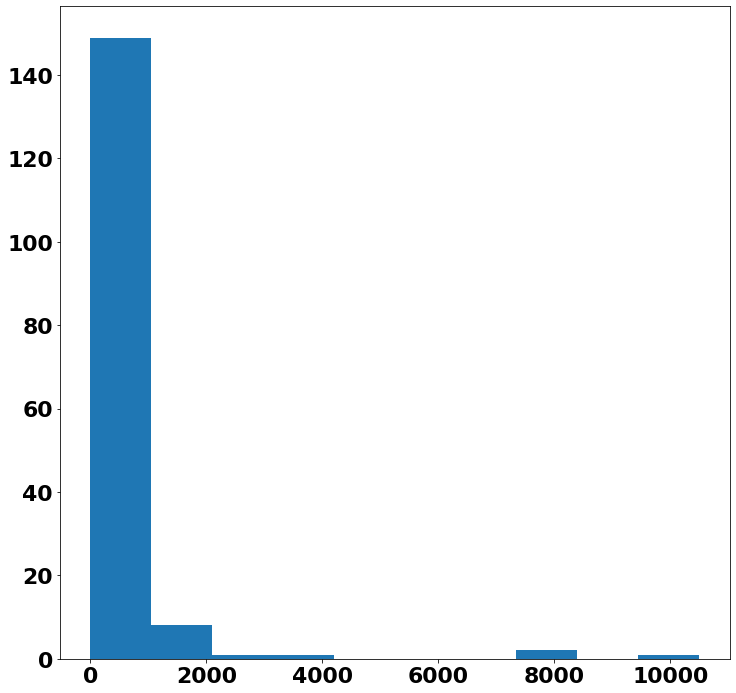

In [1481]:
plt.hist(tt2['Number of Resistant Neonatal Deaths Averted Future pp'])

In [1482]:
dark_lighten_style = DarkenStyle('#ff8723', steps = 10, max_ = 75)
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Resistant Neonatal Deaths Averted Future pp'
wm.title = 'Number of Resistant Neonatal Deaths Averted Under a 25pp Increase in Resistance'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('> 1,000',
       list(tt2[tt2[var] >= 1000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_20pp_increase_completebetalactamresistance.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1483]:
# so my estimate of resistant deaths would go up by 25% or the like
increase = 2

tt2['Number of Resistant Neonatal Deaths Averted Future raw'] = tt2['Number of Neonatal Deaths that are Avertable'] * np.minimum(tt2['resistance_deaths'] * increase, 1)

(array([153.,   4.,   2.,   0.,   0.,   0.,   2.,   0.,   0.,   1.]),
 array([    0.        ,  1295.40730222,  2590.81460443,  3886.22190665,
         5181.62920887,  6477.03651109,  7772.4438133 ,  9067.85111552,
        10363.25841774, 11658.66571995, 12954.07302217]),
 <a list of 10 Patch objects>)

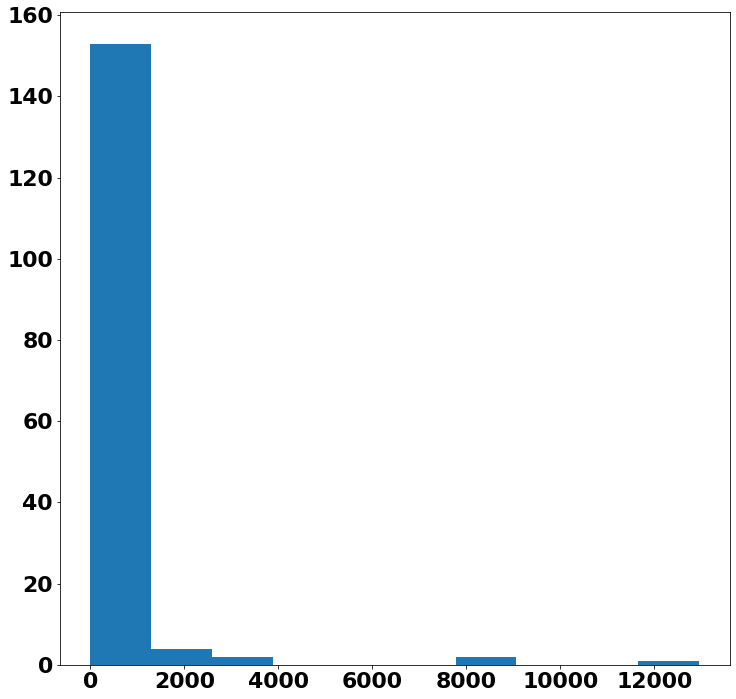

In [1484]:
plt.hist(tt2['Number of Resistant Neonatal Deaths Averted Future raw'])

In [1485]:
dark_lighten_style = DarkenStyle('#ff8723', steps = 10, max_ = 75)
wm = World(style = dark_lighten_style, legend_at_bottom = True)
var = 'Number of Resistant Neonatal Deaths Averted Future raw'
wm.title = 'Number of Resistant Neonatal Deaths Averted Under a 25% Increase in Resistance'
wm.add('< 100',
       list(tt2[tt2[var] < 100].to_dict()['Country'].keys()))

wm.add('100 - 1,000',
       list(tt2[tt2[var] >= 100][tt2[var] < 1000].to_dict()['Country'].keys()))

wm.add('1,000 - 10,000',
       list(tt2[tt2[var] >= 1000][tt2[var] < 10000].to_dict()['Country'].keys()))

wm.add('> 10,000',
       list(tt2[tt2[var] >= 10000][tt2[var] <= 1000000000000000000000000000].to_dict()['Country'].keys()))

wm.render_to_png(os.path.join(fig_dir, 'N_avertabledeaths_resistant_20%_increase_in_kp.png'))
#wm.render_to_file(os.path.join(fig_dir, '%avertabledeaths.svg'))

.:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:12: UserWarning: DataFrame columns are not unique, some columns will be omitted.
.:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
.:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [1486]:
overall_AMR_distribution

WHO Region                 pathogen             drug  resistant_cases  \
0          AFR  Acinetobacter baumannii     BETA LACTAMS             11.0   
1          AFR  Acinetobacter baumannii  AMINOGLYCOSIDES             10.0   
2          AFR  Acinetobacter baumannii         CYCLINES              9.0   
4          AFR  Acinetobacter baumannii       QUINOLONES              8.0   
6          AFR  Acinetobacter baumannii      METHICILLIN              1.0   
..         ...                      ...              ...              ...   
187        WPR    Staphylococcus aureus     BETA LACTAMS              0.0   
188        WPR    Staphylococcus aureus   CEPHALOSPORINS              0.0   
189        WPR    Staphylococcus aureus      METHICILLIN              0.0   
191        WPR    Staphylococcus aureus       QUINOLONES              0.0   
192        WPR    Staphylococcus aureus       VANCOMYCIN              0.0   

     overall_cases_x  resistant_deaths  overall_deaths_x  \
0               11.0               2.0               2.0   
1               12.0               1.0               2.0   
2               12.0               2.0               2.0   
4               12.0               1.0               2.0   
6                1.0               0.0               0.0   
..               ...               ...               ...   
187              0.0               0.0               0.0   
188              0.0               0.0               0.0   
189              0.0               0.0               0.0   
191              0.0               0.0               0.0   
192              0.0               0.0               0.0   

     beta_samples_barnards_deaths  beta_samples_barnards_deaths  \
0                        0.845262                      0.663338   
1                        0.634901                      0.078849   
2                        0.521018                      0.636400   
4                        0.222634                      0.544309   
6                        0.832980                      0.387177   
..                            ...                           ...   
187                      0.000000                      0.000000   
188                      0.000000                      0.000000   
189                      0.000000                      0.000000   
191                      0.000000                      0.000000   
192                      0.000000                      0.000000   

     beta_samples_barnards_deaths  ...  beta_samples_overall_deaths  \
0                        0.861116  ...                     0.942021   
1                        0.448564  ...                     0.521675   
2                        0.587104  ...                     0.702263   
4                        0.483325  ...                     0.734650   
6                        0.178315  ...                     0.868598   
..                            ...  ...                          ...   
187                      0.000000  ...                     0.000000   
188                      0.000000  ...                     0.000000   
189                      0.000000  ...                     0.000000   
191                      0.000000  ...                     0.000000   
192                      0.000000  ...                     0.000000   

     beta_samples_overall_deaths  beta_samples_overall_deaths  \
0                       0.968204                     0.453191   
1                       0.524580                     0.288897   
2                       0.490918                     0.862245   
4                       0.724233                     0.553113   
6                       0.768635                     0.503047   
..                           ...                          ...   
187                     0.000000                     0.000000   
188                     0.000000                     0.000000   
189                     0.000000                     0.000000   
191                     0.000000                  

In [1487]:
tt1

Country                                          cause  cherg_val  \
code                                                                          
af    Afghanistan                                     All causes    9396.50   
af    Afghanistan  Neonatal sepsis and other neonatal infections    9396.50   
al        Albania                                     All causes      35.25   
al        Albania  Neonatal sepsis and other neonatal infections      35.25   
dz        Algeria                                     All causes    2977.25   
...           ...                                            ...        ...   
ye          Yemen  Neonatal sepsis and other neonatal infections    4333.50   
zm         Zambia                                     All causes    3350.50   
zm         Zambia  Neonatal sepsis and other neonatal infections    3350.50   
zw       Zimbabwe                                     All causes    2717.75   
zw       Zimbabwe  Neonatal sepsis and other neonatal infections    2717.75   

      cherg_lower  cherg_upper  cherg_deaths_overall    year           val  \
code                                                                         
af        3581.75     16675.50               75565.5  2015.5  35764.923518   
af        3581.75     16675.50               75565.5  2015.5    980.675044   
al          12.00        76.25                 548.0  2015.5    271.360491   
al          12.00        76.25                 548.0  2015.5      0.726664   
dz        1905.75      4694.00               30353.5  2015.5  12870.655649   
...           ...          ...                   ...     ...           ...   
ye        2469.00      6517.25               37984.0  2015.5    356.499929   
zm        2020.25      5007.25               26874.0  2015.5  13694.679564   
zm        2020.25      5007.25               26874.0  2015.5   1587.460588   
zw        1524.25      4454.00               25925.0  2015.5  11239.738173   
zw        1524.25      4454.00               25925.0  2015.5   1146.236871   

             upper         lower  ...  \
code                              ...   
af    42305.418384  29946.473982  ...   
af     1758.252247    484.689042  ...   
al      358.330721    204.003631  ...   
al        1.059053      0.452505  ...   
dz    15419.834253  10557.726839  ...   
...            ...           ...  ...   
ye      626.485929    198.258558  ...   
zm    17362.152638  10816.133678  ...   
zm     2490.935005    972.709828  ...   
zw    13664.378479   9204.852319  ...   
zw     1707.084458    723.384992  ...   

      Number of Neonatal Deaths that are Avertable (Lower Bound)  \
code                                                               
af                                                  NaN            
af                                           809.219920            
al                                                  NaN            
al                                             3.035705            
dz                                                  NaN            
...                                                 ...            
ye                                           373.197948            
zm                                                  NaN            
zm                                           288.542685            
zw                                                  NaN            
zw                                           234.050704            

      Number of Neonatal Cases that are Avertable  \
code                                                
af                                            NaN   
af                                    6557.130389   
al                                            NaN   
al                                      24.598398   
dz                                            NaN   
...                                           ...   
ye                                    3024.032836   
zm                                            NaN   
zm                

In [1488]:
country_name = 'Nigeria'

In [1489]:
meta_estimates[meta_estimates.location == country_name][['pathogen', 'N_avertabledeaths_who_c', 'N_avertabledeaths_who_upper_c', 'N_avertabledeaths_who_lower_c',
                                                        'N_avertablecases_who_c', 'N_avertablecases_who_upper_c', 'N_avertablecases_who_lower_c',
                                                        '%avertabledeaths_ss_c', '%avertabledeaths_ss_lower_c', '%avertabledeaths_ss_upper_c']]

pathogen  N_avertabledeaths_who_c  \
10  Acinetobacter baumannii              1014.075744   
28         Escherichia coli              5842.149008   
46    Klebsiella pneumoniae             12488.290783   
64    Staphylococcus aureus              1615.680672   

    N_avertabledeaths_who_upper_c  N_avertabledeaths_who_lower_c  \
10                    4843.038015                      90.547578   
28                   14240.706342                    1869.053509   
46                   24701.646137                    5281.049390   
64                    6237.221670                     232.960785   

    N_avertablecases_who_c  N_avertablecases_who_upper_c  \
10             4508.898818                   6463.986234   
28            32869.825906                  47807.332817   
46            62283.430572                  75557.448514   
64            10259.973291                  15073.588600   

    N_avertablecases_who_lower_c  %avertabledeaths_ss_c  \
10                   3337.643919               0.195477   
28                  23798.422152               1.126152   
46                  51963.334563               2.407284   
64                   7439.367280               0.311444   

    %avertabledeaths_ss_lower_c  %avertabledeaths_ss_upper_c  
10                     0.017454                     0.933560  
28                     0.360285                     2.745085  
46                     1.017992                     4.761570  
64                     0.044906                     1.202307

In [1490]:
meta_estimates[meta_estimates.location == country_name][['N_avertabledeaths_who_c']].values / meta_estimates[meta_estimates.location == country_name]['deaths_ns_cherg_val'].values

array([[0.01813927, 0.01813927, 0.01813927, 0.01813927],
       [0.10450137, 0.10450137, 0.10450137, 0.10450137],
       [0.22338415, 0.22338415, 0.22338415, 0.22338415],
       [0.02890047, 0.02890047, 0.02890047, 0.02890047]])

In [1491]:
meta_estimates[meta_estimates.location == country_name][['N_avertabledeaths_who_lower_c']].values / meta_estimates[meta_estimates.location == country_name]['deaths_ns_cherg_upper'].values

array([[0.00107757, 0.00107757, 0.00107757, 0.00107757],
       [0.02224283, 0.02224283, 0.02224283, 0.02224283],
       [0.06284756, 0.06284756, 0.06284756, 0.06284756],
       [0.00277237, 0.00277237, 0.00277237, 0.00277237]])

In [1492]:
meta_estimates[meta_estimates.location == country_name][['N_avertabledeaths_who_upper_c']].values / meta_estimates[meta_estimates.location == country_name]['deaths_ns_cherg_upper'].values

array([[0.05763497, 0.05763497, 0.05763497, 0.05763497],
       [0.1694727 , 0.1694727 , 0.1694727 , 0.1694727 ],
       [0.29396398, 0.29396398, 0.29396398, 0.29396398],
       [0.07422657, 0.07422657, 0.07422657, 0.07422657]])

In [1493]:
tt1[tt1.Country == country_name][['Number of Neonatal Cases that are Avertable',
                            'Number of Neonatal Cases that are Avertable (Lower Bound)',
                            'Number of Neonatal Cases that are Avertable (Upper Bound)',
                            'Number of Neonatal Deaths that are Avertable',
                            'Number of Neonatal Deaths that are Avertable (Lower Bound)',
                            'Number of Neonatal Deaths that are Avertable (Upper Bound)',
                            'Percent of All Neonatal Deaths that are Avertable',
                            'Percent of All Neonatal Deaths that are Avertable (Lower Bound)',
                            'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
                            'cherg_val', 'cherg_lower', 'cherg_upper']]

Number of Neonatal Cases that are Avertable  \
code                                                
ng                                            NaN   
ng                                   39012.012389   

      Number of Neonatal Cases that are Avertable (Lower Bound)  \
code                                                              
ng                                                  NaN           
ng                                         50162.571784           

      Number of Neonatal Cases that are Avertable (Upper Bound)  \
code                                                              
ng                                                  NaN           
ng                                         32039.336742           

      Number of Neonatal Deaths that are Avertable  \
code                                                 
ng                                             NaN   
ng                                     7822.198461   

      Number of Neonatal Deaths that are Avertable (Lower Bound)  \
code                                                               
ng                                                  NaN            
ng                                          4814.498975            

      Number of Neonatal Deaths that are Avertable (Upper Bound)  \
code                                                               
ng                                                  NaN            
ng                                         11428.653217            

      Percent of All Neonatal Deaths that are Avertable  \
code                                                      
ng                                                  NaN   
ng                                             4.492264   

      Percent of All Neonatal Deaths that are Avertable (Lower Bound)  \
code                                                                    
ng                                                  NaN                 
ng                                             2.764952                 

      Percent of All Neonatal Deaths that are Avertable (Upper Bound)  \
code                                                                    
ng                                                  NaN                 
ng                                              6.56344                 

      cherg_val  cherg_lower  cherg_upper  
code                                       
ng      55905.0     34039.25      84029.5  
ng      55905.0     34039.25      84029.5

In [1494]:
tt1[tt1.Country == country_name]['Number of Neonatal Deaths that are Avertable'].values / tt1[tt1.Country == country_name]['cherg_val'].values

array([       nan, 0.13991948])

In [1495]:
tt1[tt1.Country == country_name]['Number of Neonatal Deaths that are Avertable (Lower Bound)'].values / tt1[tt1.Country == country_name]['cherg_lower'].values

array([       nan, 0.14143963])

In [1496]:
tt1[tt1.Country == country_name]['Number of Neonatal Deaths that are Avertable (Upper Bound)'].values / tt1[tt1.Country == country_name]['cherg_upper'].values

array([       nan, 0.13600763])

In [1497]:
tt1[['Number of Neonatal Cases that are Avertable',
     'Number of Neonatal Cases that are Avertable (Upper Bound)',
    'Number of Neonatal Cases that are Avertable (Lower Bound)',
    'Percent of All Neonatal Deaths that are Avertable',
    'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
    'Percent of All Neonatal Deaths that are Avertable (Lower Bound)']].dropna().mean()

Number of Neonatal Cases that are Avertable                        2470.613035
Number of Neonatal Cases that are Avertable (Upper Bound)          2029.036651
Number of Neonatal Cases that are Avertable (Lower Bound)          3176.772899
Percent of All Neonatal Deaths that are Avertable                     2.979954
Percent of All Neonatal Deaths that are Avertable (Upper Bound)       4.353874
Percent of All Neonatal Deaths that are Avertable (Lower Bound)       1.834137
dtype: float64

In [1498]:
tt1[['Number of Neonatal Cases that are Avertable',
     'Number of Neonatal Cases that are Avertable (Upper Bound)',
    'Number of Neonatal Cases that are Avertable (Lower Bound)',
    'Percent of All Neonatal Deaths that are Avertable',
    'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
    'Percent of All Neonatal Deaths that are Avertable (Lower Bound)']].dropna().sum()

Number of Neonatal Cases that are Avertable                        400239.311652
Number of Neonatal Cases that are Avertable (Upper Bound)          328703.937532
Number of Neonatal Cases that are Avertable (Lower Bound)          514637.209716
Percent of All Neonatal Deaths that are Avertable                     482.752612
Percent of All Neonatal Deaths that are Avertable (Upper Bound)       705.327565
Percent of All Neonatal Deaths that are Avertable (Lower Bound)       297.130272
dtype: float64

In [1499]:
tt2[['Number of Resistant Neonatal Cases Averted',
    'Number of Resistant Neonatal Cases Averted (2.5th Percentile)',
    'Number of Resistant Neonatal Cases Averted (97.5th Percentile)']].sum()

Number of Resistant Neonatal Cases Averted                        390822.332063
Number of Resistant Neonatal Cases Averted (2.5th Percentile)     467045.421661
Number of Resistant Neonatal Cases Averted (97.5th Percentile)    328001.962393
dtype: float64

In [1500]:
tt2[tt2.Country == 'Kenya']

Country                                          cause  cherg_val  \
code                                                                     
ke     Kenya  Neonatal sepsis and other neonatal infections    7959.25   

      cherg_lower  cherg_upper  cherg_deaths_overall    year          val  \
code                                                                        
ke         4449.5     12083.25               69515.0  2015.5  3309.024724   

            upper        lower  ...  resistance_cases_upper  \
code                            ...                           
ke    4202.483637  2564.588529  ...                0.998633   

      resistance_deaths_upper  Number of Resistant Neonatal Deaths Averted  \
code                                                                         
ke                   0.983948                                  1061.283583   

      Number of Resistant Neonatal Cases Averted  \
code                                               
ke                                   5502.575754   

      Number of Resistant Neonatal Deaths Averted (2.5th Percentile)  \
code                                                                   
ke                                           609.626967                

      Number of Resistant Neonatal Deaths Averted (97.5th Percentile)  \
code                                                                    
ke                                          1600.990042                 

      Number of Resistant Neonatal Cases Averted (2.5th Percentile)  \
code                                                                  
ke                                          6932.602867               

      Number of Resistant Neonatal Cases Averted (97.5th Percentile)  \
code                                                                   
ke                                           4555.23443                

      Number of Resistant Neonatal Deaths Averted Future pp  \
code                                                          
ke                                          1113.654111       

     Number of Resistant Neonatal Deaths Averted Future raw  
code                                                         
ke                                          1113.654111      

[1 rows x 60057 columns]

In [1501]:
tt1['cherg_deaths_overall'].unique().sum()

5457222.0

In [1502]:
tt1[tt1.cause == 'All causes'].val.sum()

2702614.02381464

In [1507]:
tt1[['Country', 'Number of Neonatal Cases that are Avertable',
                            'Number of Neonatal Cases that are Avertable (Lower Bound)',
                            'Number of Neonatal Cases that are Avertable (Upper Bound)',
                            'Number of Neonatal Deaths that are Avertable',
                            'Number of Neonatal Deaths that are Avertable (Lower Bound)',
                            'Number of Neonatal Deaths that are Avertable (Upper Bound)',
                            'Percent of All Neonatal Deaths that are Avertable',
                            'Percent of All Neonatal Deaths that are Avertable (Lower Bound)',
                            'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
                            'cherg_val', 'cherg_lower', 'cherg_upper']].dropna().mean()

Number of Neonatal Cases that are Avertable                        2470.613035
Number of Neonatal Cases that are Avertable (Lower Bound)          3176.772899
Number of Neonatal Cases that are Avertable (Upper Bound)          2029.036651
Number of Neonatal Deaths that are Avertable                        495.376278
Number of Neonatal Deaths that are Avertable (Lower Bound)          304.900035
Number of Neonatal Deaths that are Avertable (Upper Bound)          723.771420
Percent of All Neonatal Deaths that are Avertable                     2.979954
Percent of All Neonatal Deaths that are Avertable (Lower Bound)       1.834137
Percent of All Neonatal Deaths that are Avertable (Upper Bound)       4.353874
cherg_val                                                          3540.438272
cherg_lower                                                        2132.330247
cherg_upper                                                        5515.080247
dtype: float64

In [1508]:
tt1[['Country', 'Number of Neonatal Cases that are Avertable',
                            'Number of Neonatal Cases that are Avertable (Lower Bound)',
                            'Number of Neonatal Cases that are Avertable (Upper Bound)',
                            'Number of Neonatal Deaths that are Avertable',
                            'Number of Neonatal Deaths that are Avertable (Lower Bound)',
                            'Number of Neonatal Deaths that are Avertable (Upper Bound)',
                            'Percent of All Neonatal Deaths that are Avertable',
                            'Percent of All Neonatal Deaths that are Avertable (Lower Bound)',
                            'Percent of All Neonatal Deaths that are Avertable (Upper Bound)',
                            'cherg_val', 'cherg_lower', 'cherg_upper', 'cherg_deaths_overall']].dropna().sum()

Country                                                            AfghanistanAlbaniaAlgeriaAndorraAngolaArgentin...
Number of Neonatal Cases that are Avertable                                                                   400239
Number of Neonatal Cases that are Avertable (Lower Bound)                                                     514637
Number of Neonatal Cases that are Avertable (Upper Bound)                                                     328704
Number of Neonatal Deaths that are Avertable                                                                   80251
Number of Neonatal Deaths that are Avertable (Lower Bound)                                                   49393.8
Number of Neonatal Deaths that are Avertable (Upper Bound)                                                    117251
Percent of All Neonatal Deaths that are Avertable                                                            482.753
Percent of All Neonatal Deaths that are Avertable (Lower Bound) 

In [1509]:
80251 / 5.45763e+06

0.014704368013221857

In [1510]:
49393.8 / 5.45763e+06

0.009050411992018514

In [1514]:
117251 / 5.45763e+06

0.02148386753957304

In [1515]:
80251 / 573551

0.13991955379730836

In [1518]:
49393.8 / 893443

0.05528478033853307

In [1519]:
117251 / 345438

0.3394270462427411